# setup the geofractal repo

In [1]:
try:
    !pip uninstall -qy geometricvocab geofractal
except:
    pass

!pip install -q git+https://github.com/AbstractEyes/geofractal.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# quick compile test

In [ ]:
"""Quick torch.compile() test"""
import torch
import torch.nn.functional as F

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def test_compile():
    from geofractal.router.head.builder import HeadBuilder
    from geofractal.router.head.components import HeadConfig
    from geofractal.router.factory.prototype import LightweightPrototype, AssembledPrototype, PrototypeConfig
    from geofractal.router.factory.protocols import StreamSpec

    B, S, D = 4, 16, 256

    print("="*60)
    print("  torch.compile() Compatibility Test")
    print("="*60)
    print(f"PyTorch version: {torch.__version__}")
    print(f"Device: {DEVICE}")
    print()

    # 1. ComposedHead
    print("1. ComposedHead...")
    try:
        config = HeadConfig(feature_dim=D)
        head = HeadBuilder.standard(config).build().to(DEVICE)
        compiled_head = torch.compile(head)

        x = torch.randn(B, S, D, device=DEVICE)
        out = compiled_head(x)
        assert out.shape == (B, S, D)

        # Backward
        out.sum().backward()
        print("   ✓ Forward + backward works")
    except Exception as e:
        print(f"   ✗ Failed: {e}")

    # 2. LightweightPrototype
    print("2. LightweightPrototype...")
    try:
        prototype = LightweightPrototype(
            stream_dims={"a": 256, "b": 256},
            num_classes=10,
            hidden_dim=128,
        ).to(DEVICE)
        compiled_proto = torch.compile(prototype)

        inputs = {
            "a": torch.randn(B, 256, device=DEVICE),
            "b": torch.randn(B, 256, device=DEVICE),
        }
        logits, _ = compiled_proto(inputs)
        assert logits.shape == (B, 10)

        labels = torch.randint(0, 10, (B,), device=DEVICE)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        print("   ✓ Forward + backward works")
    except Exception as e:
        print(f"   ✗ Failed: {e}")

    # 3. AssembledPrototype
    print("3. AssembledPrototype...")
    try:
        config = PrototypeConfig(
            num_classes=10,
            stream_specs=[
                StreamSpec.feature_stream("a", input_dim=256, feature_dim=128),
                StreamSpec.feature_stream("b", input_dim=256, feature_dim=128),
            ],
            freeze_streams=False,
        )
        prototype = AssembledPrototype(config).to(DEVICE)
        compiled_proto = torch.compile(prototype)

        inputs = {
            "a": torch.randn(B, 256, device=DEVICE),
            "b": torch.randn(B, 256, device=DEVICE),
        }
        logits, _ = compiled_proto(inputs)
        assert logits.shape == (B, 10)

        labels = torch.randint(0, 10, (B,), device=DEVICE)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        print("   ✓ Forward + backward works")
    except Exception as e:
        print(f"   ✗ Failed: {e}")

    # 4. Training loop with compile
    print("4. Training loop (10 steps)...")
    try:
        prototype = LightweightPrototype(
            stream_dims={"a": 128, "b": 128},
            num_classes=5,
            hidden_dim=64,
        ).to(DEVICE)
        compiled_proto = torch.compile(prototype)
        optimizer = torch.optim.Adam(compiled_proto.parameters(), lr=1e-3)

        for step in range(10):
            inputs = {
                "a": torch.randn(B, 128, device=DEVICE),
                "b": torch.randn(B, 128, device=DEVICE),
            }
            labels = torch.randint(0, 5, (B,), device=DEVICE)

            optimizer.zero_grad()
            logits, _ = compiled_proto(inputs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

        print("   ✓ Training loop works")
    except Exception as e:
        print(f"   ✗ Failed: {e}")

    # 5. Compile modes
    print("5. Compile modes...")
    for mode in ["default", "reduce-overhead", "max-autotune"]:
        try:
            head = HeadBuilder.lightweight(HeadConfig(feature_dim=128)).build().to(DEVICE)
            compiled = torch.compile(head, mode=mode)
            x = torch.randn(B, S, 128, device=DEVICE)
            out = compiled(x)
            print(f"   ✓ mode='{mode}'")
        except Exception as e:
            print(f"   ✗ mode='{mode}': {e}")

    print()
    print("="*60)


if __name__ == "__main__":
    test_compile()

  torch.compile() Compatibility Test
PyTorch version: 2.9.0+cu126
Device: cuda

1. ComposedHead...


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W1205 01:24:52.966000 1028 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and y

   ✓ Forward + backward works
2. LightweightPrototype...


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


   ✓ Forward + backward works
3. AssembledPrototype...


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


   ✓ Forward + backward works
4. Training loop (10 steps)...


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


   ✓ Training loop works
5. Compile modes...


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


   ✓ mode='default'


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


   ✓ mode='reduce-overhead'


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
Autotune Choices Stats:
{"num_choices": 2, "num_triton_choices": 0, "best_kernel": "addmm", "best_time": 0.049984000623226166}
AUTOTUNE addmm(64x512, 64x128, 128x512)
strides: [0, 1], [128, 1], [1, 128]
dtypes: torch.float32, torch.float32, torch.float32
  addmm 0.0500 ms 100.0% 
  bias_addmm 0.0683 ms 73.2% 
SingleProcess AUTOTUNE benchmarking takes 0.0368 seconds and 0.0002 seconds precompiling for 2 choices
Autotune Choices Stats:
{"num_choices": 2, "num_triton_choices": 0, "best_kernel": "addmm", "best_time": 0.04585599899291992}
AUTOTUNE addmm(1x32, 1x64, 64x32)
strides: [0, 1], [64, 1], [1, 64]
dtypes: torch.float32, torch.float32, torch.float32
  addmm 0.0459 ms 100.0% 
  bias_addmm 0.06

   ✓ mode='max-autotune'



# simple classifier test

In [ ]:
"""
Simple classifier using current GeoFractal API.
How hard is it really?
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def test_simple_classifier():
    """Build a simple 2-stream classifier with current API."""

    from geofractal.router.factory.prototype import AssembledPrototype, PrototypeConfig
    from geofractal.router.factory.protocols import StreamSpec, HeadSpec, FusionSpec

    # =================================================================
    # SETUP: Simulated feature extractors (frozen encoders)
    # =================================================================

    # Pretend these are CLIP and DINO
    clip_dim = 512
    dino_dim = 768
    num_classes = 10

    # =================================================================
    # BUILD THE CLASSIFIER
    # =================================================================

    config = PrototypeConfig(
        num_classes=num_classes,
        stream_specs=[
            StreamSpec.feature_vector("clip", input_dim=clip_dim, feature_dim=256),
            StreamSpec.feature_vector("dino", input_dim=dino_dim, feature_dim=256),
        ],
        head_spec=HeadSpec.lightweight(feature_dim=256),
        fusion_spec=FusionSpec.standard(output_dim=256),
        freeze_streams=False,
    )

    model = AssembledPrototype(config).to(DEVICE).compile()

    print(f"Model parameters: {model.num_parameters:,}")
    print(f"Streams: {model.stream_names}")

    # =================================================================
    # TRAINING LOOP
    # =================================================================

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(3):
        epoch_loss = 0
        for step in range(50):
            # Simulate batch of features from frozen encoders
            batch = {
                "clip": torch.randn(32, clip_dim, device=DEVICE),
                "dino": torch.randn(32, dino_dim, device=DEVICE),
            }
            labels = torch.randint(0, num_classes, (32,), device=DEVICE)

            optimizer.zero_grad()
            logits, info = model(batch)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}: loss={epoch_loss/10:.4f}")

    # =================================================================
    # INFERENCE
    # =================================================================

    model.eval()
    with torch.no_grad():
        test_batch = {
            "clip": torch.randn(8, clip_dim, device=DEVICE),
            "dino": torch.randn(8, dino_dim, device=DEVICE),
        }
        logits, info = model(test_batch)
        preds = logits.argmax(dim=-1)
        print(f"Predictions: {preds.tolist()}")

    return model


def test_lightweight_classifier():
    """Even simpler with LightweightPrototype."""

    from geofractal.router.factory.prototype import LightweightPrototype

    # =================================================================
    # BUILD - Just dimensions and classes
    # =================================================================

    model = LightweightPrototype(
        stream_dims={"clip": 512, "dino": 768},
        num_classes=10,
        hidden_dim=256,
    ).to(DEVICE).compile()

    print(f"\nLightweight params: {model.num_parameters:,}")

    # =================================================================
    # TRAIN
    # =================================================================

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for step in range(20):
        batch = {
            "clip": torch.randn(32, 512, device=DEVICE),
            "dino": torch.randn(32, 768, device=DEVICE),
        }
        labels = torch.randint(0, 10, (32,), device=DEVICE)

        optimizer.zero_grad()
        logits, _ = model(batch)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

    print(f"Final loss: {loss.item():.4f}")

    return model


if __name__ == "__main__":
    print("="*60)
    print("  AssembledPrototype Classifier")
    print("="*60)
    test_simple_classifier()

    print("\n" + "="*60)
    print("  LightweightPrototype Classifier")
    print("="*60)
    test_lightweight_classifier()

  AssembledPrototype Classifier
Model parameters: 2,615,042
Streams: ['clip', 'dino']
Epoch 1: loss=12.3842
Epoch 2: loss=11.8204
Epoch 3: loss=11.7913
Predictions: [2, 2, 2, 2, 2, 7, 2, 6]

  LightweightPrototype Classifier

Lightweight params: 331,788
Final loss: 2.2896


# cifar100 classifier test

# imagenet classifier test

# verify t5 determinism

In [ ]:
# Cell 1: LatticePrism Setup - Deterministic T5
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5EncoderModel
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Deterministic everything
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load flan-t5-base FROZEN + EVAL
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
t5 = T5EncoderModel.from_pretrained("google/flan-t5-base").to(device)
t5.eval()
for p in t5.parameters():
    p.requires_grad = False

print(f"flan-t5-base: {sum(p.numel() for p in t5.parameters()):,} params (frozen, deterministic)")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

flan-t5-base: 109,628,544 params (frozen, deterministic)


In [ ]:
hq = load_dataset("agentlans/high-quality-english-sentences", split="train")
print(hq[0])
sentences = [ex['text'] for ex in hq][:5000]

README.md: 0.00B [00:00, ?B/s]

train.txt.gz:   0%|          | 0.00/85.5M [00:00<?, ?B/s]

test.txt.gz:   0%|          | 0.00/9.49M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1534699 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/170522 [00:00<?, ? examples/s]

{'text': 'Soon we dropped into a living forest, where cold-tolerant evergreens and boreal animals still evoke the Canadian heritage of an ecosystem pushed south by glaciers 20,000 years ago.'}


In [ ]:
# Cell 3: Verify determinism
@torch.no_grad()
def encode_t5(texts, max_length=64):
    """Deterministic T5 encoding."""
    enc = tokenizer(texts, return_tensors="pt", padding=True,
                    truncation=True, max_length=max_length)
    hidden = t5(
        input_ids=enc.input_ids.to(device),
        attention_mask=enc.attention_mask.to(device)
    ).last_hidden_state
    return hidden, enc.attention_mask.to(device)

h1, _ = encode_t5(["A cat sits on a mat."])
h2, _ = encode_t5(["A cat sits on a mat."])
print(f"Deterministic: {torch.allclose(h1, h2)}")

Deterministic: True


# building the t5 lattice prism

In [ ]:
# Cell 4: LatticePrism using geofractal components
# ================================================

from geofractal.router.config import CollectiveConfig
from geofractal.router.streams.trainable import TrainableStream
from geofractal.router.fusion.builder import (
    FusionBuilder, FusionStrategy, build_fusion
)
from geofractal.router.registry import RouterMailbox

HIDDEN_DIM = 768  # flan-t5-base

# Collective config
collective_config = CollectiveConfig(
    feature_dim=HIDDEN_DIM,
    fingerprint_dim=64,
    num_anchors=32,
    num_routes=8,
    num_slots=4,
)

# ============================================================================
# STREAM BACKBONES (interpret T5 output differently)
# ============================================================================

class ConvBackbone(nn.Module):
    """Local pattern extraction via convolutions."""
    def __init__(self, input_dim=768):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_dim, input_dim, kernel_size=5, padding=2)
        self.gate = nn.Linear(input_dim * 2, input_dim)
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: [B, S, D] -> pool to [B, D]
        x_t = x.transpose(1, 2)  # [B, D, S]
        c1 = torch.relu(self.conv1(x_t)).mean(dim=-1)  # [B, D]
        c2 = torch.relu(self.conv2(x_t)).mean(dim=-1)  # [B, D]
        concat = torch.cat([c1, c2], dim=-1)  # [B, D*2]
        return self.norm(self.gate(concat))  # [B, D]


class TransformerBackbone(nn.Module):
    """Global attention patterns."""
    def __init__(self, input_dim=768, num_heads=8, num_layers=2):
        super().__init__()
        layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=num_heads,
            dim_feedforward=input_dim * 4, dropout=0.1,
            activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: [B, S, D] -> first token pooling [B, D]
        out = self.transformer(x)
        return self.norm(out[:, 0])


# ============================================================================
# BUILD STREAMS
# ============================================================================

conv_stream = TrainableStream(
    config=collective_config,
    name="conv_local",
    backbone=ConvBackbone(HIDDEN_DIM),
    input_dim=HIDDEN_DIM,
    cooperation_group="lattice_prism",
)

transformer_stream = TrainableStream(
    config=collective_config,
    name="transformer_global",
    backbone=TransformerBackbone(HIDDEN_DIM),
    input_dim=HIDDEN_DIM,
    cooperation_group="lattice_prism",
)

# ============================================================================
# BUILD FUSION (test different strategies)
# ============================================================================

stream_dims = {
    'conv_local': HIDDEN_DIM,
    'transformer_global': HIDDEN_DIM,
}

# Pick fusion strategy to test
fusion = build_fusion(
    stream_dims=stream_dims,
    output_dim=HIDDEN_DIM,
    strategy=FusionStrategy.GATED,  # Adaptive per-sample
)

# ============================================================================
# LATTICE PRISM COLLECTIVE
# ============================================================================

class LatticePrism(nn.Module):
    """Dual-stream collective with proper geofractal routing."""

    def __init__(self, streams, fusion, num_classes=None):
        super().__init__()
        self.streams = nn.ModuleDict({s.name: s for s in streams})
        self.fusion = fusion
        self.mailbox = RouterMailbox()

        self.num_classes = num_classes
        if num_classes:
            self.classifier = nn.Linear(HIDDEN_DIM, num_classes)

    def forward(self, t5_hidden):
        """
        t5_hidden: [B, S, 768] from frozen flan-t5-base
        """
        self.mailbox.clear()

        stream_outputs = {}
        stream_fingerprints = {}

        for name, stream in self.streams.items():
            routed, info = stream(t5_hidden, self.mailbox)
            pooled = stream.pool(routed)  # [B, D]
            stream_outputs[name] = pooled
            stream_fingerprints[name] = stream.fingerprint

        # Fuse streams
        fused, fusion_info = self.fusion(
            stream_outputs,
            stream_fingerprints,
            return_weights=True
        )

        outputs = {
            'fused': fused,
            'streams': stream_outputs,
            'fusion_info': fusion_info,
        }

        if self.num_classes:
            outputs['logits'] = self.classifier(fused)
            # Individual stream logits for emergence calculation
            for name, feat in stream_outputs.items():
                outputs[f'logits_{name}'] = self.classifier(feat)

        return outputs


# Instantiate
prism = LatticePrism(
    streams=[conv_stream, transformer_stream],
    fusion=fusion,
    num_classes=10,
).to(device)

# Count params
trainable = sum(p.numel() for p in prism.parameters() if p.requires_grad)
print(f"=== LatticePrism ===")
print(f"Frozen T5:    {sum(p.numel() for p in t5.parameters()):,}")
print(f"Trainable:    {trainable:,}")
print(f"Streams:      {list(prism.streams.keys())}")
print(f"Fusion:       {type(fusion).__name__}")

=== LatticePrism ===
Frozen T5:    109,628,544
Trainable:    51,088,996
Streams:      ['conv_local', 'transformer_global']
Fusion:       GatedFusion


In [ ]:
# Cell 5: Test forward pass
test_sentences = ["A cat sits on a mat.", "The quick brown fox jumps."]
h, mask = encode_t5(test_sentences)

outputs = prism(h)

print(f"Input: {h.shape}")
print(f"Fused: {outputs['fused'].shape}")
print(f"Conv stream: {outputs['streams']['conv_local'].shape}")
print(f"Transformer stream: {outputs['streams']['transformer_global'].shape}")
print(f"Logits: {outputs['logits'].shape}")
if outputs['fusion_info']:
    print(f"Fusion weights: {outputs['fusion_info'].weights}")

Input: torch.Size([2, 10, 768])
Fused: torch.Size([2, 768])
Conv stream: torch.Size([2, 768])
Transformer stream: torch.Size([2, 768])
Logits: torch.Size([2, 10])
Fusion weights: tensor([[0.5058, 0.4942],
        [0.4890, 0.5110]], device='cuda:0')


In [ ]:
# Cell 6: Build 2.5M training pairs via multi-seed clustering
# ===========================================================

from sklearn.cluster import KMeans
from tqdm.auto import tqdm
import numpy as np

NUM_SENTENCES = 5000
NUM_SEEDS = 500
NUM_CLASSES = 10

# Step 1: Extract T5 embeddings once
print("Extracting T5 embeddings...")
all_embeddings = []
batch_size = 64

with torch.no_grad():
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i:i+batch_size]
        h, _ = encode_t5(batch)
        pooled = h[:, 0].cpu().numpy()  # First token
        all_embeddings.append(pooled)

embeddings = np.concatenate(all_embeddings, axis=0)
print(f"Embeddings: {embeddings.shape}")

# Step 2: Cluster with 500 different seeds
print(f"\nClustering with {NUM_SEEDS} seeds...")
all_labels = []

for seed in tqdm(range(NUM_SEEDS)):
    kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=seed, n_init=3)
    labels = kmeans.fit_predict(embeddings)
    all_labels.append(labels)

all_labels = np.stack(all_labels, axis=1)  # [5000, 500]
print(f"Labels shape: {all_labels.shape}")
print(f"Total training pairs: {NUM_SENTENCES * NUM_SEEDS:,}")

Extracting T5 embeddings...


  0%|          | 0/79 [00:00<?, ?it/s]

Embeddings: (5000, 768)

Clustering with 500 seeds...


  0%|          | 0/500 [00:00<?, ?it/s]

Labels shape: (5000, 500)
Total training pairs: 2,500,000


In [ ]:
# Cell 7: Create HuggingFace Dataset
from datasets import Dataset, DatasetDict

# Option A: Compact format (5000 rows, 500 labels each)
ds_compact = Dataset.from_dict({
    'sentence': sentences,
    'embedding': [emb.tolist() for emb in embeddings],
    'labels': [labels.tolist() for labels in all_labels],  # [500] per row
})

print(f"Compact dataset: {ds_compact}")
print(f"Labels per sentence: {len(ds_compact[0]['labels'])}")

# Push compact version
ds_compact.push_to_hub("AbstractPhil/lattice_prism_t5_500seeds")
print("✓ Pushed: AbstractPhil/lattice_prism_t5_500seeds")

Compact dataset: Dataset({
    features: ['sentence', 'embedding', 'labels'],
    num_rows: 5000
})
Labels per sentence: 500


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   0%|          |  125kB / 26.3MB            

✓ Pushed: AbstractPhil/lattice_prism_t5_500seeds


In [ ]:
# Cell 8: DataLoader that samples (sentence, seed) pairs
class MultiSeedDataset(torch.utils.data.Dataset):
    """Each __getitem__ returns (sentence, embedding, label) for random seed."""

    def __init__(self, sentences, embeddings, all_labels, seeds_per_epoch=1):
        self.sentences = sentences
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.all_labels = torch.tensor(all_labels, dtype=torch.long)  # [N, 500]
        self.seeds_per_epoch = seeds_per_epoch
        self.num_seeds = all_labels.shape[1]

    def __len__(self):
        return len(self.sentences) * self.seeds_per_epoch

    def __getitem__(self, idx):
        sent_idx = idx % len(self.sentences)
        seed_idx = torch.randint(0, self.num_seeds, (1,)).item()

        return {
            'sentence': self.sentences[sent_idx],
            'embedding': self.embeddings[sent_idx],
            'label': self.all_labels[sent_idx, seed_idx],
            'seed': seed_idx,
        }

# Test
dataset = MultiSeedDataset(sentences, embeddings, all_labels, seeds_per_epoch=10)
print(f"Effective epoch size: {len(dataset):,}")
sample = dataset[0]
print(f"Sample: label={sample['label'].item()}, seed={sample['seed']}")

Effective epoch size: 50,000
Sample: label=3, seed=96


In [ ]:
# Cell 9: DataLoader with proper collation
def collate_multi_seed(batch):
    return {
        'sentences': [b['sentence'] for b in batch],
        'embeddings': torch.stack([b['embedding'] for b in batch]),
        'labels': torch.stack([b['label'] for b in batch]),
        'seeds': torch.tensor([b['seed'] for b in batch]),
    }

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_multi_seed,
    num_workers=0,
)

# Verify
batch = next(iter(train_loader))
print(f"Batch sentences: {len(batch['sentences'])}")
print(f"Batch embeddings: {batch['embeddings'].shape}")
print(f"Batch labels: {batch['labels'].shape}")
print(f"Unique seeds in batch: {batch['seeds'].unique().tolist()[:10]}...")

Batch sentences: 32
Batch embeddings: torch.Size([32, 768])
Batch labels: torch.Size([32])
Unique seeds in batch: [26, 49, 50, 104, 123, 124, 153, 165, 169, 171]...


## gated fusion

In [ ]:
# Cell 10: Train LatticePrism on multi-seed clusters
# ===================================================

optimizer = torch.optim.AdamW(prism.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 10
EVAL_EVERY = 500  # steps

def evaluate_batch(model, embeddings, labels):
    """Quick eval on a batch."""
    model.eval()
    with torch.no_grad():
        # Use pre-computed embeddings directly (skip T5)
        # But we need sequence format for prism
        h = embeddings.unsqueeze(1).expand(-1, 10, -1).to(device)  # [B, S, D]
        labels = labels.to(device)

        outputs = model(h)

        pred_fused = outputs['logits'].argmax(dim=-1)
        pred_conv = outputs['logits_conv_local'].argmax(dim=-1)
        pred_trans = outputs['logits_transformer_global'].argmax(dim=-1)

        acc_fused = (pred_fused == labels).float().mean().item()
        acc_conv = (pred_conv == labels).float().mean().item()
        acc_trans = (pred_trans == labels).float().mean().item()

        best_individual = max(acc_conv, acc_trans)
        rho = acc_fused / best_individual if best_individual > 0 else 0

    return acc_fused, acc_conv, acc_trans, rho

# Training
print(f"{'Step':>6} | {'Loss':>6} | {'Fused':>6} | {'Conv':>6} | {'Trans':>6} | {'ρ':>5}")
print("-" * 55)

history = []
step = 0

for epoch in range(NUM_EPOCHS):
    prism.train()
    epoch_loss = 0

    for batch in train_loader:
        # Use pre-computed embeddings (faster than re-encoding)
        embeddings = batch['embeddings'].to(device)
        labels = batch['labels'].to(device)

        # Expand to sequence format for streams
        h = embeddings.unsqueeze(1).expand(-1, 10, -1)  # [B, 10, 768]

        outputs = prism(h)
        loss = criterion(outputs['logits'], labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(prism.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        step += 1

        # Periodic eval
        if step % EVAL_EVERY == 0:
            acc_f, acc_c, acc_t, rho = evaluate_batch(
                prism, batch['embeddings'], batch['labels']
            )
            history.append({
                'step': step, 'loss': loss.item(),
                'fused': acc_f, 'conv': acc_c, 'trans': acc_t, 'rho': rho
            })
            print(f"{step:>6} | {loss.item():>6.3f} | {acc_f*100:>5.1f}% | "
                  f"{acc_c*100:>5.1f}% | {acc_t*100:>5.1f}% | {rho:>5.3f}")

    # End of epoch summary
    avg_loss = epoch_loss / len(train_loader)
    acc_f, acc_c, acc_t, rho = evaluate_batch(prism, batch['embeddings'], batch['labels'])

    print(f"[Epoch {epoch+1:>2}] Loss: {avg_loss:.3f} | "
          f"Fused: {acc_f*100:.1f}% | Conv: {acc_c*100:.1f}% | Trans: {acc_t*100:.1f}% | ρ: {rho:.3f}")

print("-" * 55)
best_rho = max(h['rho'] for h in history) if history else 0
print(f"Best ρ: {best_rho:.3f}")

  Step |   Loss |  Fused |   Conv |  Trans |     ρ
-------------------------------------------------------
   500 |  2.231 |  18.8% |   6.2% |   6.2% | 3.000
  1000 |  2.285 |   6.2% |   6.2% |   6.2% | 1.000
  1500 |  2.363 |   3.1% |  15.6% |  12.5% | 0.200
[Epoch  1] Loss: 2.329 | Fused: 18.8% | Conv: 6.2% | Trans: 6.2% | ρ: 3.000
  2000 |  2.249 |  21.9% |   3.1% |  12.5% | 1.750
  2500 |  2.299 |   9.4% |   9.4% |   3.1% | 1.000
  3000 |  2.317 |   9.4% |  18.8% |   6.2% | 0.500
[Epoch  2] Loss: 2.310 | Fused: 0.0% | Conv: 18.8% | Trans: 18.8% | ρ: 0.000
  3500 |  2.310 |   9.4% |  12.5% |  12.5% | 0.750
  4000 |  2.303 |   9.4% |  12.5% |   9.4% | 0.750
  4500 |  2.302 |  15.6% |   6.2% |  15.6% | 1.000
[Epoch  3] Loss: 2.307 | Fused: 0.0% | Conv: 0.0% | Trans: 0.0% | ρ: 0.000
  5000 |  2.330 |  18.8% |  15.6% |   9.4% | 1.200
  5500 |  2.316 |   6.2% |  12.5% |  21.9% | 0.286
  6000 |  2.257 |  18.8% |  12.5% |  12.5% | 1.500
[Epoch  4] Loss: 2.304 | Fused: 0.0% | Conv: 12.5% | 

## gated fingerprint fusion training

In [ ]:
# Cell 11: Rebuild with FingerprintGuidedFusion
# =============================================

from geofractal.router.fusion.builder import FusionStrategy, build_fusion

# Rebuild fusion with fingerprint guidance
fusion_fp = build_fusion(
    stream_dims=stream_dims,
    output_dim=HIDDEN_DIM,
    strategy=FusionStrategy.FINGERPRINT,
    fingerprint_dim=64,  # Match our config
)

# New prism instance
prism_fp = LatticePrism(
    streams=[
        TrainableStream(
            config=collective_config,
            name="conv_local",
            backbone=ConvBackbone(HIDDEN_DIM),
            input_dim=HIDDEN_DIM,
            cooperation_group="lattice_prism_fp",
        ),
        TrainableStream(
            config=collective_config,
            name="transformer_global",
            backbone=TransformerBackbone(HIDDEN_DIM),
            input_dim=HIDDEN_DIM,
            cooperation_group="lattice_prism_fp",
        ),
    ],
    fusion=fusion_fp,
    num_classes=10,
).to(device)

trainable = sum(p.numel() for p in prism_fp.parameters() if p.requires_grad)
print(f"=== LatticePrism (FingerprintGuided) ===")
print(f"Trainable: {trainable:,}")
print(f"Fusion: {type(fusion_fp).__name__}")

=== LatticePrism (FingerprintGuided) ===
Trainable: 50,598,242
Fusion: FingerprintGuidedFusion


In [ ]:
# Cell 13: Attention fusion - cross-stream communication
fusion_attn = build_fusion(
    stream_dims=stream_dims,
    output_dim=HIDDEN_DIM,
    strategy=FusionStrategy.ATTENTION,
)

prism_attn = LatticePrism(
    streams=[
        TrainableStream(
            config=collective_config,
            name="conv_local",
            backbone=ConvBackbone(HIDDEN_DIM),
            input_dim=HIDDEN_DIM,
            cooperation_group="lattice_prism_attn",
        ),
        TrainableStream(
            config=collective_config,
            name="transformer_global",
            backbone=TransformerBackbone(HIDDEN_DIM),
            input_dim=HIDDEN_DIM,
            cooperation_group="lattice_prism_attn",
        ),
    ],
    fusion=fusion_attn,
    num_classes=10,
).to(device)

print(f"Fusion: {type(fusion_attn).__name__}")

Fusion: AttentionFusion


In [ ]:
# Cell 12: Train with fingerprint-guided fusion
optimizer = torch.optim.AdamW(prism_fp.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

print(f"{'Step':>6} | {'Loss':>6} | {'Fused':>6} | {'Conv':>6} | {'Trans':>6} | {'ρ':>5}")
print("-" * 55)

history_fp = []
step = 0

for epoch in range(NUM_EPOCHS):
    prism_fp.train()
    epoch_loss = 0

    for batch in train_loader:
        embeddings = batch['embeddings'].to(device)
        labels = batch['labels'].to(device)
        h = embeddings.unsqueeze(1).expand(-1, 10, -1)

        outputs = prism_fp(h)
        loss = criterion(outputs['logits'], labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(prism_fp.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        step += 1

        if step % EVAL_EVERY == 0:
            prism_fp.eval()
            with torch.no_grad():
                h_eval = batch['embeddings'].unsqueeze(1).expand(-1, 10, -1).to(device)
                out = prism_fp(h_eval)

                acc_f = (out['logits'].argmax(-1) == labels).float().mean().item()
                acc_c = (out['logits_conv_local'].argmax(-1) == labels).float().mean().item()
                acc_t = (out['logits_transformer_global'].argmax(-1) == labels).float().mean().item()

                best = max(acc_c, acc_t)
                rho = acc_f / best if best > 0 else 0

            history_fp.append({'step': step, 'rho': rho, 'fused': acc_f})
            print(f"{step:>6} | {loss.item():>6.3f} | {acc_f*100:>5.1f}% | "
                  f"{acc_c*100:>5.1f}% | {acc_t*100:>5.1f}% | {rho:>5.3f}")
            prism_fp.train()

    avg_loss = epoch_loss / len(train_loader)
    print(f"[Epoch {epoch+1:>2}] Loss: {avg_loss:.3f}")

print("-" * 55)
best_rho_fp = max(h['rho'] for h in history_fp) if history_fp else 0
print(f"Best ρ (FingerprintGuided): {best_rho_fp:.3f}")
print(f"Best ρ (Gated):             {max(h['rho'] for h in history):.3f}")

  Step |   Loss |  Fused |   Conv |  Trans |     ρ
-------------------------------------------------------
   500 |  2.268 |  15.6% |  18.8% |   0.0% | 0.833
  1000 |  2.330 |  12.5% |   6.2% |   9.4% | 1.333
  1500 |  2.275 |  12.5% |   6.2% |   6.2% | 2.000
[Epoch  1] Loss: 2.298
  2000 |  2.235 |  15.6% |   6.2% |  18.8% | 0.833
  2500 |  2.300 |   6.2% |  12.5% |  12.5% | 0.500
  3000 |  2.337 |   9.4% |   3.1% |  25.0% | 0.375
[Epoch  2] Loss: 2.297
  3500 |  2.245 |  21.9% |  12.5% |  12.5% | 1.750
  4000 |  2.363 |   6.2% |  18.8% |   3.1% | 0.333
  4500 |  2.283 |  15.6% |  21.9% |   9.4% | 0.714
[Epoch  3] Loss: 2.295
  5000 |  2.340 |   3.1% |   6.2% |   6.2% | 0.500
  5500 |  2.294 |   9.4% |   9.4% |  12.5% | 0.750
  6000 |  2.321 |   6.2% |   9.4% |  12.5% | 0.500
[Epoch  4] Loss: 2.296
  6500 |  2.315 |   6.2% |   9.4% |  15.6% | 0.400
  7000 |  2.257 |  18.8% |   3.1% |   9.4% | 2.000
  7500 |  2.302 |  15.6% |   3.1% |  15.6% | 1.000
[Epoch  5] Loss: 2.296
  8000 |  2.2

KeyboardInterrupt: 

# collective tower tests

## 6 tower cifar 10

In [ ]:
"""
CIFAR-10 Tower Collective Classifier
=====================================

Each geometric tower interprets the same image differently.
Fused interpretations → classification.

Run in Colab with geofractal pre-installed.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Optional
from tqdm import tqdm
import time

# Geofractal imports
from geofractal.router.base_router import BaseRouter
from geofractal.router.base_tower import BaseTower
from geofractal.router.components.transformer_component import (
    TransformerConfig,
    TransformerVariant,
    ActivationType,
    PreNormBlock,
)
from geofractal.router.components.rope_component import (
    RoPE,
    DualRoPE,
    TriRoPE,
    QuadRoPE,
    BeatrixRoPE,
    CantorRoPE,
)
from geofractal.router.components.address_component import (
    AddressComponent,
    SimplexAddressComponent,
    SphericalAddressComponent,
    FractalAddressComponent,
    CantorAddressComponent,
)
from geofractal.router.components.fusion_component import AdaptiveFusion

# =============================================================================
# GEOMETRY TYPES
# =============================================================================

from enum import Enum

class GeometryType(str, Enum):
    CANTOR = "cantor"
    BEATRIX = "beatrix"
    HELIX = "helix"
    SIMPLEX = "simplex"
    FRACTAL = "fractal"
    STANDARD = "standard"


# =============================================================================
# GEOMETRIC TOWER (simplified for CIFAR)
# =============================================================================

def build_rope(name: str, geometry: GeometryType, head_dim: int) -> nn.Module:
    """Build geometry-specific RoPE."""
    if geometry == GeometryType.CANTOR:
        return CantorRoPE(f'{name}_rope', head_dim=head_dim, levels=5, mode='hybrid')
    elif geometry == GeometryType.BEATRIX:
        return BeatrixRoPE(f'{name}_rope', head_dim=head_dim, levels=5)
    elif geometry == GeometryType.HELIX:
        return TriRoPE(f'{name}_rope', head_dim=head_dim,
                       theta_alpha=10000.0, theta_beta=5000.0, theta_gamma=2500.0)
    elif geometry == GeometryType.SIMPLEX:
        return QuadRoPE(f'{name}_rope', head_dim=head_dim,
                        theta_w=10000.0, theta_x=7500.0, theta_y=5000.0, theta_z=2500.0)
    elif geometry == GeometryType.FRACTAL:
        return DualRoPE(f'{name}_rope', head_dim=head_dim,
                        theta_primary=10000.0, theta_secondary=3000.0)
    else:
        return RoPE(f'{name}_rope', head_dim=head_dim, theta=10000.0)


class GeometricTower(BaseTower):
    """Lightweight tower for CIFAR-10."""

    def __init__(
        self,
        name: str,
        dim: int = 256,
        depth: int = 2,
        num_heads: int = 4,
        geometry: GeometryType = GeometryType.STANDARD,
        head_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        self.dim = dim
        self.geometry = geometry

        config = TransformerConfig(
            dim=dim,
            num_heads=num_heads,
            ffn_mult=4.0,
            variant=TransformerVariant.PRENORM,
            activation=ActivationType.GELU,
            dropout=0.1,
            depth=depth,
        )

        # Geometry-specific RoPE
        self.attach('rope', build_rope(name, geometry, head_dim))

        # Transformer blocks
        for i in range(depth):
            self.append(PreNormBlock(f'{name}_block_{i}', config=config, block_idx=i))

        self.attach('norm', nn.LayerNorm(dim))

    def forward(self, x: Tensor) -> Tensor:
        """Returns pooled opinion [B, D]."""
        for block in self.stages:
            x, _ = block(x)
        x = self['norm'](x)
        return x.mean(dim=1)  # Global average pool


# =============================================================================
# CIFAR CLASSIFIER
# =============================================================================

class CIFARTowerClassifier(BaseRouter):
    """
    CIFAR-10 classifier using geometric tower collective.

    Architecture:
        Image → PatchEmbed → Towers (same input) → Fuse → Classify
    """

    TOWER_CONFIGS = [
        ('cantor', GeometryType.CANTOR),
        ('beatrix', GeometryType.BEATRIX),
        ('helix', GeometryType.HELIX),
        ('simplex', GeometryType.SIMPLEX),
        ('fractal', GeometryType.FRACTAL),
        ('standard', GeometryType.STANDARD),
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 2,
        num_heads: int = 4,
        patch_size: int = 4,
        num_classes: int = 10,
        tower_subset: Optional[list] = None,
    ):
        super().__init__('cifar_classifier', strict=False)

        self.dim = dim
        self.patch_size = patch_size

        # Select towers
        if tower_subset:
            configs = [(n, g) for n, g in self.TOWER_CONFIGS if n in tower_subset]
        else:
            configs = self.TOWER_CONFIGS

        self._tower_names = [c[0] for c in configs]
        num_towers = len(configs)

        # Patch embedding: [B, 3, 32, 32] → [B, num_patches, dim]
        num_patches = (32 // patch_size) ** 2  # 64 patches for patch_size=4
        self.attach('patch_embed', nn.Conv2d(3, dim, patch_size, patch_size))

        # Position embedding as a proper module
        class PosEmbed(nn.Module):
            def __init__(self, num_patches, dim):
                super().__init__()
                self.pos = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)
            def forward(self, x):
                return x + self.pos

        self.attach('pos_embed', PosEmbed(num_patches, dim))

        # Build towers
        for name, geometry in configs:
            tower = GeometricTower(
                name=name,
                dim=dim,
                depth=tower_depth,
                num_heads=num_heads,
                geometry=geometry,
            )
            self.attach(name, tower)

        # Fusion
        self.attach('fusion', AdaptiveFusion(
            'tower_fusion', num_inputs=num_towers, in_features=dim
        ))

        # Classification head
        self.attach('classifier', nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes),
        ))

        # Store config
        self.objects['tower_names'] = self._tower_names
        self.objects['num_patches'] = num_patches

    @property
    def tower_names(self):
        return self.objects['tower_names']

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: [B, 3, 32, 32] CIFAR images

        Returns:
            logits: [B, num_classes]
        """
        B = x.shape[0]

        # Patch embed
        x = self['patch_embed'](x)  # [B, dim, H/p, W/p]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, dim]
        x = self['pos_embed'](x)  # Add position embedding

        # Each tower processes same input
        opinions = []
        for name in self._tower_names:
            opinion = self[name](x)  # [B, dim]
            opinions.append(opinion)

        # Fuse
        fused = self['fusion'](*opinions)  # [B, dim]

        # Classify
        logits = self['classifier'](fused)

        return logits

    def get_tower_opinions(self, x: Tensor) -> dict:
        """Debug: get individual tower outputs."""
        B = x.shape[0]
        x = self['patch_embed'](x)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        return {name: self[name](x) for name in self._tower_names}


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{total_loss/total:.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 60)
    print("CIFAR-10 Tower Collective Classifier")
    print("=" * 60)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 20
    LR = 3e-4
    DIM = 256
    TOWER_DEPTH = 2
    NUM_HEADS = 4
    PATCH_SIZE = 4

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

    # Model
    model = CIFARTowerClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=10,
        tower_subset=None,  # Use all 6 towers
    ).to(device)

    print(f"\nTowers: {model.tower_names}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.tower_names:
        tower_params = sum(p.numel() for p in model[name].parameters())
        print(f"  {name}: {tower_params:,}")

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # Training loop
    print("\n" + "-" * 60)
    print("Training")
    print("-" * 60)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate(model, test_loader, device)

        scheduler.step()

        elapsed = time.time() - start

        if test_acc > best_acc:
            best_acc = test_acc
            marker = " *"
        else:
            marker = ""

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 60)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 60)

    # Analyze tower contributions
    print("\nTower Analysis (test batch):")
    model.eval()
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images[:16].to(device)

    opinions = model.get_tower_opinions(test_images)
    print("Opinion norms:")
    for name, op in opinions.items():
        print(f"  {name}: {op.norm(dim=-1).mean():.3f}")


if __name__ == '__main__':
    main()

CIFAR-10 Tower Collective Classifier
Device: cuda
Train: 50000, Test: 10000

Towers: ['cantor', 'beatrix', 'helix', 'simplex', 'fractal', 'standard']
Total parameters: 9,519,577
  cantor: 1,578,497
  beatrix: 1,578,497
  helix: 1,578,564
  simplex: 1,578,503
  fractal: 1,578,497
  standard: 1,578,496

------------------------------------------------------------
Training
------------------------------------------------------------


Epoch  1/20 | Loss: 1.7204 | Train: 36.8% | Test: 46.3% * | Time: 27.4s


Epoch  2/20 | Loss: 1.3928 | Train: 49.7% | Test: 53.3% * | Time: 27.3s


Epoch  3/20 | Loss: 1.2549 | Train: 54.6% | Test: 56.4% * | Time: 27.2s


Epoch  4/20 | Loss: 1.1694 | Train: 58.0% | Test: 60.1% * | Time: 27.3s


Epoch  5/20 | Loss: 1.1052 | Train: 60.2% | Test: 61.8% * | Time: 27.1s


Epoch  6/20 | Loss: 1.0456 | Train: 62.4% | Test: 61.5% | Time: 27.2s


Epoch  7/20 | Loss: 1.0059 | Train: 64.0% | Test: 64.2% * | Time: 27.3s


Epoch  8/20 | Loss: 0.9652 | Train: 65.3% | Test: 66.1% * | Time: 27.3s


Epoch  9/20 | Loss: 0.9213 | Train: 66.9% | Test: 67.5% * | Time: 27.3s


Epoch 10/20 | Loss: 0.8840 | Train: 68.4% | Test: 68.4% * | Time: 27.3s


Epoch 11/20 | Loss: 0.8449 | Train: 69.9% | Test: 69.6% * | Time: 27.3s


Epoch 12/20 | Loss: 0.8091 | Train: 71.2% | Test: 71.1% * | Time: 27.3s


Epoch 13/20 | Loss: 0.7774 | Train: 72.5% | Test: 71.4% * | Time: 27.3s


Epoch 14/20 | Loss: 0.7445 | Train: 73.6% | Test: 72.0% * | Time: 27.4s


Epoch 15/20 | Loss: 0.7134 | Train: 74.5% | Test: 73.5% * | Time: 27.3s


Epoch 16/20 | Loss: 0.6945 | Train: 75.5% | Test: 73.6% * | Time: 27.2s


Epoch 17/20 | Loss: 0.6697 | Train: 76.3% | Test: 74.2% * | Time: 27.3s


Epoch 18/20 | Loss: 0.6533 | Train: 76.9% | Test: 74.6% * | Time: 27.2s


Epoch 19/20 | Loss: 0.6389 | Train: 77.5% | Test: 75.0% * | Time: 27.5s


Epoch 20/20 | Loss: 0.6359 | Train: 77.6% | Test: 74.9% | Time: 27.5s

Best Test Accuracy: 75.00%

Tower Analysis (test batch):
Opinion norms:
  cantor: 8.636
  beatrix: 9.319
  helix: 10.891
  simplex: 10.442
  fractal: 9.512
  standard: 10.343


## cantor pair + simplex pair, 4 towers

In [ ]:
"""
CIFAR-10 Dual-Pair Tower Classifier
====================================

4 towers with Cantor/Simplex RoPE × Normal/Inverted fingerprints:
    - Cantor + Cantor FP
    - Cantor + Inverted Cantor FP
    - Simplex + Cantor FP
    - Simplex + Inverted Cantor FP

Fusion hierarchy:
    Cantor pair → fuse → ┐
                         ├─ concat → classify
    Simplex pair → fuse → ┘

Per-class analysis tracks which towers excel at which classes.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
import time

# Geofractal imports
from geofractal.router.base_router import BaseRouter
from geofractal.router.base_tower import BaseTower
from geofractal.router.components.transformer_component import (
    TransformerConfig,
    TransformerVariant,
    ActivationType,
    PreNormBlock,
)
from geofractal.router.components.rope_component import (
    QuadRoPE,
    CantorRoPE,
)
from geofractal.router.components.address_component import CantorAddressComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# =============================================================================
# INVERTED CANTOR ADDRESS
# =============================================================================

class InvertedCantorAddressComponent(CantorAddressComponent):
    """Cantor address with inverted fingerprint (1 - cantor_value)."""

    @property
    def fingerprint(self) -> Tensor:
        """Inverted fingerprint."""
        base_fp = super().fingerprint
        return 1.0 - base_fp


# =============================================================================
# GEOMETRIC TOWER
# =============================================================================

class DualTower(BaseTower):
    """
    Tower with configurable RoPE and Address.

    Args:
        rope_type: 'cantor' or 'simplex'
        inverted: If True, use inverted Cantor fingerprint
    """

    def __init__(
        self,
        name: str,
        dim: int = 256,
        depth: int = 2,
        num_heads: int = 4,
        rope_type: str = 'cantor',
        inverted: bool = False,
        head_dim: int = 64,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        self.dim = dim
        self.rope_type = rope_type
        self.inverted = inverted

        config = TransformerConfig(
            dim=dim,
            num_heads=num_heads,
            ffn_mult=4.0,
            variant=TransformerVariant.PRENORM,
            activation=ActivationType.GELU,
            dropout=0.1,
            depth=depth,
        )

        # RoPE based on type
        if rope_type == 'cantor':
            self.attach('rope', CantorRoPE(
                f'{name}_rope', head_dim=head_dim, levels=5, mode='hybrid'
            ))
        elif rope_type == 'simplex':
            self.attach('rope', QuadRoPE(
                f'{name}_rope', head_dim=head_dim,
                theta_w=10000.0, theta_x=7500.0, theta_y=5000.0, theta_z=2500.0,
                augmentation='simplex'
            ))
        else:
            raise ValueError(f"Unknown rope_type: {rope_type}")

        # Address - Cantor or Inverted Cantor
        if inverted:
            self.attach('address', InvertedCantorAddressComponent(
                f'{name}_address', k_simplex=4,
                fingerprint_dim=fingerprint_dim, mode='staircase'
            ))
        else:
            self.attach('address', CantorAddressComponent(
                f'{name}_address', k_simplex=4,
                fingerprint_dim=fingerprint_dim, mode='staircase'
            ))

        # Transformer blocks
        for i in range(depth):
            self.append(PreNormBlock(f'{name}_block_{i}', config=config, block_idx=i))

        self.attach('norm', nn.LayerNorm(dim))

    @property
    def fingerprint(self) -> Tensor:
        return F.normalize(self['address'].fingerprint, dim=-1)

    def forward(self, x: Tensor) -> Tensor:
        """Returns pooled opinion [B, D]."""
        for block in self.stages:
            x, _ = block(x)
        x = self['norm'](x)
        return x.mean(dim=1)


# =============================================================================
# DUAL-PAIR CLASSIFIER
# =============================================================================

class DualPairClassifier(BaseRouter):
    """
    4-tower classifier with dual-pair fusion.

    Towers:
        cantor_pos:   Cantor RoPE + Cantor FP
        cantor_neg:   Cantor RoPE + Inverted Cantor FP
        simplex_pos:  Simplex RoPE + Cantor FP
        simplex_neg:  Simplex RoPE + Inverted Cantor FP

    Fusion:
        cantor_pair = fuse(cantor_pos, cantor_neg)
        simplex_pair = fuse(simplex_pos, simplex_neg)
        final = concat(cantor_pair, simplex_pair) → classify
    """

    CIFAR_CLASSES = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 2,
        num_heads: int = 4,
        patch_size: int = 4,
        num_classes: int = 10,
        fingerprint_dim: int = 64,
    ):
        super().__init__('dual_pair_classifier', strict=False)

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.attach('patch_embed', nn.Conv2d(3, dim, patch_size, patch_size))

        class PosEmbed(nn.Module):
            def __init__(self, num_patches, dim):
                super().__init__()
                self.pos = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)
            def forward(self, x):
                return x + self.pos

        self.attach('pos_embed', PosEmbed(num_patches, dim))

        # 4 Towers
        self.attach('cantor_pos', DualTower(
            'cantor_pos', dim=dim, depth=tower_depth, num_heads=num_heads,
            rope_type='cantor', inverted=False, fingerprint_dim=fingerprint_dim
        ))
        self.attach('cantor_neg', DualTower(
            'cantor_neg', dim=dim, depth=tower_depth, num_heads=num_heads,
            rope_type='cantor', inverted=True, fingerprint_dim=fingerprint_dim
        ))
        self.attach('simplex_pos', DualTower(
            'simplex_pos', dim=dim, depth=tower_depth, num_heads=num_heads,
            rope_type='simplex', inverted=False, fingerprint_dim=fingerprint_dim
        ))
        self.attach('simplex_neg', DualTower(
            'simplex_neg', dim=dim, depth=tower_depth, num_heads=num_heads,
            rope_type='simplex', inverted=True, fingerprint_dim=fingerprint_dim
        ))

        # Pair fusions
        self.attach('cantor_fusion', AdaptiveFusion(
            'cantor_fusion', num_inputs=2, in_features=dim
        ))
        self.attach('simplex_fusion', AdaptiveFusion(
            'simplex_fusion', num_inputs=2, in_features=dim
        ))

        # Final classifier on concatenated pairs
        self.attach('classifier', nn.Sequential(
            nn.LayerNorm(dim * 2),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # Tower names for iteration
        self.objects['tower_names'] = ['cantor_pos', 'cantor_neg', 'simplex_pos', 'simplex_neg']
        self.objects['num_patches'] = num_patches

        # Class-specific tracking
        self.objects['class_stats'] = None

    @property
    def tower_names(self) -> List[str]:
        return self.objects['tower_names']

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: [B, 3, 32, 32] CIFAR images

        Returns:
            logits: [B, num_classes]
        """
        # Patch embed
        x = self['patch_embed'](x)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        # Tower opinions
        cantor_pos = self['cantor_pos'](x)
        cantor_neg = self['cantor_neg'](x)
        simplex_pos = self['simplex_pos'](x)
        simplex_neg = self['simplex_neg'](x)

        # Pair fusion
        cantor_fused = self['cantor_fusion'](cantor_pos, cantor_neg)
        simplex_fused = self['simplex_fusion'](simplex_pos, simplex_neg)

        # Concatenate pairs
        combined = torch.cat([cantor_fused, simplex_fused], dim=-1)

        # Classify
        logits = self['classifier'](combined)

        return logits

    def forward_with_opinions(self, x: Tensor) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward pass returning logits and individual tower opinions."""
        # Patch embed
        x = self['patch_embed'](x)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        # Tower opinions
        opinions = {
            'cantor_pos': self['cantor_pos'](x),
            'cantor_neg': self['cantor_neg'](x),
            'simplex_pos': self['simplex_pos'](x),
            'simplex_neg': self['simplex_neg'](x),
        }

        # Pair fusion
        cantor_fused = self['cantor_fusion'](opinions['cantor_pos'], opinions['cantor_neg'])
        simplex_fused = self['simplex_fusion'](opinions['simplex_pos'], opinions['simplex_neg'])

        # Add fused opinions
        opinions['cantor_fused'] = cantor_fused
        opinions['simplex_fused'] = simplex_fused

        # Concatenate and classify
        combined = torch.cat([cantor_fused, simplex_fused], dim=-1)
        logits = self['classifier'](combined)

        return logits, opinions

    def get_fingerprint_info(self) -> Dict[str, Tensor]:
        """Get fingerprints from all towers."""
        return {name: self[name].fingerprint for name in self.tower_names}


# =============================================================================
# CLASS-SPECIFIC ANALYSIS
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance for each tower."""

    CIFAR_CLASSES = DualPairClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        """Reset all tracking."""
        # Per-class correct/total for each tower's opinion
        self.tower_class_correct = {
            name: defaultdict(int) for name in self.tower_names
        }
        self.tower_class_total = {
            name: defaultdict(int) for name in self.tower_names
        }

        # Per-class opinion norms
        self.tower_class_norms = {
            name: defaultdict(list) for name in self.tower_names
        }

        # Overall per-class stats
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(
        self,
        opinions: Dict[str, Tensor],
        logits: Tensor,
        labels: Tensor,
        classifier: nn.Module,
    ):
        """
        Update stats with a batch.

        Args:
            opinions: Dict of tower opinions [B, D]
            logits: Model output logits [B, C]
            labels: Ground truth [B]
            classifier: The classifier head to probe tower opinions
        """
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()

            # Overall accuracy
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            # Per-tower analysis
            for name in self.tower_names:
                opinion = opinions[name][i:i+1]  # [1, D]

                # Track opinion norm per class
                norm = opinion.norm().item()
                self.tower_class_norms[name][label_idx].append(norm)

                self.tower_class_total[name][label_idx] += 1

    def get_class_accuracy(self) -> Dict[str, float]:
        """Get per-class accuracy."""
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(10)
        }

    def get_tower_class_norms(self) -> Dict[str, Dict[str, float]]:
        """Get average opinion norm per tower per class."""
        result = {}
        for name in self.tower_names:
            result[name] = {}
            for c in range(10):
                norms = self.tower_class_norms[name][c]
                if norms:
                    result[name][self.CIFAR_CLASSES[c]] = sum(norms) / len(norms)
                else:
                    result[name][self.CIFAR_CLASSES[c]] = 0.0
        return result

    def print_report(self):
        """Print analysis report."""
        print("\n" + "=" * 70)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 70)

        # Per-class accuracy
        print("\nPer-Class Accuracy:")
        print("-" * 40)
        class_acc = self.get_class_accuracy()
        for cls, acc in sorted(class_acc.items(), key=lambda x: -x[1]):
            bar = "█" * int(acc / 5)
            print(f"  {cls:12s}: {acc:5.1f}% {bar}")

        # Tower opinion norms per class
        print("\nTower Opinion Norms by Class:")
        print("-" * 70)
        tower_norms = self.get_tower_class_norms()

        # Header
        header = f"{'Class':12s}"
        for name in self.tower_names:
            short_name = name.replace('_', '-')[:10]
            header += f" {short_name:>10s}"
        print(header)
        print("-" * 70)

        # Rows
        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            row = f"{cls:12s}"
            for name in self.tower_names:
                norm = tower_norms[name][cls]
                row += f" {norm:10.2f}"
            print(row)

        # Tower averages
        print("-" * 70)
        row = f"{'Average':12s}"
        for name in self.tower_names:
            avg = sum(tower_norms[name].values()) / 10
            row += f" {avg:10.2f}"
        print(row)

        # Find which tower is strongest for each class
        print("\nStrongest Tower per Class:")
        print("-" * 40)
        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            best_tower = max(self.tower_names, key=lambda n: tower_norms[n][cls])
            best_norm = tower_norms[best_tower][cls]
            print(f"  {cls:12s}: {best_tower:15s} ({best_norm:.2f})")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f'{total_loss/total:.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    """Evaluate and collect per-class stats."""
    model.eval()
    analyzer.reset()

    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Evaluating", leave=False):
        images, labels = images.to(device), labels.to(device)

        logits, opinions = model.forward_with_opinions(images)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        # Update analyzer (only tower opinions, not fused)
        tower_opinions = {k: v for k, v in opinions.items() if k in model.tower_names}
        analyzer.update(tower_opinions, logits, labels, model['classifier'])

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-10 Dual-Pair Tower Classifier")
    print("=" * 70)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 25
    LR = 3e-4
    DIM = 256
    TOWER_DEPTH = 2
    NUM_HEADS = 4
    PATCH_SIZE = 4

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

    # Model
    model = DualPairClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=10,
    ).to(device)

    print(f"\nArchitecture:")
    print(f"  Towers: {model.tower_names}")
    print(f"  Fusion: cantor_pair → fuse, simplex_pair → fuse, concat → classify")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")
    for name in model.tower_names:
        tower_params = sum(p.numel() for p in model[name].parameters())
        print(f"  {name}: {tower_params:,}")

    # Fingerprint info
    print("\nFingerprint similarities:")
    fps = model.get_fingerprint_info()
    fp_list = list(fps.values())
    names = list(fps.keys())
    for i, n1 in enumerate(names):
        for j, n2 in enumerate(names):
            if i < j:
                sim = F.cosine_similarity(fp_list[i].unsqueeze(0), fp_list[j].unsqueeze(0)).item()
                print(f"  {n1} <-> {n2}: {sim:.3f}")

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Training loop
    print("\n" + "-" * 70)
    print("Training")
    print("-" * 70)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        scheduler.step()

        elapsed = time.time() - start

        if test_acc > best_acc:
            best_acc = test_acc
            marker = " *"
        else:
            marker = ""

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 70)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 70)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-10 Dual-Pair Tower Classifier
Device: cuda
Train: 50000, Test: 10000

Architecture:
  Towers: ['cantor_pos', 'cantor_neg', 'simplex_pos', 'simplex_neg']
  Fusion: cantor_pair → fuse, simplex_pair → fuse, concat → classify

Total parameters: 6,510,884
  cantor_pos: 1,578,499
  cantor_neg: 1,578,499
  simplex_pos: 1,578,505
  simplex_neg: 1,578,505

Fingerprint similarities:
  cantor_pos <-> cantor_neg: 0.600
  cantor_pos <-> simplex_pos: 1.000
  cantor_pos <-> simplex_neg: 0.600
  cantor_neg <-> simplex_pos: 0.600
  cantor_neg <-> simplex_neg: 1.000
  simplex_pos <-> simplex_neg: 0.600

----------------------------------------------------------------------
Training
----------------------------------------------------------------------


Epoch  1/25 | Loss: 1.7188 | Train: 36.0% | Test: 43.4% * | Time: 21.1s


Epoch  2/25 | Loss: 1.3958 | Train: 49.3% | Test: 53.2% * | Time: 21.3s


Epoch  3/25 | Loss: 1.2564 | Train: 54.5% | Test: 55.3% * | Time: 21.1s


Epoch  4/25 | Loss: 1.1643 | Train: 58.1% | Test: 60.4% * | Time: 21.1s


Epoch  5/25 | Loss: 1.0978 | Train: 60.4% | Test: 61.2% * | Time: 21.1s


Epoch  6/25 | Loss: 1.0434 | Train: 62.6% | Test: 63.6% * | Time: 21.2s


Epoch  7/25 | Loss: 0.9904 | Train: 64.5% | Test: 65.9% * | Time: 21.2s


Epoch  8/25 | Loss: 0.9461 | Train: 66.2% | Test: 67.7% * | Time: 21.9s


Epoch  9/25 | Loss: 0.9049 | Train: 67.8% | Test: 68.8% * | Time: 21.2s


Epoch 10/25 | Loss: 0.8710 | Train: 68.9% | Test: 70.4% * | Time: 21.3s


Epoch 11/25 | Loss: 0.8319 | Train: 70.4% | Test: 71.3% * | Time: 21.2s


Epoch 12/25 | Loss: 0.8051 | Train: 71.3% | Test: 71.5% * | Time: 21.5s


Epoch 13/25 | Loss: 0.7700 | Train: 72.3% | Test: 72.4% * | Time: 21.3s


Epoch 14/25 | Loss: 0.7417 | Train: 73.6% | Test: 72.5% * | Time: 21.3s


Epoch 15/25 | Loss: 0.7166 | Train: 74.6% | Test: 74.2% * | Time: 21.4s


Epoch 16/25 | Loss: 0.6893 | Train: 75.7% | Test: 75.2% * | Time: 21.3s


Epoch 17/25 | Loss: 0.6601 | Train: 76.5% | Test: 75.8% * | Time: 21.4s


Epoch 18/25 | Loss: 0.6393 | Train: 77.3% | Test: 76.4% * | Time: 21.5s


Epoch 19/25 | Loss: 0.6154 | Train: 78.1% | Test: 75.8% | Time: 21.9s


Epoch 20/25 | Loss: 0.6001 | Train: 78.7% | Test: 76.8% * | Time: 21.6s


Epoch 21/25 | Loss: 0.5857 | Train: 79.0% | Test: 77.2% * | Time: 21.1s


Epoch 22/25 | Loss: 0.5677 | Train: 79.8% | Test: 77.3% * | Time: 21.3s


Epoch 23/25 | Loss: 0.5644 | Train: 79.9% | Test: 77.2% | Time: 21.3s


Epoch 24/25 | Loss: 0.5576 | Train: 80.2% | Test: 77.4% * | Time: 21.2s


Epoch 25/25 | Loss: 0.5497 | Train: 80.5% | Test: 77.6% * | Time: 21.3s

Best Test Accuracy: 77.60%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy:
----------------------------------------
  automobile  :  88.0% █████████████████
  ship        :  85.4% █████████████████
  truck       :  84.7% ████████████████
  frog        :  84.6% ████████████████
  horse       :  82.0% ████████████████
  airplane    :  79.8% ███████████████
  dog         :  75.8% ███████████████
  bird        :  69.9% █████████████
  deer        :  69.9% █████████████
  cat         :  55.9% ███████████

Tower Opinion Norms by Class:
----------------------------------------------------------------------
Class        cantor-pos cantor-neg simplex-po simplex-ne
----------------------------------------------------------------------
airplane           9.29      10.18       8.99       9.37
automobile         7.39       8.42       8.71       8.13
bird               9.75      10.20       9.19       9.37
cat                8.46       9.24       8.88       8.42
deer               9.99      10.19       9.31       9.22
dog      

## cantor pair + helix pair + beatrix +  simplex

In [ ]:
"""
CIFAR-10 Shape Tower Classifier
================================

8 towers with 4 geometries × pos/neg fingerprints:
    - Cantor  + pos/neg Cantor FP (fractal wormholes)
    - Simplex + pos/neg Cantor FP (barycentric 4D)
    - Helix   + pos/neg Cantor FP (3-scale spiral)
    - Beatrix + pos/neg Cantor FP (devil's staircase)

Fusion hierarchy:
    cantor_pair  → fuse ─┐
    simplex_pair → fuse ─┼─► concat [4×dim] → classify
    helix_pair   → fuse ─┤
    beatrix_pair → fuse ─┘
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
import time

# Geofractal imports
from geofractal.router.base_router import BaseRouter
from geofractal.router.base_tower import BaseTower
from geofractal.router.components.transformer_component import (
    TransformerConfig,
    TransformerVariant,
    ActivationType,
    PreNormBlock,
)
from geofractal.router.components.rope_component import (
    QuadRoPE,
    TriRoPE,
    CantorRoPE,
    BeatrixRoPE,
)
from geofractal.router.components.address_component import CantorAddressComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# =============================================================================
# INVERTED CANTOR ADDRESS
# =============================================================================

class InvertedCantorAddressComponent(CantorAddressComponent):
    """Cantor address with inverted fingerprint (1 - cantor_value)."""

    @property
    def fingerprint(self) -> Tensor:
        base_fp = super().fingerprint
        return 1.0 - base_fp


# =============================================================================
# SHAPE TOWER
# =============================================================================

class ShapeTower(BaseTower):
    """
    Tower with configurable geometry RoPE and pos/neg fingerprint.

    Args:
        rope_type: 'cantor', 'simplex', 'helix', 'beatrix'
        inverted: If True, use inverted Cantor fingerprint
    """

    def __init__(
        self,
        name: str,
        dim: int = 256,
        depth: int = 2,
        num_heads: int = 4,
        rope_type: str = 'cantor',
        inverted: bool = False,
        head_dim: int = 64,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        self.dim = dim
        self.rope_type = rope_type
        self.inverted = inverted

        config = TransformerConfig(
            dim=dim,
            num_heads=num_heads,
            ffn_mult=4.0,
            variant=TransformerVariant.PRENORM,
            activation=ActivationType.GELU,
            dropout=0.1,
            depth=depth,
        )

        # Geometry-specific RoPE
        if rope_type == 'cantor':
            self.attach('rope', CantorRoPE(
                f'{name}_rope', head_dim=head_dim, levels=5, mode='hybrid'
            ))
        elif rope_type == 'simplex':
            self.attach('rope', QuadRoPE(
                f'{name}_rope', head_dim=head_dim,
                theta_w=10000.0, theta_x=7500.0, theta_y=5000.0, theta_z=2500.0,
                augmentation='simplex'
            ))
        elif rope_type == 'helix':
            self.attach('rope', TriRoPE(
                f'{name}_rope', head_dim=head_dim,
                theta_alpha=10000.0, theta_beta=5000.0, theta_gamma=2500.0,
                augmentation='barycentric'
            ))
        elif rope_type == 'beatrix':
            self.attach('rope', BeatrixRoPE(
                f'{name}_rope', head_dim=head_dim, levels=5
            ))
        else:
            raise ValueError(f"Unknown rope_type: {rope_type}")

        # Address - Cantor or Inverted Cantor
        if inverted:
            self.attach('address', InvertedCantorAddressComponent(
                f'{name}_address', k_simplex=4,
                fingerprint_dim=fingerprint_dim, mode='staircase'
            ))
        else:
            self.attach('address', CantorAddressComponent(
                f'{name}_address', k_simplex=4,
                fingerprint_dim=fingerprint_dim, mode='staircase'
            ))

        # Transformer blocks
        for i in range(depth):
            self.append(PreNormBlock(f'{name}_block_{i}', config=config, block_idx=i))

        self.attach('norm', nn.LayerNorm(dim))

    @property
    def fingerprint(self) -> Tensor:
        return F.normalize(self['address'].fingerprint, dim=-1)

    def forward(self, x: Tensor) -> Tensor:
        """Returns pooled opinion [B, D]."""
        for block in self.stages:
            x, _ = block(x)
        x = self['norm'](x)
        return x.mean(dim=1)


# =============================================================================
# SHAPE CLASSIFIER
# =============================================================================

class ShapeClassifier(BaseRouter):
    """
    8-tower classifier with shape-based geometry pairs.

    Towers (geometry × polarity):
        cantor_pos, cantor_neg
        simplex_pos, simplex_neg
        helix_pos, helix_neg
        beatrix_pos, beatrix_neg

    Fusion:
        Each pair → AdaptiveFusion
        All 4 fused pairs → concat → classify
    """

    CIFAR_CLASSES = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    GEOMETRIES = ['cantor', 'simplex', 'helix', 'beatrix']

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 2,
        num_heads: int = 4,
        patch_size: int = 4,
        num_classes: int = 10,
        fingerprint_dim: int = 64,
    ):
        super().__init__('shape_classifier', strict=False)

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.attach('patch_embed', nn.Conv2d(3, dim, patch_size, patch_size))

        class PosEmbed(nn.Module):
            def __init__(self, num_patches, dim):
                super().__init__()
                self.pos = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)
            def forward(self, x):
                return x + self.pos

        self.attach('pos_embed', PosEmbed(num_patches, dim))

        # Build tower pairs for each geometry
        tower_names = []
        for geom in self.GEOMETRIES:
            # Positive fingerprint tower
            self.attach(f'{geom}_pos', ShapeTower(
                f'{geom}_pos', dim=dim, depth=tower_depth, num_heads=num_heads,
                rope_type=geom, inverted=False, fingerprint_dim=fingerprint_dim
            ))
            tower_names.append(f'{geom}_pos')

            # Negative fingerprint tower
            self.attach(f'{geom}_neg', ShapeTower(
                f'{geom}_neg', dim=dim, depth=tower_depth, num_heads=num_heads,
                rope_type=geom, inverted=True, fingerprint_dim=fingerprint_dim
            ))
            tower_names.append(f'{geom}_neg')

            # Pair fusion
            self.attach(f'{geom}_fusion', AdaptiveFusion(
                f'{geom}_fusion', num_inputs=2, in_features=dim
            ))

        # Final classifier on concatenated pairs (4 geometries × dim)
        self.attach('classifier', nn.Sequential(
            nn.LayerNorm(dim * len(self.GEOMETRIES)),
            nn.Linear(dim * len(self.GEOMETRIES), dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        self.objects['tower_names'] = tower_names
        self.objects['num_patches'] = num_patches

    @property
    def tower_names(self) -> List[str]:
        return self.objects['tower_names']

    def forward(self, x: Tensor) -> Tensor:
        # Patch embed
        x = self['patch_embed'](x)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        # Get fused opinion from each geometry pair
        fused_pairs = []
        for geom in self.GEOMETRIES:
            pos_opinion = self[f'{geom}_pos'](x)
            neg_opinion = self[f'{geom}_neg'](x)
            fused = self[f'{geom}_fusion'](pos_opinion, neg_opinion)
            fused_pairs.append(fused)

        # Concatenate all pairs
        combined = torch.cat(fused_pairs, dim=-1)  # [B, 4×dim]

        return self['classifier'](combined)

    def forward_with_opinions(self, x: Tensor) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self['patch_embed'](x)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        opinions = {}
        fused_pairs = []

        for geom in self.GEOMETRIES:
            pos_opinion = self[f'{geom}_pos'](x)
            neg_opinion = self[f'{geom}_neg'](x)

            opinions[f'{geom}_pos'] = pos_opinion
            opinions[f'{geom}_neg'] = neg_opinion

            fused = self[f'{geom}_fusion'](pos_opinion, neg_opinion)
            opinions[f'{geom}_fused'] = fused
            fused_pairs.append(fused)

        combined = torch.cat(fused_pairs, dim=-1)
        logits = self['classifier'](combined)

        return logits, opinions

    def get_fingerprint_info(self) -> Dict[str, Tensor]:
        return {name: self[name].fingerprint for name in self.tower_names}

    def get_fusion_weights(self, x: Tensor) -> Dict[str, Tensor]:
        """Get fusion weights for each geometry pair."""
        x = self['patch_embed'](x)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        weights = {}
        for geom in self.GEOMETRIES:
            pos_op = self[f'{geom}_pos'](x)
            neg_op = self[f'{geom}_neg'](x)

            fusion = self[f'{geom}_fusion']
            stacked = torch.stack([pos_op, neg_op], dim=0)
            w = fusion.weight_net(stacked)
            w = F.softmax(w / fusion.temperature, dim=0).squeeze(-1)
            weights[geom] = {'pos': w[0].mean().item(), 'neg': w[1].mean().item()}

        return weights


# =============================================================================
# CLASS ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance for each tower."""

    CIFAR_CLASSES = ShapeClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str], geometries: List[str]):
        self.tower_names = tower_names
        self.geometries = geometries
        self.reset()

    def reset(self):
        self.tower_class_norms = {
            name: defaultdict(list) for name in self.tower_names
        }
        self.fused_class_norms = {
            geom: defaultdict(list) for geom in self.geometries
        }
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()

            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            # Tower norms
            for name in self.tower_names:
                if name in opinions:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

            # Fused norms
            for geom in self.geometries:
                key = f'{geom}_fused'
                if key in opinions:
                    norm = opinions[key][i].norm().item()
                    self.fused_class_norms[geom][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(10)
        }

    def get_tower_class_norms(self) -> Dict[str, Dict[str, float]]:
        result = {}
        for name in self.tower_names:
            result[name] = {}
            for c in range(10):
                norms = self.tower_class_norms[name][c]
                result[name][self.CIFAR_CLASSES[c]] = sum(norms) / len(norms) if norms else 0.0
        return result

    def get_fused_class_norms(self) -> Dict[str, Dict[str, float]]:
        result = {}
        for geom in self.geometries:
            result[geom] = {}
            for c in range(10):
                norms = self.fused_class_norms[geom][c]
                result[geom][self.CIFAR_CLASSES[c]] = sum(norms) / len(norms) if norms else 0.0
        return result

    def print_report(self):
        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        # Per-class accuracy
        print("\nPer-Class Accuracy:")
        print("-" * 40)
        class_acc = self.get_class_accuracy()
        for cls, acc in sorted(class_acc.items(), key=lambda x: -x[1]):
            bar = "█" * int(acc / 5)
            print(f"  {cls:12s}: {acc:5.1f}% {bar}")

        # Tower norms (abbreviated - show pos vs neg comparison)
        print("\nTower Opinion Norms (pos vs neg by geometry):")
        print("-" * 80)
        tower_norms = self.get_tower_class_norms()

        # Header
        print(f"{'Class':12s}", end="")
        for geom in self.geometries:
            print(f" {geom[:6]+'_p':>8s} {geom[:6]+'_n':>8s}", end="")
        print()
        print("-" * 80)

        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            print(f"{cls:12s}", end="")
            for geom in self.geometries:
                pos_norm = tower_norms[f'{geom}_pos'][cls]
                neg_norm = tower_norms[f'{geom}_neg'][cls]
                print(f" {pos_norm:8.2f} {neg_norm:8.2f}", end="")
            print()

        # Fused norms per geometry
        print("\nFused Geometry Norms by Class:")
        print("-" * 60)
        fused_norms = self.get_fused_class_norms()

        print(f"{'Class':12s}", end="")
        for geom in self.geometries:
            print(f" {geom:>10s}", end="")
        print()
        print("-" * 60)

        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            print(f"{cls:12s}", end="")
            for geom in self.geometries:
                norm = fused_norms[geom][cls]
                print(f" {norm:10.2f}", end="")
            print()

        # Strongest geometry per class
        print("\nStrongest Geometry per Class:")
        print("-" * 40)
        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            best_geom = max(self.geometries, key=lambda g: fused_norms[g][cls])
            best_norm = fused_norms[best_geom][cls]
            print(f"  {cls:12s}: {best_geom:10s} ({best_norm:.2f})")

        # Pos vs Neg dominance per geometry
        print("\nPos vs Neg Dominance (avg across classes):")
        print("-" * 40)
        for geom in self.geometries:
            pos_avg = sum(tower_norms[f'{geom}_pos'].values()) / 10
            neg_avg = sum(tower_norms[f'{geom}_neg'].values()) / 10
            winner = "POS" if pos_avg > neg_avg else "NEG"
            diff = abs(pos_avg - neg_avg)
            print(f"  {geom:10s}: pos={pos_avg:.2f}, neg={neg_avg:.2f} → {winner} (+{diff:.2f})")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f'{total_loss/total:.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()

    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Evaluating", leave=False):
        images, labels = images.to(device), labels.to(device)
        logits, opinions = model.forward_with_opinions(images)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-10 Shape Tower Classifier")
    print("8 Towers: 4 Geometries × Pos/Neg Fingerprints")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 25
    LR = 3e-4
    DIM = 256
    TOWER_DEPTH = 2
    NUM_HEADS = 4
    PATCH_SIZE = 4

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

    # Model
    model = ShapeClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=10,
    ).to(device)

    print(f"\nGeometries: {model.GEOMETRIES}")
    print(f"Towers: {model.tower_names}")
    print(f"Fusion: each pair → fuse → concat [4×{DIM}] → classify")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")

    for geom in model.GEOMETRIES:
        pos_params = sum(p.numel() for p in model[f'{geom}_pos'].parameters())
        neg_params = sum(p.numel() for p in model[f'{geom}_neg'].parameters())
        print(f"  {geom}: pos={pos_params:,}, neg={neg_params:,}")

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names, model.GEOMETRIES)

    # Training
    print("\n" + "-" * 80)
    print("Training")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        scheduler.step()
        elapsed = time.time() - start

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()

    # Fusion weights analysis
    print("\nFusion Weights (sample batch):")
    print("-" * 40)
    model.eval()
    sample_images, _ = next(iter(test_loader))
    sample_images = sample_images[:32].to(device)
    weights = model.get_fusion_weights(sample_images)
    for geom, w in weights.items():
        print(f"  {geom:10s}: pos={w['pos']:.3f}, neg={w['neg']:.3f}")


if __name__ == '__main__':
    main()

CIFAR-10 Shape Tower Classifier
8 Towers: 4 Geometries × Pos/Neg Fingerprints
Device: cuda
Train: 50000, Test: 10000

Geometries: ['cantor', 'simplex', 'helix', 'beatrix']
Towers: ['cantor_pos', 'cantor_neg', 'simplex_pos', 'simplex_neg', 'helix_pos', 'helix_neg', 'beatrix_pos', 'beatrix_neg']
Fusion: each pair → fuse → concat [4×256] → classify

Total parameters: 12,990,136
  cantor: pos=1,578,499, neg=1,578,499
  simplex: pos=1,578,505, neg=1,578,505
  helix: pos=1,578,566, neg=1,578,566
  beatrix: pos=1,578,499, neg=1,578,499

--------------------------------------------------------------------------------
Training
--------------------------------------------------------------------------------


Epoch  1/25 | Loss: 1.7213 | Train: 35.5% | Test: 46.2% * | Time: 41.3s


Epoch  2/25 | Loss: 1.4042 | Train: 49.1% | Test: 50.5% * | Time: 41.3s


Epoch  3/25 | Loss: 1.2611 | Train: 54.3% | Test: 55.2% * | Time: 41.4s


Epoch  4/25 | Loss: 1.1892 | Train: 56.9% | Test: 58.6% * | Time: 41.6s


Epoch  5/25 | Loss: 1.1215 | Train: 59.7% | Test: 60.9% * | Time: 41.6s


Epoch  6/25 | Loss: 1.0833 | Train: 61.2% | Test: 62.7% * | Time: 41.5s


Epoch  7/25 | Loss: 1.0270 | Train: 63.3% | Test: 64.2% * | Time: 41.4s


Epoch  8/25 | Loss: 0.9893 | Train: 64.3% | Test: 65.2% * | Time: 41.5s


Epoch  9/25 | Loss: 0.9524 | Train: 65.8% | Test: 66.6% * | Time: 41.4s


Epoch 10/25 | Loss: 0.9136 | Train: 67.6% | Test: 65.9% | Time: 41.4s


Epoch 11/25 | Loss: 0.8857 | Train: 68.5% | Test: 69.9% * | Time: 41.4s


Epoch 12/25 | Loss: 0.8472 | Train: 69.6% | Test: 70.5% * | Time: 41.4s


Epoch 13/25 | Loss: 0.8169 | Train: 70.9% | Test: 71.2% * | Time: 41.6s


Epoch 14/25 | Loss: 0.7848 | Train: 72.1% | Test: 71.5% * | Time: 41.7s


Epoch 15/25 | Loss: 0.7601 | Train: 73.0% | Test: 72.6% * | Time: 41.5s


Epoch 16/25 | Loss: 0.7308 | Train: 74.0% | Test: 73.7% * | Time: 41.5s


Epoch 17/25 | Loss: 0.7016 | Train: 74.9% | Test: 74.5% * | Time: 41.7s


Epoch 18/25 | Loss: 0.6806 | Train: 75.9% | Test: 74.5% * | Time: 41.6s


Epoch 19/25 | Loss: 0.6582 | Train: 76.6% | Test: 75.4% * | Time: 41.7s


Epoch 20/25 | Loss: 0.6356 | Train: 77.3% | Test: 75.8% * | Time: 41.4s


Epoch 21/25 | Loss: 0.6202 | Train: 78.1% | Test: 76.3% * | Time: 41.7s


Epoch 22/25 | Loss: 0.6031 | Train: 78.8% | Test: 76.3% * | Time: 41.6s


Epoch 23/25 | Loss: 0.5946 | Train: 79.2% | Test: 76.7% * | Time: 41.6s


Epoch 24/25 | Loss: 0.5926 | Train: 78.9% | Test: 76.7% | Time: 41.2s


Epoch 25/25 | Loss: 0.5835 | Train: 79.4% | Test: 76.8% * | Time: 41.0s

Best Test Accuracy: 76.77%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy:
----------------------------------------
  frog        :  85.5% █████████████████
  ship        :  85.5% █████████████████
  automobile  :  85.3% █████████████████
  truck       :  84.7% ████████████████
  horse       :  80.1% ████████████████
  airplane    :  79.3% ███████████████
  dog         :  75.4% ███████████████
  deer        :  69.2% █████████████
  bird        :  67.5% █████████████
  cat         :  55.2% ███████████

Tower Opinion Norms (pos vs neg by geometry):
--------------------------------------------------------------------------------
Class        cantor_p cantor_n simple_p simple_n  helix_p  helix_n beatri_p beatri_n
--------------------------------------------------------------------------------
airplane        11.27     9.84    10.81     9.69    11.84    10.50     9.10    11.72
automobile      10.33     8.65     9.51     7.86    10.20     9.71     7.87    10.16
bird            11.61     9.77    11.29     9.70    11.61  

  cantor    : pos=0.327, neg=0.673
  simplex   : pos=0.506, neg=0.494
  helix     : pos=0.278, neg=0.722
  beatrix   : pos=0.564, neg=0.436


## 6 tower + dino v3

In [ ]:
"""
CIFAR-10 Shape Tower Classifier + DINOv3 (CACHED)
==================================================

Precaches DINOv3 outputs to disk, then trains with cached latents.
Massive speedup since DINO only runs once.

Usage:
    1. First run: caches DINO outputs (~2-3 min)
    2. Subsequent epochs: loads from cache (fast)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time
import os

# Geofractal imports
from geofractal.router.base_router import BaseRouter
from geofractal.router.base_tower import BaseTower
from geofractal.router.components.transformer_component import (
    TransformerConfig,
    TransformerVariant,
    ActivationType,
    PreNormBlock,
)
from geofractal.router.components.rope_component import (
    QuadRoPE,
    TriRoPE,
    CantorRoPE,
    BeatrixRoPE,
)
from geofractal.router.components.address_component import CantorAddressComponent
from geofractal.router.components.fusion_component import AdaptiveFusion


# =============================================================================
# DINO CACHING
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 outputs for entire dataset."""

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = 768

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        """Load cached latents."""
        path = self._get_cache_path(split)
        print(f"Loading cached DINO latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        """Build cache for dataset."""
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINO cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        # Load DINOv3
        model_name = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
        processor = AutoImageProcessor.from_pretrained(model_name)
        backbone = AutoModel.from_pretrained(model_name).to(self.device)
        backbone.eval()

        # Simple loader without augmentation for caching
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []

        for images, _ in tqdm(loader, desc=f"Caching {split}"):
            images = images.to(self.device)

            # Resize for DINO
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)

            outputs = backbone(pixel_values=images)
            latents = outputs.pooler_output.cpu()
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)

        # Save cache
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        # Cleanup
        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINO latents."""

    def __init__(
        self,
        base_dataset: Dataset,
        dino_latents: Tensor,
        transform: Optional[transforms.Compose] = None,
    ):
        self.base_dataset = base_dataset
        self.dino_latents = dino_latents
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor, int]:
        image, label = self.base_dataset[idx]

        # Apply augmentation transform if provided
        if self.transform is not None:
            # base_dataset already has ToTensor+Normalize, so we need raw image
            # Actually we need to be careful here - let's apply transform to the image
            pass  # Transform already applied in base_dataset

        dino_latent = self.dino_latents[idx]

        return image, dino_latent, label


# =============================================================================
# INVERTED CANTOR ADDRESS
# =============================================================================

class InvertedCantorAddressComponent(CantorAddressComponent):
    """Cantor address with inverted fingerprint (1 - cantor_value)."""

    @property
    def fingerprint(self) -> Tensor:
        base_fp = super().fingerprint
        return 1.0 - base_fp


# =============================================================================
# SHAPE TOWER
# =============================================================================

class ShapeTower(BaseTower):
    """Tower with configurable geometry RoPE and pos/neg fingerprint."""

    def __init__(
        self,
        name: str,
        dim: int = 256,
        depth: int = 2,
        num_heads: int = 4,
        rope_type: str = 'cantor',
        inverted: bool = False,
        head_dim: int = 64,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        self.dim = dim
        self.rope_type = rope_type
        self.inverted = inverted

        config = TransformerConfig(
            dim=dim,
            num_heads=num_heads,
            ffn_mult=4.0,
            variant=TransformerVariant.PRENORM,
            activation=ActivationType.GELU,
            dropout=0.1,
            depth=depth,
        )

        # Geometry-specific RoPE
        if rope_type == 'cantor':
            self.attach('rope', CantorRoPE(
                f'{name}_rope', head_dim=head_dim, levels=5, mode='hybrid'
            ))
        elif rope_type == 'simplex':
            self.attach('rope', QuadRoPE(
                f'{name}_rope', head_dim=head_dim,
                theta_w=10000.0, theta_x=7500.0, theta_y=5000.0, theta_z=2500.0,
                augmentation='simplex'
            ))
        elif rope_type == 'helix':
            self.attach('rope', TriRoPE(
                f'{name}_rope', head_dim=head_dim,
                theta_alpha=10000.0, theta_beta=5000.0, theta_gamma=2500.0,
                augmentation='barycentric'
            ))
        elif rope_type == 'beatrix':
            self.attach('rope', BeatrixRoPE(
                f'{name}_rope', head_dim=head_dim, levels=5
            ))
        else:
            raise ValueError(f"Unknown rope_type: {rope_type}")

        # Address - Cantor or Inverted Cantor
        if inverted:
            self.attach('address', InvertedCantorAddressComponent(
                f'{name}_address', k_simplex=4,
                fingerprint_dim=fingerprint_dim, mode='staircase'
            ))
        else:
            self.attach('address', CantorAddressComponent(
                f'{name}_address', k_simplex=4,
                fingerprint_dim=fingerprint_dim, mode='staircase'
            ))

        # Transformer blocks
        for i in range(depth):
            self.append(PreNormBlock(f'{name}_block_{i}', config=config, block_idx=i))

        self.attach('norm', nn.LayerNorm(dim))

    @property
    def fingerprint(self) -> Tensor:
        return F.normalize(self['address'].fingerprint, dim=-1)

    def forward(self, x: Tensor) -> Tensor:
        """Returns pooled opinion [B, D]."""
        for block in self.stages:
            x, _ = block(x)
        x = self['norm'](x)
        return x.mean(dim=1)


# =============================================================================
# DINO PROJECTION (no backbone, just projection head)
# =============================================================================

class DinoProjection(nn.Module):
    """Projects cached DINO latents to tower dim."""

    def __init__(self, dino_dim: int = 768, out_dim: int = 256):
        super().__init__()
        self.proj = nn.Sequential(
            nn.LayerNorm(dino_dim),
            nn.Linear(dino_dim, out_dim),
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.proj(x)


# =============================================================================
# SHAPE CLASSIFIER (CACHED VERSION)
# =============================================================================

class ShapeClassifierCached(BaseRouter):
    """
    8-tower classifier with shape-based geometry pairs + cached DINO.

    Takes precached DINO latents instead of raw images for DINO path.
    """

    CIFAR_CLASSES = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    GEOMETRIES = ['cantor', 'simplex', 'helix', 'beatrix']

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 2,
        num_heads: int = 4,
        patch_size: int = 4,
        num_classes: int = 10,
        fingerprint_dim: int = 64,
        dino_dim: int = 768,
    ):
        super().__init__('shape_classifier_cached', strict=False)

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding for geometric towers
        num_patches = (32 // patch_size) ** 2
        self.attach('patch_embed', nn.Conv2d(3, dim, patch_size, patch_size))

        class PosEmbed(nn.Module):
            def __init__(self, num_patches, dim):
                super().__init__()
                self.pos = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)
            def forward(self, x):
                return x + self.pos

        self.attach('pos_embed', PosEmbed(num_patches, dim))

        # Build tower pairs for each geometry
        tower_names = []
        for geom in self.GEOMETRIES:
            self.attach(f'{geom}_pos', ShapeTower(
                f'{geom}_pos', dim=dim, depth=tower_depth, num_heads=num_heads,
                rope_type=geom, inverted=False, fingerprint_dim=fingerprint_dim
            ))
            tower_names.append(f'{geom}_pos')

            self.attach(f'{geom}_neg', ShapeTower(
                f'{geom}_neg', dim=dim, depth=tower_depth, num_heads=num_heads,
                rope_type=geom, inverted=True, fingerprint_dim=fingerprint_dim
            ))
            tower_names.append(f'{geom}_neg')

            self.attach(f'{geom}_fusion', AdaptiveFusion(
                f'{geom}_fusion', num_inputs=2, in_features=dim
            ))

        # DINO projection (no backbone!)
        self.attach('dino_proj', DinoProjection(dino_dim=dino_dim, out_dim=dim))
        tower_names.append('dino')

        # Final classifier
        classifier_in_dim = dim * (len(self.GEOMETRIES) + 1)
        self.attach('classifier', nn.Sequential(
            nn.LayerNorm(classifier_in_dim),
            nn.Linear(classifier_in_dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        self.objects['tower_names'] = tower_names
        self.objects['num_patches'] = num_patches

    @property
    def tower_names(self) -> List[str]:
        return self.objects['tower_names']

    def forward(self, images: Tensor, dino_latents: Tensor) -> Tensor:
        """
        Args:
            images: [B, 3, 32, 32] CIFAR images
            dino_latents: [B, 768] precached DINO outputs
        """
        # Patch embed for geometric towers
        x = self['patch_embed'](images)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        # Geometric tower pairs
        fused_pairs = []
        for geom in self.GEOMETRIES:
            pos_opinion = self[f'{geom}_pos'](x)
            neg_opinion = self[f'{geom}_neg'](x)
            fused = self[f'{geom}_fusion'](pos_opinion, neg_opinion)
            fused_pairs.append(fused)

        # DINO projection from cached latents
        dino_opinion = self['dino_proj'](dino_latents)
        fused_pairs.append(dino_opinion)

        combined = torch.cat(fused_pairs, dim=-1)
        return self['classifier'](combined)

    def forward_with_opinions(
        self, images: Tensor, dino_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        x = self['patch_embed'](images)
        x = x.flatten(2).transpose(1, 2)
        x = self['pos_embed'](x)

        opinions = {}
        fused_pairs = []

        for geom in self.GEOMETRIES:
            pos_opinion = self[f'{geom}_pos'](x)
            neg_opinion = self[f'{geom}_neg'](x)

            opinions[f'{geom}_pos'] = pos_opinion
            opinions[f'{geom}_neg'] = neg_opinion

            fused = self[f'{geom}_fusion'](pos_opinion, neg_opinion)
            opinions[f'{geom}_fused'] = fused
            fused_pairs.append(fused)

        dino_opinion = self['dino_proj'](dino_latents)
        opinions['dino'] = dino_opinion
        fused_pairs.append(dino_opinion)

        combined = torch.cat(fused_pairs, dim=-1)
        logits = self['classifier'](combined)

        return logits, opinions

    def get_fingerprint_info(self) -> Dict[str, Tensor]:
        return {name: self[name].fingerprint for name in self.tower_names if name != 'dino'}


# =============================================================================
# CLASS ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance for each tower."""

    CIFAR_CLASSES = ShapeClassifierCached.CIFAR_CLASSES

    def __init__(self, tower_names: List[str], geometries: List[str], has_dino: bool = True):
        self.tower_names = tower_names
        self.geometries = geometries
        self.has_dino = has_dino
        self.reset()

    def reset(self):
        self.tower_class_norms = {
            name: defaultdict(list) for name in self.tower_names if name != 'dino'
        }
        self.fused_class_norms = {
            geom: defaultdict(list) for geom in self.geometries
        }
        if self.has_dino:
            self.dino_class_norms = defaultdict(list)
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()

            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name != 'dino':
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

            if self.has_dino and 'dino' in opinions:
                norm = opinions['dino'][i].norm().item()
                self.dino_class_norms[label_idx].append(norm)

            for geom in self.geometries:
                key = f'{geom}_fused'
                if key in opinions:
                    norm = opinions[key][i].norm().item()
                    self.fused_class_norms[geom][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(10)
        }

    def get_tower_class_norms(self) -> Dict[str, Dict[str, float]]:
        result = {}
        for name in self.tower_names:
            if name == 'dino':
                continue
            result[name] = {}
            for c in range(10):
                norms = self.tower_class_norms[name][c]
                result[name][self.CIFAR_CLASSES[c]] = sum(norms) / len(norms) if norms else 0.0
        return result

    def get_fused_class_norms(self) -> Dict[str, Dict[str, float]]:
        result = {}
        for geom in self.geometries:
            result[geom] = {}
            for c in range(10):
                norms = self.fused_class_norms[geom][c]
                result[geom][self.CIFAR_CLASSES[c]] = sum(norms) / len(norms) if norms else 0.0
        return result

    def print_report(self):
        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        print("\nPer-Class Accuracy:")
        print("-" * 40)
        class_acc = self.get_class_accuracy()
        for cls, acc in sorted(class_acc.items(), key=lambda x: -x[1]):
            bar = "█" * int(acc / 5)
            print(f"  {cls:12s}: {acc:5.1f}% {bar}")

        print("\nTower Opinion Norms (pos vs neg by geometry):")
        print("-" * 80)
        tower_norms = self.get_tower_class_norms()

        print(f"{'Class':12s}", end="")
        for geom in self.geometries:
            print(f" {geom[:6]+'_p':>8s} {geom[:6]+'_n':>8s}", end="")
        print()
        print("-" * 80)

        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            print(f"{cls:12s}", end="")
            for geom in self.geometries:
                pos_norm = tower_norms.get(f'{geom}_pos', {}).get(cls, 0)
                neg_norm = tower_norms.get(f'{geom}_neg', {}).get(cls, 0)
                print(f" {pos_norm:8.2f} {neg_norm:8.2f}", end="")
            print()

        print("\nFused Geometry Norms by Class:")
        print("-" * 60)
        fused_norms = self.get_fused_class_norms()

        print(f"{'Class':12s}", end="")
        for geom in self.geometries:
            print(f" {geom:>10s}", end="")
        print()
        print("-" * 60)

        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            print(f"{cls:12s}", end="")
            for geom in self.geometries:
                norm = fused_norms[geom][cls]
                print(f" {norm:10.2f}", end="")
            print()

        print("\nStrongest Geometry per Class:")
        print("-" * 40)
        for c in range(10):
            cls = self.CIFAR_CLASSES[c]
            best_geom = max(self.geometries, key=lambda g: fused_norms[g][cls])
            best_norm = fused_norms[best_geom][cls]
            print(f"  {cls:12s}: {best_geom:10s} ({best_norm:.2f})")

        print("\nPos vs Neg Dominance (avg across classes):")
        print("-" * 40)
        for geom in self.geometries:
            pos_avg = sum(tower_norms.get(f'{geom}_pos', {}).values()) / 10
            neg_avg = sum(tower_norms.get(f'{geom}_neg', {}).values()) / 10
            winner = "POS" if pos_avg > neg_avg else "NEG"
            diff = abs(pos_avg - neg_avg)
            print(f"  {geom:10s}: pos={pos_avg:.2f}, neg={neg_avg:.2f} → {winner} (+{diff:.2f})")

        if self.has_dino and self.dino_class_norms:
            print("\nDINO Opinion Norms by Class:")
            print("-" * 40)
            for c in range(10):
                cls = self.CIFAR_CLASSES[c]
                norms = self.dino_class_norms[c]
                avg_norm = sum(norms) / len(norms) if norms else 0.0
                bar = "█" * int(avg_norm)
                print(f"  {cls:12s}: {avg_norm:6.2f} {bar}")

            dino_avg = sum(sum(self.dino_class_norms[c]) / len(self.dino_class_norms[c])
                          for c in range(10) if self.dino_class_norms[c]) / 10
            geom_avg = sum(sum(fused_norms[g].values()) / 10 for g in self.geometries) / len(self.geometries)
            print(f"\n  DINO avg: {dino_avg:.2f}")
            print(f"  Geom avg: {geom_avg:.2f}")
            print(f"  Ratio:    {dino_avg/geom_avg:.2f}x")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, dino_latents, labels in pbar:
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, dino_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f'{total_loss/total:.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()

    correct = 0
    total = 0

    for images, dino_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, dino_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-10 Shape Tower Classifier + DINOv3 (CACHED)")
    print("9 Opinions: 4 Geometries × Pos/Neg + DINOv3 ConvNeXt-Small")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 25
    LR = 3e-4
    DIM = 256
    TOWER_DEPTH = 2
    NUM_HEADS = 4
    PATCH_SIZE = 4
    CACHE_DIR = "./dino_cache"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Base transforms (no augmentation for caching)
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Training transform with augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Load base datasets (no augmentation - for caching)
    train_dataset_base = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_base)

    print(f"Train: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINO outputs
    cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_dino_latents = cacher.build_cache(train_dataset_base, split="train")
    test_dino_latents = cacher.build_cache(test_dataset_base, split="test")

    # Create augmented training dataset for geometric towers
    # Note: DINO latents are from unaugmented images, but geometric towers see augmented
    train_dataset_aug = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

    # Wrap with cached latents
    train_dataset = CachedCIFARDataset(train_dataset_aug, train_dino_latents)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_dino_latents)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model (no DINO backbone!)
    print("\nBuilding model (no DINO backbone - using cached latents)...")
    model = ShapeClassifierCached(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=10,
        dino_dim=768,
    ).to(device)

    print(f"\nGeometries: {model.GEOMETRIES}")
    print(f"Towers: {model.tower_names}")
    print(f"DINO: Cached latents (768-dim) → projection")
    print(f"Fusion: each pair → fuse + dino → concat [5×{DIM}] → classify")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,} (ALL trainable - no frozen backbone)")

    for geom in model.GEOMETRIES:
        pos_params = sum(p.numel() for p in model[f'{geom}_pos'].parameters())
        neg_params = sum(p.numel() for p in model[f'{geom}_neg'].parameters())
        print(f"  {geom}: pos={pos_params:,}, neg={neg_params:,}")

    dino_proj_params = sum(p.numel() for p in model['dino_proj'].parameters())
    print(f"  dino_proj: {dino_proj_params:,}")

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names, model.GEOMETRIES, has_dino=True)

    # Training
    print("\n" + "-" * 80)
    print("Training (with cached DINO latents)")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        scheduler.step()
        elapsed = time.time() - start

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-10 Shape Tower Classifier + DINOv3 (CACHED)
9 Opinions: 4 Geometries × Pos/Neg + DINOv3 ConvNeXt-Small
Device: cuda
Train: 50000, Test: 10000
Building DINO cache for train (50000 images)...


Caching train: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]


Saved cache to dino_cache/dinov3_convnext_small_train.pt - shape: torch.Size([50000, 768])
Building DINO cache for test (10000 images)...


Caching test: 100%|██████████| 157/157 [00:13<00:00, 11.31it/s]


Saved cache to dino_cache/dinov3_convnext_small_test.pt - shape: torch.Size([10000, 768])

Building model (no DINO backbone - using cached latents)...

Geometries: ['cantor', 'simplex', 'helix', 'beatrix']
Towers: ['cantor_pos', 'cantor_neg', 'simplex_pos', 'simplex_neg', 'helix_pos', 'helix_neg', 'beatrix_pos', 'beatrix_neg', 'dino']
DINO: Cached latents (768-dim) → projection
Fusion: each pair → fuse + dino → concat [5×256] → classify

Total parameters: 13,320,376 (ALL trainable - no frozen backbone)
  cantor: pos=1,578,499, neg=1,578,499
  simplex: pos=1,578,505, neg=1,578,505
  helix: pos=1,578,566, neg=1,578,566
  beatrix: pos=1,578,499, neg=1,578,499
  dino_proj: 264,192

--------------------------------------------------------------------------------
Training (with cached DINO latents)
--------------------------------------------------------------------------------


Epoch  1/25 | Loss: 0.2104 | Train: 93.4% | Test: 95.9% * | Time: 42.5s


Epoch  2/25 | Loss: 0.0952 | Train: 96.9% | Test: 96.4% * | Time: 42.3s


Epoch  3/25 | Loss: 0.0809 | Train: 97.4% | Test: 96.7% * | Time: 42.3s


Epoch  4/25 | Loss: 0.0668 | Train: 97.8% | Test: 96.7% | Time: 42.4s


Epoch  5/25 | Loss: 0.0544 | Train: 98.1% | Test: 96.5% | Time: 42.4s


Epoch  6/25 | Loss: 0.0439 | Train: 98.5% | Test: 96.3% | Time: 42.1s


Epoch  7/25 | Loss: 0.0333 | Train: 98.9% | Test: 96.5% | Time: 42.4s


Epoch  8/25 | Loss: 0.0231 | Train: 99.2% | Test: 96.4% | Time: 42.5s


Epoch  9/25 | Loss: 0.0159 | Train: 99.5% | Test: 96.3% | Time: 42.4s


Epoch 10/25 | Loss: 0.0111 | Train: 99.6% | Test: 96.4% | Time: 42.5s


Epoch 11/25 | Loss: 0.0079 | Train: 99.8% | Test: 96.6% | Time: 42.4s


Epoch 12/25 | Loss: 0.0049 | Train: 99.9% | Test: 96.5% | Time: 42.4s


Epoch 13/25 | Loss: 0.0043 | Train: 99.9% | Test: 96.5% | Time: 42.3s


Epoch 14/25 | Loss: 0.0016 | Train: 100.0% | Test: 96.3% | Time: 42.5s


Epoch 15/25 | Loss: 0.0008 | Train: 100.0% | Test: 96.5% | Time: 42.4s


Epoch 16/25 | Loss: 0.0004 | Train: 100.0% | Test: 96.5% | Time: 42.3s


Epoch 17/25 | Loss: 0.0003 | Train: 100.0% | Test: 96.6% | Time: 42.6s


Epoch 18/25 | Loss: 0.0002 | Train: 100.0% | Test: 96.6% | Time: 42.4s


Epoch 19/25 | Loss: 0.0002 | Train: 100.0% | Test: 96.5% | Time: 42.3s


Epoch 20/25 | Loss: 0.0001 | Train: 100.0% | Test: 96.5% | Time: 42.4s


Epoch 21/25 | Loss: 0.0001 | Train: 100.0% | Test: 96.5% | Time: 42.3s


Epoch 22/25 | Loss: 0.0001 | Train: 100.0% | Test: 96.5% | Time: 42.3s


Epoch 23/25 | Loss: 0.0001 | Train: 100.0% | Test: 96.5% | Time: 42.5s


Epoch 24/25 | Loss: 0.0001 | Train: 100.0% | Test: 96.5% | Time: 42.3s


Epoch 25/25 | Loss: 0.0001 | Train: 100.0% | Test: 96.5% | Time: 42.5s

Best Test Accuracy: 96.70%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy:
----------------------------------------
  automobile  :  98.8% ███████████████████
  ship        :  98.1% ███████████████████
  horse       :  97.9% ███████████████████
  airplane    :  97.5% ███████████████████
  truck       :  97.3% ███████████████████
  frog        :  97.2% ███████████████████
  bird        :  96.7% ███████████████████
  deer        :  96.1% ███████████████████
  dog         :  93.1% ██████████████████
  cat         :  92.3% ██████████████████

Tower Opinion Norms (pos vs neg by geometry):
--------------------------------------------------------------------------------
Class        cantor_p cantor_n simple_p simple_n  helix_p  helix_n beatri_p beatri_n
--------------------------------------------------------------------------------
airplane         8.09     7.71     7.58     7.60     8.06     8.03     7.98     8.09
automobile       5.49     5.46     5.27     5.16     5.35     5.45     5.35     5.50
bird             7.50

## 6 tower + dino v3 cifar100

In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time

# Import the actual codebase towers
from geofractal.router.prefab.geometric_towers import (
    GeometricTower,
    AgathaTowerCollective,
    GeometryType,
    TowerOpinion,
    CollectiveOpinion,
    create_tower_collective,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 outputs for entire dataset."""

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = 768

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINO latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINO cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        model_name = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
        processor = AutoImageProcessor.from_pretrained(model_name)
        backbone = AutoModel.from_pretrained(model_name).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            latents = outputs.pooler_output.cpu()
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINO latents."""

    def __init__(self, base_dataset: Dataset, dino_latents: Tensor):
        self.base_dataset = base_dataset
        self.dino_latents = dino_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor, int]:
        image, label = self.base_dataset[idx]
        dino_latent = self.dino_latents[idx]
        return image, dino_latent, label


# =============================================================================
# DINO PROJECTION
# =============================================================================

class DinoProjection(nn.Module):
    """Projects cached DINO latents with weakening controls."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
        dropout: float = 0.0,
        scale: float = 1.0,
        bottleneck: Optional[int] = None,
    ):
        super().__init__()
        self.scale = scale
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if bottleneck:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, bottleneck),
                nn.GELU(),
                nn.Linear(bottleneck, out_dim),
            )
        else:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, out_dim),
                nn.GELU(),
                nn.Linear(out_dim, out_dim),
            )

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.proj(x)
        return x * self.scale


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using actual GeometricTowers from codebase.

    Architecture:
        Image → PatchEmbed → AgathaTowerCollective → Fused Opinion
                              ↓
        DINO latent → DinoProjection → DINO Opinion
                              ↓
        [Collective Fused + DINO] → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        dino_dim: int = 768,
        dino_dropout: float = 0.3,
        dino_scale: float = 0.5,
        dino_bottleneck: Optional[int] = 128,
        tower_subset: Optional[List[str]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Tower collective from codebase
        self.collective = create_tower_collective(
            dim=dim,
            tower_depth=tower_depth,
            num_heads=num_heads,
            head_dim=dim // num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            activation='gelu',
            fusion_type=fusion_type,
            subset=tower_subset,
        )

        # DINO projection
        self.dino_proj = DinoProjection(
            dino_dim=dino_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # Classifier: [collective_fused + dino] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 2),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['dino']

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, dino_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # DINO projection
        dino_opinion = self.dino_proj(dino_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, dino_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, dino_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # DINO
        dino_opinion = self.dino_proj(dino_latents)
        opinions['dino'] = dino_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, dino_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, dino_latents, labels in pbar:
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, dino_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, dino_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, dino_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

torch.set_float32_matmul_precision('high')
def main():
    print("=" * 80)
    print("CIFAR-100 with GeometricTowers from Codebase + DINOv3")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    LR = 3e-4
    DIM = 128
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 4
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # DINO weakening
    DINO_DROPOUT = 0.3
    DINO_SCALE = 0.5
    DINO_BOTTLENECK = 128

    # Use all 6 tower geometries or subset
    TOWER_SUBSET = None  # None = all 6, or ['cantor', 'beatrix', 'helix', 'simplex']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"DINO: dropout={DINO_DROPOUT}, scale={DINO_SCALE}, bottleneck={DINO_BOTTLENECK}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"Train: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINO
    cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_dino_latents = cacher.build_cache(train_dataset_base, split="train")
    test_dino_latents = cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_dino_latents)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_dino_latents)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with GeometricTowers...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        dino_dim=768,
        dino_dropout=DINO_DROPOUT,
        dino_scale=DINO_SCALE,
        dino_bottleneck=DINO_BOTTLENECK,
        tower_subset=TOWER_SUBSET,
    ).to(device)

    model.compile()

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        print(f"  {name}: {tower_params:,} params, geometry={tower.geometry.value}")

    # Optimizer
    optimizer = torch.optim.Adafactor(model.parameters(), lr=LR, weight_decay=0.00)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Training
    print("\n" + "-" * 80)
    print("Training")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        scheduler.step()
        elapsed = time.time() - start

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100 with GeometricTowers from Codebase + DINOv3
Device: cuda
Patch size: 4 → 64 patches
Tower depth: 1
DINO: dropout=0.3, scale=0.5, bottleneck=128
Train: 50000, Test: 10000
Cache exists at dino_cache/dinov3_convnext_small_cifar100_train.pt
Loading cached DINO latents from dino_cache/dinov3_convnext_small_cifar100_train.pt
Cache exists at dino_cache/dinov3_convnext_small_cifar100_test.pt
Loading cached DINO latents from dino_cache/dinov3_convnext_small_cifar100_test.pt

Building model with GeometricTowers...

Towers: ['cantor', 'beatrix', 'helix', 'simplex', 'fractal', 'standard']
Patches: 64
Total parameters: 1,547,932
  cantor: 214,659 params, geometry=cantor
  beatrix: 214,659 params, geometry=beatrix
  helix: 214,756 params, geometry=helix
  simplex: 214,988 params, geometry=simplex
  fractal: 214,721 params, geometry=fractal
  standard: 214,720 params, geometry=standard

--------------------------------------------------------------------------------
Training
---------------

Epoch  1/50 | Loss: 4.4603 | Train: 5.0% | Test: 12.5% * | Time: 30.2s


Epoch  2/50 | Loss: 4.1392 | Train: 18.0% | Test: 33.8% * | Time: 25.6s


Epoch  3/50 | Loss: 3.6891 | Train: 35.3% | Test: 50.3% * | Time: 25.8s


Epoch  4/50 | Loss: 3.1280 | Train: 47.5% | Test: 59.5% * | Time: 26.2s


Epoch  5/50 | Loss: 2.5509 | Train: 55.5% | Test: 65.5% * | Time: 25.7s


Epoch  6/50 | Loss: 2.0593 | Train: 61.0% | Test: 69.9% * | Time: 25.9s


Epoch  7/50 | Loss: 1.6924 | Train: 65.0% | Test: 72.8% * | Time: 25.6s


Epoch  8/50 | Loss: 1.4524 | Train: 67.8% | Test: 74.6% * | Time: 26.0s


Epoch  9/50 | Loss: 1.2981 | Train: 69.5% | Test: 76.0% * | Time: 25.7s


Epoch 10/50 | Loss: 1.1882 | Train: 71.1% | Test: 76.7% * | Time: 26.1s


Epoch 11/50 | Loss: 1.1174 | Train: 72.0% | Test: 77.6% * | Time: 25.4s


Epoch 12/50 | Loss: 1.0648 | Train: 72.9% | Test: 78.0% * | Time: 25.9s


Epoch 13/50 | Loss: 1.0154 | Train: 73.8% | Test: 78.3% * | Time: 25.3s


Epoch 14/50 | Loss: 0.9830 | Train: 74.4% | Test: 78.9% * | Time: 25.8s


Epoch 15/50 | Loss: 0.9602 | Train: 74.6% | Test: 79.3% * | Time: 25.6s


Epoch 16/50 | Loss: 0.9396 | Train: 75.1% | Test: 79.5% * | Time: 25.9s


Epoch 17/50 | Loss: 0.9153 | Train: 75.6% | Test: 79.5% * | Time: 25.7s


Epoch 18/50 | Loss: 0.9049 | Train: 75.9% | Test: 79.7% * | Time: 26.1s


Epoch 19/50 | Loss: 0.8846 | Train: 76.4% | Test: 80.0% * | Time: 25.9s


Epoch 20/50 | Loss: 0.8797 | Train: 76.6% | Test: 79.9% | Time: 25.8s


Epoch 21/50 | Loss: 0.8635 | Train: 76.9% | Test: 80.0% * | Time: 26.2s


Epoch 22/50 | Loss: 0.8480 | Train: 77.1% | Test: 80.3% * | Time: 25.6s


Epoch 23/50 | Loss: 0.8399 | Train: 77.4% | Test: 80.3% | Time: 25.4s


Epoch 24/50 | Loss: 0.8382 | Train: 77.3% | Test: 80.4% * | Time: 25.6s


Epoch 25/50 | Loss: 0.8282 | Train: 77.8% | Test: 80.5% * | Time: 26.0s


Epoch 26/50 | Loss: 0.8181 | Train: 78.1% | Test: 80.6% * | Time: 25.9s


Epoch 27/50 | Loss: 0.8134 | Train: 77.8% | Test: 80.7% * | Time: 25.7s


Epoch 28/50 | Loss: 0.8070 | Train: 78.1% | Test: 80.8% * | Time: 25.4s


Epoch 29/50 | Loss: 0.8047 | Train: 78.1% | Test: 80.8% * | Time: 25.7s


Epoch 30/50 | Loss: 0.7968 | Train: 78.3% | Test: 80.8% * | Time: 25.8s


Epoch 31/50 | Loss: 0.7966 | Train: 78.5% | Test: 81.0% * | Time: 26.0s


Epoch 32/50 | Loss: 0.7907 | Train: 78.5% | Test: 81.0% * | Time: 25.7s


Epoch 33/50 | Loss: 0.7861 | Train: 78.5% | Test: 81.0% | Time: 25.5s


Epoch 34/50 | Loss: 0.7813 | Train: 78.6% | Test: 81.1% * | Time: 25.8s


Epoch 35/50 | Loss: 0.7848 | Train: 78.5% | Test: 81.1% | Time: 25.9s


Epoch 36/50 | Loss: 0.7772 | Train: 78.7% | Test: 81.3% * | Time: 25.9s


Epoch 37/50 | Loss: 0.7775 | Train: 78.7% | Test: 81.2% | Time: 25.8s


Epoch 38/50 | Loss: 0.7716 | Train: 78.7% | Test: 81.3% * | Time: 26.0s


Epoch 39/50 | Loss: 0.7763 | Train: 78.8% | Test: 81.3% | Time: 25.7s


Epoch 40/50 | Loss: 0.7675 | Train: 78.8% | Test: 81.2% | Time: 25.8s


Epoch 41/50 | Loss: 0.7695 | Train: 78.9% | Test: 81.3% * | Time: 26.1s


Epoch 42/50 | Loss: 0.7698 | Train: 78.8% | Test: 81.3% | Time: 26.4s


Epoch 43/50 | Loss: 0.7688 | Train: 78.8% | Test: 81.3% * | Time: 26.1s


Epoch 44/50 | Loss: 0.7713 | Train: 79.0% | Test: 81.3% | Time: 26.1s


Epoch 45/50 | Loss: 0.7691 | Train: 78.9% | Test: 81.4% * | Time: 25.9s


Epoch 46/50 | Loss: 0.7719 | Train: 78.8% | Test: 81.4% | Time: 25.7s


Epoch 47/50 | Loss: 0.7654 | Train: 79.0% | Test: 81.4% | Time: 25.7s


Epoch 48/50 | Loss: 0.7687 | Train: 78.8% | Test: 81.4% | Time: 25.7s


Epoch 49/50 | Loss: 0.7682 | Train: 78.9% | Test: 81.4% * | Time: 25.9s


Epoch 50/50 | Loss: 0.7662 | Train: 78.8% | Test: 81.4% | Time: 25.5s

Best Test Accuracy: 81.38%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  orange          :  99.0% ███████████████████
  motorcycle      :  97.0% ███████████████████
  sunflower       :  97.0% ███████████████████
  apple           :  96.0% ███████████████████
  elephant        :  96.0% ███████████████████
  chimpanzee      :  94.0% ██████████████████
  keyboard        :  94.0% ██████████████████
  aquarium_fish   :  93.0% ██████████████████
  mushroom        :  93.0% ██████████████████
  palm_tree       :  93.0% ██████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  possum          :  65.0% █████████████
  crocodile       :  64.0% ████████████
  oak_tree        :  61.0% ████████████
  bowl            :  60.0% ████████████
  forest          :  60.0% ████████████
  boy             :  57.0% ███████████
  maple_tree      :  57.0% ███████████
  girl            :  56.0% ███████████
  otter           :  56.0% 

# transformer tower builder system

In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time

# Import the tower builder
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    ConfigurableCollective,
    ConfigurableTower,
    CollectiveOpinion,
    TowerOpinion,
    RoPEType,
    AddressType,
    FusionType,
    build_tower_collective,
    preset_pos_neg_pairs,
    preset_all_six,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 outputs for entire dataset."""

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = 768

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINO latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINO cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        model_name = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
        processor = AutoImageProcessor.from_pretrained(model_name)
        backbone = AutoModel.from_pretrained(model_name).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            latents = outputs.pooler_output.cpu()
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINO latents."""

    def __init__(self, base_dataset: Dataset, dino_latents: Tensor):
        self.base_dataset = base_dataset
        self.dino_latents = dino_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor, int]:
        image, label = self.base_dataset[idx]
        dino_latent = self.dino_latents[idx]
        return image, dino_latent, label


# =============================================================================
# DINO PROJECTION
# =============================================================================

class DinoProjection(nn.Module):
    """Projects cached DINO latents with weakening controls."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
        dropout: float = 0.0,
        scale: float = 1.0,
        bottleneck: Optional[int] = None,
    ):
        super().__init__()
        self.scale = scale
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if bottleneck:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, bottleneck),
                nn.GELU(),
                nn.Linear(bottleneck, out_dim),
            )
        else:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, out_dim),
                nn.GELU(),
                nn.Linear(out_dim, out_dim),
            )

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.proj(x)
        return x * self.scale


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using ConfigurableTower builder.

    Architecture:
        Image → PatchEmbed → ConfigurableCollective → Fused Opinion
                              ↓
        DINO latent → DinoProjection → DINO Opinion
                              ↓
        [Collective Fused + DINO] → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        dino_dim: int = 768,
        dino_dropout: float = 0.3,
        dino_scale: float = 0.5,
        dino_bottleneck: Optional[int] = 128,
        tower_configs: Optional[List[TowerConfig]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Default tower configs: pos/neg pairs for 4 geometries
        if tower_configs is None:
            tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # Build tower collective
        self.collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            fusion_type=fusion_type,
        )

        # DINO projection
        self.dino_proj = DinoProjection(
            dino_dim=dino_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # Classifier: [collective_fused + dino] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 2),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['dino']
        self._tower_configs = tower_configs

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, dino_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # DINO projection
        dino_opinion = self.dino_proj(dino_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, dino_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, dino_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # DINO
        dino_opinion = self.dino_proj(dino_latents)
        opinions['dino'] = dino_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, dino_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, dino_latents, labels in pbar:
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, dino_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, dino_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, dino_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100 with Configurable Tower Builder + DINOv3")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    DIM = 256
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 2
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # DINO weakening
    DINO_DROPOUT = 0.3
    DINO_SCALE = 0.5
    DINO_BOTTLENECK = 128

    # Tower configs - pos/neg pairs for each geometry
    TOWER_CONFIGS = [
        # Cantor pair
        TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
        TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
        # Beatrix pair
        TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
        TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        # Helix pair
        TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
        TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        # Simplex pair
        TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
        TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"Optimizer: Adafactor (relative_step=True, warmup_init=True)")
    print(f"DINO: dropout={DINO_DROPOUT}, scale={DINO_SCALE}, bottleneck={DINO_BOTTLENECK}")

    print(f"\nTower Configs ({len(TOWER_CONFIGS)} towers):")
    for cfg in TOWER_CONFIGS:
        print(f"  {cfg.name}: rope={cfg.rope.value}, addr={cfg.address.value}, inv={cfg.inverted}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"\nTrain: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINO
    cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_dino_latents = cacher.build_cache(train_dataset_base, split="train")
    test_dino_latents = cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_dino_latents)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_dino_latents)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with ConfigurableTowers...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        dino_dim=768,
        dino_dropout=DINO_DROPOUT,
        dino_scale=DINO_SCALE,
        dino_bottleneck=DINO_BOTTLENECK,
        tower_configs=TOWER_CONFIGS,
    ).to(device)

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        cfg = tower.config
        print(f"  {name}: {tower_params:,} params, rope={cfg.rope.value}, inv={cfg.inverted}")

    # Optimizer - Adafactor with internal scheduling (best for tower convergence)
    from transformers import Adafactor

    optimizer = Adafactor(
        model.parameters(),
        lr=None,                # Let Adafactor compute LR
        scale_parameter=True,   # Scale by RMS of params
        relative_step=True,     # LR = 1/sqrt(step) decay
        warmup_init=True,       # Linear warmup from 0
    )
    # No external scheduler - Adafactor handles it internally

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Training
    print("\n" + "-" * 80)
    print("Training")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        elapsed = time.time() - start

        # Get current LR from Adafactor (for logging)
        current_lr = optimizer.param_groups[0].get('lr', 'adaptive')

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100 with Configurable Tower Builder + DINOv3
Device: cuda
Patch size: 2 → 256 patches
Tower depth: 1
Optimizer: Adafactor (relative_step=True, warmup_init=True)
DINO: dropout=0.3, scale=0.5, bottleneck=128

Tower Configs (8 towers):
  cantor_pos: rope=cantor, addr=cantor, inv=False
  cantor_neg: rope=cantor, addr=cantor, inv=True
  beatrix_pos: rope=beatrix, addr=beatrix, inv=False
  beatrix_neg: rope=beatrix, addr=beatrix, inv=True
  helix_pos: rope=helix, addr=helix, inv=False
  helix_neg: rope=helix, addr=helix, inv=True
  simplex_pos: rope=simplex, addr=simplex, inv=False
  simplex_neg: rope=simplex, addr=simplex, inv=True

Train: 50000, Test: 10000
Cache exists at dino_cache/dinov3_convnext_small_cifar100_train.pt
Loading cached DINO latents from dino_cache/dinov3_convnext_small_cifar100_train.pt
Cache exists at dino_cache/dinov3_convnext_small_cifar100_test.pt
Loading cached DINO latents from dino_cache/dinov3_convnext_small_cifar100_test.pt

Building model with Configurabl

Epoch  1/50 | Loss: 4.4952 | Train: 4.0% | Test: 10.7% * | Time: 52.1s


Epoch  2/50 | Loss: 3.8391 | Train: 25.6% | Test: 52.2% * | Time: 52.0s


Epoch  3/50 | Loss: 2.1653 | Train: 60.2% | Test: 73.3% * | Time: 52.0s


Epoch  4/50 | Loss: 1.1309 | Train: 72.1% | Test: 78.0% * | Time: 52.0s


Epoch  5/50 | Loss: 0.8959 | Train: 75.9% | Test: 80.0% * | Time: 52.0s


Epoch  6/50 | Loss: 0.7961 | Train: 78.2% | Test: 81.4% * | Time: 51.9s


Epoch  7/50 | Loss: 0.7313 | Train: 79.6% | Test: 82.1% * | Time: 52.4s


Epoch  8/50 | Loss: 0.6794 | Train: 80.9% | Test: 82.5% * | Time: 52.6s


Epoch  9/50 | Loss: 0.6390 | Train: 81.8% | Test: 82.9% * | Time: 52.9s


Epoch 10/50 | Loss: 0.6103 | Train: 82.4% | Test: 83.0% * | Time: 52.7s


Epoch 11/50 | Loss: 0.5818 | Train: 83.0% | Test: 83.5% * | Time: 52.7s


Epoch 12/50 | Loss: 0.5594 | Train: 83.6% | Test: 83.6% * | Time: 52.8s


Epoch 13/50 | Loss: 0.5334 | Train: 84.3% | Test: 83.6% | Time: 52.9s


Epoch 14/50 | Loss: 0.5159 | Train: 84.6% | Test: 83.7% * | Time: 52.7s


Epoch 15/50 | Loss: 0.5027 | Train: 85.0% | Test: 83.8% * | Time: 52.7s


Epoch 16/50 | Loss: 0.4858 | Train: 85.4% | Test: 83.5% | Time: 52.7s


Epoch 17/50 | Loss: 0.4730 | Train: 85.7% | Test: 84.0% * | Time: 52.7s


Epoch 18/50 | Loss: 0.4611 | Train: 85.8% | Test: 83.7% | Time: 52.7s


Epoch 19/50 | Loss: 0.4476 | Train: 86.4% | Test: 84.0% | Time: 52.7s


Epoch 20/50 | Loss: 0.4322 | Train: 86.8% | Test: 83.7% | Time: 52.7s


Epoch 21/50 | Loss: 0.4233 | Train: 87.0% | Test: 83.4% | Time: 52.8s


Epoch 22/50 | Loss: 0.4192 | Train: 86.9% | Test: 84.1% * | Time: 52.8s


Epoch 23/50 | Loss: 0.4117 | Train: 87.2% | Test: 84.0% | Time: 52.8s


Epoch 24/50 | Loss: 0.4039 | Train: 87.3% | Test: 83.1% | Time: 52.7s


Epoch 25/50 | Loss: 0.3985 | Train: 87.5% | Test: 83.5% | Time: 52.8s


Epoch 26/50 | Loss: 0.3906 | Train: 87.7% | Test: 83.6% | Time: 52.5s


Epoch 27/50 | Loss: 0.3829 | Train: 87.8% | Test: 83.2% | Time: 52.8s


Epoch 28/50 | Loss: 0.3611 | Train: 88.4% | Test: 84.0% | Time: 52.8s


Epoch 29/50 | Loss: 0.3593 | Train: 88.5% | Test: 83.4% | Time: 52.6s


Epoch 30/50 | Loss: 0.3486 | Train: 89.0% | Test: 83.7% | Time: 52.6s


Epoch 31/50 | Loss: 0.3376 | Train: 89.0% | Test: 83.3% | Time: 52.4s


Epoch 32/50 | Loss: 0.3285 | Train: 89.4% | Test: 83.7% | Time: 52.3s


Epoch 33/50 | Loss: 0.3215 | Train: 89.5% | Test: 83.9% | Time: 52.4s


Epoch 34/50 | Loss: 0.3103 | Train: 89.8% | Test: 83.5% | Time: 52.5s


Epoch 35/50 | Loss: 0.2951 | Train: 90.3% | Test: 83.6% | Time: 52.3s


Epoch 36/50 | Loss: 0.2954 | Train: 90.2% | Test: 84.1% * | Time: 52.8s


Epoch 37/50 | Loss: 0.2885 | Train: 90.4% | Test: 83.7% | Time: 52.9s


Epoch 38/50 | Loss: 0.2821 | Train: 90.7% | Test: 83.1% | Time: 52.7s


Epoch 39/50 | Loss: 0.2768 | Train: 90.8% | Test: 83.7% | Time: 52.8s


Epoch 40/50 | Loss: 0.2665 | Train: 91.1% | Test: 84.0% | Time: 52.8s


Epoch 41/50 | Loss: 0.2602 | Train: 91.3% | Test: 83.7% | Time: 52.9s


Epoch 42/50 | Loss: 0.2539 | Train: 91.5% | Test: 83.9% | Time: 52.9s


Epoch 43/50 | Loss: 0.2538 | Train: 91.5% | Test: 83.6% | Time: 52.6s


Epoch 44/50 | Loss: 0.2414 | Train: 91.8% | Test: 84.0% | Time: 52.8s


Epoch 45/50 | Loss: 0.2407 | Train: 91.8% | Test: 83.7% | Time: 52.9s


Epoch 46/50 | Loss: 0.2323 | Train: 92.3% | Test: 83.9% | Time: 52.7s


Epoch 47/50 | Loss: 0.2328 | Train: 92.1% | Test: 84.1% | Time: 52.8s


Epoch 48/50 | Loss: 0.2295 | Train: 92.2% | Test: 83.7% | Time: 53.0s


Epoch 49/50 | Loss: 0.2256 | Train: 92.3% | Test: 83.8% | Time: 52.8s


Epoch 50/50 | Loss: 0.2218 | Train: 92.5% | Test: 83.8% | Time: 52.6s

Best Test Accuracy: 84.14%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  orange          : 100.0% ████████████████████
  apple           :  98.0% ███████████████████
  keyboard        :  98.0% ███████████████████
  chimpanzee      :  97.0% ███████████████████
  motorcycle      :  96.0% ███████████████████
  pickup_truck    :  96.0% ███████████████████
  tractor         :  96.0% ███████████████████
  aquarium_fish   :  95.0% ███████████████████
  clock           :  95.0% ███████████████████
  elephant        :  95.0% ███████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  oak_tree        :  70.0% ██████████████
  seal            :  70.0% ██████████████
  girl            :  68.0% █████████████
  possum          :  66.0% █████████████
  shrew           :  65.0% █████████████
  forest          :  63.0% ████████████
  boy             :  60.0% ████████████
  willow_tree     :  60.0% ████████████
  otter     

# transformer mega tower, vit-l dino

In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time
import os

# Import the tower builder
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    ConfigurableCollective,
    ConfigurableTower,
    CollectiveOpinion,
    TowerOpinion,
    RoPEType,
    AddressType,
    FusionType,
    build_tower_collective,
    preset_pos_neg_pairs,
    preset_all_six,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 ViT-L outputs for entire dataset.

    ViT-L is distilled from the 7B teacher using multi-distillation
    which includes CLIP-L knowledge - so we get both DINO dense features
    AND CLIP-like semantic alignment in one model.
    """

    # ViT-L: 1024d embedding, distilled from 7B with multi-teacher (includes CLIP-L)
    DINO_MODEL = "facebook/dinov3-vitl16-pretrain-lvd1689m"
    DINO_DIM = 1024  # ViT-L embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_vitl16_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3-L latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ViT-L cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching DINOv3-L {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ViT uses pooler_output (CLS token projected)
            latents = outputs.pooler_output.cpu()  # [B, 1024]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINOv3 ViT-L latents."""

    def __init__(self, base_dataset: Dataset, dino_latents: Tensor):
        self.base_dataset = base_dataset
        self.dino_latents = dino_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int):
        image, label = self.base_dataset[idx]
        dino_latent = self.dino_latents[idx]
        return image, dino_latent, label


# =============================================================================
# DINO PROJECTION
# =============================================================================

class DinoProjection(nn.Module):
    """Projects cached DINO latents with weakening controls."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
        dropout: float = 0.0,
        scale: float = 1.0,
        bottleneck: Optional[int] = None,
    ):
        super().__init__()
        self.scale = scale
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if bottleneck:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, bottleneck),
                nn.GELU(),
                nn.Linear(bottleneck, out_dim),
            )
        else:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, out_dim),
                nn.GELU(),
                nn.Linear(out_dim, out_dim),
            )

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.proj(x)
        return x * self.scale


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using ConfigurableTower builder + DINOv3 ViT-L.

    DINOv3 ViT-L is distilled from the 7B teacher using multi-distillation
    which includes CLIP-L knowledge - so we get both DINO dense features
    AND semantic alignment in one 1024d embedding.

    Architecture:
        Image → PatchEmbed → ConfigurableCollective → Fused Opinion
                              ↓
        DINOv3-L latent (1024) → DinoProjection → DINO Opinion (256)
                              ↓
        [Collective Fused + DINO] → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        dino_dim: int = 1024,  # ViT-L is 1024d
        dino_dropout: float = 0.3,
        dino_scale: float = 0.5,
        dino_bottleneck: Optional[int] = 128,
        tower_configs: Optional[List[TowerConfig]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Default tower configs: pos/neg pairs for 4 geometries
        if tower_configs is None:
            tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # Build tower collective
        self.collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            fusion_type=fusion_type,
        )

        # DINO projection (from 1024d ViT-L to 256d)
        self.dino_proj = DinoProjection(
            dino_dim=dino_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # Classifier: [collective_fused + dino] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 2),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['dino']
        self._tower_configs = tower_configs

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, dino_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # DINO projection
        dino_opinion = self.dino_proj(dino_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, dino_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, dino_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # DINO
        dino_opinion = self.dino_proj(dino_latents)
        opinions['dino'] = dino_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, dino_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, dino_latents, labels in pbar:
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, dino_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, dino_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        dino_latents = dino_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, dino_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100 with Configurable Tower Builder + DINOv3 ViT-L")
    print("=" * 80)
    print("DINOv3 ViT-L: Distilled from 7B using multi-teacher (includes CLIP-L)")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    DIM = 256
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 2
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # DINO ViT-L config (1024d embedding)
    DINO_DIM = 1024  # ViT-L embedding dimension
    DINO_DROPOUT = 0.3
    DINO_SCALE = 0.5
    DINO_BOTTLENECK = 128

    # Tower configs - pos/neg pairs for each geometry
    TOWER_CONFIGS = [
        # Cantor pair
        TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
        TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
        # Beatrix pair
        TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
        TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        # Helix pair
        TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
        TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        # Simplex pair
        TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
        TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"Optimizer: Adafactor (relative_step=True, warmup_init=True)")
    print(f"DINO ViT-L: dim={DINO_DIM}, dropout={DINO_DROPOUT}, scale={DINO_SCALE}, bottleneck={DINO_BOTTLENECK}")

    print(f"\nTower Configs ({len(TOWER_CONFIGS)} towers):")
    for cfg in TOWER_CONFIGS:
        print(f"  {cfg.name}: rope={cfg.rope.value}, addr={cfg.address.value}, inv={cfg.inverted}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"\nTrain: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINOv3 ViT-L
    dino_cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_dino_latents = dino_cacher.build_cache(train_dataset_base, split="train")
    test_dino_latents = dino_cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_dino_latents)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_dino_latents)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with ConfigurableTowers + DINOv3 ViT-L...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        dino_dim=DINO_DIM,
        dino_dropout=DINO_DROPOUT,
        dino_scale=DINO_SCALE,
        dino_bottleneck=DINO_BOTTLENECK,
        tower_configs=TOWER_CONFIGS,
    ).to(device)

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Expert head: DINOv3 ViT-L (1024d → {DIM}d)")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        cfg = tower.config
        print(f"  {name}: {tower_params:,} params, rope={cfg.rope.value}, inv={cfg.inverted}")

    # Optimizer - Adafactor with internal scheduling (best for tower convergence)
    from transformers import Adafactor

    optimizer = Adafactor(
        model.parameters(),
        lr=None,                # Let Adafactor compute LR
        scale_parameter=True,   # Scale by RMS of params
        relative_step=True,     # LR = 1/sqrt(step) decay
        warmup_init=True,       # Linear warmup from 0
    )
    # No external scheduler - Adafactor handles it internally

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Training
    print("\n" + "-" * 80)
    print("Training")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        elapsed = time.time() - start

        # Get current LR from Adafactor (for logging)
        current_lr = optimizer.param_groups[0].get('lr', 'adaptive')

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100 with Configurable Tower Builder + DINOv3 ViT-L
DINOv3 ViT-L: Distilled from 7B using multi-teacher (includes CLIP-L)
Device: cuda
Patch size: 2 → 256 patches
Tower depth: 1
Optimizer: Adafactor (relative_step=True, warmup_init=True)
DINO ViT-L: dim=1024, dropout=0.3, scale=0.5, bottleneck=128

Tower Configs (8 towers):
  cantor_pos: rope=cantor, addr=cantor, inv=False
  cantor_neg: rope=cantor, addr=cantor, inv=True
  beatrix_pos: rope=beatrix, addr=beatrix, inv=False
  beatrix_neg: rope=beatrix, addr=beatrix, inv=True
  helix_pos: rope=helix, addr=helix, inv=False
  helix_neg: rope=helix, addr=helix, inv=True
  simplex_pos: rope=simplex, addr=simplex, inv=False
  simplex_neg: rope=simplex, addr=simplex, inv=True

Train: 50000, Test: 10000
Building DINOv3 ViT-L cache for train (50000 images)...


preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Caching DINOv3-L train: 100%|██████████| 782/782 [01:45<00:00,  7.40it/s]


Saved cache to dino_cache/dinov3_vitl16_cifar100_train.pt - shape: torch.Size([50000, 1024])
Building DINOv3 ViT-L cache for test (10000 images)...


Caching DINOv3-L test: 100%|██████████| 157/157 [00:21<00:00,  7.30it/s]


Saved cache to dino_cache/dinov3_vitl16_cifar100_test.pt - shape: torch.Size([10000, 1024])

Building model with ConfigurableTowers + DINOv3 ViT-L...

Towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Expert head: DINOv3 ViT-L (1024d → 256d)
Patches: 256
Total parameters: 7,425,361
  cantor_pos: 855,299 params, rope=cantor, inv=False
  cantor_neg: 855,299 params, rope=cantor, inv=True
  beatrix_pos: 855,299 params, rope=beatrix, inv=False
  beatrix_neg: 855,299 params, rope=beatrix, inv=True
  helix_pos: 855,428 params, rope=helix, inv=False
  helix_neg: 855,428 params, rope=helix, inv=True
  simplex_pos: 855,628 params, rope=simplex, inv=False
  simplex_neg: 855,628 params, rope=simplex, inv=True

--------------------------------------------------------------------------------
Training
--------------------------------------------------------------------------------


Epoch  1/50 | Loss: 4.5061 | Train: 3.2% | Test: 9.2% * | Time: 52.6s


Epoch  2/50 | Loss: 3.8775 | Train: 24.5% | Test: 57.0% * | Time: 52.7s


Epoch  3/50 | Loss: 2.0305 | Train: 68.4% | Test: 84.0% * | Time: 52.7s


Epoch  4/50 | Loss: 0.7533 | Train: 82.9% | Test: 88.0% * | Time: 53.0s


Epoch  5/50 | Loss: 0.4946 | Train: 86.7% | Test: 89.5% * | Time: 52.9s


Epoch  6/50 | Loss: 0.4018 | Train: 88.8% | Test: 90.6% * | Time: 52.7s


Epoch  7/50 | Loss: 0.3529 | Train: 90.0% | Test: 91.0% * | Time: 53.0s


Epoch  8/50 | Loss: 0.3191 | Train: 90.8% | Test: 91.5% * | Time: 52.9s


Epoch  9/50 | Loss: 0.2877 | Train: 91.5% | Test: 91.6% * | Time: 52.8s


Epoch 10/50 | Loss: 0.2634 | Train: 92.3% | Test: 92.0% * | Time: 52.5s


Epoch 11/50 | Loss: 0.2474 | Train: 92.5% | Test: 91.9% | Time: 52.2s


Epoch 12/50 | Loss: 0.2265 | Train: 93.1% | Test: 92.0% * | Time: 52.1s


Epoch 13/50 | Loss: 0.2087 | Train: 93.5% | Test: 92.2% * | Time: 52.9s


Epoch 14/50 | Loss: 0.1970 | Train: 93.8% | Test: 91.9% | Time: 52.6s


Epoch 15/50 | Loss: 0.1846 | Train: 94.2% | Test: 92.1% | Time: 52.9s


Epoch 16/50 | Loss: 0.1752 | Train: 94.4% | Test: 92.1% | Time: 52.8s


Epoch 17/50 | Loss: 0.1644 | Train: 94.7% | Test: 92.0% | Time: 52.8s


Epoch 18/50 | Loss: 0.1544 | Train: 95.0% | Test: 92.2% * | Time: 52.7s


Epoch 19/50 | Loss: 0.1511 | Train: 95.0% | Test: 92.0% | Time: 52.8s


Epoch 20/50 | Loss: 0.1426 | Train: 95.3% | Test: 91.7% | Time: 52.6s


Epoch 21/50 | Loss: 0.1385 | Train: 95.3% | Test: 91.7% | Time: 52.9s


Epoch 22/50 | Loss: 0.1361 | Train: 95.6% | Test: 91.8% | Time: 52.6s


Epoch 23/50 | Loss: 0.1298 | Train: 95.6% | Test: 91.7% | Time: 52.9s


Epoch 24/50 | Loss: 0.1236 | Train: 95.9% | Test: 92.1% | Time: 53.4s


Epoch 25/50 | Loss: 0.1212 | Train: 95.9% | Test: 91.7% | Time: 53.2s


Epoch 26/50 | Loss: 0.1200 | Train: 95.9% | Test: 91.8% | Time: 52.9s


Epoch 27/50 | Loss: 0.1155 | Train: 96.1% | Test: 91.7% | Time: 52.7s


Epoch 28/50 | Loss: 0.1118 | Train: 96.1% | Test: 91.7% | Time: 52.7s


Epoch 29/50 | Loss: 0.1035 | Train: 96.5% | Test: 91.8% | Time: 52.7s


Epoch 30/50 | Loss: 0.1013 | Train: 96.5% | Test: 91.8% | Time: 52.8s


Epoch 31/50 | Loss: 0.0949 | Train: 96.8% | Test: 92.0% | Time: 52.8s


Epoch 32/50 | Loss: 0.0921 | Train: 96.8% | Test: 91.7% | Time: 52.8s


Epoch 33/50 | Loss: 0.0915 | Train: 96.9% | Test: 91.9% | Time: 52.9s


Epoch 34/50 | Loss: 0.0842 | Train: 97.1% | Test: 91.8% | Time: 52.8s


Epoch 35/50 | Loss: 0.0827 | Train: 97.2% | Test: 91.8% | Time: 52.8s


Epoch 36/50 | Loss: 0.0798 | Train: 97.3% | Test: 91.9% | Time: 52.6s


Epoch 37/50 | Loss: 0.0785 | Train: 97.3% | Test: 92.2% | Time: 52.9s


Epoch 38/50 | Loss: 0.0752 | Train: 97.5% | Test: 91.9% | Time: 52.8s


Epoch 39/50 | Loss: 0.0713 | Train: 97.5% | Test: 91.9% | Time: 52.9s


Epoch 40/50 | Loss: 0.0699 | Train: 97.5% | Test: 91.8% | Time: 52.9s


Epoch 41/50 | Loss: 0.0677 | Train: 97.7% | Test: 91.9% | Time: 52.9s


Epoch 42/50 | Loss: 0.0654 | Train: 97.7% | Test: 91.9% | Time: 52.8s


Epoch 43/50 | Loss: 0.0674 | Train: 97.6% | Test: 92.1% | Time: 52.6s


Epoch 44/50 | Loss: 0.0645 | Train: 97.8% | Test: 92.1% | Time: 52.5s


Epoch 45/50 | Loss: 0.0602 | Train: 97.9% | Test: 92.0% | Time: 52.4s


Epoch 46/50 | Loss: 0.0619 | Train: 97.8% | Test: 92.1% | Time: 52.7s


Epoch 47/50 | Loss: 0.0627 | Train: 97.8% | Test: 92.2% | Time: 52.9s


Epoch 48/50 | Loss: 0.0590 | Train: 98.0% | Test: 92.2% | Time: 52.8s


Epoch 49/50 | Loss: 0.0578 | Train: 98.0% | Test: 92.3% * | Time: 53.0s


Epoch 50/50 | Loss: 0.0560 | Train: 98.0% | Test: 92.3% | Time: 52.8s

Best Test Accuracy: 92.35%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  lawn_mower      : 100.0% ████████████████████
  orange          : 100.0% ████████████████████
  pickup_truck    : 100.0% ████████████████████
  bicycle         :  99.0% ███████████████████
  chimpanzee      :  99.0% ███████████████████
  clock           :  99.0% ███████████████████
  mushroom        :  99.0% ███████████████████
  sunflower       :  99.0% ███████████████████
  tractor         :  99.0% ███████████████████
  apple           :  98.0% ███████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  porcupine       :  82.0% ████████████████
  willow_tree     :  81.0% ████████████████
  mouse           :  80.0% ████████████████
  otter           :  80.0% ████████████████
  shrew           :  80.0% ████████████████
  bowl            :  79.0% ███████████████
  boy             :  77.0% ███████████████
  girl            :  75.0% ████

# clip-l + convnext dino v3 + mega tower

In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time
import os

# Import the tower builder
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    ConfigurableCollective,
    ConfigurableTower,
    CollectiveOpinion,
    TowerOpinion,
    RoPEType,
    AddressType,
    FusionType,
    build_tower_collective,
    preset_pos_neg_pairs,
    preset_all_six,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 ConvNeXt-Small outputs for entire dataset."""

    DINO_MODEL = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
    DINO_DIM = 768  # ConvNeXt-Small embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ConvNeXt-S latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ConvNeXt-S cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ConvNeXt-S {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ConvNeXt uses pooler_output
            latents = outputs.pooler_output.cpu()  # [B, 768]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class DinoVitLCacher:
    """Precaches DINOv3 ViT-L outputs for entire dataset.

    ViT-L is distilled from the 7B teacher using multi-distillation
    which includes CLIP-L knowledge.
    """

    DINO_MODEL = "facebook/dinov3-vitl16-pretrain-lvd1689m"
    DINO_DIM = 1024  # ViT-L embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_vitl16_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ViT-L latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ViT-L cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ViT-L {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ViT uses pooler_output (CLS token projected)
            latents = outputs.pooler_output.cpu()  # [B, 1024]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINOv3 ConvNeXt-S and ViT-L latents."""

    def __init__(self, base_dataset: Dataset, convnext_latents: Tensor, vitl_latents: Tensor):
        self.base_dataset = base_dataset
        self.convnext_latents = convnext_latents
        self.vitl_latents = vitl_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int):
        image, label = self.base_dataset[idx]
        convnext_latent = self.convnext_latents[idx]
        vitl_latent = self.vitl_latents[idx]
        return image, convnext_latent, vitl_latent, label


# =============================================================================
# DINO PROJECTION
# =============================================================================

class DinoProjection(nn.Module):
    """Projects cached DINO latents with weakening controls."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
        dropout: float = 0.0,
        scale: float = 1.0,
        bottleneck: Optional[int] = None,
    ):
        super().__init__()
        self.scale = scale
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if bottleneck:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, bottleneck),
                nn.GELU(),
                nn.Linear(bottleneck, out_dim),
            )
        else:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, out_dim),
                nn.GELU(),
                nn.Linear(out_dim, out_dim),
            )

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.proj(x)
        return x * self.scale


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using ConfigurableTower builder + dual DINOv3 experts.

    Two DINOv3 experts provide complementary signals:
    - ConvNeXt-Small (768d): Dense spatial features, efficient
    - ViT-L (1024d): Distilled from 7B with CLIP-L knowledge

    Architecture:
        Image → PatchEmbed → ConfigurableCollective → Fused Opinion (256)
                              ↓
        DINOv3 ConvNeXt-S (768) → ConvNextProj → ConvNeXt Opinion (256)
        DINOv3 ViT-L (1024) → ViTLProj → ViT-L Opinion (256)
                              ↓
        [Collective + ConvNeXt + ViT-L] (768) → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        convnext_dim: int = 768,   # ConvNeXt-Small
        vitl_dim: int = 1024,      # ViT-L
        dino_dropout: float = 0.3,
        dino_scale: float = 0.5,
        dino_bottleneck: Optional[int] = 128,
        tower_configs: Optional[List[TowerConfig]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Default tower configs: pos/neg pairs for 4 geometries
        if tower_configs is None:
            tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # Build tower collective
        self.collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            fusion_type=fusion_type,
        )

        # DINOv3 ConvNeXt-Small projection (768d → 256d)
        self.convnext_proj = DinoProjection(
            dino_dim=convnext_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # DINOv3 ViT-L projection (1024d → 256d)
        self.vitl_proj = DinoProjection(
            dino_dim=vitl_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # Classifier: [collective_fused + convnext + vitl] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 3),  # 256 * 3 = 768
            nn.Linear(dim * 3, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['convnext', 'vitl']
        self._tower_configs = tower_configs

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # DINOv3 projections
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # DINOv3 experts
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)
        opinions['convnext'] = convnext_opinion
        opinions['vitl'] = vitl_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, convnext_latents, vitl_latents, labels in pbar:
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, convnext_latents, vitl_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, convnext_latents, vitl_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, convnext_latents, vitl_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100 with Geometric Towers + Dual DINOv3 Experts")
    print("=" * 80)
    print("DINOv3 ConvNeXt-S (768d): Dense spatial features")
    print("DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    DIM = 256
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 2
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # DINOv3 expert config
    CONVNEXT_DIM = 768   # ConvNeXt-Small
    VITL_DIM = 1024      # ViT-L
    DINO_DROPOUT = 0.3
    DINO_SCALE = 0.5
    DINO_BOTTLENECK = 128

    # Tower configs - pos/neg pairs for each geometry
    TOWER_CONFIGS = [
        # Cantor pair
        TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
        TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
        # Beatrix pair
        TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
        TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        # Helix pair
        TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
        TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        # Simplex pair
        TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
        TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"Optimizer: Adafactor (relative_step=True, warmup_init=True)")
    print(f"ConvNeXt-S: dim={CONVNEXT_DIM}, dropout={DINO_DROPOUT}, scale={DINO_SCALE}")
    print(f"ViT-L: dim={VITL_DIM}, dropout={DINO_DROPOUT}, scale={DINO_SCALE}")

    print(f"\nTower Configs ({len(TOWER_CONFIGS)} towers):")
    for cfg in TOWER_CONFIGS:
        print(f"  {cfg.name}: rope={cfg.rope.value}, addr={cfg.address.value}, inv={cfg.inverted}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"\nTrain: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINOv3 ConvNeXt-Small
    convnext_cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_convnext = convnext_cacher.build_cache(train_dataset_base, split="train")
    test_convnext = convnext_cacher.build_cache(test_dataset_base, split="test")

    # Cache DINOv3 ViT-L
    vitl_cacher = DinoVitLCacher(cache_dir=CACHE_DIR, device=device)
    train_vitl = vitl_cacher.build_cache(train_dataset_base, split="train")
    test_vitl = vitl_cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_convnext, train_vitl)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_convnext, test_vitl)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with ConfigurableTowers + Dual DINOv3 Experts...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        convnext_dim=CONVNEXT_DIM,
        vitl_dim=VITL_DIM,
        dino_dropout=DINO_DROPOUT,
        dino_scale=DINO_SCALE,
        dino_bottleneck=DINO_BOTTLENECK,
        tower_configs=TOWER_CONFIGS,
    ).to(device)

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Expert heads: ConvNeXt-S (768→{DIM}), ViT-L (1024→{DIM})")
    print(f"Classifier input: {DIM * 3} (collective + convnext + vitl)")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        cfg = tower.config
        print(f"  {name}: {tower_params:,} params, rope={cfg.rope.value}, inv={cfg.inverted}")

    # Optimizer - Adafactor with internal scheduling (best for tower convergence)
    from transformers import Adafactor

    optimizer = Adafactor(
        model.parameters(),
        lr=None,                # Let Adafactor compute LR
        scale_parameter=True,   # Scale by RMS of params
        relative_step=True,     # LR = 1/sqrt(step) decay
        warmup_init=True,       # Linear warmup from 0
    )
    # No external scheduler - Adafactor handles it internally

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Training
    print("\n" + "-" * 80)
    print("Training")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        elapsed = time.time() - start

        # Get current LR from Adafactor (for logging)
        current_lr = optimizer.param_groups[0].get('lr', 'adaptive')

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100 with Geometric Towers + Dual DINOv3 Experts
DINOv3 ConvNeXt-S (768d): Dense spatial features
DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge
Device: cuda
Patch size: 2 → 256 patches
Tower depth: 1
Optimizer: Adafactor (relative_step=True, warmup_init=True)
ConvNeXt-S: dim=768, dropout=0.3, scale=0.5
ViT-L: dim=1024, dropout=0.3, scale=0.5

Tower Configs (8 towers):
  cantor_pos: rope=cantor, addr=cantor, inv=False
  cantor_neg: rope=cantor, addr=cantor, inv=True
  beatrix_pos: rope=beatrix, addr=beatrix, inv=False
  beatrix_neg: rope=beatrix, addr=beatrix, inv=True
  helix_pos: rope=helix, addr=helix, inv=False
  helix_neg: rope=helix, addr=helix, inv=True
  simplex_pos: rope=simplex, addr=simplex, inv=False
  simplex_neg: rope=simplex, addr=simplex, inv=True

Train: 50000, Test: 10000
Cache exists at dino_cache/dinov3_convnext_small_cifar100_train.pt
Loading cached DINOv3 ConvNeXt-S latents from dino_cache/dinov3_convnext_small_cifar100_train.pt
Cache exists at

Epoch  1/50 | Loss: 4.4881 | Train: 4.9% | Test: 15.6% * | Time: 54.1s


Epoch  2/50 | Loss: 3.6235 | Train: 37.8% | Test: 69.7% * | Time: 54.0s


Epoch  3/50 | Loss: 1.5552 | Train: 75.7% | Test: 86.1% * | Time: 53.8s


Epoch  4/50 | Loss: 0.6208 | Train: 85.2% | Test: 88.9% * | Time: 53.7s


Epoch  5/50 | Loss: 0.4367 | Train: 87.9% | Test: 90.4% * | Time: 53.5s


Epoch  6/50 | Loss: 0.3632 | Train: 89.7% | Test: 90.9% * | Time: 53.5s


Epoch  7/50 | Loss: 0.3157 | Train: 90.8% | Test: 91.2% * | Time: 53.6s


Epoch  8/50 | Loss: 0.2803 | Train: 91.7% | Test: 91.4% * | Time: 53.4s


Epoch  9/50 | Loss: 0.2540 | Train: 92.4% | Test: 91.9% * | Time: 53.5s


Epoch 10/50 | Loss: 0.2295 | Train: 93.1% | Test: 91.9% * | Time: 53.5s


Epoch 11/50 | Loss: 0.2081 | Train: 93.6% | Test: 92.0% * | Time: 53.7s


Epoch 12/50 | Loss: 0.1906 | Train: 94.1% | Test: 91.6% | Time: 53.9s


Epoch 13/50 | Loss: 0.1712 | Train: 94.6% | Test: 91.9% | Time: 53.6s


Epoch 14/50 | Loss: 0.1617 | Train: 94.8% | Test: 92.2% * | Time: 54.1s


Epoch 15/50 | Loss: 0.1496 | Train: 95.2% | Test: 92.1% | Time: 53.9s


Epoch 16/50 | Loss: 0.1389 | Train: 95.5% | Test: 91.9% | Time: 54.1s


Epoch 17/50 | Loss: 0.1293 | Train: 95.7% | Test: 91.6% | Time: 54.1s


Epoch 18/50 | Loss: 0.1212 | Train: 96.1% | Test: 91.9% | Time: 54.3s


Epoch 19/50 | Loss: 0.1159 | Train: 96.1% | Test: 92.0% | Time: 54.5s


Epoch 20/50 | Loss: 0.1090 | Train: 96.2% | Test: 91.8% | Time: 54.1s


Epoch 21/50 | Loss: 0.1053 | Train: 96.4% | Test: 91.3% | Time: 53.7s


Epoch 22/50 | Loss: 0.1046 | Train: 96.4% | Test: 91.9% | Time: 53.8s


Epoch 23/50 | Loss: 0.0992 | Train: 96.6% | Test: 91.6% | Time: 54.3s


Epoch 24/50 | Loss: 0.0996 | Train: 96.7% | Test: 91.8% | Time: 54.4s


Epoch 25/50 | Loss: 0.0970 | Train: 96.7% | Test: 91.7% | Time: 54.4s


Epoch 26/50 | Loss: 0.0967 | Train: 96.7% | Test: 92.0% | Time: 54.4s


Epoch 27/50 | Loss: 0.0894 | Train: 97.0% | Test: 91.7% | Time: 54.5s


Epoch 28/50 | Loss: 0.0838 | Train: 97.2% | Test: 91.7% | Time: 54.5s


Epoch 29/50 | Loss: 0.0790 | Train: 97.3% | Test: 91.7% | Time: 54.4s


Epoch 30/50 | Loss: 0.0773 | Train: 97.3% | Test: 91.7% | Time: 54.3s


Epoch 31/50 | Loss: 0.0728 | Train: 97.6% | Test: 91.7% | Time: 54.4s


Epoch 32/50 | Loss: 0.0690 | Train: 97.6% | Test: 91.8% | Time: 54.5s


Epoch 33/50 | Loss: 0.0652 | Train: 97.8% | Test: 91.8% | Time: 54.5s


Epoch 34/50 | Loss: 0.0627 | Train: 97.9% | Test: 92.0% | Time: 54.5s


Epoch 35/50 | Loss: 0.0617 | Train: 97.9% | Test: 91.8% | Time: 54.5s


Epoch 36/50 | Loss: 0.0588 | Train: 98.0% | Test: 91.7% | Time: 54.5s


Epoch 37/50 | Loss: 0.0577 | Train: 98.0% | Test: 92.0% | Time: 54.3s


Epoch 38/50 | Loss: 0.0545 | Train: 98.1% | Test: 91.7% | Time: 54.4s


Epoch 39/50 | Loss: 0.0525 | Train: 98.1% | Test: 91.8% | Time: 54.5s


Epoch 40/50 | Loss: 0.0499 | Train: 98.3% | Test: 91.8% | Time: 54.4s


Epoch 41/50 | Loss: 0.0509 | Train: 98.3% | Test: 91.5% | Time: 54.6s


Epoch 42/50 | Loss: 0.0487 | Train: 98.4% | Test: 91.6% | Time: 55.0s


Epoch 43/50 | Loss: 0.0452 | Train: 98.4% | Test: 91.9% | Time: 54.6s


Epoch 44/50 | Loss: 0.0441 | Train: 98.5% | Test: 91.9% | Time: 54.6s


Epoch 45/50 | Loss: 0.0456 | Train: 98.5% | Test: 92.0% | Time: 54.6s


Epoch 46/50 | Loss: 0.0413 | Train: 98.6% | Test: 91.9% | Time: 54.5s


Epoch 47/50 | Loss: 0.0425 | Train: 98.5% | Test: 92.1% | Time: 54.4s


Epoch 48/50 | Loss: 0.0455 | Train: 98.4% | Test: 91.8% | Time: 54.5s


Epoch 49/50 | Loss: 0.0392 | Train: 98.6% | Test: 92.0% | Time: 54.1s


Epoch 50/50 | Loss: 0.0379 | Train: 98.7% | Test: 92.1% | Time: 53.8s

Best Test Accuracy: 92.15%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  lawn_mower      : 100.0% ████████████████████
  pickup_truck    : 100.0% ████████████████████
  bicycle         :  99.0% ███████████████████
  chimpanzee      :  99.0% ███████████████████
  motorcycle      :  99.0% ███████████████████
  orange          :  99.0% ███████████████████
  television      :  99.0% ███████████████████
  tractor         :  99.0% ███████████████████
  bed             :  98.0% ███████████████████
  chair           :  98.0% ███████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  oak_tree        :  82.0% ████████████████
  boy             :  81.0% ████████████████
  possum          :  81.0% ████████████████
  shrew           :  81.0% ████████████████
  otter           :  80.0% ████████████████
  forest          :  78.0% ███████████████
  bowl            :  77.0% ███████████████
  girl            :  76.0% █████

# dino 3 clip_l + dino3 convnext small + mega tower - unchained

In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time
import os

# Import the tower builder
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    ConfigurableCollective,
    ConfigurableTower,
    CollectiveOpinion,
    TowerOpinion,
    RoPEType,
    AddressType,
    FusionType,
    build_tower_collective,
    preset_pos_neg_pairs,
    preset_all_six,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 ConvNeXt-Small outputs for entire dataset."""

    DINO_MODEL = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
    DINO_DIM = 768  # ConvNeXt-Small embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ConvNeXt-S latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ConvNeXt-S cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ConvNeXt-S {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ConvNeXt uses pooler_output
            latents = outputs.pooler_output.cpu()  # [B, 768]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class DinoVitLCacher:
    """Precaches DINOv3 ViT-L outputs for entire dataset.

    ViT-L is distilled from the 7B teacher using multi-distillation
    which includes CLIP-L knowledge.
    """

    DINO_MODEL = "facebook/dinov3-vitl16-pretrain-lvd1689m"
    DINO_DIM = 1024  # ViT-L embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_vitl16_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ViT-L latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ViT-L cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ViT-L {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ViT uses pooler_output (CLS token projected)
            latents = outputs.pooler_output.cpu()  # [B, 1024]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINOv3 ConvNeXt-S and ViT-L latents."""

    def __init__(self, base_dataset: Dataset, convnext_latents: Tensor, vitl_latents: Tensor):
        self.base_dataset = base_dataset
        self.convnext_latents = convnext_latents
        self.vitl_latents = vitl_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int):
        image, label = self.base_dataset[idx]
        convnext_latent = self.convnext_latents[idx]
        vitl_latent = self.vitl_latents[idx]
        return image, convnext_latent, vitl_latent, label


# =============================================================================
# DINO PROJECTION
# =============================================================================

class DinoProjection(nn.Module):
    """Projects cached DINO latents with weakening controls."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
        dropout: float = 0.0,
        scale: float = 1.0,
        bottleneck: Optional[int] = None,
    ):
        super().__init__()
        self.scale = scale
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if bottleneck:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, bottleneck),
                nn.GELU(),
                nn.Linear(bottleneck, out_dim),
            )
        else:
            self.proj = nn.Sequential(
                nn.LayerNorm(dino_dim),
                nn.Linear(dino_dim, out_dim),
                nn.GELU(),
                nn.Linear(out_dim, out_dim),
            )

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.proj(x)
        return x * self.scale


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using ConfigurableTower builder + dual DINOv3 experts.

    Two DINOv3 experts provide complementary signals:
    - ConvNeXt-Small (768d): Dense spatial features, efficient
    - ViT-L (1024d): Distilled from 7B with CLIP-L knowledge

    Architecture:
        Image → PatchEmbed → ConfigurableCollective → Fused Opinion (256)
                              ↓
        DINOv3 ConvNeXt-S (768) → ConvNextProj → ConvNeXt Opinion (256)
        DINOv3 ViT-L (1024) → ViTLProj → ViT-L Opinion (256)
                              ↓
        [Collective + ConvNeXt + ViT-L] (768) → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        convnext_dim: int = 768,   # ConvNeXt-Small
        vitl_dim: int = 1024,      # ViT-L
        dino_dropout: float = 0.3,
        dino_scale: float = 0.5,
        dino_bottleneck: Optional[int] = 128,
        tower_configs: Optional[List[TowerConfig]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Default tower configs: pos/neg pairs for 4 geometries
        if tower_configs is None:
            tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # Build tower collective
        self.collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            fusion_type=fusion_type,
        )

        # DINOv3 ConvNeXt-Small projection (768d → 256d)
        self.convnext_proj = DinoProjection(
            dino_dim=convnext_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # DINOv3 ViT-L projection (1024d → 256d)
        self.vitl_proj = DinoProjection(
            dino_dim=vitl_dim,
            out_dim=dim,
            dropout=dino_dropout,
            scale=dino_scale,
            bottleneck=dino_bottleneck,
        )

        # Classifier: [collective_fused + convnext + vitl] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 3),  # 256 * 3 = 768
            nn.Linear(dim * 3, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['convnext', 'vitl']
        self._tower_configs = tower_configs

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # DINOv3 projections
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # DINOv3 experts
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)
        opinions['convnext'] = convnext_opinion
        opinions['vitl'] = vitl_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, convnext_latents, vitl_latents, labels in pbar:
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, convnext_latents, vitl_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, convnext_latents, vitl_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, convnext_latents, vitl_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100: Geometric Towers + Dual DINOv3 [UNCHAINED]")
    print("=" * 80)
    print("DINOv3 ConvNeXt-S (768d): Dense spatial features")
    print("DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge")
    print("NO WEAKENING - FULL POWER")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    DIM = 256
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 2
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # DINOv3 expert config - UNCHAINED
    CONVNEXT_DIM = 768   # ConvNeXt-Small
    VITL_DIM = 1024      # ViT-L
    DINO_DROPOUT = 0.0   # No dropout
    DINO_SCALE = 1.0     # Full strength
    DINO_BOTTLENECK = None  # No bottleneck - direct projection

    # Tower configs - pos/neg pairs for each geometry
    TOWER_CONFIGS = [
        # Cantor pair
        TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
        TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
        # Beatrix pair
        TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
        TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        # Helix pair
        TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
        TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        # Simplex pair
        TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
        TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"Optimizer: Adafactor (relative_step=True, warmup_init=True)")
    print(f"ConvNeXt-S: dim={CONVNEXT_DIM} [UNCHAINED]")
    print(f"ViT-L: dim={VITL_DIM} [UNCHAINED]")

    print(f"\nTower Configs ({len(TOWER_CONFIGS)} towers):")
    for cfg in TOWER_CONFIGS:
        print(f"  {cfg.name}: rope={cfg.rope.value}, addr={cfg.address.value}, inv={cfg.inverted}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"\nTrain: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINOv3 ConvNeXt-Small
    convnext_cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_convnext = convnext_cacher.build_cache(train_dataset_base, split="train")
    test_convnext = convnext_cacher.build_cache(test_dataset_base, split="test")

    # Cache DINOv3 ViT-L
    vitl_cacher = DinoVitLCacher(cache_dir=CACHE_DIR, device=device)
    train_vitl = vitl_cacher.build_cache(train_dataset_base, split="train")
    test_vitl = vitl_cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_convnext, train_vitl)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_convnext, test_vitl)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with ConfigurableTowers + Dual DINOv3 Experts...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        convnext_dim=CONVNEXT_DIM,
        vitl_dim=VITL_DIM,
        dino_dropout=DINO_DROPOUT,
        dino_scale=DINO_SCALE,
        dino_bottleneck=DINO_BOTTLENECK,
        tower_configs=TOWER_CONFIGS,
    ).to(device)

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Expert heads: ConvNeXt-S (768→{DIM}), ViT-L (1024→{DIM})")
    print(f"Classifier input: {DIM * 3} (collective + convnext + vitl)")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        cfg = tower.config
        print(f"  {name}: {tower_params:,} params, rope={cfg.rope.value}, inv={cfg.inverted}")

    # Optimizer - Adafactor with internal scheduling (best for tower convergence)
    from transformers import Adafactor

    optimizer = Adafactor(
        model.parameters(),
        lr=None,                # Let Adafactor compute LR
        scale_parameter=True,   # Scale by RMS of params
        relative_step=True,     # LR = 1/sqrt(step) decay
        warmup_init=True,       # Linear warmup from 0
    )
    # No external scheduler - Adafactor handles it internally

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Training
    print("\n" + "-" * 80)
    print("Training")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        elapsed = time.time() - start

        # Get current LR from Adafactor (for logging)
        current_lr = optimizer.param_groups[0].get('lr', 'adaptive')

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100: Geometric Towers + Dual DINOv3 [UNCHAINED]
DINOv3 ConvNeXt-S (768d): Dense spatial features
DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge
NO WEAKENING - FULL POWER
Device: cuda
Patch size: 2 → 256 patches
Tower depth: 1
Optimizer: Adafactor (relative_step=True, warmup_init=True)
ConvNeXt-S: dim=768 [UNCHAINED]
ViT-L: dim=1024 [UNCHAINED]

Tower Configs (8 towers):
  cantor_pos: rope=cantor, addr=cantor, inv=False
  cantor_neg: rope=cantor, addr=cantor, inv=True
  beatrix_pos: rope=beatrix, addr=beatrix, inv=False
  beatrix_neg: rope=beatrix, addr=beatrix, inv=True
  helix_pos: rope=helix, addr=helix, inv=False
  helix_neg: rope=helix, addr=helix, inv=True
  simplex_pos: rope=simplex, addr=simplex, inv=False
  simplex_neg: rope=simplex, addr=simplex, inv=True

Train: 50000, Test: 10000
Cache exists at dino_cache/dinov3_convnext_small_cifar100_train.pt
Loading cached DINOv3 ConvNeXt-S latents from dino_cache/dinov3_convnext_small_cifar100_train.pt
Cache exists 

Epoch  1/50 | Loss: 4.4020 | Train: 10.8% | Test: 35.0% * | Time: 54.3s


Epoch  2/50 | Loss: 2.8827 | Train: 63.4% | Test: 81.5% * | Time: 54.3s


Epoch  3/50 | Loss: 0.8635 | Train: 85.8% | Test: 88.5% * | Time: 54.7s


Epoch  4/50 | Loss: 0.4067 | Train: 89.9% | Test: 90.3% * | Time: 53.9s


Epoch  5/50 | Loss: 0.2959 | Train: 92.0% | Test: 91.0% * | Time: 53.7s


Epoch  6/50 | Loss: 0.2359 | Train: 93.3% | Test: 91.4% * | Time: 54.4s


Epoch  7/50 | Loss: 0.1897 | Train: 94.5% | Test: 91.7% * | Time: 54.3s


Epoch  8/50 | Loss: 0.1490 | Train: 95.7% | Test: 91.9% * | Time: 54.2s


Epoch  9/50 | Loss: 0.1141 | Train: 96.7% | Test: 91.6% | Time: 54.6s


Epoch 10/50 | Loss: 0.0839 | Train: 97.5% | Test: 91.6% | Time: 54.8s


Epoch 11/50 | Loss: 0.0593 | Train: 98.3% | Test: 91.7% | Time: 54.3s


Epoch 12/50 | Loss: 0.0458 | Train: 98.7% | Test: 91.4% | Time: 54.4s


Epoch 13/50 | Loss: 0.0356 | Train: 98.9% | Test: 91.3% | Time: 54.3s


Epoch 14/50 | Loss: 0.0301 | Train: 99.0% | Test: 91.7% | Time: 54.4s


Epoch 15/50 | Loss: 0.0243 | Train: 99.3% | Test: 91.4% | Time: 54.4s


Epoch 16/50 | Loss: 0.0234 | Train: 99.3% | Test: 91.5% | Time: 54.6s


Epoch 17/50 | Loss: 0.0233 | Train: 99.3% | Test: 91.2% | Time: 54.6s


Epoch 18/50 | Loss: 0.0236 | Train: 99.2% | Test: 91.0% | Time: 54.3s


Epoch 19/50 | Loss: 0.0276 | Train: 99.2% | Test: 91.1% | Time: 54.3s


Epoch 20/50 | Loss: 0.0234 | Train: 99.2% | Test: 90.7% | Time: 54.3s


Epoch 21/50 | Loss: 0.0250 | Train: 99.2% | Test: 91.0% | Time: 54.5s


Epoch 22/50 | Loss: 0.0254 | Train: 99.2% | Test: 90.8% | Time: 54.5s


Epoch 23/50 | Loss: 0.0279 | Train: 99.1% | Test: 90.8% | Time: 54.2s


Epoch 24/50 | Loss: 0.0302 | Train: 99.1% | Test: 90.3% | Time: 54.4s


Epoch 25/50 | Loss: 0.0289 | Train: 99.1% | Test: 91.0% | Time: 54.4s


Epoch 26/50 | Loss: 0.0283 | Train: 99.1% | Test: 90.8% | Time: 54.5s


Epoch 27/50 | Loss: 0.0274 | Train: 99.2% | Test: 90.9% | Time: 54.5s


Epoch 28/50 | Loss: 0.0210 | Train: 99.4% | Test: 91.3% | Time: 54.5s


Epoch 29/50 | Loss: 0.0197 | Train: 99.4% | Test: 91.1% | Time: 54.2s


Epoch 30/50 | Loss: 0.0185 | Train: 99.4% | Test: 91.2% | Time: 54.4s


Epoch 31/50 | Loss: 0.0132 | Train: 99.6% | Test: 91.2% | Time: 54.5s


Epoch 32/50 | Loss: 0.0126 | Train: 99.6% | Test: 90.9% | Time: 54.4s


Epoch 33/50 | Loss: 0.0119 | Train: 99.6% | Test: 91.3% | Time: 54.8s


Epoch 34/50 | Loss: 0.0081 | Train: 99.7% | Test: 91.4% | Time: 54.5s


Epoch 35/50 | Loss: 0.0081 | Train: 99.7% | Test: 91.0% | Time: 54.4s


Epoch 36/50 | Loss: 0.0085 | Train: 99.7% | Test: 91.3% | Time: 54.1s


Epoch 37/50 | Loss: 0.0076 | Train: 99.8% | Test: 91.2% | Time: 53.6s


Epoch 38/50 | Loss: 0.0091 | Train: 99.7% | Test: 91.1% | Time: 54.0s


Epoch 39/50 | Loss: 0.0050 | Train: 99.8% | Test: 91.2% | Time: 54.6s


Epoch 40/50 | Loss: 0.0059 | Train: 99.8% | Test: 91.3% | Time: 54.4s


Epoch 41/50 | Loss: 0.0050 | Train: 99.8% | Test: 91.0% | Time: 54.5s


Epoch 42/50 | Loss: 0.0049 | Train: 99.8% | Test: 90.8% | Time: 54.4s


Epoch 43/50 | Loss: 0.0037 | Train: 99.9% | Test: 91.1% | Time: 54.5s


Epoch 44/50 | Loss: 0.0030 | Train: 99.9% | Test: 91.3% | Time: 54.5s


Epoch 45/50 | Loss: 0.0037 | Train: 99.9% | Test: 91.1% | Time: 54.7s


Epoch 46/50 | Loss: 0.0030 | Train: 99.9% | Test: 91.2% | Time: 54.4s


Epoch 47/50 | Loss: 0.0025 | Train: 99.9% | Test: 91.2% | Time: 54.5s


Epoch 48/50 | Loss: 0.0026 | Train: 99.9% | Test: 91.2% | Time: 54.5s


Epoch 49/50 | Loss: 0.0032 | Train: 99.9% | Test: 91.3% | Time: 54.4s


Epoch 50/50 | Loss: 0.0023 | Train: 99.9% | Test: 91.4% | Time: 54.7s

Best Test Accuracy: 91.89%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  pickup_truck    : 100.0% ████████████████████
  apple           :  99.0% ███████████████████
  chimpanzee      :  99.0% ███████████████████
  orange          :  99.0% ███████████████████
  tractor         :  99.0% ███████████████████
  aquarium_fish   :  98.0% ███████████████████
  bed             :  98.0% ███████████████████
  bicycle         :  98.0% ███████████████████
  camel           :  98.0% ███████████████████
  cattle          :  98.0% ███████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  shrew           :  82.0% ████████████████
  possum          :  80.0% ████████████████
  cloud           :  79.0% ███████████████
  willow_tree     :  77.0% ███████████████
  bowl            :  76.0% ███████████████
  forest          :  76.0% ███████████████
  maple_tree      :  74.0% ██████████████
  otter           :  72.0% ██████████

# scheduled dual + mega transformer tower

In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time
import os

# Import the tower builder
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    ConfigurableCollective,
    ConfigurableTower,
    CollectiveOpinion,
    TowerOpinion,
    RoPEType,
    AddressType,
    FusionType,
    build_tower_collective,
    preset_pos_neg_pairs,
    preset_all_six,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 ConvNeXt-Small outputs for entire dataset."""

    DINO_MODEL = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
    DINO_DIM = 768  # ConvNeXt-Small embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ConvNeXt-S latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ConvNeXt-S cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ConvNeXt-S {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ConvNeXt uses pooler_output
            latents = outputs.pooler_output.cpu()  # [B, 768]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class DinoVitLCacher:
    """Precaches DINOv3 ViT-L outputs for entire dataset.

    ViT-L is distilled from the 7B teacher using multi-distillation
    which includes CLIP-L knowledge.
    """

    DINO_MODEL = "facebook/dinov3-vitl16-pretrain-lvd1689m"
    DINO_DIM = 1024  # ViT-L embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_vitl16_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ViT-L latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ViT-L cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ViT-L {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ViT uses pooler_output (CLS token projected)
            latents = outputs.pooler_output.cpu()  # [B, 1024]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINOv3 ConvNeXt-S and ViT-L latents."""

    def __init__(self, base_dataset: Dataset, convnext_latents: Tensor, vitl_latents: Tensor):
        self.base_dataset = base_dataset
        self.convnext_latents = convnext_latents
        self.vitl_latents = vitl_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int):
        image, label = self.base_dataset[idx]
        convnext_latent = self.convnext_latents[idx]
        vitl_latent = self.vitl_latents[idx]
        return image, convnext_latent, vitl_latent, label


# =============================================================================
# DINO PROJECTION WITH SCHEDULING
# =============================================================================

class ScheduledDinoProjection(nn.Module):
    """Projects cached DINO latents with scheduled scale and dropout."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
    ):
        super().__init__()
        self.proj = nn.Sequential(
            nn.LayerNorm(dino_dim),
            nn.Linear(dino_dim, out_dim),
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
        )
        # Runtime parameters set by scheduler
        self.current_scale = 1.0
        self.current_dropout = 0.0

    def set_schedule(self, scale: float, dropout: float):
        """Called by trainer each epoch."""
        self.current_scale = scale
        self.current_dropout = dropout

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x)
        # Apply scheduled dropout
        if self.training and self.current_dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1.0 - self.current_dropout))
            x = x * mask / (1.0 - self.current_dropout + 1e-8)
        return x * self.current_scale


class ExpertScheduler:
    """
    Curriculum: Rapidly introduce experts, then fade them out.

    Phase 1 (warmup): scale 0→1 over warmup_epochs
    Phase 2 (full): scale=1, dropout=0
    Phase 3 (fadeout): dropout 0→1 over fadeout_epochs

    This forces towers to learn WITH experts, then WITHOUT.
    """

    def __init__(
        self,
        total_epochs: int,
        warmup_epochs: int = 3,      # Rapid introduction
        plateau_epochs: int = 10,    # Full power plateau
        fadeout_epochs: int = 37,    # Gradual fadeout
    ):
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.plateau_epochs = plateau_epochs
        self.fadeout_epochs = fadeout_epochs

        # Phases
        self.warmup_end = warmup_epochs
        self.plateau_end = warmup_epochs + plateau_epochs
        # Remaining epochs are fadeout

    def get_schedule(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout) for current epoch."""
        if epoch < self.warmup_end:
            # Phase 1: Rapid warmup
            progress = (epoch + 1) / self.warmup_epochs
            scale = progress  # 0 → 1
            dropout = 0.0
        elif epoch < self.plateau_end:
            # Phase 2: Full power plateau
            scale = 1.0
            dropout = 0.0
        else:
            # Phase 3: Fadeout via dropout
            fadeout_progress = (epoch - self.plateau_end) / self.fadeout_epochs
            fadeout_progress = min(1.0, fadeout_progress)  # Cap at 1.0
            scale = 1.0
            dropout = fadeout_progress  # 0 → 1

        return scale, dropout

    def __repr__(self):
        return (f"ExpertScheduler(warmup={self.warmup_epochs}, "
                f"plateau={self.plateau_epochs}, fadeout={self.fadeout_epochs})")


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using ConfigurableTower builder + dual DINOv3 experts.

    Two DINOv3 experts provide complementary signals:
    - ConvNeXt-Small (768d): Dense spatial features, efficient
    - ViT-L (1024d): Distilled from 7B with CLIP-L knowledge

    Architecture:
        Image → PatchEmbed → ConfigurableCollective → Fused Opinion (256)
                              ↓
        DINOv3 ConvNeXt-S (768) → ConvNextProj → ConvNeXt Opinion (256)
        DINOv3 ViT-L (1024) → ViTLProj → ViT-L Opinion (256)
                              ↓
        [Collective + ConvNeXt + ViT-L] (768) → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        convnext_dim: int = 768,   # ConvNeXt-Small
        vitl_dim: int = 1024,      # ViT-L
        tower_configs: Optional[List[TowerConfig]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Default tower configs: pos/neg pairs for 4 geometries
        if tower_configs is None:
            tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # Build tower collective
        self.collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            fusion_type=fusion_type,
        )

        # DINOv3 ConvNeXt-Small projection (768d → 256d)
        self.convnext_proj = ScheduledDinoProjection(
            dino_dim=convnext_dim,
            out_dim=dim,
        )

        # DINOv3 ViT-L projection (1024d → 256d)
        self.vitl_proj = ScheduledDinoProjection(
            dino_dim=vitl_dim,
            out_dim=dim,
        )

        # Classifier: [collective_fused + convnext + vitl] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 3),  # 256 * 3 = 768
            nn.Linear(dim * 3, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['convnext', 'vitl']
        self._tower_configs = tower_configs

    def set_expert_schedule(self, scale: float, dropout: float):
        """Update expert projections with current schedule."""
        self.convnext_proj.set_schedule(scale, dropout)
        self.vitl_proj.set_schedule(scale, dropout)

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # DINOv3 projections
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # DINOv3 experts
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)
        opinions['convnext'] = convnext_opinion
        opinions['vitl'] = vitl_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0, scheduler: Optional[ExpertScheduler] = None):
    model.train()

    # Apply schedule for this epoch
    if scheduler:
        scale, dropout = scheduler.get_schedule(epoch)
        model.set_expert_schedule(scale, dropout)

    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, convnext_latents, vitl_latents, labels in pbar:
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, convnext_latents, vitl_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, convnext_latents, vitl_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, convnext_latents, vitl_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100: Geometric Towers + Dual DINOv3 [CURRICULUM]")
    print("=" * 80)
    print("DINOv3 ConvNeXt-S (768d): Dense spatial features")
    print("DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge")
    print("CURRICULUM: Introduce → Full Power → Fadeout (towers inherit)")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    DIM = 256
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 2
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # DINOv3 expert config
    CONVNEXT_DIM = 768   # ConvNeXt-Small
    VITL_DIM = 1024      # ViT-L

    # Expert curriculum schedule
    WARMUP_EPOCHS = 3     # Rapid introduction (scale 0→1)
    PLATEAU_EPOCHS = 12   # Full power
    FADEOUT_EPOCHS = 35   # Gradual dropout (0→1)

    # Tower configs - pos/neg pairs for each geometry
    TOWER_CONFIGS = [
        # Cantor pair
        TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
        TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
        # Beatrix pair
        TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
        TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        # Helix pair
        TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
        TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        # Simplex pair
        TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
        TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"Optimizer: Adafactor (relative_step=True, warmup_init=True)")
    print(f"ConvNeXt-S: dim={CONVNEXT_DIM}")
    print(f"ViT-L: dim={VITL_DIM}")
    print(f"Schedule: warmup={WARMUP_EPOCHS}, plateau={PLATEAU_EPOCHS}, fadeout={FADEOUT_EPOCHS}")

    print(f"\nTower Configs ({len(TOWER_CONFIGS)} towers):")
    for cfg in TOWER_CONFIGS:
        print(f"  {cfg.name}: rope={cfg.rope.value}, addr={cfg.address.value}, inv={cfg.inverted}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"\nTrain: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINOv3 ConvNeXt-Small
    convnext_cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_convnext = convnext_cacher.build_cache(train_dataset_base, split="train")
    test_convnext = convnext_cacher.build_cache(test_dataset_base, split="test")

    # Cache DINOv3 ViT-L
    vitl_cacher = DinoVitLCacher(cache_dir=CACHE_DIR, device=device)
    train_vitl = vitl_cacher.build_cache(train_dataset_base, split="train")
    test_vitl = vitl_cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_convnext, train_vitl)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_convnext, test_vitl)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with ConfigurableTowers + Dual DINOv3 Experts...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        convnext_dim=CONVNEXT_DIM,
        vitl_dim=VITL_DIM,
        tower_configs=TOWER_CONFIGS,
    ).to(device)

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Expert heads: ConvNeXt-S (768→{DIM}), ViT-L (1024→{DIM})")
    print(f"Classifier input: {DIM * 3} (collective + convnext + vitl)")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        cfg = tower.config
        print(f"  {name}: {tower_params:,} params, rope={cfg.rope.value}, inv={cfg.inverted}")

    # Optimizer - Adafactor with internal scheduling (best for tower convergence)
    from transformers import Adafactor

    optimizer = Adafactor(
        model.parameters(),
        lr=None,                # Let Adafactor compute LR
        scale_parameter=True,   # Scale by RMS of params
        relative_step=True,     # LR = 1/sqrt(step) decay
        warmup_init=True,       # Linear warmup from 0
    )
    # No external scheduler - Adafactor handles it internally

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Expert Scheduler - curriculum learning
    expert_scheduler = ExpertScheduler(
        total_epochs=EPOCHS,
        warmup_epochs=WARMUP_EPOCHS,
        plateau_epochs=PLATEAU_EPOCHS,
        fadeout_epochs=FADEOUT_EPOCHS,
    )
    print(f"\nExpert Scheduler: {expert_scheduler}")

    # Training
    print("\n" + "-" * 80)
    print("Training with Expert Curriculum")
    print("Phase 1: Warmup (scale 0→1)")
    print("Phase 2: Plateau (full power)")
    print("Phase 3: Fadeout (dropout 0→1, towers inherit)")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        # Get current schedule
        scale, dropout = expert_scheduler.get_schedule(epoch)

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch, expert_scheduler)

        # Set to full scale for eval (no dropout)
        model.set_expert_schedule(scale=1.0, dropout=0.0)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        elapsed = time.time() - start

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        # Phase indicator
        if epoch < WARMUP_EPOCHS:
            phase = f"WARMUP s={scale:.2f}"
        elif epoch < WARMUP_EPOCHS + PLATEAU_EPOCHS:
            phase = "PLATEAU"
        else:
            phase = f"FADE d={dropout:.2f}"

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"{phase:14s} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100: Geometric Towers + Dual DINOv3 [CURRICULUM]
DINOv3 ConvNeXt-S (768d): Dense spatial features
DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge
CURRICULUM: Introduce → Full Power → Fadeout (towers inherit)
Device: cuda
Patch size: 2 → 256 patches
Tower depth: 1
Optimizer: Adafactor (relative_step=True, warmup_init=True)
ConvNeXt-S: dim=768
ViT-L: dim=1024
Schedule: warmup=3, plateau=12, fadeout=35

Tower Configs (8 towers):
  cantor_pos: rope=cantor, addr=cantor, inv=False
  cantor_neg: rope=cantor, addr=cantor, inv=True
  beatrix_pos: rope=beatrix, addr=beatrix, inv=False
  beatrix_neg: rope=beatrix, addr=beatrix, inv=True
  helix_pos: rope=helix, addr=helix, inv=False
  helix_neg: rope=helix, addr=helix, inv=True
  simplex_pos: rope=simplex, addr=simplex, inv=False
  simplex_neg: rope=simplex, addr=simplex, inv=True

Train: 50000, Test: 10000
Cache exists at dino_cache/dinov3_convnext_small_cifar100_train.pt
Loading cached DINOv3 ConvNeXt-S latents from dino_cac

Epoch  1/50 | WARMUP s=0.33  | Loss: 4.4050 | Train: 8.2% | Test: 40.1% * | Time: 54.6s


Epoch  2/50 | WARMUP s=0.67  | Loss: 2.8980 | Train: 63.0% | Test: 83.4% * | Time: 54.4s


Epoch  3/50 | WARMUP s=1.00  | Loss: 0.8621 | Train: 85.9% | Test: 88.6% * | Time: 54.4s


Epoch  4/50 | PLATEAU        | Loss: 0.4071 | Train: 89.9% | Test: 90.5% * | Time: 54.5s


Epoch  5/50 | PLATEAU        | Loss: 0.2946 | Train: 91.9% | Test: 91.1% * | Time: 54.5s


Epoch  6/50 | PLATEAU        | Loss: 0.2369 | Train: 93.3% | Test: 91.6% * | Time: 54.7s


Epoch  7/50 | PLATEAU        | Loss: 0.1916 | Train: 94.4% | Test: 91.8% * | Time: 54.6s


Epoch  8/50 | PLATEAU        | Loss: 0.1508 | Train: 95.6% | Test: 91.9% * | Time: 54.5s


Epoch  9/50 | PLATEAU        | Loss: 0.1162 | Train: 96.6% | Test: 91.7% | Time: 54.4s


Epoch 10/50 | PLATEAU        | Loss: 0.0866 | Train: 97.4% | Test: 91.6% | Time: 54.6s


Epoch 11/50 | PLATEAU        | Loss: 0.0620 | Train: 98.2% | Test: 91.5% | Time: 54.5s


Epoch 12/50 | PLATEAU        | Loss: 0.0447 | Train: 98.7% | Test: 91.5% | Time: 54.6s


Epoch 13/50 | PLATEAU        | Loss: 0.0359 | Train: 98.9% | Test: 91.2% | Time: 54.6s


Epoch 14/50 | PLATEAU        | Loss: 0.0312 | Train: 99.0% | Test: 91.2% | Time: 54.3s


Epoch 15/50 | PLATEAU        | Loss: 0.0246 | Train: 99.3% | Test: 91.1% | Time: 53.9s


Epoch 16/50 | FADE d=0.00    | Loss: 0.0230 | Train: 99.3% | Test: 91.2% | Time: 54.0s


Epoch 17/50 | FADE d=0.03    | Loss: 0.0239 | Train: 99.3% | Test: 91.2% | Time: 54.5s


Epoch 18/50 | FADE d=0.06    | Loss: 0.0255 | Train: 99.2% | Test: 90.9% | Time: 54.8s


Epoch 19/50 | FADE d=0.09    | Loss: 0.0287 | Train: 99.1% | Test: 90.7% | Time: 54.9s


Epoch 20/50 | FADE d=0.11    | Loss: 0.0300 | Train: 99.1% | Test: 91.5% | Time: 54.6s


Epoch 21/50 | FADE d=0.14    | Loss: 0.0302 | Train: 99.0% | Test: 91.3% | Time: 55.1s


Epoch 22/50 | FADE d=0.17    | Loss: 0.0332 | Train: 98.9% | Test: 90.9% | Time: 55.1s


Epoch 23/50 | FADE d=0.20    | Loss: 0.0352 | Train: 98.9% | Test: 90.9% | Time: 54.7s


Epoch 24/50 | FADE d=0.23    | Loss: 0.0388 | Train: 98.7% | Test: 91.2% | Time: 54.8s


Epoch 25/50 | FADE d=0.26    | Loss: 0.0376 | Train: 98.8% | Test: 91.2% | Time: 54.9s


Epoch 26/50 | FADE d=0.29    | Loss: 0.0388 | Train: 98.8% | Test: 90.9% | Time: 54.8s


Epoch 27/50 | FADE d=0.31    | Loss: 0.0373 | Train: 98.8% | Test: 91.4% | Time: 55.1s


Epoch 28/50 | FADE d=0.34    | Loss: 0.0343 | Train: 98.9% | Test: 91.5% | Time: 54.8s


Epoch 29/50 | FADE d=0.37    | Loss: 0.0318 | Train: 98.9% | Test: 91.4% | Time: 54.9s


Epoch 30/50 | FADE d=0.40    | Loss: 0.0331 | Train: 98.9% | Test: 91.6% | Time: 54.7s


Epoch 31/50 | FADE d=0.43    | Loss: 0.0295 | Train: 99.0% | Test: 91.4% | Time: 55.0s


Epoch 32/50 | FADE d=0.46    | Loss: 0.0328 | Train: 99.0% | Test: 91.4% | Time: 54.9s


Epoch 33/50 | FADE d=0.49    | Loss: 0.0288 | Train: 99.1% | Test: 91.4% | Time: 55.1s


Epoch 34/50 | FADE d=0.51    | Loss: 0.0314 | Train: 99.0% | Test: 91.4% | Time: 54.7s


Epoch 35/50 | FADE d=0.54    | Loss: 0.0295 | Train: 99.1% | Test: 91.3% | Time: 54.8s


Epoch 36/50 | FADE d=0.57    | Loss: 0.0324 | Train: 99.0% | Test: 91.7% | Time: 54.7s


Epoch 37/50 | FADE d=0.60    | Loss: 0.0333 | Train: 99.0% | Test: 92.0% * | Time: 54.6s


Epoch 38/50 | FADE d=0.63    | Loss: 0.0389 | Train: 98.7% | Test: 91.9% | Time: 54.5s


Epoch 39/50 | FADE d=0.66    | Loss: 0.0409 | Train: 98.7% | Test: 92.0% * | Time: 54.6s


Epoch 40/50 | FADE d=0.69    | Loss: 0.0397 | Train: 98.7% | Test: 91.7% | Time: 54.1s


Epoch 41/50 | FADE d=0.71    | Loss: 0.0446 | Train: 98.6% | Test: 92.0% | Time: 54.3s


Epoch 42/50 | FADE d=0.74    | Loss: 0.0524 | Train: 98.3% | Test: 92.0% | Time: 54.1s


Epoch 43/50 | FADE d=0.77    | Loss: 0.0563 | Train: 98.3% | Test: 92.3% * | Time: 54.2s


Epoch 44/50 | FADE d=0.80    | Loss: 0.0700 | Train: 97.9% | Test: 92.2% | Time: 54.0s


Epoch 45/50 | FADE d=0.83    | Loss: 0.0790 | Train: 97.6% | Test: 92.2% | Time: 54.4s


Epoch 46/50 | FADE d=0.86    | Loss: 0.1066 | Train: 96.7% | Test: 92.2% | Time: 54.8s


Epoch 47/50 | FADE d=0.89    | Loss: 0.1417 | Train: 95.7% | Test: 92.3% * | Time: 55.2s


Epoch 48/50 | FADE d=0.91    | Loss: 0.2187 | Train: 93.6% | Test: 92.3% | Time: 54.7s


Epoch 49/50 | FADE d=0.94    | Loss: 0.4063 | Train: 87.9% | Test: 92.6% * | Time: 54.8s


Epoch 50/50 | FADE d=0.97    | Loss: 1.0575 | Train: 69.6% | Test: 92.0% | Time: 54.9s

Best Test Accuracy: 92.64%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  orange          : 100.0% ████████████████████
  pickup_truck    : 100.0% ████████████████████
  apple           :  99.0% ███████████████████
  bicycle         :  99.0% ███████████████████
  chimpanzee      :  99.0% ███████████████████
  lawn_mower      :  99.0% ███████████████████
  orchid          :  99.0% ███████████████████
  tractor         :  99.0% ███████████████████
  aquarium_fish   :  98.0% ███████████████████
  bed             :  98.0% ███████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  girl            :  81.0% ████████████████
  forest          :  80.0% ████████████████
  bowl            :  78.0% ███████████████
  maple_tree      :  78.0% ███████████████
  oak_tree        :  78.0% ███████████████
  otter           :  78.0% ███████████████
  shrew           :  75.0% ███████████████
  willow_tree     :  74.0% ████████

# transformer tower - the big gun, bigG, vit-l dino, convnext s dino, collective

In [ ]:
!pip install git+https://github.com/mlfoundations/open_clip.git

  Cloning https://github.com/mlfoundations/open_clip.git to /tmp/pip-req-build-tbaqowdt
  Running command git clone --filter=blob:none --quiet https://github.com/mlfoundations/open_clip.git /tmp/pip-req-build-tbaqowdt
  Resolved https://github.com/mlfoundations/open_clip.git to commit d3cdb734a2710feeb4c6307df037afa5f786a3e1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
  Created wheel for open_clip_torch: filename=open_clip_torch-3.2.0-py3-none-any.whl size=1546957 sha256=2e87d13c7c6c3c41e80e3d45a7f371d8fdfc0cf767118f6307388053c1cb382d
  Stored in directory: /tmp/pip-ephem-wheel-cache-05r5q2t6/wheels/b4/c2/33/0e591fedc30bccff3cead0e2b38fd27aab49a1e543aa9a4360
Successfully built open_clip_torch


In [ ]:
"""
CIFAR-100 Classifier using GeometricTowers from Codebase
=========================================================

Uses the actual AgathaTowerCollective + DINOv3 cached latents.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time
import os

# Import the tower builder
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    ConfigurableCollective,
    ConfigurableTower,
    CollectiveOpinion,
    TowerOpinion,
    RoPEType,
    AddressType,
    FusionType,
    build_tower_collective,
    preset_pos_neg_pairs,
    preset_all_six,
)


# =============================================================================
# DINO CACHING (same as before)
# =============================================================================

class DinoCacher:
    """Precaches DINOv3 ConvNeXt-Small outputs for entire dataset."""

    DINO_MODEL = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
    DINO_DIM = 768  # ConvNeXt-Small embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_convnext_small_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ConvNeXt-S latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ConvNeXt-S cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ConvNeXt-S {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ConvNeXt uses pooler_output
            latents = outputs.pooler_output.cpu()  # [B, 768]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class DinoVitLCacher:
    """Precaches DINOv3 ViT-L outputs for entire dataset.

    ViT-L is distilled from the 7B teacher using multi-distillation
    which includes CLIP-L knowledge.
    """

    DINO_MODEL = "facebook/dinov3-vitl16-pretrain-lvd1689m"
    DINO_DIM = 1024  # ViT-L embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.dino_dim = self.DINO_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"dinov3_vitl16_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached DINOv3 ViT-L latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building DINOv3 ViT-L cache for {split} ({len(dataset)} images)...")

        from transformers import AutoImageProcessor, AutoModel

        processor = AutoImageProcessor.from_pretrained(self.DINO_MODEL)
        backbone = AutoModel.from_pretrained(self.DINO_MODEL).to(self.device)
        backbone.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching ViT-L {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = backbone(pixel_values=images)
            # ViT uses pooler_output (CLS token projected)
            latents = outputs.pooler_output.cpu()  # [B, 1024]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del backbone
        torch.cuda.empty_cache()

        return all_latents


class ClipGCacher:
    """Precaches CLIP ViT-G/14 outputs for entire dataset.

    LAION's ViT-G/14 - 1.8B params, 1280d embeddings.
    Pure CLIP semantic alignment at massive scale.
    """

    CLIP_MODEL = "laion/CLIP-ViT-bigG-14-laion2B-s39B-b160K"
    CLIP_DIM = 1280  # ViT-bigG embedding dimension

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device
        self.clip_dim = self.CLIP_DIM

    def _get_cache_path(self, split: str) -> Path:
        return self.cache_dir / f"clip_vitg14_cifar100_{split}.pt"

    def cache_exists(self, split: str) -> bool:
        return self._get_cache_path(split).exists()

    def load_cache(self, split: str) -> Tensor:
        path = self._get_cache_path(split)
        print(f"Loading cached CLIP ViT-G latents from {path}")
        return torch.load(path, weights_only=True)

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 32) -> Tensor:
        path = self._get_cache_path(split)

        if path.exists():
            print(f"Cache exists at {path}")
            return self.load_cache(split)

        print(f"Building CLIP ViT-G cache for {split} ({len(dataset)} images)...")

        import open_clip

        model, _, preprocess = open_clip.create_model_and_transforms(
            'ViT-bigG-14', pretrained='laion2b_s39b_b160k'
        )
        model = model.to(self.device)
        model.eval()

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        all_latents = []
        for images, _ in tqdm(loader, desc=f"Caching CLIP-G {split}"):
            images = images.to(self.device)
            # CLIP-G expects 224x224
            if images.shape[-1] != 224:
                images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            # Get image features (already normalized by open_clip)
            latents = model.encode_image(images).cpu()  # [B, 1280]
            all_latents.append(latents)

        all_latents = torch.cat(all_latents, dim=0)
        torch.save(all_latents, path)
        print(f"Saved cache to {path} - shape: {all_latents.shape}")

        del model
        torch.cuda.empty_cache()

        return all_latents


class CachedCIFARDataset(Dataset):
    """CIFAR dataset with precached DINOv3 ConvNeXt-S, ViT-L, and CLIP-G latents."""

    def __init__(self, base_dataset: Dataset, convnext_latents: Tensor, vitl_latents: Tensor, clipg_latents: Tensor):
        self.base_dataset = base_dataset
        self.convnext_latents = convnext_latents
        self.vitl_latents = vitl_latents
        self.clipg_latents = clipg_latents

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int):
        image, label = self.base_dataset[idx]
        convnext_latent = self.convnext_latents[idx]
        vitl_latent = self.vitl_latents[idx]
        clipg_latent = self.clipg_latents[idx]
        return image, convnext_latent, vitl_latent, clipg_latent, label


# =============================================================================
# DINO PROJECTION WITH SCHEDULING
# =============================================================================

class ScheduledDinoProjection(nn.Module):
    """Projects cached DINO latents with scheduled scale and dropout."""

    def __init__(
        self,
        dino_dim: int = 768,
        out_dim: int = 256,
    ):
        super().__init__()
        self.proj = nn.Sequential(
            nn.LayerNorm(dino_dim),
            nn.Linear(dino_dim, out_dim),
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
        )
        # Runtime parameters set by scheduler
        self.current_scale = 1.0
        self.current_dropout = 0.0

    def set_schedule(self, scale: float, dropout: float):
        """Called by trainer each epoch."""
        self.current_scale = scale
        self.current_dropout = dropout

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x)
        # Apply scheduled dropout
        if self.training and self.current_dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1.0 - self.current_dropout))
            x = x * mask / (1.0 - self.current_dropout + 1e-8)
        return x * self.current_scale


class ExpertScheduler:
    """
    Curriculum: Rapidly introduce experts, then fade them out.

    Phase 1 (warmup): scale 0→1 over warmup_epochs
    Phase 2 (full): scale=1, dropout=0
    Phase 3 (fadeout): dropout 0→1 over fadeout_epochs

    This forces towers to learn WITH experts, then WITHOUT.
    """

    def __init__(
        self,
        total_epochs: int,
        warmup_epochs: int = 3,      # Rapid introduction
        plateau_epochs: int = 10,    # Full power plateau
        fadeout_epochs: int = 37,    # Gradual fadeout
    ):
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.plateau_epochs = plateau_epochs
        self.fadeout_epochs = fadeout_epochs

        # Phases
        self.warmup_end = warmup_epochs
        self.plateau_end = warmup_epochs + plateau_epochs
        # Remaining epochs are fadeout

    def get_schedule(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout) for current epoch."""
        if epoch < self.warmup_end:
            # Phase 1: Rapid warmup
            progress = (epoch + 1) / self.warmup_epochs
            scale = progress  # 0 → 1
            dropout = 0.0
        elif epoch < self.plateau_end:
            # Phase 2: Full power plateau
            scale = 1.0
            dropout = 0.0
        else:
            # Phase 3: Fadeout via dropout
            fadeout_progress = (epoch - self.plateau_end) / self.fadeout_epochs
            fadeout_progress = min(1.0, fadeout_progress)  # Cap at 1.0
            scale = 1.0
            dropout = fadeout_progress  # 0 → 1

        return scale, dropout

    def __repr__(self):
        return (f"ExpertScheduler(warmup={self.warmup_epochs}, "
                f"plateau={self.plateau_epochs}, fadeout={self.fadeout_epochs})")


# =============================================================================
# CIFAR CLASSIFIER WITH GEOMETRIC TOWERS
# =============================================================================

class CIFARGeometricClassifier(nn.Module):
    """
    CIFAR classifier using ConfigurableTower builder + triple expert ensemble.

    Three experts provide complementary signals:
    - DINOv3 ConvNeXt-Small (768d): Dense spatial features
    - DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge
    - CLIP ViT-G (1280d): Pure CLIP semantic alignment at massive scale

    Architecture:
        Image → PatchEmbed → ConfigurableCollective → Fused Opinion (256)
                              ↓
        DINOv3 ConvNeXt-S (768) → Proj → Opinion (256)
        DINOv3 ViT-L (1024) → Proj → Opinion (256)
        CLIP ViT-G (1280) → Proj → Opinion (256)
                              ↓
        [Collective + ConvNeXt + ViT-L + CLIP-G] (1024) → Classifier → Logits
    """

    CIFAR_CLASSES = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
        'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
        'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
        'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
        'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
        'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    def __init__(
        self,
        dim: int = 256,
        tower_depth: int = 1,
        num_heads: int = 4,
        patch_size: int = 2,
        num_classes: int = 100,
        fingerprint_dim: int = 64,
        convnext_dim: int = 768,   # ConvNeXt-Small
        vitl_dim: int = 1024,      # ViT-L
        clipg_dim: int = 1280,     # CLIP ViT-G
        tower_configs: Optional[List[TowerConfig]] = None,
        fusion_type: str = 'adaptive',
    ):
        super().__init__()

        self.dim = dim
        self.patch_size = patch_size

        # Patch embedding
        num_patches = (32 // patch_size) ** 2
        self.patch_embed = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim) * 0.02)

        # Default tower configs: pos/neg pairs for 4 geometries
        if tower_configs is None:
            tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # Build tower collective
        self.collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            ffn_mult=4.0,
            dropout=0.1,
            fingerprint_dim=fingerprint_dim,
            fusion_type=fusion_type,
        )

        # Expert projections (all scheduled)
        self.convnext_proj = ScheduledDinoProjection(dino_dim=convnext_dim, out_dim=dim)
        self.vitl_proj = ScheduledDinoProjection(dino_dim=vitl_dim, out_dim=dim)
        self.clipg_proj = ScheduledDinoProjection(dino_dim=clipg_dim, out_dim=dim)

        # Classifier: [collective + convnext + vitl + clipg] → logits
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim * 4),  # 256 * 4 = 1024
            nn.Linear(dim * 4, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        )

        self.num_patches = num_patches
        self._tower_names = self.collective.tower_names + ['convnext', 'vitl', 'clipg']
        self._tower_configs = tower_configs

    def set_expert_schedule(self, scale: float, dropout: float):
        """Update all expert projections with current schedule."""
        self.convnext_proj.set_schedule(scale, dropout)
        self.vitl_proj.set_schedule(scale, dropout)
        self.clipg_proj.set_schedule(scale, dropout)

    @property
    def tower_names(self) -> List[str]:
        return self._tower_names

    def forward(self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor, clipg_latents: Tensor) -> Tensor:
        """Forward pass returning logits."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Expert projections
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)
        clipg_opinion = self.clipg_proj(clipg_latents)

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion, clipg_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits

    def forward_with_opinions(
        self, images: Tensor, convnext_latents: Tensor, vitl_latents: Tensor, clipg_latents: Tensor
    ) -> Tuple[Tensor, Dict[str, Tensor]]:
        """Forward returning logits and all opinions."""
        # Patch embed
        x = self.patch_embed(images)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        # Tower collective
        collective_out: CollectiveOpinion = self.collective(x)

        # Extract individual tower opinions
        opinions = {}
        for name, tower_op in collective_out.opinions.items():
            opinions[name] = tower_op.opinion
        opinions['collective_fused'] = collective_out.fused
        opinions['collective_weights'] = collective_out.weights

        # Expert opinions
        convnext_opinion = self.convnext_proj(convnext_latents)
        vitl_opinion = self.vitl_proj(vitl_latents)
        clipg_opinion = self.clipg_proj(clipg_latents)
        opinions['convnext'] = convnext_opinion
        opinions['vitl'] = vitl_opinion
        opinions['clipg'] = clipg_opinion

        # Combine and classify
        combined = torch.cat([collective_out.fused, convnext_opinion, vitl_opinion, clipg_opinion], dim=-1)
        logits = self.classifier(combined)

        return logits, opinions


# =============================================================================
# ANALYZER
# =============================================================================

class ClassAnalyzer:
    """Tracks per-class performance."""

    CIFAR_CLASSES = CIFARGeometricClassifier.CIFAR_CLASSES

    def __init__(self, tower_names: List[str]):
        self.tower_names = tower_names
        self.reset()

    def reset(self):
        self.tower_class_norms = {name: defaultdict(list) for name in self.tower_names}
        self.class_correct = defaultdict(int)
        self.class_total = defaultdict(int)

    @torch.no_grad()
    def update(self, opinions: Dict[str, Tensor], logits: Tensor, labels: Tensor):
        _, predicted = logits.max(1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            label_idx = label.item()
            self.class_total[label_idx] += 1
            if pred == label:
                self.class_correct[label_idx] += 1

            for name in self.tower_names:
                if name in opinions and name not in ['collective_fused', 'collective_weights']:
                    norm = opinions[name][i].norm().item()
                    self.tower_class_norms[name][label_idx].append(norm)

    def get_class_accuracy(self) -> Dict[str, float]:
        num_classes = len(self.CIFAR_CLASSES)
        return {
            self.CIFAR_CLASSES[c]: 100. * self.class_correct[c] / max(1, self.class_total[c])
            for c in range(num_classes)
        }

    def print_report(self):
        num_classes = len(self.CIFAR_CLASSES)

        print("\n" + "=" * 80)
        print("CLASS-SPECIFIC ANALYSIS")
        print("=" * 80)

        class_acc = self.get_class_accuracy()
        sorted_acc = sorted(class_acc.items(), key=lambda x: -x[1])

        print("\nPer-Class Accuracy (Top 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[:10]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        print("\nPer-Class Accuracy (Bottom 10):")
        print("-" * 50)
        for cls, acc in sorted_acc[-10:]:
            bar = "█" * int(acc / 5)
            print(f"  {cls:16s}: {acc:5.1f}% {bar}")

        avg_acc = sum(class_acc.values()) / num_classes
        print(f"\n  Average across {num_classes} classes: {avg_acc:.1f}%")

        # Tower norms
        print("\nTower Opinion Norms (avg across all classes):")
        print("-" * 50)
        for name in self.tower_names:
            if name in ['collective_fused', 'collective_weights']:
                continue
            all_norms = []
            for c in range(num_classes):
                all_norms.extend(self.tower_class_norms[name][c])
            avg_norm = sum(all_norms) / len(all_norms) if all_norms else 0
            print(f"  {name:12s}: {avg_norm:.2f}")


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(model, loader, optimizer, device, epoch=0, scheduler: Optional[ExpertScheduler] = None):
    model.train()

    # Apply schedule for this epoch
    if scheduler:
        scale, dropout = scheduler.get_schedule(epoch)
        model.set_expert_schedule(scale, dropout)

    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, convnext_latents, vitl_latents, clipg_latents, labels in pbar:
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        clipg_latents = clipg_latents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images, convnext_latents, vitl_latents, clipg_latents)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{total_loss/total:.3f}', 'acc': f'{100.*correct/total:.1f}%'})

    return total_loss / total, 100. * correct / total


@torch.no_grad()
def evaluate_with_analysis(model, loader, device, analyzer: ClassAnalyzer):
    model.eval()
    analyzer.reset()
    correct = 0
    total = 0

    for images, convnext_latents, vitl_latents, clipg_latents, labels in tqdm(loader, desc="Evaluating", leave=False):
        images = images.to(device)
        convnext_latents = convnext_latents.to(device)
        vitl_latents = vitl_latents.to(device)
        clipg_latents = clipg_latents.to(device)
        labels = labels.to(device)

        logits, opinions = model.forward_with_opinions(images, convnext_latents, vitl_latents, clipg_latents)

        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        analyzer.update(opinions, logits, labels)

    return 100. * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100: Geometric Towers + Triple Expert Ensemble [CURRICULUM]")
    print("=" * 80)
    print("DINOv3 ConvNeXt-S (768d): Dense spatial features")
    print("DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge")
    print("CLIP ViT-G (1280d): Pure CLIP semantic alignment - THE BIG ONE")
    print("CURRICULUM: Introduce → Full Power → Fadeout (towers inherit)")
    print("=" * 80)

    # Config
    BATCH_SIZE = 128
    EPOCHS = 50
    DIM = 256
    TOWER_DEPTH = 1
    NUM_HEADS = 4
    PATCH_SIZE = 2
    CACHE_DIR = "./dino_cache"
    NUM_CLASSES = 100

    # Expert dimensions
    CONVNEXT_DIM = 768   # ConvNeXt-Small
    VITL_DIM = 1024      # ViT-L
    CLIPG_DIM = 1280     # CLIP ViT-G

    # Expert curriculum schedule
    WARMUP_EPOCHS = 3     # Rapid introduction (scale 0→1)
    PLATEAU_EPOCHS = 12   # Full power
    FADEOUT_EPOCHS = 35   # Gradual dropout (0→1)

    # Tower configs - pos/neg pairs for each geometry
    TOWER_CONFIGS = [
        # Cantor pair
        TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
        TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
        # Beatrix pair
        TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
        TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        # Helix pair
        TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
        TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        # Simplex pair
        TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
        TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print(f"Patch size: {PATCH_SIZE} → {(32//PATCH_SIZE)**2} patches")
    print(f"Tower depth: {TOWER_DEPTH}")
    print(f"Optimizer: Adafactor (relative_step=True, warmup_init=True)")
    print(f"ConvNeXt-S: dim={CONVNEXT_DIM}")
    print(f"ViT-L: dim={VITL_DIM}")
    print(f"CLIP ViT-G: dim={CLIPG_DIM}")
    print(f"Schedule: warmup={WARMUP_EPOCHS}, plateau={PLATEAU_EPOCHS}, fadeout={FADEOUT_EPOCHS}")

    print(f"\nTower Configs ({len(TOWER_CONFIGS)} towers):")
    for cfg in TOWER_CONFIGS:
        print(f"  {cfg.name}: rope={cfg.rope.value}, addr={cfg.address.value}, inv={cfg.inverted}")

    # Transforms
    transform_base = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Datasets
    train_dataset_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_base)
    test_dataset_base = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_base)

    print(f"\nTrain: {len(train_dataset_base)}, Test: {len(test_dataset_base)}")

    # Cache DINOv3 ConvNeXt-Small
    convnext_cacher = DinoCacher(cache_dir=CACHE_DIR, device=device)
    train_convnext = convnext_cacher.build_cache(train_dataset_base, split="train")
    test_convnext = convnext_cacher.build_cache(test_dataset_base, split="test")

    # Cache DINOv3 ViT-L
    vitl_cacher = DinoVitLCacher(cache_dir=CACHE_DIR, device=device)
    train_vitl = vitl_cacher.build_cache(train_dataset_base, split="train")
    test_vitl = vitl_cacher.build_cache(test_dataset_base, split="test")

    # Cache CLIP ViT-G (THE BIG ONE)
    clipg_cacher = ClipGCacher(cache_dir=CACHE_DIR, device=device)
    train_clipg = clipg_cacher.build_cache(train_dataset_base, split="train")
    test_clipg = clipg_cacher.build_cache(test_dataset_base, split="test")

    # Augmented training
    train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_train)

    train_dataset = CachedCIFARDataset(train_dataset_aug, train_convnext, train_vitl, train_clipg)
    test_dataset = CachedCIFARDataset(test_dataset_base, test_convnext, test_vitl, test_clipg)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model
    print("\nBuilding model with ConfigurableTowers + Triple Expert Ensemble...")
    model = CIFARGeometricClassifier(
        dim=DIM,
        tower_depth=TOWER_DEPTH,
        num_heads=NUM_HEADS,
        patch_size=PATCH_SIZE,
        num_classes=NUM_CLASSES,
        convnext_dim=CONVNEXT_DIM,
        vitl_dim=VITL_DIM,
        clipg_dim=CLIPG_DIM,
        tower_configs=TOWER_CONFIGS,
    ).to(device)

    print(f"\nTowers: {model.collective.tower_names}")
    print(f"Expert heads: ConvNeXt-S (768→{DIM}), ViT-L (1024→{DIM}), CLIP-G (1280→{DIM})")
    print(f"Classifier input: {DIM * 4} (collective + convnext + vitl + clipg)")
    print(f"Patches: {model.num_patches}")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    for name in model.collective.tower_names:
        tower = model.collective[name]
        tower_params = sum(p.numel() for p in tower.parameters())
        cfg = tower.config
        print(f"  {name}: {tower_params:,} params, rope={cfg.rope.value}, inv={cfg.inverted}")

    # Optimizer - Adafactor with internal scheduling (best for tower convergence)
    from transformers import Adafactor

    optimizer = Adafactor(
        model.parameters(),
        lr=None,                # Let Adafactor compute LR
        scale_parameter=True,   # Scale by RMS of params
        relative_step=True,     # LR = 1/sqrt(step) decay
        warmup_init=True,       # Linear warmup from 0
    )
    # No external scheduler - Adafactor handles it internally

    # Analyzer
    analyzer = ClassAnalyzer(model.tower_names)

    # Expert Scheduler - curriculum learning
    expert_scheduler = ExpertScheduler(
        total_epochs=EPOCHS,
        warmup_epochs=WARMUP_EPOCHS,
        plateau_epochs=PLATEAU_EPOCHS,
        fadeout_epochs=FADEOUT_EPOCHS,
    )
    print(f"\nExpert Scheduler: {expert_scheduler}")

    # Training
    print("\n" + "-" * 80)
    print("Training with Expert Curriculum")
    print("Phase 1: Warmup (scale 0→1)")
    print("Phase 2: Plateau (full power)")
    print("Phase 3: Fadeout (dropout 0→1, towers inherit)")
    print("-" * 80)

    best_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()

        # Get current schedule
        scale, dropout = expert_scheduler.get_schedule(epoch)

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch, expert_scheduler)

        # Set to full scale for eval (no dropout)
        model.set_expert_schedule(scale=1.0, dropout=0.0)
        test_acc = evaluate_with_analysis(model, test_loader, device, analyzer)

        elapsed = time.time() - start

        marker = " *" if test_acc > best_acc else ""
        if test_acc > best_acc:
            best_acc = test_acc

        # Phase indicator
        if epoch < WARMUP_EPOCHS:
            phase = f"WARMUP s={scale:.2f}"
        elif epoch < WARMUP_EPOCHS + PLATEAU_EPOCHS:
            phase = "PLATEAU"
        else:
            phase = f"FADE d={dropout:.2f}"

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
              f"{phase:14s} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Test: {test_acc:.1f}%{marker} | "
              f"Time: {elapsed:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("=" * 80)

    # Final analysis
    print("\nFinal evaluation with class analysis...")
    final_acc = evaluate_with_analysis(model, test_loader, device, analyzer)
    analyzer.print_report()


if __name__ == '__main__':
    main()

CIFAR-100: Geometric Towers + Triple Expert Ensemble [CURRICULUM]
DINOv3 ConvNeXt-S (768d): Dense spatial features
DINOv3 ViT-L (1024d): Distilled from 7B with CLIP-L knowledge
CLIP ViT-G (1280d): Pure CLIP semantic alignment - THE BIG ONE
CURRICULUM: Introduce → Full Power → Fadeout (towers inherit)
Device: cuda
Patch size: 2 → 256 patches
Tower depth: 1
Optimizer: Adafactor (relative_step=True, warmup_init=True)
ConvNeXt-S: dim=768
ViT-L: dim=1024
CLIP ViT-G: dim=1280
Schedule: warmup=3, plateau=12, fadeout=35

Tower Configs (8 towers):
  cantor_pos: rope=cantor, addr=cantor, inv=False
  cantor_neg: rope=cantor, addr=cantor, inv=True
  beatrix_pos: rope=beatrix, addr=beatrix, inv=False
  beatrix_neg: rope=beatrix, addr=beatrix, inv=True
  helix_pos: rope=helix, addr=helix, inv=False
  helix_neg: rope=helix, addr=helix, inv=True
  simplex_pos: rope=simplex, addr=simplex, inv=False
  simplex_neg: rope=simplex, addr=simplex, inv=True

Train: 50000, Test: 10000
Cache exists at dino_cache

open_clip_model.safetensors:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

Caching CLIP-G train: 100%|██████████| 1563/1563 [09:06<00:00,  2.86it/s]


Saved cache to dino_cache/clip_vitg14_cifar100_train.pt - shape: torch.Size([50000, 1280])
Building CLIP ViT-G cache for test (10000 images)...


Caching CLIP-G test: 100%|██████████| 313/313 [01:49<00:00,  2.85it/s]


Saved cache to dino_cache/clip_vitg14_cifar100_test.pt - shape: torch.Size([10000, 1280])

Building model with ConfigurableTowers + Triple Expert Ensemble...

Towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Expert heads: ConvNeXt-S (768→256), ViT-L (1024→256), CLIP-G (1280→256)
Classifier input: 1024 (collective + convnext + vitl + clipg)
Patches: 256
Total parameters: 8,381,905
  cantor_pos: 855,299 params, rope=cantor, inv=False
  cantor_neg: 855,299 params, rope=cantor, inv=True
  beatrix_pos: 855,299 params, rope=beatrix, inv=False
  beatrix_neg: 855,299 params, rope=beatrix, inv=True
  helix_pos: 855,428 params, rope=helix, inv=False
  helix_neg: 855,428 params, rope=helix, inv=True
  simplex_pos: 855,628 params, rope=simplex, inv=False
  simplex_neg: 855,628 params, rope=simplex, inv=True

Expert Scheduler: ExpertScheduler(warmup=3, plateau=12, fadeout=35)

-------------------------------------------------

Epoch  1/50 | WARMUP s=0.33  | Loss: 4.3838 | Train: 10.3% | Test: 47.1% * | Time: 55.7s


Epoch  2/50 | WARMUP s=0.67  | Loss: 2.5635 | Train: 69.6% | Test: 86.4% * | Time: 55.6s


Epoch  3/50 | WARMUP s=1.00  | Loss: 0.6632 | Train: 88.6% | Test: 90.8% * | Time: 55.7s


Epoch  4/50 | PLATEAU        | Loss: 0.3232 | Train: 91.8% | Test: 92.3% * | Time: 55.9s


Epoch  5/50 | PLATEAU        | Loss: 0.2328 | Train: 93.4% | Test: 92.8% * | Time: 56.3s


Epoch  6/50 | PLATEAU        | Loss: 0.1827 | Train: 94.7% | Test: 93.0% * | Time: 56.2s


Epoch  7/50 | PLATEAU        | Loss: 0.1430 | Train: 95.7% | Test: 93.3% * | Time: 56.8s


Epoch  8/50 | PLATEAU        | Loss: 0.1089 | Train: 96.7% | Test: 93.3% | Time: 56.5s


Epoch  9/50 | PLATEAU        | Loss: 0.0793 | Train: 97.7% | Test: 93.2% | Time: 56.7s


Epoch 10/50 | PLATEAU        | Loss: 0.0558 | Train: 98.4% | Test: 93.0% | Time: 56.7s


Epoch 11/50 | PLATEAU        | Loss: 0.0403 | Train: 98.8% | Test: 93.1% | Time: 56.7s


Epoch 12/50 | PLATEAU        | Loss: 0.0329 | Train: 99.0% | Test: 92.9% | Time: 56.7s


Epoch 13/50 | PLATEAU        | Loss: 0.0252 | Train: 99.2% | Test: 92.8% | Time: 56.6s


Epoch 14/50 | PLATEAU        | Loss: 0.0217 | Train: 99.4% | Test: 92.7% | Time: 56.4s


Epoch 15/50 | PLATEAU        | Loss: 0.0174 | Train: 99.5% | Test: 92.5% | Time: 56.8s


Epoch 16/50 | FADE d=0.00    | Loss: 0.0198 | Train: 99.4% | Test: 92.8% | Time: 56.3s


Epoch 17/50 | FADE d=0.03    | Loss: 0.0202 | Train: 99.4% | Test: 92.3% | Time: 56.4s


Epoch 18/50 | FADE d=0.06    | Loss: 0.0226 | Train: 99.3% | Test: 92.6% | Time: 56.3s


Epoch 19/50 | FADE d=0.09    | Loss: 0.0249 | Train: 99.2% | Test: 91.8% | Time: 56.5s


Epoch 20/50 | FADE d=0.11    | Loss: 0.0239 | Train: 99.3% | Test: 92.3% | Time: 56.5s


Epoch 21/50 | FADE d=0.14    | Loss: 0.0239 | Train: 99.2% | Test: 92.7% | Time: 56.3s


Epoch 22/50 | FADE d=0.17    | Loss: 0.0271 | Train: 99.1% | Test: 92.5% | Time: 56.2s


Epoch 23/50 | FADE d=0.20    | Loss: 0.0276 | Train: 99.1% | Test: 92.5% | Time: 55.9s


Epoch 24/50 | FADE d=0.23    | Loss: 0.0284 | Train: 99.1% | Test: 92.0% | Time: 56.5s


Epoch 25/50 | FADE d=0.26    | Loss: 0.0319 | Train: 99.0% | Test: 92.5% | Time: 56.3s


Epoch 26/50 | FADE d=0.29    | Loss: 0.0335 | Train: 98.9% | Test: 92.4% | Time: 56.3s


Epoch 27/50 | FADE d=0.31    | Loss: 0.0292 | Train: 99.1% | Test: 92.4% | Time: 56.0s


Epoch 28/50 | FADE d=0.34    | Loss: 0.0268 | Train: 99.1% | Test: 92.2% | Time: 56.0s


Epoch 29/50 | FADE d=0.37    | Loss: 0.0242 | Train: 99.3% | Test: 92.4% | Time: 56.3s


Epoch 30/50 | FADE d=0.40    | Loss: 0.0210 | Train: 99.3% | Test: 92.7% | Time: 56.4s


Epoch 31/50 | FADE d=0.43    | Loss: 0.0209 | Train: 99.3% | Test: 92.6% | Time: 56.6s


Epoch 32/50 | FADE d=0.46    | Loss: 0.0213 | Train: 99.3% | Test: 92.9% | Time: 56.3s


Epoch 33/50 | FADE d=0.49    | Loss: 0.0206 | Train: 99.4% | Test: 93.1% | Time: 56.4s


Epoch 34/50 | FADE d=0.51    | Loss: 0.0215 | Train: 99.3% | Test: 92.8% | Time: 56.5s


Epoch 35/50 | FADE d=0.54    | Loss: 0.0199 | Train: 99.3% | Test: 92.8% | Time: 56.5s


Epoch 36/50 | FADE d=0.57    | Loss: 0.0218 | Train: 99.3% | Test: 92.9% | Time: 56.3s


Epoch 37/50 | FADE d=0.60    | Loss: 0.0226 | Train: 99.2% | Test: 93.1% | Time: 56.2s


Epoch 38/50 | FADE d=0.63    | Loss: 0.0246 | Train: 99.2% | Test: 92.8% | Time: 56.4s


Epoch 39/50 | FADE d=0.66    | Loss: 0.0255 | Train: 99.2% | Test: 93.0% | Time: 56.5s


Epoch 40/50 | FADE d=0.69    | Loss: 0.0295 | Train: 99.0% | Test: 93.1% | Time: 56.0s


Epoch 41/50 | FADE d=0.71    | Loss: 0.0299 | Train: 99.0% | Test: 93.0% | Time: 56.3s


Epoch 42/50 | FADE d=0.74    | Loss: 0.0318 | Train: 99.0% | Test: 93.2% | Time: 56.3s


Epoch 43/50 | FADE d=0.77    | Loss: 0.0380 | Train: 98.8% | Test: 93.3% | Time: 56.9s


Epoch 44/50 | FADE d=0.80    | Loss: 0.0473 | Train: 98.5% | Test: 93.5% * | Time: 57.0s


Epoch 45/50 | FADE d=0.83    | Loss: 0.0546 | Train: 98.3% | Test: 93.5% | Time: 57.1s


Epoch 46/50 | FADE d=0.86    | Loss: 0.0776 | Train: 97.6% | Test: 93.4% | Time: 57.2s


Epoch 47/50 | FADE d=0.89    | Loss: 0.1012 | Train: 96.9% | Test: 93.5% * | Time: 57.2s


Epoch 48/50 | FADE d=0.91    | Loss: 0.1533 | Train: 95.4% | Test: 93.5% * | Time: 57.3s


Epoch 49/50 | FADE d=0.94    | Loss: 0.2798 | Train: 91.7% | Test: 93.7% * | Time: 58.0s


Epoch 50/50 | FADE d=0.97    | Loss: 0.8125 | Train: 76.9% | Test: 93.3% | Time: 60.8s

Best Test Accuracy: 93.66%

Final evaluation with class analysis...



CLASS-SPECIFIC ANALYSIS

Per-Class Accuracy (Top 10):
--------------------------------------------------
  orange          : 100.0% ████████████████████
  pickup_truck    : 100.0% ████████████████████
  tank            : 100.0% ████████████████████
  apple           :  99.0% ███████████████████
  bee             :  99.0% ███████████████████
  chimpanzee      :  99.0% ███████████████████
  lawn_mower      :  99.0% ███████████████████
  mushroom        :  99.0% ███████████████████
  palm_tree       :  99.0% ███████████████████
  road            :  99.0% ███████████████████

Per-Class Accuracy (Bottom 10):
--------------------------------------------------
  porcupine       :  85.0% █████████████████
  oak_tree        :  82.0% ████████████████
  possum          :  82.0% ████████████████
  forest          :  81.0% ████████████████
  mouse           :  81.0% ████████████████
  maple_tree      :  80.0% ████████████████
  otter           :  79.0% ███████████████
  pine_tree       :  79.0% ██

# conv 16 tower set + dino convnext small

In [ ]:
"""
CIFAR-100 Hybrid Router
=======================

Uses existing geofractal components:
- build_tower_collective() for transformer towers
- build_conv_tower() for conv towers
- AdaptiveFusion from fusion_component
- BaseRouter with attach() / network_to()

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  trans_collective (8 towers)      │
    │  → CollectiveOpinion.fused        │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  conv towers (8 towers)           │
    │  → conv_fusion                    │
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Tower builders (batched versions)
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig,
    build_tower_collective,
    preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig,
    build_conv_collective,
    preset_conv_pos_neg,
)


# =============================================================================
# DINO CACHING
# =============================================================================

class DinoCacher:
    """Cache DINOv3 ConvNeXt-Small outputs."""

    MODEL = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
    DIM = 768

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device

    def _path(self, split: str) -> Path:
        return self.cache_dir / f"dino_convnext_s_{split}.pt"

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._path(split)
        if path.exists():
            print(f"Loading cache: {path}")
            return torch.load(path, weights_only=True)

        print(f"Building DINO cache for {split}...")
        from transformers import AutoModel

        model = AutoModel.from_pretrained(self.MODEL).to(self.device).eval()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        latents = []
        for images, _ in tqdm(loader, desc=f"Caching {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, 224, mode='bilinear', align_corners=False)
            out = model(pixel_values=images).pooler_output.cpu()
            latents.append(out)

        latents = torch.cat(latents, 0)
        torch.save(latents, path)
        del model
        torch.cuda.empty_cache()
        return latents


class CachedDataset(Dataset):
    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS (TorchComponent subclasses)
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding component."""

    def __init__(self, name: str, dim: int, patch_size: int = 2, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """Curriculum: warmup → plateau → fadeout."""

    def __init__(self, warmup: int = 3, plateau: int = 10, fadeout_end: int = 48):
        self.warmup = warmup
        self.plateau_end = warmup + plateau
        self.fadeout_end = fadeout_end

    def __call__(self, epoch: int) -> Tuple[float, float]:
        if epoch < self.warmup:
            return (epoch + 1) / self.warmup, 0.0
        elif epoch < self.plateau_end:
            return 1.0, 0.0
        elif epoch < self.fadeout_end:
            progress = (epoch - self.plateau_end) / (self.fadeout_end - self.plateau_end)
            return 1.0, min(1.0, progress)
        else:
            return 0.0, 1.0


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using geofractal tower system.

    Uses existing builders:
    - build_tower_collective() for transformer section
    - build_conv_tower() for conv section
    - AdaptiveFusion for conv tower fusion
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 2,
        num_classes: int = 100,
        expert_dim: int = 768,
        trans_depth: int = 1,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size

        # Config (stored in objects)
        self.attach('config', {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
        })

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE ===
        # Uses existing build_tower_collective with preset configs
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])
        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE ===
        # Uses build_conv_collective for batched forward
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === CLASSIFIER ===
        # trans_fused (D) + conv_fused (D) + expert (D) = 3D
        self.attach('classifier', ClassifierHead(
            f'{name}_head', dim * 3, num_classes, dim
        ))

    @property
    def conv_names(self) -> List[str]:
        return self['conv_collective'].tower_names

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tensor:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective (returns CollectiveOpinion)
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused

        # Conv collective (returns fused, opinions_dict)
        conv_fused, _ = self['conv_collective'](x)

        # Expert
        expert = self['expert'](expert_latents)

        # Classify
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        return self['classifier'](combined)

    def forward_detailed(self, images: Tensor, expert_latents: Tensor) -> Tuple[Tensor, Dict]:
        """Forward with all opinions for analysis."""
        x = self['patch_embed'](images)

        trans_out = self['trans_collective'](x)
        conv_fused, conv_opinions = self['conv_collective'](x)
        expert = self['expert'](expert_latents)

        combined = torch.cat([trans_out.fused, conv_fused, expert], dim=-1)
        logits = self['classifier'](combined)

        details = {
            'trans_opinions': {k: v.opinion for k, v in trans_out.opinions.items()},
            'trans_fused': trans_out.fused,
            'conv_opinions': conv_opinions,
            'conv_fused': conv_fused,
            'expert': expert,
        }
        return logits, details


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched):
    router.train()
    scale, drop = sched(epoch)
    router.set_expert_schedule(scale, drop)

    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)

        opt.zero_grad()
        logits = router(img, exp)
        loss = F.cross_entropy(logits, lbl)
        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
        pbar.set_postfix(loss=f'{total_loss/total:.3f}', acc=f'{100*correct/total:.1f}%')

    return total_loss / total, 100 * correct / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True):
    router.eval()
    router.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        logits = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router")
    print("Using: build_tower_collective, build_conv_tower, AdaptiveFusion")
    print("=" * 70)

    # Config
    BATCH = 128
    EPOCHS = 60
    DIM = 256
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Device: {DEVICE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache DINO
    cacher = DinoCacher(device=DEVICE)
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM)
    router.network_to(device=DEVICE)  # Proper device control

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {len(router['trans_collective'].tower_names)}")
    print(f"Conv towers: {len(router['conv_collective'].tower_names)}")
    print(f"Trans groups: {router['trans_collective'].tower_groups}")
    print(f"Conv groups: {router['conv_collective'].tower_groups}")

    # Optimizer
    from transformers import Adafactor
    opt = Adafactor(router.parameters(), lr=None, scale_parameter=True,
                    relative_step=True, warmup_init=True)

    sched = ExpertScheduler(warmup=3, plateau=10, fadeout_end=48)

    # Train
    print("\n" + "-" * 70)
    best = 0
    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        loss, train_acc = train_epoch(router, train_loader, opt, DEVICE, epoch, sched)
        test_acc = evaluate(router, test_loader, DEVICE)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        # Phase
        if epoch < 3:
            phase = f"WARM s={scale:.2f}"
        elif epoch < 13:
            phase = "PLATEAU"
        elif epoch < 48:
            phase = f"FADE d={drop:.2f}"
        else:
            phase = "OFF"

        print(f"E{epoch+1:02d} | {phase:12s} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)
    final_with = evaluate(router, test_loader, DEVICE, expert_on=True)
    final_without = evaluate(router, test_loader, DEVICE, expert_on=False)
    print(f"Best: {best:.2f}%")
    print(f"Final w/ expert: {final_with:.2f}%")
    print(f"Final standalone: {final_without:.2f}%")
    print(f"Retained: {final_without/best*100:.1f}%")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router
Using: build_tower_collective, build_conv_tower, AdaptiveFusion
Device: cuda
Building DINO cache for train...


Caching train: 100%|██████████| 782/782 [01:14<00:00, 10.49it/s]


Building DINO cache for test...


Caching test: 100%|██████████| 157/157 [00:14<00:00, 11.09it/s]



Params: 43,059,602
Trans towers: 8
Conv towers: 8
Trans groups: {'cantor_cantor': ['cantor_pos', 'cantor_neg'], 'beatrix_beatrix': ['beatrix_pos', 'beatrix_neg'], 'helix_helix': ['helix_pos', 'helix_neg'], 'simplex_simplex': ['simplex_pos', 'simplex_neg']}
Conv groups: {'depth': ['depth_pos', 'depth_neg'], 'frequency': ['frequency_pos', 'frequency_neg'], 'coarse_fine': ['coarse_fine_pos', 'coarse_fine_neg'], 'wide_resnet': ['wide_resnet_pos', 'wide_resnet_neg']}

----------------------------------------------------------------------


E01 | WARM s=0.33  | loss=4.4821 | train=4.2% | test=17.1% * | 123.6s


E02 | WARM s=0.67  | loss=3.3249 | train=44.2% | test=68.5% * | 122.7s


E03 | WARM s=1.00  | loss=1.4038 | train=73.9% | test=78.1% * | 122.7s


E04 | PLATEAU      | loss=0.8193 | train=79.1% | test=80.6% * | 122.7s


E05 | PLATEAU      | loss=0.6752 | train=81.5% | test=82.0% * | 122.6s


E06 | PLATEAU      | loss=0.5967 | train=83.3% | test=82.8% * | 122.7s


E07 | PLATEAU      | loss=0.5372 | train=84.5% | test=82.8% * | 122.5s


E08 | PLATEAU      | loss=0.4893 | train=85.8% | test=83.3% * | 122.5s


E09 | PLATEAU      | loss=0.4443 | train=86.9% | test=83.5% * | 122.3s


E10 | PLATEAU      | loss=0.4027 | train=88.0% | test=83.6% * | 122.4s


E11 | PLATEAU      | loss=0.3609 | train=89.2% | test=84.0% * | 122.4s


E12 | PLATEAU      | loss=0.3208 | train=90.2% | test=83.4% | 122.7s


E13 | PLATEAU      | loss=0.2812 | train=91.3% | test=83.5% | 122.6s


E14 | FADE d=0.00  | loss=0.2416 | train=92.4% | test=83.4% | 122.6s


E15 | FADE d=0.03  | loss=0.2185 | train=93.0% | test=83.0% | 123.0s


E16 | FADE d=0.06  | loss=0.1962 | train=93.7% | test=83.2% | 122.4s


E17 | FADE d=0.09  | loss=0.1815 | train=94.0% | test=83.3% | 122.8s


E18 | FADE d=0.11  | loss=0.1678 | train=94.3% | test=83.1% | 122.7s


E19 | FADE d=0.14  | loss=0.1645 | train=94.5% | test=82.7% | 122.8s


E20 | FADE d=0.17  | loss=0.1593 | train=94.6% | test=82.9% | 122.6s


E21 | FADE d=0.20  | loss=0.1559 | train=94.6% | test=82.7% | 122.7s


E22 | FADE d=0.23  | loss=0.1583 | train=94.7% | test=83.0% | 122.7s


E23 | FADE d=0.26  | loss=0.1609 | train=94.5% | test=83.4% | 122.7s


E24 | FADE d=0.29  | loss=0.1584 | train=94.7% | test=83.0% | 122.8s


E25 | FADE d=0.31  | loss=0.1661 | train=94.5% | test=83.0% | 122.7s


E26 | FADE d=0.34  | loss=0.1724 | train=94.2% | test=82.9% | 122.8s


E27 | FADE d=0.37  | loss=0.1661 | train=94.4% | test=83.0% | 122.8s


E28 | FADE d=0.40  | loss=0.1556 | train=94.8% | test=82.7% | 122.8s


E29 | FADE d=0.43  | loss=0.1615 | train=94.6% | test=82.9% | 122.4s


E30 | FADE d=0.46  | loss=0.1587 | train=94.7% | test=83.2% | 122.4s


E31 | FADE d=0.49  | loss=0.1577 | train=94.8% | test=83.3% | 122.6s


E32 | FADE d=0.51  | loss=0.1576 | train=94.8% | test=83.3% | 122.8s


E33 | FADE d=0.54  | loss=0.1596 | train=94.7% | test=83.6% | 122.6s


E34 | FADE d=0.57  | loss=0.1612 | train=94.5% | test=83.5% | 122.6s


E35 | FADE d=0.60  | loss=0.1659 | train=94.5% | test=83.3% | 122.8s


E36 | FADE d=0.63  | loss=0.1711 | train=94.4% | test=83.3% | 123.0s


E37 | FADE d=0.66  | loss=0.1792 | train=94.1% | test=83.7% | 123.0s


E38 | FADE d=0.69  | loss=0.1921 | train=93.7% | test=83.7% | 123.0s


E39 | FADE d=0.71  | loss=0.2000 | train=93.4% | test=84.2% * | 123.0s


E40 | FADE d=0.74  | loss=0.2175 | train=93.0% | test=83.8% | 123.0s


E41 | FADE d=0.77  | loss=0.2353 | train=92.4% | test=84.0% | 123.0s


E42 | FADE d=0.80  | loss=0.2646 | train=91.7% | test=84.1% | 123.0s


E43 | FADE d=0.83  | loss=0.2990 | train=90.5% | test=84.1% | 123.1s


E44 | FADE d=0.86  | loss=0.3541 | train=89.2% | test=84.4% * | 123.2s


E45 | FADE d=0.89  | loss=0.4304 | train=86.9% | test=84.3% | 123.2s


E46 | FADE d=0.91  | loss=0.5682 | train=82.9% | test=84.4% * | 123.3s


E47 | FADE d=0.94  | loss=0.8615 | train=74.6% | test=83.7% | 123.2s


E48 | FADE d=0.97  | loss=1.6243 | train=53.2% | test=81.2% | 122.9s


E49 | OFF          | loss=3.3624 | train=18.2% | test=81.5% | 122.9s


E50 | OFF          | loss=3.2012 | train=21.2% | test=81.2% | 123.0s


E51 | OFF          | loss=3.0874 | train=23.3% | test=81.3% | 123.0s


E52 | OFF          | loss=2.9982 | train=25.1% | test=81.3% | 123.0s


E53 | OFF          | loss=2.9192 | train=26.4% | test=81.7% | 122.9s


E54 | OFF          | loss=2.8522 | train=27.7% | test=81.9% | 123.3s


E55 | OFF          | loss=2.7914 | train=29.1% | test=81.4% | 123.2s


E56 | OFF          | loss=2.7372 | train=30.1% | test=81.6% | 123.2s


E57 | OFF          | loss=2.6794 | train=30.9% | test=81.2% | 123.1s


E58 | OFF          | loss=2.6392 | train=32.1% | test=80.8% | 122.8s


E59 | OFF          | loss=2.5837 | train=33.1% | test=80.9% | 122.9s


E60 | OFF          | loss=2.5457 | train=33.7% | test=80.6% | 122.8s

Best: 84.38%
Final w/ expert: 80.58%
Final standalone: 32.46%
Retained: 38.5%


# compiled and optimized wide router

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter for compile-optimized wide model execution.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  trans_collective (WideRouter)    │
    │  8 towers → AdaptiveFusion        │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  conv_collective (WideRouter)     │
    │  8 towers → AdaptiveFusion        │
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from pathlib import Path
import time
import math

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.base_tower import BaseTower
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion
from geofractal.router.components.address_component import SphericalAddressComponent
from geofractal.router.prefab.wide_router import WideRouter

# Try to import RoPE components, fall back to simple implementation
try:
    from geofractal.router.components.rope_component import (
        CantorRoPE,
        BeatrixRoPE,
        HelixRoPE,
        SimplexRoPE,
    )
    ROPE_AVAILABLE = True
except ImportError:
    ROPE_AVAILABLE = False

# We'll create components directly instead of using builders
from dataclasses import dataclass

@dataclass
class TransTowerConfig:
    """Config for transformer tower."""
    name: str
    rope_type: str = 'cantor'
    rope_scale: float = 1.0
    depth: int = None
    group: str = None


# =============================================================================
# DINO CACHING
# =============================================================================

class DinoCacher:
    """Cache DINOv3 ConvNeXt-Large outputs."""

    MODEL = "facebook/dinov3-convnext-large-pretrain-lvd1689m"
    DIM = 1536

    def __init__(self, cache_dir: str = "./dino_cache", device: str = "cuda"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.device = device

    def _path(self, split: str) -> Path:
        return self.cache_dir / f"dino_convnext_l_{split}.pt"

    @torch.no_grad()
    def build_cache(self, dataset: Dataset, split: str, batch_size: int = 64) -> Tensor:
        path = self._path(split)
        if path.exists():
            print(f"Loading cache: {path}")
            return torch.load(path, weights_only=True)

        print(f"Building DINO cache for {split}...")
        from transformers import AutoModel

        model = AutoModel.from_pretrained(self.MODEL).to(self.device).eval()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        latents = []
        for images, _ in tqdm(loader, desc=f"Caching {split}"):
            images = images.to(self.device)
            if images.shape[-1] != 224:
                images = F.interpolate(images, 224, mode='bilinear', align_corners=False)
            out = model(pixel_values=images).pooler_output.cpu()
            latents.append(out)

        latents = torch.cat(latents, 0)
        torch.save(latents, path)
        del model
        torch.cuda.empty_cache()
        return latents


class CachedDataset(Dataset):
    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding component."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# Try to import CantorMultiheadFusionV2
try:
    from geofractal.model.layers.attention.cantor_multiheaded_fusion_fp64_v2 import (
        CantorMultiheadFusionV2,
        CantorFusionConfigV2,
        create_cantor_fusion_v2,
    )
    CANTOR_FUSION_AVAILABLE = True
except ImportError:
    CANTOR_FUSION_AVAILABLE = False


# =============================================================================
# ROPE FACTORY
# =============================================================================

class FallbackRoPE(TorchComponent):
    """Simple sinusoidal RoPE when geometric RoPE not available."""

    def __init__(self, name: str, dim: int, scale: float = 1.0, max_len: int = 1024):
        super().__init__(name)
        self.scale = scale

        # Precompute sinusoidal embeddings
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div * scale)
        pe[:, 1::2] = torch.cos(pos * div * scale)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: Tensor) -> Tensor:
        B, L, D = x.shape
        return x + self.pe[:, :L, :D]


def make_rope(rope_type: str, dim: int, scale: float = 1.0, name: str = 'rope') -> TorchComponent:
    """Create RoPE component by type."""
    if ROPE_AVAILABLE:
        rope_classes = {
            'cantor': CantorRoPE,
            'beatrix': BeatrixRoPE,
            'helix': HelixRoPE,
            'simplex': SimplexRoPE,
        }
        cls = rope_classes.get(rope_type, CantorRoPE)
        return cls(name=name, dim=dim, scale=scale)
    else:
        # Fallback with different scale per type
        type_scales = {
            'cantor': 1.0,
            'beatrix': 0.5,
            'helix': 2.0,
            'simplex': 1.5,
        }
        effective_scale = scale * type_scales.get(rope_type, 1.0)
        return FallbackRoPE(name=name, dim=dim, scale=effective_scale)


# =============================================================================
# TRANSFORMER TOWER
# =============================================================================

class TransformerBlock(TorchComponent):
    """
    Transformer block with CantorMultiheadFusion (compile-friendly).

    Falls back to nn.MultiheadAttention if CantorFusion not available.
    """

    def __init__(self, name: str, dim: int, num_heads: int = 4, fusion_window: int = 32):
        super().__init__(name)
        self.dim = dim
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(dim)

        if CANTOR_FUSION_AVAILABLE:
            # Use CantorMultiheadFusionV2 - fully vectorized, compile-friendly
            self.attn = create_cantor_fusion_v2(
                dim=dim,
                num_heads=num_heads,
                fusion_window=fusion_window,
                fusion_mode="weighted",
                k_simplex=4,
                use_gating=False,
                dropout=0.1,
                hot_cache_sizes=(64, 128, 256, 512),
            )
            self.use_cantor = True
        else:
            # Fallback to standard attention
            self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True, dropout=0.1)
            self.use_cantor = False

        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim * 4, dim),
            nn.Dropout(0.1),
        )

    def forward(self, x: Tensor) -> Tensor:
        # Attention
        normed = self.norm1(x)
        if self.use_cantor:
            attn_out = self.attn(normed)['output']
        else:
            attn_out = self.attn(normed, normed, normed)[0]
        x = x + attn_out

        # FFN
        x = x + self.ffn(self.norm2(x))
        return x


class GeometricTransTower(BaseTower):
    """Transformer tower with geometric RoPE and CantorFusion attention."""

    def __init__(
        self,
        name: str,
        dim: int,
        depth: int = 1,
        num_heads: int = 4,
        rope_type: str = 'cantor',
        rope_scale: float = 1.0,
        fingerprint_dim: int = 64,
        fusion_window: int = 32,
    ):
        super().__init__(name, strict=False)

        # Geometric RoPE
        rope = make_rope(rope_type, dim, scale=rope_scale, name=f'{name}_rope')
        self.attach('rope', rope)

        # Address for routing
        address = SphericalAddressComponent(f'{name}_addr', fingerprint_dim=fingerprint_dim)
        self.attach('address', address)

        # Transformer blocks with CantorFusion
        for i in range(depth):
            self.append(TransformerBlock(f'{name}_block_{i}', dim, num_heads, fusion_window))

        self.attach('norm', nn.LayerNorm(dim))

    def forward(self, x: Tensor) -> Tensor:
        # Apply geometric RoPE
        x = self['rope'](x)

        # Process through blocks
        for stage in self.stages:
            x = stage(x)

        # Pool and normalize
        x = x.mean(dim=1)
        return self['norm'](x)


# =============================================================================
# CONV TOWER
# =============================================================================

class ConvBlock(TorchComponent):
    """ConvNeXt-style block."""

    def __init__(self, name: str, dim: int, kernel: int = 7, expand: int = 4):
        super().__init__(name)
        self.dw = nn.Conv2d(dim, dim, kernel, padding=kernel // 2, groups=dim)
        self.norm = nn.LayerNorm(dim)
        self.pw1 = nn.Linear(dim, dim * expand)
        self.pw2 = nn.Linear(dim * expand, dim)
        self.gamma = nn.Parameter(torch.ones(dim) * 1e-6)

    def forward(self, x: Tensor) -> Tensor:
        # x: [B, C, H, W]
        shortcut = x
        x = self.dw(x)
        x = x.permute(0, 2, 3, 1)  # [B, H, W, C]
        x = self.norm(x)
        x = self.pw1(x)
        x = F.gelu(x)
        x = self.pw2(x)
        x = x * self.gamma
        x = x.permute(0, 3, 1, 2)  # [B, C, H, W]
        return shortcut + x


class GeometricConvTower(BaseTower):
    """Conv tower with configurable architecture."""

    def __init__(
        self,
        name: str,
        dim: int,
        spatial: int,
        depth: int = 2,
        kernel: int = 7,
        expand: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        # Address
        address = SphericalAddressComponent(f'{name}_addr', fingerprint_dim=fingerprint_dim)
        self.attach('address', address)

        # Store spatial size
        self.objects['spatial'] = spatial

        # Conv blocks
        for i in range(depth):
            self.append(ConvBlock(f'{name}_conv_{i}', dim, kernel, expand))

        self.attach('norm', nn.LayerNorm(dim))

    def forward(self, x: Tensor) -> Tensor:
        B, L, D = x.shape
        S = self.objects['spatial']

        # Reshape: [B, L, D] -> [B, D, H, W]
        x = x.transpose(1, 2).view(B, D, S, S)

        # Conv blocks
        for stage in self.stages:
            x = stage(x)

        # Pool: [B, D, H, W] -> [B, D]
        x = x.mean(dim=(2, 3))
        return self['norm'](x)


# =============================================================================
# WIDE COLLECTIVES
# =============================================================================

class TransformerCollective(WideRouter):
    """WideRouter collective of transformer towers with CantorFusion attention."""

    def __init__(
        self,
        name: str,
        dim: int,
        configs: List[TransTowerConfig],
        depth: int = 1,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        fusion_window: int = 32,
    ):
        super().__init__(name, strict=False, auto_discover=True)

        self.objects['tower_groups'] = {}

        # Build towers from configs
        for cfg in configs:
            tower = GeometricTransTower(
                name=cfg.name,
                dim=dim,
                depth=cfg.depth or depth,
                num_heads=num_heads,
                rope_type=cfg.rope_type,
                rope_scale=cfg.rope_scale,
                fingerprint_dim=fingerprint_dim,
                fusion_window=fusion_window,
            )
            self.attach(cfg.name, tower)

            # Track groups
            if cfg.group:
                if cfg.group not in self.objects['tower_groups']:
                    self.objects['tower_groups'][cfg.group] = []
                self.objects['tower_groups'][cfg.group].append(cfg.name)

        # Discover and register towers
        self.discover_towers()

        # Fusion
        num_towers = len(self.tower_names)
        self.attach('fusion', AdaptiveFusion(f'{name}_fusion', num_towers, dim))

    @property
    def tower_groups(self) -> Dict[str, List[str]]:
        return self.objects.get('tower_groups', {})

    def forward(self, x: Tensor) -> Tensor:
        opinions = self.wide_forward(x)
        return self['fusion'](*opinions.values())


class ConvCollective(WideRouter):
    """WideRouter collective of conv towers."""

    def __init__(
        self,
        name: str,
        dim: int,
        spatial: int,
        configs: List[Dict],
        depth: int = 2,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False, auto_discover=True)

        self.objects['tower_groups'] = {}

        # Build towers from configs
        for cfg in configs:
            tower = GeometricConvTower(
                name=cfg['name'],
                dim=dim,
                spatial=spatial,
                depth=cfg.get('depth', depth),
                kernel=cfg.get('kernel', 7),
                expand=cfg.get('expand', 4),
                fingerprint_dim=fingerprint_dim,
            )
            self.attach(cfg['name'], tower)

            # Track groups
            group = cfg.get('group')
            if group:
                if group not in self.objects['tower_groups']:
                    self.objects['tower_groups'][group] = []
                self.objects['tower_groups'][group].append(cfg['name'])

        # Discover and register towers
        self.discover_towers()

        # Fusion
        num_towers = len(self.tower_names)
        self.attach('fusion', AdaptiveFusion(f'{name}_fusion', num_towers, dim))

    @property
    def tower_groups(self) -> Dict[str, List[str]]:
        return self.objects.get('tower_groups', {})

    def forward(self, x: Tensor) -> Tensor:
        opinions = self.wide_forward(x)
        return self['fusion'](*opinions.values())


# =============================================================================
# CONFIG PRESETS
# =============================================================================

def preset_trans_configs() -> List[TransTowerConfig]:
    """Pos/neg pairs for transformer towers."""
    pairs = [
        ('cantor', 'cantor'),
        ('beatrix', 'beatrix'),
        ('helix', 'helix'),
        ('simplex', 'simplex'),
    ]

    configs = []
    for rope_type, group in pairs:
        configs.append(TransTowerConfig(
            name=f'{rope_type}_pos',
            rope_type=rope_type,
            rope_scale=1.0,
            group=f'{group}_{group}',
        ))
        configs.append(TransTowerConfig(
            name=f'{rope_type}_neg',
            rope_type=rope_type,
            rope_scale=-1.0,
            group=f'{group}_{group}',
        ))

    return configs


def preset_conv_configs() -> List[Dict]:
    """Pos/neg pairs for conv towers."""
    archetypes = [
        {'name': 'depth', 'depth': 4, 'kernel': 3, 'expand': 2},
        {'name': 'frequency', 'depth': 2, 'kernel': 1, 'expand': 8},
        {'name': 'coarse_fine', 'depth': 3, 'kernel': 7, 'expand': 4},
        {'name': 'wide_resnet', 'depth': 2, 'kernel': 3, 'expand': 6},
    ]

    configs = []
    for arch in archetypes:
        base_name = arch['name']
        # Positive
        configs.append({
            **arch,
            'name': f'{base_name}_pos',
            'group': base_name,
        })
        # Negative (inverted expand)
        configs.append({
            **arch,
            'name': f'{base_name}_neg',
            'expand': max(1, 8 - arch['expand']),
            'group': base_name,
        })

    return configs


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """Curriculum: warmup → plateau → fadeout."""

    def __init__(self, warmup: int = 3, plateau: int = 10, fadeout_end: int = 48):
        self.warmup = warmup
        self.plateau_end = warmup + plateau
        self.fadeout_end = fadeout_end

    def __call__(self, epoch: int) -> Tuple[float, float]:
        if epoch < self.warmup:
            return (epoch + 1) / self.warmup, 0.0
        elif epoch < self.plateau_end:
            return 1.0, 0.0
        elif epoch < self.fadeout_end:
            progress = (epoch - self.plateau_end) / (self.fadeout_end - self.plateau_end)
            return 1.0, min(1.0, progress)
        else:
            return 0.0, 1.0


# =============================================================================
# CIFAR HYBRID ROUTER (WideRouter Edition)
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives.

    Uses:
    - TransformerCollective (WideRouter) with CantorFusion attention
    - ConvCollective (WideRouter) for conv section
    - torch.compile for optimized execution (CantorFusion is compile-friendly)
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 1,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        fusion_window: int = 64,  # For CantorFusion sparse attention
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 16 patches per side
        seq_len = spatial * spatial  # 256 positions

        # Config
        self.attach('config', {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
        })

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter + CantorFusion) ===
        trans_configs = preset_trans_configs()
        trans_collective = TransformerCollective(
            name=f'{name}_trans',
            dim=dim,
            configs=trans_configs,
            depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_window=min(fusion_window, seq_len),  # Can't exceed sequence length
        )
        # Pre-analyze for compile
        trans_collective.analyze_structure()
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter) ===
        conv_configs = preset_conv_configs()
        conv_collective = ConvCollective(
            name=f'{name}_conv',
            dim=dim,
            spatial=spatial,
            configs=conv_configs,
            depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
        )
        # Pre-analyze for compile
        conv_collective.analyze_structure()
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === CLASSIFIER ===
        self.attach('classifier', ClassifierHead(
            f'{name}_head', dim * 3, num_classes, dim
        ))

    @property
    def trans_groups(self) -> Dict[str, List[str]]:
        return self['trans_collective'].tower_groups

    @property
    def conv_groups(self) -> Dict[str, List[str]]:
        return self['conv_collective'].tower_groups

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tensor:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        trans_fused = self['trans_collective'](x)

        # Conv collective (WideRouter)
        conv_fused = self['conv_collective'](x)

        # Expert
        expert = self['expert'](expert_latents)

        # Classify
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        return self['classifier'](combined)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False):
    router.train()
    scale, drop = sched(epoch)

    # Set schedule on base model
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)

        opt.zero_grad()
        logits = router(img, exp)
        loss = F.cross_entropy(logits, lbl)
        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
        pbar.set_postfix(loss=f'{total_loss/total:.3f}', acc=f'{100*correct/total:.1f}%')

    return total_loss / total, 100 * correct / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()

    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        logits = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter + Compile)")
    print("=" * 70)

    # Optimize for tensor cores
    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 60
    DIM = 256
    COMPILE = CANTOR_FUSION_AVAILABLE  # Enable if CantorFusion available (compile-friendly)
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Device: {DEVICE}")
    print(f"CantorFusion: {CANTOR_FUSION_AVAILABLE}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache DINO
    cacher = DinoCacher(device=DEVICE)
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Attention: {'CantorFusion' if CANTOR_FUSION_AVAILABLE else 'nn.MultiheadAttention'}")
    print(f"Trans towers: {len(router['trans_collective'].tower_names)}")
    print(f"Conv towers: {len(router['conv_collective'].tower_names)}")
    print(f"Trans groups: {router.trans_groups}")
    print(f"Conv groups: {router.conv_groups}")

    # Compile if enabled
    # CantorFusion is compile-friendly (zero loops, vectorized).
    # Standard nn.MultiheadAttention has stride issues in backward pass.
    if COMPILE:
        print("\nCompiling router (CantorFusion is compile-friendly)...")
        router = torch.compile(router, mode='reduce-overhead')
        print("Compilation complete (will trace on first forward)")

    # Optimizer
    from transformers import Adafactor
    # When compiled, parameters are on _orig_mod; when not, on router directly
    if COMPILE:
        model_params = router._orig_mod.parameters()
    else:
        model_params = router.parameters()

    opt = Adafactor(
        model_params,
        lr=None,
        scale_parameter=True,
        relative_step=True,
        warmup_init=True,
    )

    sched = ExpertScheduler(warmup=3, plateau=10, fadeout_end=48)

    # Train
    print("\n" + "-" * 70)
    best = 0
    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        loss, train_acc = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, is_compiled=COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        # Phase label
        if epoch < 3:
            phase = f"WARM s={scale:.2f}"
        elif epoch < 13:
            phase = "PLATEAU"
        elif epoch < 48:
            phase = f"FADE d={drop:.2f}"
        else:
            phase = "OFF"

        print(f"E{epoch+1:02d} | {phase:12s} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")

    # Final evaluation
    print("\n" + "=" * 70)
    final_with = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)
    final_without = evaluate(router, test_loader, DEVICE, expert_on=False, is_compiled=COMPILE)

    print(f"Best: {best:.2f}%")
    print(f"Final w/ expert: {final_with:.2f}%")
    print(f"Final standalone: {final_without:.2f}%")
    print(f"Retained: {final_without/best*100:.1f}%")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router (WideRouter + Compile)
Device: cuda
CantorFusion: True
Compile: True
Loading cache: dino_cache/dino_convnext_l_train.pt
Loading cache: dino_cache/dino_convnext_l_test.pt
[CantorFusionV2] Pre-building hot cache for (64, 128, 256, 512)...
[CantorFusionV2] ✓ Hot cache built in 0.01s
  Cache stats: {'hot_entries': 16, 'warm_entries': 0, 'hits': 0, 'misses': 4, 'hit_rate': 0.0}
[CantorFusionV2] Pre-building hot cache for (64, 128, 256, 512)...
[CantorFusionV2] ✓ Hot cache built in 0.00s
  Cache stats: {'hot_entries': 16, 'warm_entries': 0, 'hits': 0, 'misses': 4, 'hit_rate': 0.0}
[CantorFusionV2] Pre-building hot cache for (64, 128, 256, 512)...
[CantorFusionV2] ✓ Hot cache built in 0.00s
  Cache stats: {'hot_entries': 16, 'warm_entries': 0, 'hits': 0, 'misses': 4, 'hit_rate': 0.0}
[CantorFusionV2] Pre-building hot cache for (64, 128, 256, 512)...
[CantorFusionV2] ✓ Hot cache built in 0.00s
  Cache stats: {'hot_entries': 16, 'warm_entries': 0, 'hits': 0, 'misses': 4,

E01 | WARM s=0.33  | loss=4.6030 | train=1.4% | test=5.4% * | 210.9s


E02 | WARM s=0.67  | loss=4.2568 | train=16.2% | test=53.6% * | 66.8s


E03 | WARM s=1.00  | loss=1.7028 | train=72.4% | test=82.9% * | 64.5s


E04 | PLATEAU      | loss=0.6538 | train=83.7% | test=85.7% * | 64.4s


E05 | PLATEAU      | loss=0.5128 | train=86.3% | test=86.9% * | 64.2s


E06 | PLATEAU      | loss=0.4412 | train=87.8% | test=87.2% * | 64.5s


E07 | PLATEAU      | loss=0.3899 | train=89.0% | test=87.5% * | 64.1s


E08 | PLATEAU      | loss=0.3448 | train=90.0% | test=87.9% * | 64.2s


E09 | PLATEAU      | loss=0.3069 | train=91.0% | test=87.7% | 64.6s


E10 | PLATEAU      | loss=0.2682 | train=92.1% | test=88.0% * | 64.8s


E11 | PLATEAU      | loss=0.2364 | train=93.0% | test=88.0% | 64.4s


E12 | PLATEAU      | loss=0.2013 | train=93.9% | test=87.8% | 64.3s


E13 | PLATEAU      | loss=0.1718 | train=94.7% | test=87.6% | 64.6s


E14 | FADE d=0.00  | loss=0.1460 | train=95.5% | test=87.3% | 64.5s


E15 | FADE d=0.03  | loss=0.1280 | train=96.0% | test=87.7% | 69.3s


E16 | FADE d=0.06  | loss=0.1166 | train=96.2% | test=87.3% | 69.4s


E17 | FADE d=0.09  | loss=0.1035 | train=96.6% | test=87.2% | 68.9s


E18 | FADE d=0.11  | loss=0.0969 | train=96.8% | test=87.6% | 70.5s


E19 | FADE d=0.14  | loss=0.0940 | train=96.9% | test=87.1% | 69.1s


E20 | FADE d=0.17  | loss=0.0954 | train=96.8% | test=87.4% | 69.2s


E21 | FADE d=0.20  | loss=0.0922 | train=97.0% | test=87.3% | 69.0s


E22 | FADE d=0.23  | loss=0.0906 | train=97.0% | test=87.0% | 69.8s


Epoch 23:   0%|          | 0/391 [00:00<?, ?it/s]W1217 16:15:08.068000 7943 torch/_dynamo/convert_frame.py:1358] [32/8] torch._dynamo hit config.recompile_limit (8)
W1217 16:15:08.068000 7943 torch/_dynamo/convert_frame.py:1358] [32/8]    function: 'torch_dynamo_resume_in_forward_at_164' (/tmp/ipython-input-337084772.py:164)
W1217 16:15:08.068000 7943 torch/_dynamo/convert_frame.py:1358] [32/8]    last reason: 32/7: ___as_tensor(___stack4).item() == 0.22857142984867096  # (unknown source ___as_tensor(___stack4).item(), please file a bug)
W1217 16:15:08.068000 7943 torch/_dynamo/convert_frame.py:1358] [32/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1217 16:15:08.068000 7943 torch/_dynamo/convert_frame.py:1358] [32/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html


E23 | FADE d=0.26  | loss=0.0967 | train=96.8% | test=87.1% | 65.9s


E24 | FADE d=0.29  | loss=0.0959 | train=96.8% | test=86.9% | 64.5s


E25 | FADE d=0.31  | loss=0.1001 | train=96.6% | test=87.4% | 64.4s


E26 | FADE d=0.34  | loss=0.0997 | train=96.7% | test=87.4% | 64.5s


E27 | FADE d=0.37  | loss=0.0936 | train=96.9% | test=87.5% | 64.6s


E28 | FADE d=0.40  | loss=0.0930 | train=97.0% | test=87.5% | 64.9s


E29 | FADE d=0.43  | loss=0.0902 | train=97.1% | test=87.5% | 65.0s


E30 | FADE d=0.46  | loss=0.0877 | train=97.1% | test=87.8% | 64.4s


E31 | FADE d=0.49  | loss=0.0869 | train=97.2% | test=87.5% | 64.5s


E32 | FADE d=0.51  | loss=0.0877 | train=97.0% | test=87.9% | 64.3s


E33 | FADE d=0.54  | loss=0.0874 | train=97.1% | test=87.8% | 64.5s


E34 | FADE d=0.57  | loss=0.0903 | train=97.1% | test=87.7% | 64.9s


E35 | FADE d=0.60  | loss=0.0889 | train=97.1% | test=87.8% | 64.7s


E36 | FADE d=0.63  | loss=0.0953 | train=96.9% | test=87.9% | 65.1s


E37 | FADE d=0.66  | loss=0.0984 | train=96.8% | test=87.9% | 64.8s


E38 | FADE d=0.69  | loss=0.1069 | train=96.6% | test=88.0% * | 64.6s


E39 | FADE d=0.71  | loss=0.1143 | train=96.4% | test=88.1% * | 65.0s


E40 | FADE d=0.74  | loss=0.1260 | train=96.0% | test=88.1% | 64.4s


E41 | FADE d=0.77  | loss=0.1368 | train=95.7% | test=88.3% * | 64.6s


E42 | FADE d=0.80  | loss=0.1596 | train=95.0% | test=88.3% | 64.7s


E43 | FADE d=0.83  | loss=0.1881 | train=94.4% | test=88.2% | 64.7s


E44 | FADE d=0.86  | loss=0.2233 | train=93.3% | test=88.3% | 64.9s


E45 | FADE d=0.89  | loss=0.2960 | train=91.2% | test=88.4% * | 64.6s


E46 | FADE d=0.91  | loss=0.4392 | train=86.9% | test=88.5% * | 64.4s


E47 | FADE d=0.94  | loss=0.7875 | train=76.9% | test=88.7% * | 64.6s


E48 | FADE d=0.97  | loss=1.8270 | train=48.2% | test=87.9% | 65.0s


E49 | OFF          | loss=4.1077 | train=7.2% | test=87.8% | 64.4s


E50 | OFF          | loss=3.9721 | train=9.4% | test=88.0% | 64.6s


E51 | OFF          | loss=3.8789 | train=10.9% | test=88.0% | 64.8s


E52 | OFF          | loss=3.7923 | train=12.3% | test=88.2% | 64.7s


E53 | OFF          | loss=3.7114 | train=13.6% | test=88.4% | 64.3s


E54 | OFF          | loss=3.6590 | train=14.4% | test=88.1% | 64.5s


E55 | OFF          | loss=3.5826 | train=15.7% | test=88.0% | 64.5s


E56 | OFF          | loss=3.5423 | train=16.6% | test=88.2% | 64.9s


E57 | OFF          | loss=3.4902 | train=17.5% | test=87.9% | 64.7s


E58 | OFF          | loss=3.4445 | train=18.2% | test=87.9% | 64.5s


E59 | OFF          | loss=3.3948 | train=19.5% | test=87.9% | 64.4s


E60 | OFF          | loss=3.3507 | train=20.0% | test=88.1% | 64.7s

Best: 88.71%
Final w/ expert: 88.06%
Final standalone: 27.23%
Retained: 30.7%


# rehauled datacomponent multi-tower

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter-based collectives from tower builders for compile-optimized execution.
Integrates EncoderDataComponent for staged caching with VRAM management.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  ConfigurableCollective (WideRouter)
    │  8 ConfigurableTowers → Fusion    │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  ConvTowerCollective (WideRouter) │
    │  8 ConfigurableConvTowers → Fusion│
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier

Caching Workflow:
    1. VisionCacher loads encoder → caches all images → unloads encoder
    2. Training uses only cached latents (no vision encoder in VRAM)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.

        Workflow:
        - Load encoder to VRAM
        - Encode all images
        - Save to disk
        - Unload encoder (free VRAM for training)
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            # Use MultiVisionEncode for registry models
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            # Save and unload
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            # Direct HuggingFace loading for custom models
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents + labels."""

    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        # Graph break here is fine - avoids recompiles when dropout changes
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """
    Expert curriculum with extended stress phase.

    KEY INSIGHT from training: dropout 0.80-0.91 is the sweet spot!
    Test accuracy peaks during high dropout - extend this phase.

    Phases:
        1. WARMUP (0-3): Scale ramps 0→1
        2. PLATEAU (3-13): Full expert, no dropout
        3. RAMP (13-28): Gradual dropout 0→0.85
        4. STRESS (28-53): EXTENDED high dropout at 0.85 - this is the magic!
        5. CRUISE (53+): Keep expert at 15% scale, maintain dropout

    Never fully decouple - keep expert signal flowing.
    """

    def __init__(
        self,
        warmup: int = 3,
        plateau: int = 10,
        ramp_epochs: int = 15,       # Gradual increase to target dropout
        stress_epochs: int = 25,     # EXTENDED high-dropout phase
        stress_dropout: float = 0.85,  # Sweet spot dropout
        residual_scale: float = 0.15,  # Keep expert alive
    ):
        self.warmup = warmup
        self.plateau_end = warmup + plateau
        self.stress_start = self.plateau_end + ramp_epochs
        self.stress_end = self.stress_start + stress_epochs
        self.stress_dropout = stress_dropout
        self.residual_scale = residual_scale

    def __call__(self, epoch: int) -> Tuple[float, float]:
        if epoch < self.warmup:
            # WARMUP: ramp scale up
            scale = (epoch + 1) / self.warmup
            return scale, 0.0

        elif epoch < self.plateau_end:
            # PLATEAU: full expert, no dropout
            return 1.0, 0.0

        elif epoch < self.stress_start:
            # RAMP: gradually increase dropout to target
            progress = (epoch - self.plateau_end) / (self.stress_start - self.plateau_end)
            dropout = progress * self.stress_dropout
            return 1.0, dropout

        elif epoch < self.stress_end:
            # STRESS: high dropout, full scale - THE SWEET SPOT
            return 1.0, self.stress_dropout

        else:
            # CRUISE: residual expert, maintain dropout - never fully off
            return self.residual_scale, self.stress_dropout

    def phase_name(self, epoch: int) -> str:
        """Get phase name for logging."""
        scale, drop = self(epoch)
        if epoch < self.warmup:
            return f"WARM s={scale:.2f}"
        elif epoch < self.plateau_end:
            return "PLATEAU"
        elif epoch < self.stress_start:
            return f"RAMP d={drop:.2f}"
        elif epoch < self.stress_end:
            return f"STRESS d={drop:.2f}"
        else:
            return f"CRUISE s={scale:.2f}"


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives from tower builders.

    Uses:
    - ConfigurableCollective (WideRouter) from geometric_tower_builder
    - ConvTowerCollective (WideRouter) from geometric_conv_tower_builder
    - torch.compile for optimized execution
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 8,
        conv_depth: int = 8,
        num_heads: int = 8,
        fingerprint_dim: int = 128,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 4 patches per side for CIFAR

        self.objects['config'] = {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
            'expert_dim': expert_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter from builder) ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])
        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter from builder) ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === CLASSIFIER ===
        # Input: trans_fused + conv_fused + expert = 3 * dim
        self.attach('classifier', ClassifierHead(f'{name}_head', dim * 3, num_classes, dim))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tensor:
        # Patch embed: [B, 3, 32, 32] -> [B, L, D]
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        # Returns CollectiveOpinion with .fused attribute
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused  # [B, D]

        # Conv collective (WideRouter)
        # Returns (fused, opinions_dict)
        conv_fused, _ = self['conv_collective'](x)  # [B, D]

        # Expert pathway
        expert = self['expert'](expert_latents)  # [B, D]

        # Classify: [B, 3*D] -> [B, num_classes]
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        return self['classifier'](combined)

    def prepare_and_compile(self, **compile_kwargs) -> 'CIFARHybridRouter':
        """Prepare collectives and compile the router."""
        # Analyze structures before compile
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()

        # Compile
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False):
    router.train()
    scale, drop = sched(epoch)
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        opt.zero_grad()
        logits = router(img, exp)
        loss = F.cross_entropy(logits, lbl)
        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
        pbar.set_postfix(loss=f'{total_loss/total:.3f}', acc=f'{100*correct/total:.1f}%')

    return total_loss / total, 100 * correct / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        correct += router(img, exp).argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter Collectives)")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 70  # Extended for longer stress phase
    DIM = 256
    COMPILE = True  # Now safe - FrequencyComponent uses spatial-domain filtering
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Vision encoder for expert pathway
    VISION_ENCODER = 'dinov3_convnext_large'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision encoder: {VISION_ENCODER}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features (model unloaded after caching)
    cacher = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    expert_dim = cacher.dim
    print(f"Expert dim: {expert_dim}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM, expert_dim=expert_dim)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")

    if COMPILE:
        print("\nCompiling router with WideRouter optimizations...")
        router = router.prepare_and_compile(mode='reduce-overhead')
        print("Compilation complete")

    # Optimizer
    from transformers import Adafactor
    model_params = router._orig_mod.parameters() if COMPILE else router.parameters()
    opt = Adafactor(model_params, lr=None, scale_parameter=True, relative_step=True, warmup_init=True)

    # Expert scheduler with extended stress phase
    sched = ExpertScheduler(
        warmup=3,
        plateau=10,
        ramp_epochs=15,       # Epochs 13-28: ramp dropout 0→0.85
        stress_epochs=25,     # Epochs 28-53: HOLD at 0.85 dropout (sweet spot!)
        stress_dropout=0.85,  # The magic number from previous run
        residual_scale=0.15,  # Never fully off
    )

    # Train
    print("\n" + "-" * 70)
    print(f"Schedule:")
    print(f"  WARMUP:  E01-E{sched.warmup:02d}")
    print(f"  PLATEAU: E{sched.warmup+1:02d}-E{sched.plateau_end:02d}")
    print(f"  RAMP:    E{sched.plateau_end+1:02d}-E{sched.stress_start:02d} (dropout 0→{sched.stress_dropout})")
    print(f"  STRESS:  E{sched.stress_start+1:02d}-E{sched.stress_end:02d} (dropout={sched.stress_dropout} - SWEET SPOT)")
    print(f"  CRUISE:  E{sched.stress_end+1:02d}+ (scale={sched.residual_scale}, dropout={sched.stress_dropout})")
    print("-" * 70)

    best = 0
    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        loss, train_acc = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        phase = sched.phase_name(epoch)

        print(f"E{epoch+1:02d} | {phase:14s} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)

    # Test with different expert levels
    final_full = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test with residual expert (the trained configuration)
    base = router._orig_mod if COMPILE else router
    base.set_expert_schedule(sched.residual_scale, sched.stress_dropout)
    final_residual = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test standalone (no expert)
    final_standalone = evaluate(router, test_loader, DEVICE, expert_on=False, is_compiled=COMPILE)

    print(f"Best: {best:.2f}%")
    print(f"Final w/ full expert: {final_full:.2f}%")
    print(f"Final w/ residual expert (s={sched.residual_scale}, d={sched.stress_dropout}): {final_residual:.2f}%")
    print(f"Final standalone: {final_standalone:.2f}%")
    print(f"Retained (residual): {final_residual/best*100:.1f}%")
    print(f"Retained (standalone): {final_standalone/best*100:.1f}%")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router (WideRouter Collectives)
Device: cuda
Vision encoder: dinov3_convnext_large
Compile: True
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
Expert dim: 1536

Params: 59,391,230
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling router with WideRouter optimizations...
Compilation complete

----------------------------------------------------------------------
Schedule:
  WARMUP:  E01-E03
  PLATEAU: E04-E13
  RAMP:    E14-E28 (dropout 0→0.85)
  STRESS:  E29-E53 (dropout=0.85 - SWEET SPOT)
  CRUISE:  E54+ (scale=0.15, dropout=0.85)
----------------------------------------------------------------------


UnboundLocalError: cannot access local variable 'tracer_output' where it is not associated with a value

# conv large mega router + SGDCollective

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter-based collectives from tower builders for compile-optimized execution.
Integrates EncoderDataComponent for staged caching with VRAM management.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  ConfigurableCollective (WideRouter)
    │  8 ConfigurableTowers → Fusion    │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  ConvTowerCollective (WideRouter) │
    │  8 ConfigurableConvTowers → Fusion│
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier

Caching Workflow:
    1. VisionCacher loads encoder → caches all images → unloads encoder
    2. Training uses only cached latents (no vision encoder in VRAM)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.

        Workflow:
        - Load encoder to VRAM
        - Encode all images
        - Save to disk
        - Unload encoder (free VRAM for training)
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            # Use MultiVisionEncode for registry models
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            # Save and unload
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            # Direct HuggingFace loading for custom models
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents + labels."""

    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        # Graph break here is fine - avoids recompiles when dropout changes
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """
    Bidirectional dropout schedule with LR snap.

    Phase 1 (high LR=0.1): Increase dropout to force standalone learning
        - WARMUP:  E01-E03 (scale 0→1)
        - PREP:    E04-E13 (full expert, no dropout)
        - STRESS:  E14-E23 (dropout 0→0.85, high LR)

    Phase 2 (low LR): Decrease dropout to refine with expert
        - REFINE:  E24-E28 (dropout 0.85→0.2, low LR)

    Key insight: Build standalone capability under stress, then
    let expert guide refinement at low LR.
    """

    def __init__(
        self,
        warmup: int = 3,
        prep: int = 10,
        stress: int = 10,
        refine: int = 5,
        max_dropout: float = 0.85,
        min_dropout: float = 0.2,
        high_lr: float = 0.1,
        low_lr: float = 0.01,
    ):
        self.warmup = warmup
        self.prep_end = warmup + prep
        self.stress_end = self.prep_end + stress
        self.refine_end = self.stress_end + refine

        self.max_dropout = max_dropout
        self.min_dropout = min_dropout
        self.high_lr = high_lr
        self.low_lr = low_lr

    def __call__(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout)."""
        if epoch < self.warmup:
            # WARMUP: ramp scale up
            scale = (epoch + 1) / self.warmup
            return scale, 0.0

        elif epoch < self.prep_end:
            # PREP: full expert, no dropout
            return 1.0, 0.0

        elif epoch < self.stress_end:
            # STRESS: increase dropout (high LR phase)
            progress = (epoch - self.prep_end) / (self.stress_end - self.prep_end)
            dropout = progress * self.max_dropout
            return 1.0, dropout

        else:
            # REFINE: decrease dropout (low LR phase)
            progress = (epoch - self.stress_end) / (self.refine_end - self.stress_end)
            progress = min(1.0, progress)
            dropout = self.max_dropout - progress * (self.max_dropout - self.min_dropout)
            return 1.0, dropout

    def get_lr(self, epoch: int) -> float:
        """Get learning rate for epoch."""
        if epoch < self.stress_end:
            return self.high_lr
        else:
            return self.low_lr

    def phase_name(self, epoch: int) -> str:
        """Get phase name for logging."""
        scale, drop = self(epoch)
        lr = self.get_lr(epoch)
        if epoch < self.warmup:
            return f"WARM s={scale:.2f}"
        elif epoch < self.prep_end:
            return "PREP"
        elif epoch < self.stress_end:
            return f"STRESS d={drop:.2f}"
        else:
            return f"REFINE d={drop:.2f}"


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives from tower builders.

    Uses:
    - ConfigurableCollective (WideRouter) from geometric_tower_builder
    - ConvTowerCollective (WideRouter) from geometric_conv_tower_builder
    - torch.compile for optimized execution
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 4 patches per side for CIFAR

        self.objects['config'] = {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
            'expert_dim': expert_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter from builder) ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])
        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter from builder) ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === CLASSIFIER ===
        # Input: trans_fused + conv_fused + expert = 3 * dim
        self.attach('classifier', ClassifierHead(f'{name}_head', dim * 3, num_classes, dim))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tensor:
        # Patch embed: [B, 3, 32, 32] -> [B, L, D]
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        # Returns CollectiveOpinion with .fused attribute
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused  # [B, D]

        # Conv collective (WideRouter)
        # Returns (fused, opinions_dict)
        conv_fused, _ = self['conv_collective'](x)  # [B, D]

        # Expert pathway
        expert = self['expert'](expert_latents)  # [B, D]

        # Classify: [B, 3*D] -> [B, num_classes]
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        return self['classifier'](combined)

    def prepare_and_compile(self, **compile_kwargs) -> 'CIFARHybridRouter':
        """Prepare collectives and compile the router."""
        # Analyze structures before compile
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()

        # Compile
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False):
    router.train()
    scale, drop = sched(epoch)
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        opt.zero_grad()
        logits = router(img, exp)
        loss = F.cross_entropy(logits, lbl)
        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
        pbar.set_postfix(loss=f'{total_loss/total:.3f}', acc=f'{100*correct/total:.1f}%')

    return total_loss / total, 100 * correct / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        correct += router(img, exp).argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter Collectives)")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 14  # 3 warmup + 3 prep + 3 stress + 5 refine
    DIM = 256
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Vision encoder for expert pathway
    VISION_ENCODER = 'dinov3_convnext_large'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision encoder: {VISION_ENCODER}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features (model unloaded after caching)
    cacher = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    expert_dim = cacher.dim
    print(f"Expert dim: {expert_dim}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM, expert_dim=expert_dim)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")

    if COMPILE:
        print("\nCompiling router with WideRouter optimizations...")
        router = router.prepare_and_compile(mode='reduce-overhead')
        print("Compilation complete")

    # SGD with momentum
    model_params = router._orig_mod.parameters() if COMPILE else router.parameters()
    HIGH_LR = 0.1
    LOW_LR = 0.001  # Lower for fine refinement
    opt = torch.optim.SGD(model_params, lr=HIGH_LR, momentum=0.9, weight_decay=1e-4)

    # Tight bidirectional dropout schedule
    sched = ExpertScheduler(
        warmup=3,
        prep=3,         # Quick prep
        stress=3,       # Quick stress ramp
        refine=5,       # Refine with expert
        max_dropout=0.85,
        min_dropout=0.2,
        high_lr=HIGH_LR,
        low_lr=LOW_LR,
    )

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={HIGH_LR}, momentum=0.9)")
    print(f"Schedule:")
    print(f"  WARMUP:  E01-E{sched.warmup:02d}")
    print(f"  PREP:    E{sched.warmup+1:02d}-E{sched.prep_end:02d}")
    print(f"  STRESS:  E{sched.prep_end+1:02d}-E{sched.stress_end:02d} (dropout 0→{sched.max_dropout}, LR={HIGH_LR})")
    print(f"  REFINE:  E{sched.stress_end+1:02d}-E{sched.refine_end:02d} (dropout {sched.max_dropout}→{sched.min_dropout}, LR={LOW_LR})")
    print("-" * 70)

    best = 0
    current_lr = HIGH_LR

    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        # LR snap at stress_end
        new_lr = sched.get_lr(epoch)
        if new_lr != current_lr:
            print(f"\n*** LR SNAP: {current_lr} → {new_lr} ***\n")
            for pg in opt.param_groups:
                pg['lr'] = new_lr
            current_lr = new_lr

        loss, train_acc = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        phase = sched.phase_name(epoch)

        print(f"E{epoch+1:02d} | {phase:14s} | lr={current_lr:.3f} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)

    # Test with full expert
    base = router._orig_mod if COMPILE else router
    base.set_expert_schedule(1.0, 0.0)
    final_full = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test with final dropout level
    base.set_expert_schedule(1.0, sched.min_dropout)
    final_refined = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test standalone (no expert)
    final_standalone = evaluate(router, test_loader, DEVICE, expert_on=False, is_compiled=COMPILE)

    print(f"Best: {best:.2f}%")
    print(f"Final w/ full expert (d=0): {final_full:.2f}%")
    print(f"Final w/ refined (d={sched.min_dropout}): {final_refined:.2f}%")
    print(f"Final standalone: {final_standalone:.2f}%")
    print(f"Retained: {final_standalone/best*100:.1f}%")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router (WideRouter Collectives)
Device: cuda
Vision encoder: dinov3_convnext_large
Compile: True
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
Expert dim: 1536

Params: 17,952,926
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling router with WideRouter optimizations...
Compilation complete

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
Schedule:
  WARMUP:  E01-E03
  PREP:    E04-E06
  STRESS:  E07-E09 (dropout 0→0.85, LR=0.1)
  REFINE:  E10-E14 (dropout 0.85→0.2, LR=0.001)
--------------------------------------------------------------------

E01 | WARM s=0.33    | lr=0.100 | loss=1.0759 | train=74.1% | test=84.1% * | 84.0s


E02 | WARM s=0.67    | lr=0.100 | loss=0.4895 | train=87.1% | test=87.1% * | 19.7s


E03 | WARM s=1.00    | lr=0.100 | loss=0.3281 | train=90.6% | test=87.1% * | 13.8s


E04 | PREP           | lr=0.100 | loss=0.2562 | train=92.3% | test=87.9% * | 13.6s


E05 | PREP           | lr=0.100 | loss=0.1989 | train=93.8% | test=87.3% | 13.7s


E06 | PREP           | lr=0.100 | loss=0.1689 | train=94.8% | test=87.2% | 13.9s


E07 | STRESS d=0.00  | lr=0.100 | loss=0.1484 | train=95.4% | test=87.7% | 14.0s


E08 | STRESS d=0.28  | lr=0.100 | loss=0.1501 | train=95.3% | test=86.8% | 16.0s


E09 | STRESS d=0.57  | lr=0.100 | loss=0.1936 | train=94.2% | test=87.6% | 18.7s

*** LR SNAP: 0.1 → 0.001 ***



E10 | REFINE d=0.85  | lr=0.001 | loss=0.4936 | train=87.8% | test=88.0% * | 18.8s


E11 | REFINE d=0.72  | lr=0.001 | loss=0.1561 | train=95.3% | test=88.2% * | 18.6s


E12 | REFINE d=0.59  | lr=0.001 | loss=0.1008 | train=96.8% | test=88.4% * | 18.6s


E13 | REFINE d=0.46  | lr=0.001 | loss=0.0797 | train=97.5% | test=88.4% * | 18.6s


E14 | REFINE d=0.33  | lr=0.001 | loss=0.0705 | train=97.8% | test=88.5% * | 18.7s

Best: 88.45%
Final w/ full expert (d=0): 88.45%
Final w/ refined (d=0.2): 88.45%
Final standalone: 2.63%
Retained: 3.0%


# multisnap SGD drop the bass on a megatower

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter-based collectives from tower builders for compile-optimized execution.
Integrates EncoderDataComponent for staged caching with VRAM management.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  ConfigurableCollective (WideRouter)
    │  8 ConfigurableTowers → Fusion    │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  ConvTowerCollective (WideRouter) │
    │  8 ConfigurableConvTowers → Fusion│
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier

Caching Workflow:
    1. VisionCacher loads encoder → caches all images → unloads encoder
    2. Training uses only cached latents (no vision encoder in VRAM)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.

        Workflow:
        - Load encoder to VRAM
        - Encode all images
        - Save to disk
        - Unload encoder (free VRAM for training)
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            # Use MultiVisionEncode for registry models
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            # Save and unload
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            # Direct HuggingFace loading for custom models
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents + labels."""

    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        # Graph break here is fine - avoids recompiles when dropout changes
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """
    Bidirectional dropout schedule with LR snaps.

    Phase 1 (high LR=0.1): Increase dropout to force standalone learning
        - WARMUP:  E01-E03 (scale 0→1)
        - PREP:    E04-E06 (full expert, no dropout)
        - STRESS:  E07-E09 (dropout 0→0.85, high LR)

    Phase 2 (low LR=0.001): Decrease dropout to refine with expert
        - REFINE:  E10-E14 (dropout 0.85→0.2)

    Phase 3 (ultra low LR=0.0001): Polish with minimal dropout
        - POLISH:  E15-E24 (dropout 0.1, ultra low LR)
    """

    def __init__(
        self,
        warmup: int = 3,
        prep: int = 3,
        stress: int = 3,
        refine: int = 5,
        polish: int = 10,
        max_dropout: float = 0.85,
        min_dropout: float = 0.2,
        polish_dropout: float = 0.1,
        high_lr: float = 0.1,
        low_lr: float = 0.001,
        polish_lr: float = 0.0001,
    ):
        self.warmup = warmup
        self.prep_end = warmup + prep
        self.stress_end = self.prep_end + stress
        self.refine_end = self.stress_end + refine
        self.polish_end = self.refine_end + polish

        self.max_dropout = max_dropout
        self.min_dropout = min_dropout
        self.polish_dropout = polish_dropout
        self.high_lr = high_lr
        self.low_lr = low_lr
        self.polish_lr = polish_lr

    def __call__(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout)."""
        if epoch < self.warmup:
            scale = (epoch + 1) / self.warmup
            return scale, 0.0

        elif epoch < self.prep_end:
            return 1.0, 0.0

        elif epoch < self.stress_end:
            progress = (epoch - self.prep_end) / (self.stress_end - self.prep_end)
            dropout = progress * self.max_dropout
            return 1.0, dropout

        elif epoch < self.refine_end:
            progress = (epoch - self.stress_end) / (self.refine_end - self.stress_end)
            dropout = self.max_dropout - progress * (self.max_dropout - self.min_dropout)
            return 1.0, dropout

        else:
            # POLISH: low dropout, ultra low LR
            return 1.0, self.polish_dropout

    def get_lr(self, epoch: int) -> float:
        """Get learning rate for epoch."""
        if epoch < self.stress_end:
            return self.high_lr
        elif epoch < self.refine_end:
            return self.low_lr
        else:
            return self.polish_lr

    def phase_name(self, epoch: int) -> str:
        """Get phase name for logging."""
        scale, drop = self(epoch)
        if epoch < self.warmup:
            return f"WARM s={scale:.2f}"
        elif epoch < self.prep_end:
            return "PREP"
        elif epoch < self.stress_end:
            return f"STRESS d={drop:.2f}"
        elif epoch < self.refine_end:
            return f"REFINE d={drop:.2f}"
        else:
            return f"POLISH d={drop:.2f}"


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives from tower builders.

    Uses:
    - ConfigurableCollective (WideRouter) from geometric_tower_builder
    - ConvTowerCollective (WideRouter) from geometric_conv_tower_builder
    - torch.compile for optimized execution
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 4 patches per side for CIFAR

        self.objects['config'] = {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
            'expert_dim': expert_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter from builder) ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])
        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter from builder) ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === CLASSIFIER ===
        # Input: trans_fused + conv_fused + expert = 3 * dim
        self.attach('classifier', ClassifierHead(f'{name}_head', dim * 3, num_classes, dim))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tensor:
        # Patch embed: [B, 3, 32, 32] -> [B, L, D]
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        # Returns CollectiveOpinion with .fused attribute
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused  # [B, D]

        # Conv collective (WideRouter)
        # Returns (fused, opinions_dict)
        conv_fused, _ = self['conv_collective'](x)  # [B, D]

        # Expert pathway
        expert = self['expert'](expert_latents)  # [B, D]

        # Classify: [B, 3*D] -> [B, num_classes]
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        return self['classifier'](combined)

    def prepare_and_compile(self, **compile_kwargs) -> 'CIFARHybridRouter':
        """Prepare collectives and compile the router."""
        # Analyze structures before compile
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()

        # Compile
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False):
    router.train()
    scale, drop = sched(epoch)
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        opt.zero_grad()
        logits = router(img, exp)
        loss = F.cross_entropy(logits, lbl)
        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
        pbar.set_postfix(loss=f'{total_loss/total:.3f}', acc=f'{100*correct/total:.1f}%')

    return total_loss / total, 100 * correct / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        correct += router(img, exp).argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter Collectives)")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 24  # 3 warmup + 3 prep + 3 stress + 5 refine + 10 polish
    DIM = 256
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Vision encoder for expert pathway
    VISION_ENCODER = 'dinov3_convnext_large'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision encoder: {VISION_ENCODER}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features (model unloaded after caching)
    cacher = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    expert_dim = cacher.dim
    print(f"Expert dim: {expert_dim}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM, expert_dim=expert_dim)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")

    if COMPILE:
        print("\nCompiling router with WideRouter optimizations...")
        router = router.prepare_and_compile(mode='reduce-overhead')
        print("Compilation complete")

    # SGD with momentum
    model_params = router._orig_mod.parameters() if COMPILE else router.parameters()
    HIGH_LR = 0.1
    LOW_LR = 0.001
    POLISH_LR = 0.0001
    opt = torch.optim.SGD(model_params, lr=HIGH_LR, momentum=0.9, weight_decay=1e-4)

    # Tight schedule with polish phase
    sched = ExpertScheduler(
        warmup=3,
        prep=3,
        stress=3,
        refine=5,
        polish=10,        # 10 more epochs to polish
        max_dropout=0.85,
        min_dropout=0.2,
        polish_dropout=0.1,  # Low dropout for polish
        high_lr=HIGH_LR,
        low_lr=LOW_LR,
        polish_lr=POLISH_LR,
    )

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={HIGH_LR}, momentum=0.9)")
    print(f"Schedule:")
    print(f"  WARMUP:  E01-E{sched.warmup:02d}")
    print(f"  PREP:    E{sched.warmup+1:02d}-E{sched.prep_end:02d}")
    print(f"  STRESS:  E{sched.prep_end+1:02d}-E{sched.stress_end:02d} (dropout 0→{sched.max_dropout}, LR={HIGH_LR})")
    print(f"  REFINE:  E{sched.stress_end+1:02d}-E{sched.refine_end:02d} (dropout {sched.max_dropout}→{sched.min_dropout}, LR={LOW_LR})")
    print(f"  POLISH:  E{sched.refine_end+1:02d}-E{sched.polish_end:02d} (dropout={sched.polish_dropout}, LR={POLISH_LR})")
    print("-" * 70)

    best = 0
    current_lr = HIGH_LR

    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        # LR snap at phase transitions
        new_lr = sched.get_lr(epoch)
        if new_lr != current_lr:
            print(f"\n*** LR SNAP: {current_lr:.4f} → {new_lr:.4f} ***\n")
            for pg in opt.param_groups:
                pg['lr'] = new_lr
            current_lr = new_lr

        loss, train_acc = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        phase = sched.phase_name(epoch)

        print(f"E{epoch+1:02d} | {phase:14s} | lr={current_lr:.4f} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)

    # Test with full expert
    base = router._orig_mod if COMPILE else router
    base.set_expert_schedule(1.0, 0.0)
    final_full = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test with polish dropout level
    base.set_expert_schedule(1.0, sched.polish_dropout)
    final_polished = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test standalone (no expert)
    final_standalone = evaluate(router, test_loader, DEVICE, expert_on=False, is_compiled=COMPILE)

    print(f"Best: {best:.2f}%")
    print(f"Final w/ full expert (d=0): {final_full:.2f}%")
    print(f"Final w/ polish (d={sched.polish_dropout}): {final_polished:.2f}%")
    print(f"Final standalone: {final_standalone:.2f}%")
    print(f"Retained: {final_standalone/best*100:.1f}%")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router (WideRouter Collectives)
Device: cuda
Vision encoder: dinov3_convnext_large
Compile: True
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
Expert dim: 1536

Params: 17,952,926
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling router with WideRouter optimizations...
Compilation complete

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
Schedule:
  WARMUP:  E01-E03
  PREP:    E04-E06
  STRESS:  E07-E09 (dropout 0→0.85, LR=0.1)
  REFINE:  E10-E14 (dropout 0.85→0.2, LR=0.001)
  POLISH:  E15-E24 (dropout=0.1, LR=0.0001)
------------------------

E01 | WARM s=0.33    | lr=0.1000 | loss=1.0826 | train=74.2% | test=84.6% * | 86.8s


E02 | WARM s=0.67    | lr=0.1000 | loss=0.4825 | train=87.3% | test=86.8% * | 15.8s


E03 | WARM s=1.00    | lr=0.1000 | loss=0.3282 | train=90.4% | test=87.1% * | 13.5s


E04 | PREP           | lr=0.1000 | loss=0.2519 | train=92.4% | test=87.6% * | 13.4s


E05 | PREP           | lr=0.1000 | loss=0.2051 | train=93.8% | test=87.6% | 13.5s


E06 | PREP           | lr=0.1000 | loss=0.1695 | train=94.6% | test=87.5% | 13.5s


E07 | STRESS d=0.00  | lr=0.1000 | loss=0.1456 | train=95.3% | test=87.2% | 13.4s


E08 | STRESS d=0.28  | lr=0.1000 | loss=0.1495 | train=95.4% | test=87.1% | 15.2s


E09 | STRESS d=0.57  | lr=0.1000 | loss=0.1943 | train=94.1% | test=87.4% | 15.9s

*** LR SNAP: 0.1000 → 0.0010 ***



E10 | REFINE d=0.85  | lr=0.0010 | loss=0.5134 | train=87.5% | test=88.2% * | 15.1s


E11 | REFINE d=0.72  | lr=0.0010 | loss=0.1654 | train=95.0% | test=88.5% * | 14.9s


E12 | REFINE d=0.59  | lr=0.0010 | loss=0.1080 | train=96.6% | test=88.5% * | 15.2s


E13 | REFINE d=0.46  | lr=0.0010 | loss=0.0867 | train=97.3% | test=88.6% * | 15.1s


E14 | REFINE d=0.33  | lr=0.0010 | loss=0.0744 | train=97.7% | test=88.7% * | 15.2s

*** LR SNAP: 0.0010 → 0.0001 ***



E15 | POLISH d=0.10  | lr=0.0001 | loss=0.0644 | train=98.1% | test=88.7% | 21.8s


E16 | POLISH d=0.10  | lr=0.0001 | loss=0.0641 | train=98.1% | test=88.7% | 14.9s


E17 | POLISH d=0.10  | lr=0.0001 | loss=0.0631 | train=98.1% | test=88.7% | 14.0s


E18 | POLISH d=0.10  | lr=0.0001 | loss=0.0632 | train=98.1% | test=88.7% | 14.0s


E19 | POLISH d=0.10  | lr=0.0001 | loss=0.0631 | train=98.1% | test=88.7% | 14.0s


E20 | POLISH d=0.10  | lr=0.0001 | loss=0.0616 | train=98.2% | test=88.7% | 14.0s


E21 | POLISH d=0.10  | lr=0.0001 | loss=0.0613 | train=98.1% | test=88.7% | 14.0s


E22 | POLISH d=0.10  | lr=0.0001 | loss=0.0606 | train=98.1% | test=88.7% * | 13.9s


E23 | POLISH d=0.10  | lr=0.0001 | loss=0.0596 | train=98.2% | test=88.7% | 13.9s


E24 | POLISH d=0.10  | lr=0.0001 | loss=0.0593 | train=98.2% | test=88.7% | 13.9s

Best: 88.73%
Final w/ full expert (d=0): 88.73%
Final w/ polish (d=0.1): 88.73%
Final standalone: 2.39%
Retained: 2.7%


# dual-head multi-collective - dual collective with expert guidance

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter-based collectives from tower builders for compile-optimized execution.
Integrates EncoderDataComponent for staged caching with VRAM management.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  ConfigurableCollective (WideRouter)
    │  8 ConfigurableTowers → Fusion    │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  ConvTowerCollective (WideRouter) │
    │  8 ConfigurableConvTowers → Fusion│
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier

Caching Workflow:
    1. VisionCacher loads encoder → caches all images → unloads encoder
    2. Training uses only cached latents (no vision encoder in VRAM)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from tqdm import tqdm
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.

        Workflow:
        - Load encoder to VRAM
        - Encode all images
        - Save to disk
        - Unload encoder (free VRAM for training)
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            # Use MultiVisionEncode for registry models
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            # Save and unload
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            # Direct HuggingFace loading for custom models
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents + labels."""

    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        # Graph break here is fine - avoids recompiles when dropout changes
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """
    Bidirectional dropout schedule with LR snaps.

    Phase 1 (high LR=0.1): Increase dropout to force standalone learning
        - WARMUP:  E01-E03 (scale 0→1)
        - PREP:    E04-E06 (full expert, no dropout)
        - STRESS:  E07-E09 (dropout 0→0.85, high LR)

    Phase 2 (low LR=0.001): Decrease dropout to refine with expert
        - REFINE:  E10-E14 (dropout 0.85→0.2)

    Phase 3 (ultra low LR=0.0001): Polish with minimal dropout
        - POLISH:  E15-E24 (dropout 0.1, ultra low LR)
    """

    def __init__(
        self,
        warmup: int = 3,
        prep: int = 3,
        stress: int = 3,
        refine: int = 5,
        polish: int = 10,
        max_dropout: float = 0.85,
        min_dropout: float = 0.2,
        polish_dropout: float = 0.1,
        high_lr: float = 0.1,
        low_lr: float = 0.001,
        polish_lr: float = 0.0001,
    ):
        self.warmup = warmup
        self.prep_end = warmup + prep
        self.stress_end = self.prep_end + stress
        self.refine_end = self.stress_end + refine
        self.polish_end = self.refine_end + polish

        self.max_dropout = max_dropout
        self.min_dropout = min_dropout
        self.polish_dropout = polish_dropout
        self.high_lr = high_lr
        self.low_lr = low_lr
        self.polish_lr = polish_lr

    def __call__(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout)."""
        if epoch < self.warmup:
            scale = (epoch + 1) / self.warmup
            return scale, 0.0

        elif epoch < self.prep_end:
            return 1.0, 0.0

        elif epoch < self.stress_end:
            progress = (epoch - self.prep_end) / (self.stress_end - self.prep_end)
            dropout = progress * self.max_dropout
            return 1.0, dropout

        elif epoch < self.refine_end:
            progress = (epoch - self.stress_end) / (self.refine_end - self.stress_end)
            dropout = self.max_dropout - progress * (self.max_dropout - self.min_dropout)
            return 1.0, dropout

        else:
            # POLISH: low dropout, ultra low LR
            return 1.0, self.polish_dropout

    def get_lr(self, epoch: int) -> float:
        """Get learning rate for epoch."""
        if epoch < self.stress_end:
            return self.high_lr
        elif epoch < self.refine_end:
            return self.low_lr
        else:
            return self.polish_lr

    def phase_name(self, epoch: int) -> str:
        """Get phase name for logging."""
        scale, drop = self(epoch)
        if epoch < self.warmup:
            return f"WARM s={scale:.2f}"
        elif epoch < self.prep_end:
            return "PREP"
        elif epoch < self.stress_end:
            return f"STRESS d={drop:.2f}"
        elif epoch < self.refine_end:
            return f"REFINE d={drop:.2f}"
        else:
            return f"POLISH d={drop:.2f}"


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives from tower builders.

    Dual-head architecture:
    - Main head: trans + conv + expert → full power classification
    - Standalone head: trans + conv only → forces tower learning

    Both heads trained simultaneously to ensure towers learn real features.
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 4 patches per side for CIFAR

        self.objects['config'] = {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
            'expert_dim': expert_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter from builder) ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])
        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter from builder) ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === DUAL HEADS ===
        # Main: trans + conv + expert = 3 * dim
        self.attach('classifier', ClassifierHead(f'{name}_head', dim * 3, num_classes, dim))
        # Standalone: trans + conv = 2 * dim (forces towers to learn)
        self.attach('standalone_head', ClassifierHead(f'{name}_standalone', dim * 2, num_classes, dim))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tuple[Tensor, Tensor]:
        # Patch embed: [B, 3, 32, 32] -> [B, L, D]
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused  # [B, D]

        # Conv collective (WideRouter)
        conv_fused, _ = self['conv_collective'](x)  # [B, D]

        # Expert pathway
        expert = self['expert'](expert_latents)  # [B, D]

        # Main classifier: all three
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        logits = self['classifier'](combined)

        # Standalone classifier: towers only (no expert)
        standalone = torch.cat([trans_fused, conv_fused], dim=-1)
        standalone_logits = self['standalone_head'](standalone)

        return logits, standalone_logits

    def forward_standalone(self, images: Tensor) -> Tensor:
        """Forward using only towers (no expert) for evaluation."""
        x = self['patch_embed'](images)

        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused

        conv_fused, _ = self['conv_collective'](x)

        standalone = torch.cat([trans_fused, conv_fused], dim=-1)
        return self['standalone_head'](standalone)

    def prepare_and_compile(self, **compile_kwargs) -> 'CIFARHybridRouter':
        """Prepare collectives and compile the router."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False, standalone_weight=0.5):
    router.train()
    scale, drop = sched(epoch)
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, correct_standalone, total = 0, 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        opt.zero_grad()

        # Dual outputs
        logits, standalone_logits = router(img, exp)

        # Combined loss: main + weighted standalone
        main_loss = F.cross_entropy(logits, lbl)
        standalone_loss = F.cross_entropy(standalone_logits, lbl)
        loss = main_loss + standalone_weight * standalone_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        correct_standalone += standalone_logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            acc=f'{100*correct/total:.1f}%',
            solo=f'{100*correct_standalone/total:.1f}%'
        )

    return total_loss / total, 100 * correct / total, 100 * correct_standalone / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        logits, _ = router(img, exp)  # Main head
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


@torch.no_grad()
def evaluate_standalone(router, loader, device, is_compiled=False):
    """Evaluate using only the standalone head (no expert)."""
    router.eval()
    base = router._orig_mod if is_compiled else router

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, lbl = img.to(device), lbl.to(device)
        # Get both outputs, use standalone
        _, standalone_logits = router(img, exp.to(device))
        correct += standalone_logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter Collectives)")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 24  # 3 warmup + 3 prep + 3 stress + 5 refine + 10 polish
    DIM = 256
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Vision encoder for expert pathway
    VISION_ENCODER = 'dinov3_convnext_large'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision encoder: {VISION_ENCODER}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features (model unloaded after caching)
    cacher = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    expert_dim = cacher.dim
    print(f"Expert dim: {expert_dim}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM, expert_dim=expert_dim)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")

    if COMPILE:
        print("\nCompiling router with WideRouter optimizations...")
        router = router.prepare_and_compile(mode='reduce-overhead')
        print("Compilation complete")

    # SGD with momentum
    model_params = router._orig_mod.parameters() if COMPILE else router.parameters()
    HIGH_LR = 0.1
    LOW_LR = 0.001
    POLISH_LR = 0.0001
    opt = torch.optim.SGD(model_params, lr=HIGH_LR, momentum=0.9, weight_decay=1e-4)

    # Tight schedule with polish phase
    sched = ExpertScheduler(
        warmup=3,
        prep=3,
        stress=3,
        refine=5,
        polish=10,        # 10 more epochs to polish
        max_dropout=0.85,
        min_dropout=0.2,
        polish_dropout=0.1,  # Low dropout for polish
        high_lr=HIGH_LR,
        low_lr=LOW_LR,
        polish_lr=POLISH_LR,
    )

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={HIGH_LR}, momentum=0.9)")
    print(f"Dual-head: main (w/ expert) + standalone (towers only), weight=0.5")
    print(f"Schedule:")
    print(f"  WARMUP:  E01-E{sched.warmup:02d}")
    print(f"  PREP:    E{sched.warmup+1:02d}-E{sched.prep_end:02d}")
    print(f"  STRESS:  E{sched.prep_end+1:02d}-E{sched.stress_end:02d} (dropout 0→{sched.max_dropout}, LR={HIGH_LR})")
    print(f"  REFINE:  E{sched.stress_end+1:02d}-E{sched.refine_end:02d} (dropout {sched.max_dropout}→{sched.min_dropout}, LR={LOW_LR})")
    print(f"  POLISH:  E{sched.refine_end+1:02d}-E{sched.polish_end:02d} (dropout={sched.polish_dropout}, LR={POLISH_LR})")
    print(f"Markers: * = best main, ^ = best standalone")
    print("-" * 70)

    best = 0
    best_standalone = 0
    current_lr = HIGH_LR

    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        # LR snap at phase transitions
        new_lr = sched.get_lr(epoch)
        if new_lr != current_lr:
            print(f"\n*** LR SNAP: {current_lr:.4f} → {new_lr:.4f} ***\n")
            for pg in opt.param_groups:
                pg['lr'] = new_lr
            current_lr = new_lr

        loss, train_acc, train_solo = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)
        test_solo = evaluate_standalone(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        solo_marker = " ^" if test_solo > best_standalone else ""
        best = max(best, test_acc)
        best_standalone = max(best_standalone, test_solo)

        phase = sched.phase_name(epoch)

        print(f"E{epoch+1:02d} | {phase:14s} | lr={current_lr:.4f} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | solo={test_solo:.1f}%{solo_marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)

    # Test main head with full expert
    base = router._orig_mod if COMPILE else router
    base.set_expert_schedule(1.0, 0.0)
    final_main = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test standalone head (towers only - the whole point!)
    final_standalone = evaluate_standalone(router, test_loader, DEVICE, is_compiled=COMPILE)

    print(f"Best main: {best:.2f}%")
    print(f"Best standalone: {best_standalone:.2f}%")
    print(f"Final main (w/ expert): {final_main:.2f}%")
    print(f"Final standalone (towers only): {final_standalone:.2f}%")
    print(f"Tower retention: {final_standalone/final_main*100:.1f}%")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router (WideRouter Collectives)
Device: cuda
Vision encoder: dinov3_convnext_large
Compile: True
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
Expert dim: 1536

Params: 18,110,978
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling router with WideRouter optimizations...
Compilation complete

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
Dual-head: main (w/ expert) + standalone (towers only), weight=0.5
Schedule:
  WARMUP:  E01-E03
  PREP:    E04-E06
  STRESS:  E07-E09 (dropout 0→0.85, LR=0.1)
  REFINE:  E10-E14 (dropout 0.85→0.2, LR=0.001)
 

/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


E01 | WARM s=0.33    | lr=0.1000 | loss=3.2778 | train=74.2% | test=85.0% * | solo=6.4% ^ | 132.6s


E02 | WARM s=0.67    | lr=0.1000 | loss=2.6174 | train=87.0% | test=86.4% * | solo=8.6% ^ | 17.7s


E03 | WARM s=1.00    | lr=0.1000 | loss=2.3943 | train=90.5% | test=87.4% * | solo=11.1% ^ | 15.2s


E04 | PREP           | lr=0.1000 | loss=2.2701 | train=92.5% | test=87.6% * | solo=11.8% ^ | 15.7s


E05 | PREP           | lr=0.1000 | loss=2.1827 | train=93.7% | test=87.7% * | solo=14.4% ^ | 15.5s


E06 | PREP           | lr=0.1000 | loss=2.1040 | train=94.8% | test=87.4% | solo=15.8% ^ | 15.6s


E07 | STRESS d=0.00  | lr=0.1000 | loss=2.0526 | train=95.6% | test=87.5% | solo=17.3% ^ | 15.4s


E08 | STRESS d=0.28  | lr=0.1000 | loss=2.0284 | train=95.4% | test=87.4% | solo=17.9% ^ | 17.3s


E09 | STRESS d=0.57  | lr=0.1000 | loss=2.0474 | train=94.1% | test=87.8% * | solo=19.0% ^ | 17.4s

*** LR SNAP: 0.1000 → 0.0010 ***



E10 | REFINE d=0.85  | lr=0.0010 | loss=2.2687 | train=87.9% | test=88.4% * | solo=21.1% ^ | 17.3s


E11 | REFINE d=0.72  | lr=0.0010 | loss=1.9291 | train=95.3% | test=88.5% * | solo=21.8% ^ | 17.3s


E12 | REFINE d=0.59  | lr=0.0010 | loss=1.8659 | train=96.8% | test=88.7% * | solo=22.2% ^ | 17.2s


E13 | REFINE d=0.46  | lr=0.0010 | loss=1.8388 | train=97.4% | test=88.7% | solo=22.6% ^ | 17.2s


E14 | REFINE d=0.33  | lr=0.0010 | loss=1.8258 | train=97.8% | test=88.7% | solo=22.7% ^ | 17.1s

*** LR SNAP: 0.0010 → 0.0001 ***



E15 | POLISH d=0.10  | lr=0.0001 | loss=1.8134 | train=98.1% | test=88.7% | solo=22.8% ^ | 17.1s


E16 | POLISH d=0.10  | lr=0.0001 | loss=1.8146 | train=98.1% | test=88.7% | solo=22.7% | 16.4s


E17 | POLISH d=0.10  | lr=0.0001 | loss=1.8120 | train=98.2% | test=88.7% | solo=22.7% | 15.5s


E18 | POLISH d=0.10  | lr=0.0001 | loss=1.8149 | train=98.1% | test=88.7% | solo=22.8% | 19.7s


E19 | POLISH d=0.10  | lr=0.0001 | loss=1.8107 | train=98.2% | test=88.7% | solo=22.8% ^ | 15.9s


E20 | POLISH d=0.10  | lr=0.0001 | loss=1.8083 | train=98.2% | test=88.7% | solo=22.8% | 15.7s


E21 | POLISH d=0.10  | lr=0.0001 | loss=1.8094 | train=98.2% | test=88.6% | solo=22.8% | 15.9s


E22 | POLISH d=0.10  | lr=0.0001 | loss=1.8054 | train=98.2% | test=88.6% | solo=22.9% ^ | 16.0s


E23 | POLISH d=0.10  | lr=0.0001 | loss=1.8086 | train=98.2% | test=88.6% | solo=22.8% | 15.7s


E24 | POLISH d=0.10  | lr=0.0001 | loss=1.8036 | train=98.2% | test=88.6% | solo=22.7% | 15.9s

Best main: 88.68%
Best standalone: 22.85%
Final main (w/ expert): 88.63%
Final standalone (towers only): 22.74%
Tower retention: 25.7%


# 8000 head experiment - massive collective

CIFAR-100 Hybrid Router (WideRouter Collectives)
Device: cuda
Vision encoder: dinov3_convnext_large
Compile: True
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
Expert dim: 1536

Params: 22,858,050
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling router with WideRouter optimizations...
Compilation complete

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
Dual-head: main (256 hidden) + standalone (8000 hidden), weight=0.5
Schedule:
  WARMUP:  E01-E03
  PREP:    E04-E06
  STRESS:  E07-E09 (dropout 0→0.85, LR=0.1)
  REFINE:  E10-E14 (dropout 0.85→0.2, LR=0.001)


E01 | WARM s=0.33    | lr=0.1000 | loss=3.2984 | train=74.5% | test=85.5% * | solo=7.0% ^ | 95.9s


E02 | WARM s=0.67    | lr=0.1000 | loss=2.6283 | train=86.5% | test=87.0% * | solo=10.1% ^ | 18.3s


E03 | WARM s=1.00    | lr=0.1000 | loss=2.3512 | train=90.4% | test=87.4% * | solo=13.3% ^ | 16.2s


E04 | PREP           | lr=0.1000 | loss=2.2079 | train=92.7% | test=87.6% * | solo=15.7% ^ | 16.2s


E05 | PREP           | lr=0.1000 | loss=2.1114 | train=94.0% | test=87.6% | solo=16.6% ^ | 22.0s


E06 | PREP           | lr=0.1000 | loss=2.0469 | train=94.8% | test=87.6% * | solo=17.2% ^ | 16.6s


E07 | STRESS d=0.00  | lr=0.1000 | loss=1.9800 | train=95.6% | test=87.4% | solo=20.6% ^ | 16.8s


E08 | STRESS d=0.28  | lr=0.1000 | loss=1.9551 | train=95.6% | test=87.3% | solo=21.4% ^ | 18.8s


E09 | STRESS d=0.57  | lr=0.1000 | loss=1.9735 | train=94.1% | test=87.7% * | solo=22.9% ^ | 18.9s

*** LR SNAP: 0.1000 → 0.0010 ***



E10 | REFINE d=0.85  | lr=0.0010 | loss=2.1715 | train=88.3% | test=88.5% * | solo=25.7% ^ | 18.7s


E11 | REFINE d=0.72  | lr=0.0010 | loss=1.8296 | train=95.6% | test=88.7% * | solo=26.3% ^ | 18.9s


E12 | REFINE d=0.59  | lr=0.0010 | loss=1.7722 | train=96.8% | test=88.7% | solo=26.7% ^ | 18.5s


E13 | REFINE d=0.46  | lr=0.0010 | loss=1.7426 | train=97.5% | test=88.8% * | solo=26.9% ^ | 18.7s


E14 | REFINE d=0.33  | lr=0.0010 | loss=1.7242 | train=97.9% | test=88.8% * | solo=26.8% | 18.8s

*** LR SNAP: 0.0010 → 0.0001 ***



E15 | POLISH d=0.10  | lr=0.0001 | loss=1.7124 | train=98.2% | test=88.9% * | solo=26.8% | 18.8s


E16 | POLISH d=0.10  | lr=0.0001 | loss=1.7127 | train=98.2% | test=88.9% * | solo=26.9% | 18.0s


E17 | POLISH d=0.10  | lr=0.0001 | loss=1.7132 | train=98.2% | test=88.9% | solo=26.9% | 17.2s


E18 | POLISH d=0.10  | lr=0.0001 | loss=1.7058 | train=98.2% | test=88.9% * | solo=26.9% | 17.1s


E19 | POLISH d=0.10  | lr=0.0001 | loss=1.7146 | train=98.2% | test=88.9% * | solo=27.0% ^ | 17.2s


E20 | POLISH d=0.10  | lr=0.0001 | loss=1.7100 | train=98.2% | test=88.9% | solo=27.0% | 17.0s


E21 | POLISH d=0.10  | lr=0.0001 | loss=1.7061 | train=98.2% | test=88.9% | solo=27.1% ^ | 17.1s


E22 | POLISH d=0.10  | lr=0.0001 | loss=1.7077 | train=98.3% | test=88.9% | solo=27.0% | 16.9s


E23 | POLISH d=0.10  | lr=0.0001 | loss=1.7022 | train=98.3% | test=88.9% | solo=27.1% | 16.8s


E24 | POLISH d=0.10  | lr=0.0001 | loss=1.7063 | train=98.3% | test=88.8% | solo=27.1% | 16.9s

Best main: 88.92%
Best standalone: 27.06%
Final main (w/ expert): 88.85%
Final standalone (towers only): 27.05%
Tower retention: 30.4%

RUNNING TOWER DIAGNOSTICS
Analyzing tower statistics...
Analyzing fingerprints...
Analyzing pos/neg pairs...
Computing tower correlations...
Analyzing class preferences...
Running ablation study...

TOWER DIAGNOSTIC REPORT

OVERALL ACCURACY
Full model: 89.18%

PER-TOWER STATISTICS
Tower                  Norm μ   Norm σ      Var  Contrib  Ablated
------------------------------------------------------------------------
cantor_neg              9.981    1.735   0.3330   +0.12%   89.06%
depth_pos               9.016    1.006   0.1256   +0.08%   89.10%
helix_pos               4.296    1.310   0.0653   +0.04%   89.14%
helix_neg               8.348    1.731   0.2217   +0.04%   89.14%
cantor_pos              5.632    1.865   0.1273   +0.00%   89.18%
beatrix_pos      

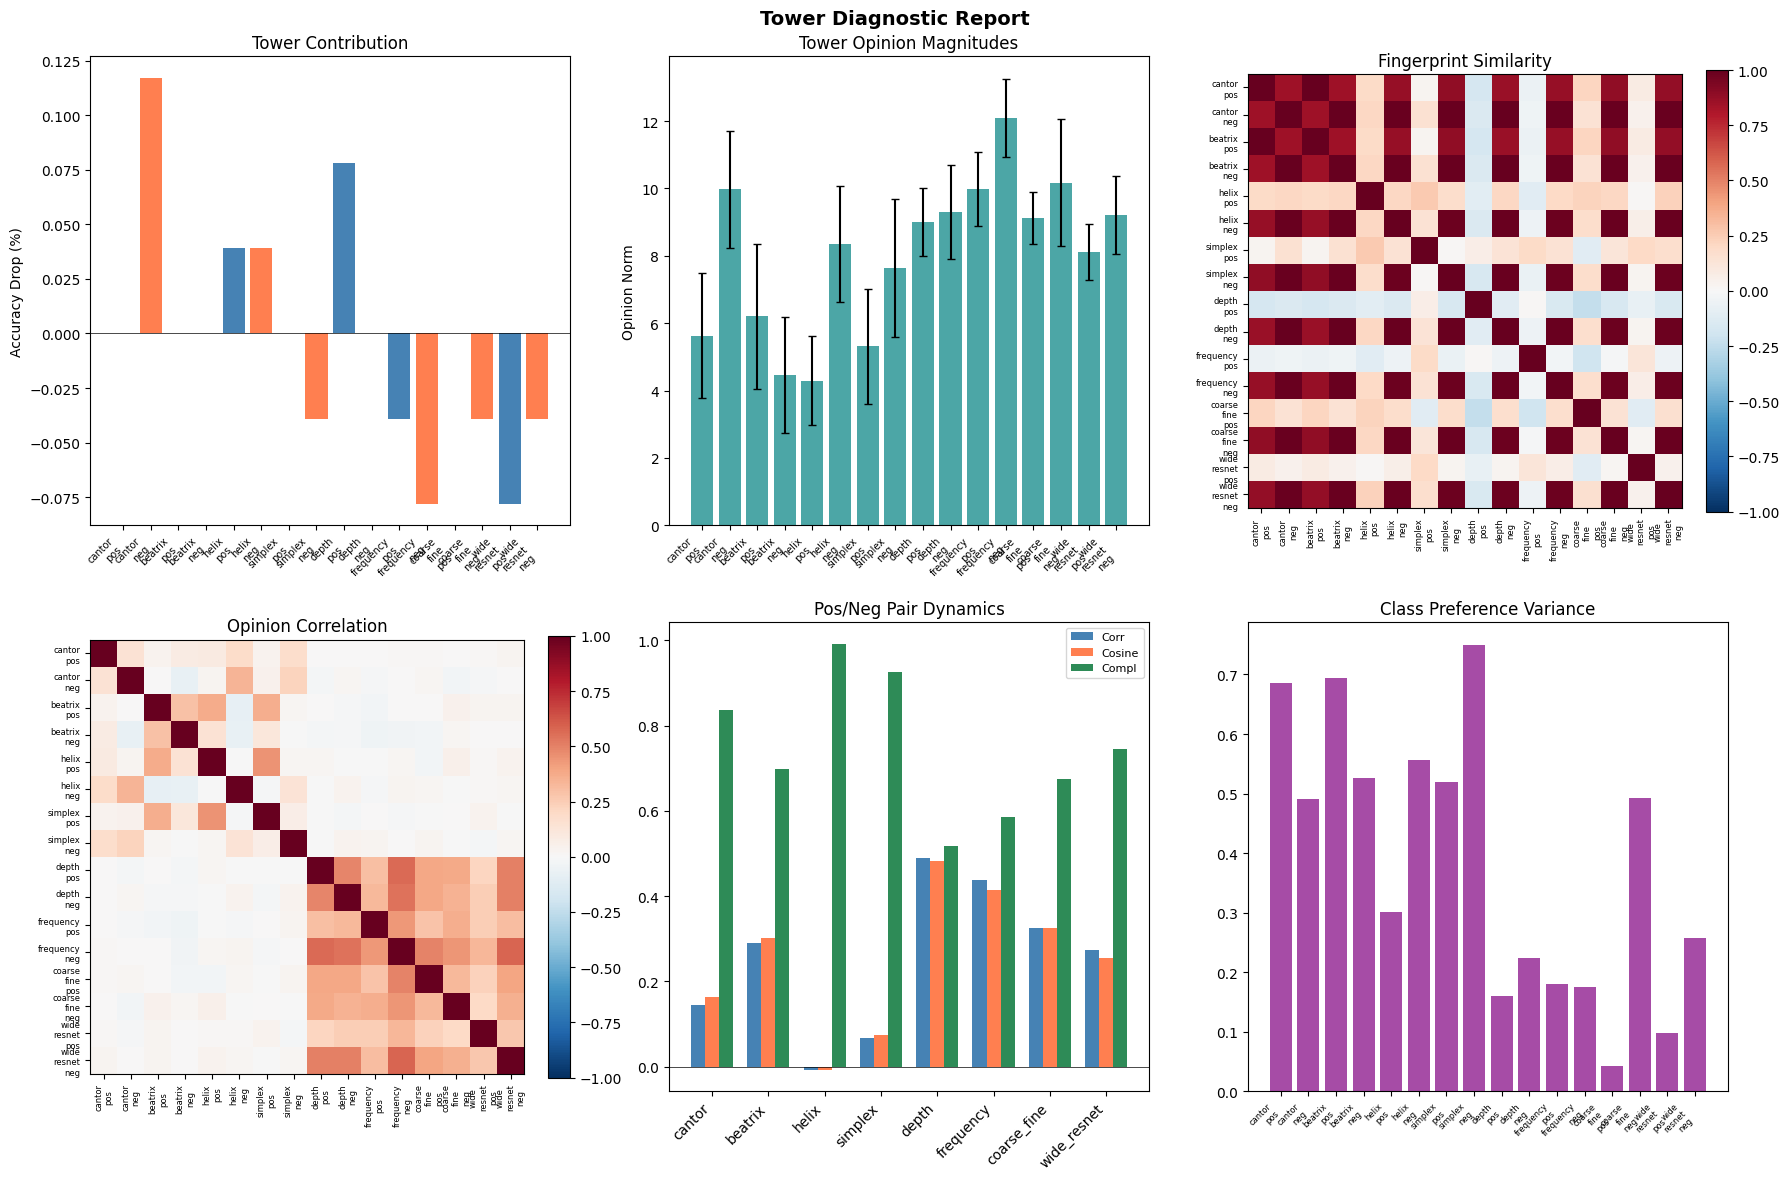

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter-based collectives from tower builders for compile-optimized execution.
Integrates EncoderDataComponent for staged caching with VRAM management.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  ConfigurableCollective (WideRouter)
    │  8 ConfigurableTowers → Fusion    │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  ConvTowerCollective (WideRouter) │
    │  8 ConfigurableConvTowers → Fusion│
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier

Caching Workflow:
    1. VisionCacher loads encoder → caches all images → unloads encoder
    2. Training uses only cached latents (no vision encoder in VRAM)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass, field
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.

        Workflow:
        - Load encoder to VRAM
        - Encode all images
        - Save to disk
        - Unload encoder (free VRAM for training)
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            # Use MultiVisionEncode for registry models
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            # Save and unload
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            # Direct HuggingFace loading for custom models
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents + labels."""

    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        # Graph break here is fine - avoids recompiles when dropout changes
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """
    Bidirectional dropout schedule with LR snaps.

    Phase 1 (high LR=0.1): Increase dropout to force standalone learning
        - WARMUP:  E01-E03 (scale 0→1)
        - PREP:    E04-E06 (full expert, no dropout)
        - STRESS:  E07-E09 (dropout 0→0.85, high LR)

    Phase 2 (low LR=0.001): Decrease dropout to refine with expert
        - REFINE:  E10-E14 (dropout 0.85→0.2)

    Phase 3 (ultra low LR=0.0001): Polish with minimal dropout
        - POLISH:  E15-E24 (dropout 0.1, ultra low LR)
    """

    def __init__(
        self,
        warmup: int = 3,
        prep: int = 3,
        stress: int = 3,
        refine: int = 5,
        polish: int = 10,
        max_dropout: float = 0.85,
        min_dropout: float = 0.2,
        polish_dropout: float = 0.1,
        high_lr: float = 0.1,
        low_lr: float = 0.001,
        polish_lr: float = 0.0001,
    ):
        self.warmup = warmup
        self.prep_end = warmup + prep
        self.stress_end = self.prep_end + stress
        self.refine_end = self.stress_end + refine
        self.polish_end = self.refine_end + polish

        self.max_dropout = max_dropout
        self.min_dropout = min_dropout
        self.polish_dropout = polish_dropout
        self.high_lr = high_lr
        self.low_lr = low_lr
        self.polish_lr = polish_lr

    def __call__(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout)."""
        if epoch < self.warmup:
            scale = (epoch + 1) / self.warmup
            return scale, 0.0

        elif epoch < self.prep_end:
            return 1.0, 0.0

        elif epoch < self.stress_end:
            progress = (epoch - self.prep_end) / (self.stress_end - self.prep_end)
            dropout = progress * self.max_dropout
            return 1.0, dropout

        elif epoch < self.refine_end:
            progress = (epoch - self.stress_end) / (self.refine_end - self.stress_end)
            dropout = self.max_dropout - progress * (self.max_dropout - self.min_dropout)
            return 1.0, dropout

        else:
            # POLISH: low dropout, ultra low LR
            return 1.0, self.polish_dropout

    def get_lr(self, epoch: int) -> float:
        """Get learning rate for epoch."""
        if epoch < self.stress_end:
            return self.high_lr
        elif epoch < self.refine_end:
            return self.low_lr
        else:
            return self.polish_lr

    def phase_name(self, epoch: int) -> str:
        """Get phase name for logging."""
        scale, drop = self(epoch)
        if epoch < self.warmup:
            return f"WARM s={scale:.2f}"
        elif epoch < self.prep_end:
            return "PREP"
        elif epoch < self.stress_end:
            return f"STRESS d={drop:.2f}"
        elif epoch < self.refine_end:
            return f"REFINE d={drop:.2f}"
        else:
            return f"POLISH d={drop:.2f}"


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives from tower builders.

    Dual-head architecture:
    - Main head: trans + conv + expert → full power classification
    - Standalone head: trans + conv only → forces tower learning

    Both heads trained simultaneously to ensure towers learn real features.
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 4 patches per side for CIFAR

        self.objects['config'] = {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
            'expert_dim': expert_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter from builder) ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])
        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter from builder) ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === DUAL HEADS ===
        # Main: trans + conv + expert = 3 * dim
        self.attach('classifier', ClassifierHead(f'{name}_head', dim * 3, num_classes, dim))
        # Standalone: trans + conv = 2 * dim → 8000 hidden (massive capacity)
        self.attach('standalone_head', ClassifierHead(f'{name}_standalone', dim * 2, num_classes, 8000))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tuple[Tensor, Tensor]:
        # Patch embed: [B, 3, 32, 32] -> [B, L, D]
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused  # [B, D]

        # Conv collective (WideRouter)
        conv_fused, _ = self['conv_collective'](x)  # [B, D]

        # Expert pathway
        expert = self['expert'](expert_latents)  # [B, D]

        # Main classifier: all three
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        logits = self['classifier'](combined)

        # Standalone classifier: towers only (no expert)
        standalone = torch.cat([trans_fused, conv_fused], dim=-1)
        standalone_logits = self['standalone_head'](standalone)

        return logits, standalone_logits

    def forward_standalone(self, images: Tensor) -> Tensor:
        """Forward using only towers (no expert) for evaluation."""
        x = self['patch_embed'](images)

        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused

        conv_fused, _ = self['conv_collective'](x)

        standalone = torch.cat([trans_fused, conv_fused], dim=-1)
        return self['standalone_head'](standalone)

    def prepare_and_compile(self, **compile_kwargs) -> 'CIFARHybridRouter':
        """Prepare collectives and compile the router."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False, standalone_weight=0.5):
    router.train()
    scale, drop = sched(epoch)
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, correct_standalone, total = 0, 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        opt.zero_grad()

        # Dual outputs
        logits, standalone_logits = router(img, exp)

        # Combined loss: main + weighted standalone
        main_loss = F.cross_entropy(logits, lbl)
        standalone_loss = F.cross_entropy(standalone_logits, lbl)
        loss = main_loss + standalone_weight * standalone_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        correct_standalone += standalone_logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            acc=f'{100*correct/total:.1f}%',
            solo=f'{100*correct_standalone/total:.1f}%'
        )

    return total_loss / total, 100 * correct / total, 100 * correct_standalone / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        logits, _ = router(img, exp)  # Main head
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


@torch.no_grad()
def evaluate_standalone(router, loader, device, is_compiled=False):
    """Evaluate using only the standalone head (no expert)."""
    router.eval()
    base = router._orig_mod if is_compiled else router

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, lbl = img.to(device), lbl.to(device)
        # Get both outputs, use standalone
        _, standalone_logits = router(img, exp.to(device))
        correct += standalone_logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# TOWER DIAGNOSTICS
# =============================================================================

@dataclass
class TowerStats:
    """Statistics for a single tower."""
    name: str
    opinion_norm_mean: float = 0.0
    opinion_norm_std: float = 0.0
    opinion_var: float = 0.0
    fingerprint: Optional[Tensor] = None
    fusion_weight_mean: float = 0.0
    ablation_accuracy: float = 0.0
    contribution_score: float = 0.0


@dataclass
class PairStats:
    """Statistics for a pos/neg tower pair."""
    pos_name: str
    neg_name: str
    opinion_correlation: float = 0.0
    opinion_cosine: float = 0.0
    complementarity: float = 0.0
    combined_norm: float = 0.0


@dataclass
class DiagnosticReport:
    """Complete diagnostic report."""
    tower_stats: Dict[str, TowerStats] = field(default_factory=dict)
    pair_stats: List[PairStats] = field(default_factory=list)
    fingerprint_similarity_matrix: Optional[Tensor] = None
    tower_correlation_matrix: Optional[Tensor] = None
    fusion_weights: Optional[Tensor] = None
    class_tower_preferences: Optional[Tensor] = None
    full_accuracy: float = 0.0
    per_tower_ablation: Dict[str, float] = field(default_factory=dict)


class TowerDiagnostics:
    """Comprehensive tower diagnostic analyzer."""

    def __init__(self, router, loader, device, is_compiled=False):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def collect_opinions(self, max_batches: int = 50) -> Dict:
        self.router.eval()
        self.base.set_expert_schedule(1.0, 0.0)

        trans_opinions = defaultdict(list)
        conv_opinions = defaultdict(list)
        labels_all = []
        fusion_weights_all = []

        for i, (img, exp, lbl) in enumerate(self.loader):
            if i >= max_batches:
                break
            img, exp, lbl = img.to(self.device), exp.to(self.device), lbl.to(self.device)
            x = self.base['patch_embed'](img)

            trans_out = self.base['trans_collective'](x)
            for name, top in trans_out.opinions.items():
                trans_opinions[name].append(top.opinion.cpu())
            if trans_out.weights is not None:
                fusion_weights_all.append(trans_out.weights.cpu())

            conv_fused, conv_ops = self.base['conv_collective'](x)
            for name, op in conv_ops.items():
                conv_opinions[name].append(op.cpu())
            labels_all.append(lbl.cpu())

        return {
            'trans': {k: torch.cat(v, dim=0) for k, v in trans_opinions.items()},
            'conv': {k: torch.cat(v, dim=0) for k, v in conv_opinions.items()},
            'labels': torch.cat(labels_all, dim=0),
            'fusion_weights': torch.cat(fusion_weights_all, dim=0) if fusion_weights_all else None,
        }

    def analyze_tower_stats(self, opinions: Dict[str, Tensor]) -> Dict[str, TowerStats]:
        stats = {}
        for name, op in opinions.items():
            norms = op.norm(dim=-1)
            stats[name] = TowerStats(
                name=name,
                opinion_norm_mean=norms.mean().item(),
                opinion_norm_std=norms.std().item(),
                opinion_var=op.var(dim=0).mean().item(),
            )
        return stats

    def analyze_fingerprints(self) -> Tuple[Dict[str, Tensor], Tensor, List[str]]:
        fingerprints = {}
        for name in self.base['trans_collective'].tower_names:
            fingerprints[name] = self.base['trans_collective'][name].fingerprint.detach().cpu()
        for name in self.base['conv_collective'].tower_names:
            fingerprints[name] = self.base['conv_collective'][name].fingerprint.detach().cpu()

        names = list(fingerprints.keys())
        fps = torch.stack([fingerprints[name] for name in names])
        fps = F.normalize(fps, dim=-1)
        sim_matrix = fps @ fps.T
        return fingerprints, sim_matrix, names

    def analyze_pairs(self, opinions: Dict[str, Tensor]) -> List[PairStats]:
        pairs = []
        for pos_name in [n for n in opinions.keys() if '_pos' in n]:
            neg_name = pos_name.replace('_pos', '_neg')
            if neg_name not in opinions:
                continue
            pos_op, neg_op = opinions[pos_name], opinions[neg_name]
            pos_flat, neg_flat = pos_op.reshape(-1), neg_op.reshape(-1)
            pos_c, neg_c = pos_flat - pos_flat.mean(), neg_flat - neg_flat.mean()
            corr = (pos_c * neg_c).sum() / (pos_c.norm() * neg_c.norm() + 1e-8)
            cosine = F.cosine_similarity(pos_op, neg_op, dim=-1).mean()
            pairs.append(PairStats(
                pos_name=pos_name, neg_name=neg_name,
                opinion_correlation=corr.item(), opinion_cosine=cosine.item(),
                complementarity=(1.0 - cosine.abs()).item(),
                combined_norm=(pos_op + neg_op).norm(dim=-1).mean().item(),
            ))
        return pairs

    def compute_tower_correlations(self, opinions: Dict[str, Tensor]) -> Tuple[Tensor, List[str]]:
        names = list(opinions.keys())
        ops = torch.stack([opinions[name] for name in names])
        ops_flat = ops.reshape(len(names), -1)
        ops_c = ops_flat - ops_flat.mean(dim=1, keepdim=True)
        norms = ops_c.norm(dim=1, keepdim=True)
        return (ops_c @ ops_c.T) / (norms @ norms.T + 1e-8), names

    def analyze_class_preferences(self, opinions: Dict[str, Tensor], labels: Tensor, num_classes: int = 100):
        names = list(opinions.keys())
        ops = torch.stack([opinions[name] for name in names], dim=1)
        norms = ops.norm(dim=-1)
        class_prefs = torch.zeros(num_classes, len(names))
        class_counts = torch.zeros(num_classes)
        for i, lbl in enumerate(labels):
            class_prefs[lbl] += norms[i]
            class_counts[lbl] += 1
        return class_prefs / (class_counts.unsqueeze(1) + 1e-8), names

    @torch.no_grad()
    def ablation_study(self, max_batches: int = 20) -> Dict[str, float]:
        self.router.eval()
        self.base.set_expert_schedule(1.0, 0.0)
        all_towers = list(self.base['trans_collective'].tower_names) + list(self.base['conv_collective'].tower_names)

        total, correct_full = 0, 0
        correct_ablated = {name: 0 for name in all_towers}

        for i, (img, exp, lbl) in enumerate(self.loader):
            if i >= max_batches:
                break
            img, exp, lbl = img.to(self.device), exp.to(self.device), lbl.to(self.device)
            total += lbl.size(0)

            logits, _ = self.router(img, exp)
            correct_full += logits.argmax(1).eq(lbl).sum().item()

            x = self.base['patch_embed'](img)
            trans_out = self.base['trans_collective'](x)
            conv_fused, conv_ops = self.base['conv_collective'](x)
            expert = self.base['expert'](exp)

            for ablate_name in all_towers:
                trans_mod = [torch.zeros_like(trans_out.opinions[n].opinion) if n == ablate_name
                            else trans_out.opinions[n].opinion for n in self.base['trans_collective'].tower_names]
                conv_mod = [torch.zeros_like(conv_ops[n]) if n == ablate_name
                           else conv_ops[n] for n in self.base['conv_collective'].tower_names]
                trans_fused = self.base['trans_collective']['fusion'](*trans_mod)
                conv_fused_m = self.base['conv_collective']['fusion'](*conv_mod)
                logits_m = self.base['classifier'](torch.cat([trans_fused, conv_fused_m, expert], dim=-1))
                correct_ablated[ablate_name] += logits_m.argmax(1).eq(lbl).sum().item()

        results = {'full': 100 * correct_full / total}
        results.update({n: 100 * correct_ablated[n] / total for n in all_towers})
        return results

    def full_analysis(self, max_batches: int = 50) -> DiagnosticReport:
        print("Collecting tower opinions...")
        data = self.collect_opinions(max_batches)
        all_opinions = {**data['trans'], **data['conv']}

        print("Analyzing tower statistics...")
        tower_stats = self.analyze_tower_stats(all_opinions)

        print("Analyzing fingerprints...")
        fingerprints, fp_sim_matrix, fp_names = self.analyze_fingerprints()
        for name, fp in fingerprints.items():
            if name in tower_stats:
                tower_stats[name].fingerprint = fp

        print("Analyzing pos/neg pairs...")
        pair_stats = self.analyze_pairs(all_opinions)

        print("Computing tower correlations...")
        corr_matrix, _ = self.compute_tower_correlations(all_opinions)

        print("Analyzing class preferences...")
        class_prefs, _ = self.analyze_class_preferences(all_opinions, data['labels'])

        print("Running ablation study...")
        ablation = self.ablation_study(max_batches=20)

        full_acc = ablation['full']
        for name, stats in tower_stats.items():
            if name in ablation:
                stats.ablation_accuracy = ablation[name]
                stats.contribution_score = full_acc - ablation[name]

        if data['fusion_weights'] is not None:
            fw_mean = data['fusion_weights'].mean(dim=0)
            for i, name in enumerate(self.base['trans_collective'].tower_names):
                if name in tower_stats:
                    tower_stats[name].fusion_weight_mean = fw_mean[i].item()

        return DiagnosticReport(
            tower_stats=tower_stats, pair_stats=pair_stats,
            fingerprint_similarity_matrix=fp_sim_matrix,
            tower_correlation_matrix=corr_matrix,
            fusion_weights=data['fusion_weights'].mean(dim=0) if data['fusion_weights'] is not None else None,
            class_tower_preferences=class_prefs,
            full_accuracy=full_acc, per_tower_ablation=ablation,
        )

    def print_report(self, report: DiagnosticReport):
        print("\n" + "=" * 80)
        print("TOWER DIAGNOSTIC REPORT")
        print("=" * 80)

        print(f"\n{'='*40}\nOVERALL ACCURACY\n{'='*40}")
        print(f"Full model: {report.full_accuracy:.2f}%")

        print(f"\n{'='*40}\nPER-TOWER STATISTICS\n{'='*40}")
        print(f"{'Tower':<20} {'Norm μ':>8} {'Norm σ':>8} {'Var':>8} {'Contrib':>8} {'Ablated':>8}")
        print("-" * 72)
        for ts in sorted(report.tower_stats.values(), key=lambda x: x.contribution_score, reverse=True):
            print(f"{ts.name:<20} {ts.opinion_norm_mean:>8.3f} {ts.opinion_norm_std:>8.3f} "
                  f"{ts.opinion_var:>8.4f} {ts.contribution_score:>+7.2f}% {ts.ablation_accuracy:>7.2f}%")

        print(f"\n{'='*40}\nPOS/NEG PAIR DYNAMICS\n{'='*40}")
        print(f"{'Pair':<25} {'Corr':>8} {'Cosine':>8} {'Compl':>8} {'CombNorm':>8}")
        print("-" * 65)
        for ps in report.pair_stats:
            print(f"{ps.pos_name.replace('_pos', ''):<25} {ps.opinion_correlation:>8.3f} {ps.opinion_cosine:>8.3f} "
                  f"{ps.complementarity:>8.3f} {ps.combined_norm:>8.3f}")

        if report.fusion_weights is not None:
            print(f"\n{'='*40}\nFUSION WEIGHTS (Transformer)\n{'='*40}")
            for i, name in enumerate(self.base['trans_collective'].tower_names):
                w = report.fusion_weights[i].item()
                print(f"{name:<20} {w:.3f} {'█' * int(w * 50)}")

        print(f"\n{'='*40}\nTOP 5 CONTRIBUTORS\n{'='*40}")
        contrib = sorted([(n, report.full_accuracy - a) for n, a in report.per_tower_ablation.items() if n != 'full'],
                        key=lambda x: x[1], reverse=True)[:5]
        for name, drop in contrib:
            print(f"{name:<20} -{drop:.2f}% when removed")

        print(f"\n{'='*40}\nPOTENTIALLY REDUNDANT\n{'='*40}")
        redundant = [(n, report.full_accuracy - a) for n, a in report.per_tower_ablation.items()
                     if n != 'full' and abs(report.full_accuracy - a) < 0.1]
        if redundant:
            for name, drop in redundant:
                print(f"{name:<20} {drop:+.2f}% (negligible)")
        else:
            print("None - all towers contribute")

        print(f"\n{'='*40}\nFINGERPRINT SIMILARITY\n{'='*40}")
        fp_sim = report.fingerprint_similarity_matrix
        fp_names = list(self.base['trans_collective'].tower_names) + list(self.base['conv_collective'].tower_names)
        sims = [(fp_names[i], fp_names[j], fp_sim[i, j].item())
                for i in range(len(fp_names)) for j in range(i+1, len(fp_names))]
        sims.sort(key=lambda x: x[2], reverse=True)
        print("Most similar:")
        for n1, n2, s in sims[:5]:
            print(f"  {n1:<18} <-> {n2:<18} : {s:.3f}")
        print("Most different:")
        for n1, n2, s in sims[-5:]:
            print(f"  {n1:<18} <-> {n2:<18} : {s:.3f}")
        print("=" * 80)

    def plot_report(self, report: DiagnosticReport, save_path: str = None):
        import matplotlib.pyplot as plt
        import numpy as np

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Tower Diagnostic Report', fontsize=14, fontweight='bold')

        fp_names = list(self.base['trans_collective'].tower_names) + list(self.base['conv_collective'].tower_names)

        # 1. Tower Contribution
        ax = axes[0, 0]
        names = [n.replace('_', '\n') for n in report.per_tower_ablation.keys() if n != 'full']
        contribs = [report.full_accuracy - a for n, a in report.per_tower_ablation.items() if n != 'full']
        colors = ['steelblue' if '_pos' in n else 'coral' for n in report.per_tower_ablation.keys() if n != 'full']
        ax.bar(range(len(names)), contribs, color=colors)
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels(names, fontsize=7, rotation=45, ha='right')
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_ylabel('Accuracy Drop (%)')
        ax.set_title('Tower Contribution')

        # 2. Opinion Norms
        ax = axes[0, 1]
        norms = [ts.opinion_norm_mean for ts in report.tower_stats.values()]
        stds = [ts.opinion_norm_std for ts in report.tower_stats.values()]
        ax.bar(range(len(norms)), norms, yerr=stds, capsize=3, color='teal', alpha=0.7)
        ax.set_xticks(range(len(norms)))
        ax.set_xticklabels([ts.name.replace('_', '\n') for ts in report.tower_stats.values()], fontsize=7, rotation=45, ha='right')
        ax.set_ylabel('Opinion Norm')
        ax.set_title('Tower Opinion Magnitudes')

        # 3. Fingerprint Similarity
        ax = axes[0, 2]
        im = ax.imshow(report.fingerprint_similarity_matrix.numpy(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(fp_names)))
        ax.set_yticks(range(len(fp_names)))
        ax.set_xticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6, rotation=90)
        ax.set_yticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6)
        ax.set_title('Fingerprint Similarity')
        plt.colorbar(im, ax=ax, fraction=0.046)

        # 4. Opinion Correlation
        ax = axes[1, 0]
        im = ax.imshow(report.tower_correlation_matrix.numpy(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(fp_names)))
        ax.set_yticks(range(len(fp_names)))
        ax.set_xticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6, rotation=90)
        ax.set_yticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6)
        ax.set_title('Opinion Correlation')
        plt.colorbar(im, ax=ax, fraction=0.046)

        # 5. Pos/Neg Pair Dynamics
        ax = axes[1, 1]
        pair_names = [ps.pos_name.replace('_pos', '') for ps in report.pair_stats]
        x = np.arange(len(pair_names))
        ax.bar(x - 0.25, [ps.opinion_correlation for ps in report.pair_stats], 0.25, label='Corr', color='steelblue')
        ax.bar(x, [ps.opinion_cosine for ps in report.pair_stats], 0.25, label='Cosine', color='coral')
        ax.bar(x + 0.25, [ps.complementarity for ps in report.pair_stats], 0.25, label='Compl', color='seagreen')
        ax.set_xticks(x)
        ax.set_xticklabels(pair_names, rotation=45, ha='right')
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_title('Pos/Neg Pair Dynamics')
        ax.legend(fontsize=8)

        # 6. Fusion Weights or Class Variance
        ax = axes[1, 2]
        if report.fusion_weights is not None:
            trans_names = list(self.base['trans_collective'].tower_names)
            colors = ['steelblue' if '_pos' in n else 'coral' for n in trans_names]
            ax.barh(range(len(trans_names)), report.fusion_weights.numpy(), color=colors)
            ax.set_yticks(range(len(trans_names)))
            ax.set_yticklabels(trans_names, fontsize=8)
            ax.set_title('Fusion Weights')
            ax.invert_yaxis()
        else:
            var = report.class_tower_preferences.var(dim=0).numpy()
            ax.bar(range(len(fp_names)), var, color='purple', alpha=0.7)
            ax.set_xticks(range(len(fp_names)))
            ax.set_xticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6, rotation=45, ha='right')
            ax.set_title('Class Preference Variance')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        return fig


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter Collectives)")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 24  # 3 warmup + 3 prep + 3 stress + 5 refine + 10 polish
    DIM = 256
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Vision encoder for expert pathway
    VISION_ENCODER = 'dinov3_convnext_large'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision encoder: {VISION_ENCODER}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features (model unloaded after caching)
    cacher = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    expert_dim = cacher.dim
    print(f"Expert dim: {expert_dim}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM, expert_dim=expert_dim)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")

    if COMPILE:
        print("\nCompiling router with WideRouter optimizations...")
        router = router.prepare_and_compile(mode='reduce-overhead')
        print("Compilation complete")

    # SGD with momentum
    model_params = router._orig_mod.parameters() if COMPILE else router.parameters()
    HIGH_LR = 0.1
    LOW_LR = 0.001
    POLISH_LR = 0.0001
    opt = torch.optim.SGD(model_params, lr=HIGH_LR, momentum=0.9, weight_decay=1e-4)

    # Tight schedule with polish phase
    sched = ExpertScheduler(
        warmup=3,
        prep=3,
        stress=3,
        refine=5,
        polish=10,        # 10 more epochs to polish
        max_dropout=0.85,
        min_dropout=0.2,
        polish_dropout=0.1,  # Low dropout for polish
        high_lr=HIGH_LR,
        low_lr=LOW_LR,
        polish_lr=POLISH_LR,
    )

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={HIGH_LR}, momentum=0.9)")
    print(f"Dual-head: main (256 hidden) + standalone (8000 hidden), weight=0.5")
    print(f"Schedule:")
    print(f"  WARMUP:  E01-E{sched.warmup:02d}")
    print(f"  PREP:    E{sched.warmup+1:02d}-E{sched.prep_end:02d}")
    print(f"  STRESS:  E{sched.prep_end+1:02d}-E{sched.stress_end:02d} (dropout 0→{sched.max_dropout}, LR={HIGH_LR})")
    print(f"  REFINE:  E{sched.stress_end+1:02d}-E{sched.refine_end:02d} (dropout {sched.max_dropout}→{sched.min_dropout}, LR={LOW_LR})")
    if EPOCHS > sched.refine_end:
        print(f"  POLISH:  E{sched.refine_end+1:02d}-E{min(EPOCHS, sched.polish_end):02d} (dropout={sched.polish_dropout}, LR={POLISH_LR})")
    print(f"Markers: * = best main, ^ = best standalone")
    print("-" * 70)

    best = 0
    best_standalone = 0
    current_lr = HIGH_LR

    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        # LR snap at phase transitions
        new_lr = sched.get_lr(epoch)
        if new_lr != current_lr:
            print(f"\n*** LR SNAP: {current_lr:.4f} → {new_lr:.4f} ***\n")
            for pg in opt.param_groups:
                pg['lr'] = new_lr
            current_lr = new_lr

        loss, train_acc, train_solo = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)
        test_solo = evaluate_standalone(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        solo_marker = " ^" if test_solo > best_standalone else ""
        best = max(best, test_acc)
        best_standalone = max(best_standalone, test_solo)

        phase = sched.phase_name(epoch)

        print(f"E{epoch+1:02d} | {phase:14s} | lr={current_lr:.4f} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | solo={test_solo:.1f}%{solo_marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)

    # Test main head with full expert
    base = router._orig_mod if COMPILE else router
    base.set_expert_schedule(1.0, 0.0)
    final_main = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test standalone head (towers only - the whole point!)
    final_standalone = evaluate_standalone(router, test_loader, DEVICE, is_compiled=COMPILE)

    print(f"Best main: {best:.2f}%")
    print(f"Best standalone: {best_standalone:.2f}%")
    print(f"Final main (w/ expert): {final_main:.2f}%")
    print(f"Final standalone (towers only): {final_standalone:.2f}%")
    print(f"Tower retention: {final_standalone/final_main*100:.1f}%")

    # === RUN DIAGNOSTICS ===
    print("\n" + "=" * 70)
    print("RUNNING TOWER DIAGNOSTICS")
    print("=" * 70)

    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=COMPILE)
    report = diag.full_analysis(max_batches=50)
    diag.print_report(report)

    # Save plot
    try:
        fig = diag.plot_report(report, save_path='/mnt/user-data/outputs/tower_diagnostics.png')
        print("\nDiagnostic plot saved to /mnt/user-data/outputs/tower_diagnostics.png")
    except Exception as e:
        print(f"\nCould not generate plot: {e}")


if __name__ == '__main__':
    main()

# 12 transformer towers, 8 conv towers, sgd mega run

In [ ]:
"""
CIFAR-100 Hybrid Router (WideRouter Edition)
=============================================

Uses WideRouter-based collectives from tower builders for compile-optimized execution.
Integrates EncoderDataComponent for staged caching with VRAM management.

Architecture:
    Image → PatchEmbed → [B, L, D]
                ↓
    ┌───────────────────────────────────┐
    │  ConfigurableCollective (WideRouter)
    │  8 ConfigurableTowers → Fusion    │
    └───────────────────────────────────┘
                ↓
    ┌───────────────────────────────────┐
    │  ConvTowerCollective (WideRouter) │
    │  8 ConfigurableConvTowers → Fusion│
    └───────────────────────────────────┘
                ↓
    [trans_fused + conv_fused + expert] → classifier

Caching Workflow:
    1. VisionCacher loads encoder → caches all images → unloads encoder
    2. Training uses only cached latents (no vision encoder in VRAM)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass, field
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path
import time

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.

        Workflow:
        - Load encoder to VRAM
        - Encode all images
        - Save to disk
        - Unload encoder (free VRAM for training)
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            # Use MultiVisionEncode for registry models
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            # Save and unload
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            # Direct HuggingFace loading for custom models
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents + labels."""

    def __init__(self, base: Dataset, latents: Tensor):
        self.base = base
        self.latents = latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


class ExpertProj(TorchComponent):
    """Expert projection with curriculum scheduling."""

    def __init__(self, name: str, expert_dim: int, out_dim: int):
        super().__init__(name)
        self.norm = nn.LayerNorm(expert_dim)
        self.fc1 = nn.Linear(expert_dim, out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('dropout', torch.tensor(0.0))

    def set_schedule(self, scale: float, dropout: float):
        self.scale.fill_(scale)
        self.dropout.fill_(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.fc1(self.norm(x)))
        x = self.fc2(x)
        # Graph break here is fine - avoids recompiles when dropout changes
        if self.training and self.dropout > 0:
            mask = torch.bernoulli(torch.full_like(x, 1 - self.dropout.item()))
            x = x * mask / (1 - self.dropout.item() + 1e-8)
        return x * self.scale


class ClassifierHead(TorchComponent):
    """Classification head."""

    def __init__(self, name: str, in_dim: int, num_classes: int, hidden: int = None):
        super().__init__(name)
        hidden = hidden or in_dim // 3
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc2(self.drop(F.gelu(self.fc1(self.norm(x)))))


# =============================================================================
# EXPERT SCHEDULER
# =============================================================================

class ExpertScheduler:
    """
    Bidirectional dropout schedule with LR snaps.

    Phase 1 (high LR=0.1): Increase dropout to force standalone learning
        - WARMUP:  E01-E03 (scale 0→1)
        - PREP:    E04-E06 (full expert, no dropout)
        - STRESS:  E07-E09 (dropout 0→0.85, high LR)

    Phase 2 (low LR=0.001): Decrease dropout to refine with expert
        - REFINE:  E10-E14 (dropout 0.85→0.2)

    Phase 3 (ultra low LR=0.0001): Polish with minimal dropout
        - POLISH:  E15-E24 (dropout 0.1, ultra low LR)
    """

    def __init__(
        self,
        warmup: int = 3,
        prep: int = 3,
        stress: int = 3,
        refine: int = 5,
        polish: int = 10,
        max_dropout: float = 0.85,
        min_dropout: float = 0.2,
        polish_dropout: float = 0.1,
        high_lr: float = 0.1,
        low_lr: float = 0.001,
        polish_lr: float = 0.0001,
    ):
        self.warmup = warmup
        self.prep_end = warmup + prep
        self.stress_end = self.prep_end + stress
        self.refine_end = self.stress_end + refine
        self.polish_end = self.refine_end + polish

        self.max_dropout = max_dropout
        self.min_dropout = min_dropout
        self.polish_dropout = polish_dropout
        self.high_lr = high_lr
        self.low_lr = low_lr
        self.polish_lr = polish_lr

    def __call__(self, epoch: int) -> Tuple[float, float]:
        """Returns (scale, dropout)."""
        if epoch < self.warmup:
            scale = (epoch + 1) / self.warmup
            return scale, 0.0

        elif epoch < self.prep_end:
            return 1.0, 0.0

        elif epoch < self.stress_end:
            progress = (epoch - self.prep_end) / (self.stress_end - self.prep_end)
            dropout = progress * self.max_dropout
            return 1.0, dropout

        elif epoch < self.refine_end:
            progress = (epoch - self.stress_end) / (self.refine_end - self.stress_end)
            dropout = self.max_dropout - progress * (self.max_dropout - self.min_dropout)
            return 1.0, dropout

        else:
            # POLISH: low dropout, ultra low LR
            return 1.0, self.polish_dropout

    def get_lr(self, epoch: int) -> float:
        """Get learning rate for epoch."""
        if epoch < self.stress_end:
            return self.high_lr
        elif epoch < self.refine_end:
            return self.low_lr
        else:
            return self.polish_lr

    def phase_name(self, epoch: int) -> str:
        """Get phase name for logging."""
        scale, drop = self(epoch)
        if epoch < self.warmup:
            return f"WARM s={scale:.2f}"
        elif epoch < self.prep_end:
            return "PREP"
        elif epoch < self.stress_end:
            return f"STRESS d={drop:.2f}"
        elif epoch < self.refine_end:
            return f"REFINE d={drop:.2f}"
        else:
            return f"POLISH d={drop:.2f}"


# =============================================================================
# CIFAR HYBRID ROUTER
# =============================================================================

class CIFARHybridRouter(BaseRouter):
    """
    CIFAR-100 classifier using WideRouter collectives from tower builders.

    Dual-head architecture:
    - Main head: trans + conv + expert → full power classification
    - Standalone head: trans + conv only → forces tower learning

    Both heads trained simultaneously to ensure towers learn real features.
    """

    def __init__(
        self,
        name: str = 'cifar_hybrid',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size  # 4 patches per side for CIFAR

        self.objects['config'] = {
            'dim': dim,
            'patch_size': patch_size,
            'spatial': spatial,
            'num_classes': num_classes,
            'expert_dim': expert_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (WideRouter from builder) ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal'])

        # Add 4 unsupervised standard RoPE towers with theta scale offsets
        # These provide multi-scale frequency baselines without geometric structure
        theta_scales = [0.25, 0.5, 0.75, 1.0]
        for scale in theta_scales:
            trans_configs.append(TowerConfig(
                f'standard_{int(scale*100):03d}',
                rope='standard',
                address='standard',
                inverted=False,
                rope_params={'theta_scale': scale},
            ))

        trans_collective = build_tower_collective(
            configs=trans_configs,
            dim=dim,
            default_depth=trans_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (WideRouter from builder) ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs,
            dim=dim,
            default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim,
            spatial_size=spatial,
            name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT ===
        self.attach('expert', ExpertProj(f'{name}_expert', expert_dim, dim))

        # === DUAL HEADS ===
        # Main: trans + conv + expert = 3 * dim
        self.attach('classifier', ClassifierHead(f'{name}_head', dim * 3, num_classes, dim))
        # Standalone: trans + conv = 2 * dim → 8000 hidden (massive capacity)
        self.attach('standalone_head', ClassifierHead(f'{name}_standalone', dim * 2, num_classes, 8000))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    def set_expert_schedule(self, scale: float, dropout: float):
        self['expert'].set_schedule(scale, dropout)

    def forward(self, images: Tensor, expert_latents: Tensor) -> Tuple[Tensor, Tensor]:
        # Patch embed: [B, 3, 32, 32] -> [B, L, D]
        x = self['patch_embed'](images)

        # Transformer collective (WideRouter)
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused  # [B, D]

        # Conv collective (WideRouter)
        conv_fused, _ = self['conv_collective'](x)  # [B, D]

        # Expert pathway
        expert = self['expert'](expert_latents)  # [B, D]

        # Main classifier: all three
        combined = torch.cat([trans_fused, conv_fused, expert], dim=-1)
        logits = self['classifier'](combined)

        # Standalone classifier: towers only (no expert)
        standalone = torch.cat([trans_fused, conv_fused], dim=-1)
        standalone_logits = self['standalone_head'](standalone)

        return logits, standalone_logits

    def forward_standalone(self, images: Tensor) -> Tensor:
        """Forward using only towers (no expert) for evaluation."""
        x = self['patch_embed'](images)

        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused

        conv_fused, _ = self['conv_collective'](x)

        standalone = torch.cat([trans_fused, conv_fused], dim=-1)
        return self['standalone_head'](standalone)

    def prepare_and_compile(self, **compile_kwargs) -> 'CIFARHybridRouter':
        """Prepare collectives and compile the router."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, epoch, sched, is_compiled=False, standalone_weight=0.5):
    router.train()
    scale, drop = sched(epoch)
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(scale, drop)

    total_loss, correct, correct_standalone, total = 0, 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

    for img, exp, lbl in pbar:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        opt.zero_grad()

        # Dual outputs
        logits, standalone_logits = router(img, exp)

        # Combined loss: main + weighted standalone
        main_loss = F.cross_entropy(logits, lbl)
        standalone_loss = F.cross_entropy(standalone_logits, lbl)
        loss = main_loss + standalone_weight * standalone_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        correct_standalone += standalone_logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            acc=f'{100*correct/total:.1f}%',
            solo=f'{100*correct_standalone/total:.1f}%'
        )

    return total_loss / total, 100 * correct / total, 100 * correct_standalone / total


@torch.no_grad()
def evaluate(router, loader, device, expert_on=True, is_compiled=False):
    router.eval()
    base = router._orig_mod if is_compiled else router
    base.set_expert_schedule(1.0 if expert_on else 0.0, 0.0 if expert_on else 1.0)

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
        logits, _ = router(img, exp)  # Main head
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


@torch.no_grad()
def evaluate_standalone(router, loader, device, is_compiled=False):
    """Evaluate using only the standalone head (no expert)."""
    router.eval()
    base = router._orig_mod if is_compiled else router

    correct, total = 0, 0
    for img, exp, lbl in loader:
        img, lbl = img.to(device), lbl.to(device)
        # Get both outputs, use standalone
        _, standalone_logits = router(img, exp.to(device))
        correct += standalone_logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# TOWER DIAGNOSTICS
# =============================================================================

@dataclass
class TowerStats:
    """Statistics for a single tower."""
    name: str
    opinion_norm_mean: float = 0.0
    opinion_norm_std: float = 0.0
    opinion_var: float = 0.0
    fingerprint: Optional[Tensor] = None
    fusion_weight_mean: float = 0.0
    ablation_accuracy: float = 0.0
    contribution_score: float = 0.0


@dataclass
class PairStats:
    """Statistics for a pos/neg tower pair."""
    pos_name: str
    neg_name: str
    opinion_correlation: float = 0.0
    opinion_cosine: float = 0.0
    complementarity: float = 0.0
    combined_norm: float = 0.0


@dataclass
class DiagnosticReport:
    """Complete diagnostic report."""
    tower_stats: Dict[str, TowerStats] = field(default_factory=dict)
    pair_stats: List[PairStats] = field(default_factory=list)
    fingerprint_similarity_matrix: Optional[Tensor] = None
    tower_correlation_matrix: Optional[Tensor] = None
    fusion_weights: Optional[Tensor] = None
    class_tower_preferences: Optional[Tensor] = None
    full_accuracy: float = 0.0
    per_tower_ablation: Dict[str, float] = field(default_factory=dict)


class TowerDiagnostics:
    """Comprehensive tower diagnostic analyzer."""

    def __init__(self, router, loader, device, is_compiled=False):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def collect_opinions(self, max_batches: int = 50) -> Dict:
        self.router.eval()
        self.base.set_expert_schedule(1.0, 0.0)

        trans_opinions = defaultdict(list)
        conv_opinions = defaultdict(list)
        labels_all = []
        fusion_weights_all = []

        for i, (img, exp, lbl) in enumerate(self.loader):
            if i >= max_batches:
                break
            img, exp, lbl = img.to(self.device), exp.to(self.device), lbl.to(self.device)
            x = self.base['patch_embed'](img)

            trans_out = self.base['trans_collective'](x)
            for name, top in trans_out.opinions.items():
                trans_opinions[name].append(top.opinion.cpu())
            if trans_out.weights is not None:
                fusion_weights_all.append(trans_out.weights.cpu())

            conv_fused, conv_ops = self.base['conv_collective'](x)
            for name, op in conv_ops.items():
                conv_opinions[name].append(op.cpu())
            labels_all.append(lbl.cpu())

        return {
            'trans': {k: torch.cat(v, dim=0) for k, v in trans_opinions.items()},
            'conv': {k: torch.cat(v, dim=0) for k, v in conv_opinions.items()},
            'labels': torch.cat(labels_all, dim=0),
            'fusion_weights': torch.cat(fusion_weights_all, dim=0) if fusion_weights_all else None,
        }

    def analyze_tower_stats(self, opinions: Dict[str, Tensor]) -> Dict[str, TowerStats]:
        stats = {}
        for name, op in opinions.items():
            norms = op.norm(dim=-1)
            stats[name] = TowerStats(
                name=name,
                opinion_norm_mean=norms.mean().item(),
                opinion_norm_std=norms.std().item(),
                opinion_var=op.var(dim=0).mean().item(),
            )
        return stats

    def analyze_fingerprints(self) -> Tuple[Dict[str, Tensor], Tensor, List[str]]:
        fingerprints = {}
        for name in self.base['trans_collective'].tower_names:
            fingerprints[name] = self.base['trans_collective'][name].fingerprint.detach().cpu()
        for name in self.base['conv_collective'].tower_names:
            fingerprints[name] = self.base['conv_collective'][name].fingerprint.detach().cpu()

        names = list(fingerprints.keys())
        fps = torch.stack([fingerprints[name] for name in names])
        fps = F.normalize(fps, dim=-1)
        sim_matrix = fps @ fps.T
        return fingerprints, sim_matrix, names

    def analyze_pairs(self, opinions: Dict[str, Tensor]) -> List[PairStats]:
        pairs = []
        for pos_name in [n for n in opinions.keys() if '_pos' in n]:
            neg_name = pos_name.replace('_pos', '_neg')
            if neg_name not in opinions:
                continue
            pos_op, neg_op = opinions[pos_name], opinions[neg_name]
            pos_flat, neg_flat = pos_op.reshape(-1), neg_op.reshape(-1)
            pos_c, neg_c = pos_flat - pos_flat.mean(), neg_flat - neg_flat.mean()
            corr = (pos_c * neg_c).sum() / (pos_c.norm() * neg_c.norm() + 1e-8)
            cosine = F.cosine_similarity(pos_op, neg_op, dim=-1).mean()
            pairs.append(PairStats(
                pos_name=pos_name, neg_name=neg_name,
                opinion_correlation=corr.item(), opinion_cosine=cosine.item(),
                complementarity=(1.0 - cosine.abs()).item(),
                combined_norm=(pos_op + neg_op).norm(dim=-1).mean().item(),
            ))
        return pairs

    def compute_tower_correlations(self, opinions: Dict[str, Tensor]) -> Tuple[Tensor, List[str]]:
        names = list(opinions.keys())
        ops = torch.stack([opinions[name] for name in names])
        ops_flat = ops.reshape(len(names), -1)
        ops_c = ops_flat - ops_flat.mean(dim=1, keepdim=True)
        norms = ops_c.norm(dim=1, keepdim=True)
        return (ops_c @ ops_c.T) / (norms @ norms.T + 1e-8), names

    def analyze_class_preferences(self, opinions: Dict[str, Tensor], labels: Tensor, num_classes: int = 100):
        names = list(opinions.keys())
        ops = torch.stack([opinions[name] for name in names], dim=1)
        norms = ops.norm(dim=-1)
        class_prefs = torch.zeros(num_classes, len(names))
        class_counts = torch.zeros(num_classes)
        for i, lbl in enumerate(labels):
            class_prefs[lbl] += norms[i]
            class_counts[lbl] += 1
        return class_prefs / (class_counts.unsqueeze(1) + 1e-8), names

    @torch.no_grad()
    def ablation_study(self, max_batches: int = 20) -> Dict[str, float]:
        self.router.eval()
        self.base.set_expert_schedule(1.0, 0.0)
        all_towers = list(self.base['trans_collective'].tower_names) + list(self.base['conv_collective'].tower_names)

        total, correct_full = 0, 0
        correct_ablated = {name: 0 for name in all_towers}

        for i, (img, exp, lbl) in enumerate(self.loader):
            if i >= max_batches:
                break
            img, exp, lbl = img.to(self.device), exp.to(self.device), lbl.to(self.device)
            total += lbl.size(0)

            logits, _ = self.router(img, exp)
            correct_full += logits.argmax(1).eq(lbl).sum().item()

            x = self.base['patch_embed'](img)
            trans_out = self.base['trans_collective'](x)
            conv_fused, conv_ops = self.base['conv_collective'](x)
            expert = self.base['expert'](exp)

            for ablate_name in all_towers:
                trans_mod = [torch.zeros_like(trans_out.opinions[n].opinion) if n == ablate_name
                            else trans_out.opinions[n].opinion for n in self.base['trans_collective'].tower_names]
                conv_mod = [torch.zeros_like(conv_ops[n]) if n == ablate_name
                           else conv_ops[n] for n in self.base['conv_collective'].tower_names]
                trans_fused = self.base['trans_collective']['fusion'](*trans_mod)
                conv_fused_m = self.base['conv_collective']['fusion'](*conv_mod)
                logits_m = self.base['classifier'](torch.cat([trans_fused, conv_fused_m, expert], dim=-1))
                correct_ablated[ablate_name] += logits_m.argmax(1).eq(lbl).sum().item()

        results = {'full': 100 * correct_full / total}
        results.update({n: 100 * correct_ablated[n] / total for n in all_towers})
        return results

    def full_analysis(self, max_batches: int = 50) -> DiagnosticReport:
        print("Collecting tower opinions...")
        data = self.collect_opinions(max_batches)
        all_opinions = {**data['trans'], **data['conv']}

        print("Analyzing tower statistics...")
        tower_stats = self.analyze_tower_stats(all_opinions)

        print("Analyzing fingerprints...")
        fingerprints, fp_sim_matrix, fp_names = self.analyze_fingerprints()
        for name, fp in fingerprints.items():
            if name in tower_stats:
                tower_stats[name].fingerprint = fp

        print("Analyzing pos/neg pairs...")
        pair_stats = self.analyze_pairs(all_opinions)

        print("Computing tower correlations...")
        corr_matrix, _ = self.compute_tower_correlations(all_opinions)

        print("Analyzing class preferences...")
        class_prefs, _ = self.analyze_class_preferences(all_opinions, data['labels'])

        print("Running ablation study...")
        ablation = self.ablation_study(max_batches=20)

        full_acc = ablation['full']
        for name, stats in tower_stats.items():
            if name in ablation:
                stats.ablation_accuracy = ablation[name]
                stats.contribution_score = full_acc - ablation[name]

        if data['fusion_weights'] is not None:
            fw_mean = data['fusion_weights'].mean(dim=0)
            for i, name in enumerate(self.base['trans_collective'].tower_names):
                if name in tower_stats:
                    tower_stats[name].fusion_weight_mean = fw_mean[i].item()

        return DiagnosticReport(
            tower_stats=tower_stats, pair_stats=pair_stats,
            fingerprint_similarity_matrix=fp_sim_matrix,
            tower_correlation_matrix=corr_matrix,
            fusion_weights=data['fusion_weights'].mean(dim=0) if data['fusion_weights'] is not None else None,
            class_tower_preferences=class_prefs,
            full_accuracy=full_acc, per_tower_ablation=ablation,
        )

    def print_report(self, report: DiagnosticReport):
        print("\n" + "=" * 80)
        print("TOWER DIAGNOSTIC REPORT")
        print("=" * 80)

        print(f"\n{'='*40}\nOVERALL ACCURACY\n{'='*40}")
        print(f"Full model: {report.full_accuracy:.2f}%")

        print(f"\n{'='*40}\nPER-TOWER STATISTICS\n{'='*40}")
        print(f"{'Tower':<20} {'Norm μ':>8} {'Norm σ':>8} {'Var':>8} {'Contrib':>8} {'Ablated':>8}")
        print("-" * 72)
        for ts in sorted(report.tower_stats.values(), key=lambda x: x.contribution_score, reverse=True):
            print(f"{ts.name:<20} {ts.opinion_norm_mean:>8.3f} {ts.opinion_norm_std:>8.3f} "
                  f"{ts.opinion_var:>8.4f} {ts.contribution_score:>+7.2f}% {ts.ablation_accuracy:>7.2f}%")

        print(f"\n{'='*40}\nPOS/NEG PAIR DYNAMICS\n{'='*40}")
        print(f"{'Pair':<25} {'Corr':>8} {'Cosine':>8} {'Compl':>8} {'CombNorm':>8}")
        print("-" * 65)
        for ps in report.pair_stats:
            print(f"{ps.pos_name.replace('_pos', ''):<25} {ps.opinion_correlation:>8.3f} {ps.opinion_cosine:>8.3f} "
                  f"{ps.complementarity:>8.3f} {ps.combined_norm:>8.3f}")

        if report.fusion_weights is not None:
            print(f"\n{'='*40}\nFUSION WEIGHTS (Transformer)\n{'='*40}")
            for i, name in enumerate(self.base['trans_collective'].tower_names):
                w = report.fusion_weights[i].item()
                print(f"{name:<20} {w:.3f} {'█' * int(w * 50)}")

        print(f"\n{'='*40}\nTOP 5 CONTRIBUTORS\n{'='*40}")
        contrib = sorted([(n, report.full_accuracy - a) for n, a in report.per_tower_ablation.items() if n != 'full'],
                        key=lambda x: x[1], reverse=True)[:5]
        for name, drop in contrib:
            print(f"{name:<20} -{drop:.2f}% when removed")

        print(f"\n{'='*40}\nPOTENTIALLY REDUNDANT\n{'='*40}")
        redundant = [(n, report.full_accuracy - a) for n, a in report.per_tower_ablation.items()
                     if n != 'full' and abs(report.full_accuracy - a) < 0.1]
        if redundant:
            for name, drop in redundant:
                print(f"{name:<20} {drop:+.2f}% (negligible)")
        else:
            print("None - all towers contribute")

        print(f"\n{'='*40}\nFINGERPRINT SIMILARITY\n{'='*40}")
        fp_sim = report.fingerprint_similarity_matrix
        fp_names = list(self.base['trans_collective'].tower_names) + list(self.base['conv_collective'].tower_names)
        sims = [(fp_names[i], fp_names[j], fp_sim[i, j].item())
                for i in range(len(fp_names)) for j in range(i+1, len(fp_names))]
        sims.sort(key=lambda x: x[2], reverse=True)
        print("Most similar:")
        for n1, n2, s in sims[:5]:
            print(f"  {n1:<18} <-> {n2:<18} : {s:.3f}")
        print("Most different:")
        for n1, n2, s in sims[-5:]:
            print(f"  {n1:<18} <-> {n2:<18} : {s:.3f}")
        print("=" * 80)

    def plot_report(self, report: DiagnosticReport, save_path: str = None):
        import matplotlib.pyplot as plt
        import numpy as np

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Tower Diagnostic Report', fontsize=14, fontweight='bold')

        fp_names = list(self.base['trans_collective'].tower_names) + list(self.base['conv_collective'].tower_names)

        # 1. Tower Contribution
        ax = axes[0, 0]
        names = [n.replace('_', '\n') for n in report.per_tower_ablation.keys() if n != 'full']
        contribs = [report.full_accuracy - a for n, a in report.per_tower_ablation.items() if n != 'full']
        colors = ['steelblue' if '_pos' in n else 'coral' for n in report.per_tower_ablation.keys() if n != 'full']
        ax.bar(range(len(names)), contribs, color=colors)
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels(names, fontsize=7, rotation=45, ha='right')
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_ylabel('Accuracy Drop (%)')
        ax.set_title('Tower Contribution')

        # 2. Opinion Norms
        ax = axes[0, 1]
        norms = [ts.opinion_norm_mean for ts in report.tower_stats.values()]
        stds = [ts.opinion_norm_std for ts in report.tower_stats.values()]
        ax.bar(range(len(norms)), norms, yerr=stds, capsize=3, color='teal', alpha=0.7)
        ax.set_xticks(range(len(norms)))
        ax.set_xticklabels([ts.name.replace('_', '\n') for ts in report.tower_stats.values()], fontsize=7, rotation=45, ha='right')
        ax.set_ylabel('Opinion Norm')
        ax.set_title('Tower Opinion Magnitudes')

        # 3. Fingerprint Similarity
        ax = axes[0, 2]
        im = ax.imshow(report.fingerprint_similarity_matrix.numpy(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(fp_names)))
        ax.set_yticks(range(len(fp_names)))
        ax.set_xticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6, rotation=90)
        ax.set_yticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6)
        ax.set_title('Fingerprint Similarity')
        plt.colorbar(im, ax=ax, fraction=0.046)

        # 4. Opinion Correlation
        ax = axes[1, 0]
        im = ax.imshow(report.tower_correlation_matrix.numpy(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(fp_names)))
        ax.set_yticks(range(len(fp_names)))
        ax.set_xticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6, rotation=90)
        ax.set_yticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6)
        ax.set_title('Opinion Correlation')
        plt.colorbar(im, ax=ax, fraction=0.046)

        # 5. Pos/Neg Pair Dynamics
        ax = axes[1, 1]
        pair_names = [ps.pos_name.replace('_pos', '') for ps in report.pair_stats]
        x = np.arange(len(pair_names))
        ax.bar(x - 0.25, [ps.opinion_correlation for ps in report.pair_stats], 0.25, label='Corr', color='steelblue')
        ax.bar(x, [ps.opinion_cosine for ps in report.pair_stats], 0.25, label='Cosine', color='coral')
        ax.bar(x + 0.25, [ps.complementarity for ps in report.pair_stats], 0.25, label='Compl', color='seagreen')
        ax.set_xticks(x)
        ax.set_xticklabels(pair_names, rotation=45, ha='right')
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_title('Pos/Neg Pair Dynamics')
        ax.legend(fontsize=8)

        # 6. Fusion Weights or Class Variance
        ax = axes[1, 2]
        if report.fusion_weights is not None:
            trans_names = list(self.base['trans_collective'].tower_names)
            colors = ['steelblue' if '_pos' in n else 'coral' for n in trans_names]
            ax.barh(range(len(trans_names)), report.fusion_weights.numpy(), color=colors)
            ax.set_yticks(range(len(trans_names)))
            ax.set_yticklabels(trans_names, fontsize=8)
            ax.set_title('Fusion Weights')
            ax.invert_yaxis()
        else:
            var = report.class_tower_preferences.var(dim=0).numpy()
            ax.bar(range(len(fp_names)), var, color='purple', alpha=0.7)
            ax.set_xticks(range(len(fp_names)))
            ax.set_xticklabels([n.replace('_', '\n') for n in fp_names], fontsize=6, rotation=45, ha='right')
            ax.set_title('Class Preference Variance')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        return fig


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Hybrid Router (WideRouter Collectives)")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 24  # 3 warmup + 3 prep + 3 stress + 5 refine + 10 polish
    DIM = 256
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Vision encoder for expert pathway
    VISION_ENCODER = 'dinov3_convnext_large'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision encoder: {VISION_ENCODER}")
    print(f"Compile: {COMPILE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features (model unloaded after caching)
    cacher = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat = cacher.build_cache(train_base, 'train')
    test_lat = cacher.build_cache(test_base, 'test')

    expert_dim = cacher.dim
    print(f"Expert dim: {expert_dim}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat)
    test_ds = CachedDataset(test_base, test_lat)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=4)

    # Build router
    router = CIFARHybridRouter(dim=DIM, expert_dim=expert_dim)
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")

    if COMPILE:
        print("\nCompiling router with WideRouter optimizations...")
        router = router.prepare_and_compile(mode='reduce-overhead')
        print("Compilation complete")

    # SGD with momentum
    model_params = router._orig_mod.parameters() if COMPILE else router.parameters()
    HIGH_LR = 0.1
    LOW_LR = 0.001
    POLISH_LR = 0.0001
    opt = torch.optim.SGD(model_params, lr=HIGH_LR, momentum=0.9, weight_decay=1e-4)

    # Tight schedule with polish phase
    sched = ExpertScheduler(
        warmup=3,
        prep=3,
        stress=3,
        refine=5,
        polish=10,        # 10 more epochs to polish
        max_dropout=0.85,
        min_dropout=0.2,
        polish_dropout=0.1,  # Low dropout for polish
        high_lr=HIGH_LR,
        low_lr=LOW_LR,
        polish_lr=POLISH_LR,
    )

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={HIGH_LR}, momentum=0.9)")
    print(f"Dual-head: main (256 hidden) + standalone (8000 hidden), weight=0.5")
    print(f"Schedule:")
    print(f"  WARMUP:  E01-E{sched.warmup:02d}")
    print(f"  PREP:    E{sched.warmup+1:02d}-E{sched.prep_end:02d}")
    print(f"  STRESS:  E{sched.prep_end+1:02d}-E{sched.stress_end:02d} (dropout 0→{sched.max_dropout}, LR={HIGH_LR})")
    print(f"  REFINE:  E{sched.stress_end+1:02d}-E{sched.refine_end:02d} (dropout {sched.max_dropout}→{sched.min_dropout}, LR={LOW_LR})")
    print(f"  POLISH:  E{sched.refine_end+1:02d}-E{sched.polish_end:02d} (dropout={sched.polish_dropout}, LR={POLISH_LR})")
    print(f"Markers: * = best main, ^ = best standalone")
    print("-" * 70)

    best = 0
    best_standalone = 0
    current_lr = HIGH_LR

    for epoch in range(EPOCHS):
        t0 = time.time()
        scale, drop = sched(epoch)

        # LR snap at phase transitions
        new_lr = sched.get_lr(epoch)
        if new_lr != current_lr:
            print(f"\n*** LR SNAP: {current_lr:.4f} → {new_lr:.4f} ***\n")
            for pg in opt.param_groups:
                pg['lr'] = new_lr
            current_lr = new_lr

        loss, train_acc, train_solo = train_epoch(router, train_loader, opt, DEVICE, epoch, sched, COMPILE)
        test_acc = evaluate(router, test_loader, DEVICE, is_compiled=COMPILE)
        test_solo = evaluate_standalone(router, test_loader, DEVICE, is_compiled=COMPILE)

        marker = " *" if test_acc > best else ""
        solo_marker = " ^" if test_solo > best_standalone else ""
        best = max(best, test_acc)
        best_standalone = max(best_standalone, test_solo)

        phase = sched.phase_name(epoch)

        print(f"E{epoch+1:02d} | {phase:14s} | lr={current_lr:.4f} | loss={loss:.4f} | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | solo={test_solo:.1f}%{solo_marker} | {time.time()-t0:.1f}s")

    # Final
    print("\n" + "=" * 70)

    # Test main head with full expert
    base = router._orig_mod if COMPILE else router
    base.set_expert_schedule(1.0, 0.0)
    final_main = evaluate(router, test_loader, DEVICE, expert_on=True, is_compiled=COMPILE)

    # Test standalone head (towers only - the whole point!)
    final_standalone = evaluate_standalone(router, test_loader, DEVICE, is_compiled=COMPILE)

    print(f"Best main: {best:.2f}%")
    print(f"Best standalone: {best_standalone:.2f}%")
    print(f"Final main (w/ expert): {final_main:.2f}%")
    print(f"Final standalone (towers only): {final_standalone:.2f}%")
    print(f"Tower retention: {final_standalone/final_main*100:.1f}%")

    # === RUN DIAGNOSTICS ===
    print("\n" + "=" * 70)
    print("RUNNING TOWER DIAGNOSTICS")
    print("=" * 70)

    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=COMPILE)
    report = diag.full_analysis(max_batches=50)
    diag.print_report(report)

    # Save plot
    try:
        fig = diag.plot_report(report, save_path='/mnt/user-data/outputs/tower_diagnostics.png')
        print("\nDiagnostic plot saved to /mnt/user-data/outputs/tower_diagnostics.png")
    except Exception as e:
        print(f"\nCould not generate plot: {e}")


if __name__ == '__main__':
    main()

CIFAR-100 Hybrid Router (WideRouter Collectives)
Device: cuda
Vision encoder: dinov3_convnext_large
Compile: True
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
Expert dim: 1536

Params: 32,748,990
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg', 'sinusoidal_pos', 'sinusoidal_neg', 'standard_025', 'standard_050', 'standard_075', 'standard_100']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling router with WideRouter optimizations...
Compilation complete

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
Dual-head: main (256 hidden) + standalone (8000 hidden), weight=0.5
Schedule:
  WARMUP:  E01-E03
  PREP:    

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


UnboundLocalError: cannot access local variable 'tracer_output' where it is not associated with a value

In [ ]:
# Run this to verify cache alignment
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

def verify_cache_alignment(cache_path, encoder_name, split='train', num_samples=5):
    """Check if cached embeddings match fresh encodings."""
    from geofractal.router.components.encoder_data_component import MultiVisionEncode

    # Load cache
    cache = torch.load(cache_path, weights_only=True)
    print(f"Cache shape: {cache.shape}")

    # Load dataset (same way as during caching)
    ds = datasets.CIFAR100('./data', train=(split=='train'), transform=transforms.ToTensor())

    # Create fresh encoder
    encoder = MultiVisionEncode(
        encoders=[encoder_name],
        dataset_name='verify',
        device='cuda',
        cache_enabled=False,
        pool_output=True,
    )

    # Check specific indices
    test_indices = [0, 100, 1000, 10000, len(ds)-1]

    print(f"\n{'idx':<8} {'label':<8} {'cosine_sim':<12} {'status'}")
    print("-" * 40)

    for idx in test_indices:
        img, label = ds[idx]
        with torch.no_grad():
            fresh = encoder.encode(img.unsqueeze(0).cuda())

        cached = cache[idx].cuda()
        sim = F.cosine_similarity(fresh, cached.unsqueeze(0)).item()

        status = "✓ ALIGNED" if sim > 0.99 else "✗ MISALIGNED"
        print(f"{idx:<8} {label:<8} {sim:<12.4f} {status}")

    encoder.unload_all()
    return sim > 0.99

# Run verification
verify_cache_alignment(
    'encoder_cache/cifar100/dinov3_convnext_large_train.pt',
    'dinov3_convnext_large',
    'train'
)

Cache shape: torch.Size([50000, 1536])

Initializing MultiVisionEncode
Dataset: verify
Encoders: ['dinov3_convnext_large']
  Loading dinov3_convnext_large...


ValueError: No path specified for dinov3_convnext_large

# single opinion shared space kl-divergence tower

# big birtha

In [ ]:
"""
CIFAR-100 Unified Fusion Router
================================

Dual expert architecture with unified GatedFusion and KL bottleneck.

Architecture:
    Expert1 (ConvNeXt, ×0.4) ──┐
    Expert2 (ViT-L, ×0.4)    ──┼─ averaged ─┐
                                            ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
    Trans  (×0.6)            ──────────────┤
    Conv   (×1.0)            ──────────────┘

Loss: CrossEntropy + 0.001 × KL-divergence
"""

import os

# === DISABLE TENSORFLOW GPU (conflicts with PyTorch in Colab) ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logging
os.environ['CUDA_VISIBLE_DEVICES_FOR_TF'] = ''  # No GPU for TF

# Suppress all torch logging
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from collections import defaultdict
from pathlib import Path
import time
import logging
import sys
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion, GatedFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
        'dinov3_vitl16': {
            'hf_path': 'facebook/dinov3-vitl16-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

    def load_or_create(self) -> Tuple[Tensor, Tensor]:
        """Load or create train/test caches."""
        norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
        tf = transforms.Compose([transforms.ToTensor(), norm])

        train_ds = datasets.CIFAR100('./data', train=True, transform=tf, download=True)
        test_ds = datasets.CIFAR100('./data', train=False, transform=tf, download=True)

        return self.build_cache(train_ds, 'train'), self.build_cache(test_ds, 'test')


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents (one or more experts) + labels."""

    def __init__(self, base: Dataset, latents: Tensor, latents2: Tensor = None):
        self.base = base
        self.latents = latents
        self.latents2 = latents2  # Optional second expert

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        if self.latents2 is not None:
            return img, self.latents[i], self.latents2[i], label
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


# =============================================================================
# UNIFIED FUSION ROUTER
# =============================================================================

class UnifiedFusionRouter(BaseRouter):
    """
    CIFAR-100 classifier with unified GatedFusion and KL bottleneck.

    Architecture:
        Expert1 (convnext) ──┐
        Expert2 (vit)      ──┼─ combined ─┐
                                          ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
        Trans  (×0.6)      ──────────────┤
        Conv   (×1.0)      ──────────────┘

    Single head learns shared fusion space. KL regularization encourages
    structured latent representations.
    """

    EXPERT_SCALE = 0.4
    TRANS_SCALE = 0.6
    CONV_SCALE = 1.0

    def __init__(
        self,
        name: str = 'unified_fusion',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        expert_dim2: int = None,  # Second expert (optional)
        trans_depth: int = 1,
        conv_depth: int = 1,
        num_heads: int = 8,
        fingerprint_dim: int = 64,
        latent_dim: int = 256,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size
        self.has_expert2 = expert_dim2 is not None

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'spatial': spatial,
            'num_classes': num_classes, 'expert_dim': expert_dim,
            'expert_dim2': expert_dim2, 'latent_dim': latent_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal'])
        for scale in [0.25, 0.5, 0.75, 1.0]:
            trans_configs.append(TowerConfig(
                f'standard_{int(scale*100):03d}',
                rope='standard', address='standard', inverted=False,
                rope_params={'theta_scale': scale},
            ))

        trans_collective = build_tower_collective(
            configs=trans_configs, dim=dim, default_depth=trans_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs, dim=dim, default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim, spatial_size=spatial, name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT PROJECTIONS ===
        self.attach('expert_proj', nn.Sequential(
            nn.LayerNorm(expert_dim),
            nn.Linear(expert_dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        if self.has_expert2:
            self.attach('expert_proj2', nn.Sequential(
                nn.LayerNorm(expert_dim2),
                nn.Linear(expert_dim2, dim),
                nn.GELU(),
                nn.Linear(dim, dim),
            ))

        # === GATED FUSION (3 inputs: expert, trans, conv) ===
        self.attach('fusion', GatedFusion(f'{name}_fusion', num_inputs=3, in_features=dim))

        # === BOTTLENECK (VAE-style) ===
        self.attach('mu_proj', nn.Linear(dim, latent_dim))
        self.attach('logvar_proj', nn.Linear(dim, latent_dim))

        # === CLASSIFIER ===
        self.attach('classifier', nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # Scale buffers
        self.register_buffer('expert_scale', torch.tensor(self.EXPERT_SCALE))
        self.register_buffer('trans_scale', torch.tensor(self.TRANS_SCALE))
        self.register_buffer('conv_scale', torch.tensor(self.CONV_SCALE))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    @torch.compiler.disable
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """VAE reparameterization trick."""
        if self.training:
            std = torch.exp(0.5 * logvar)
            return mu + torch.randn_like(std) * std
        return mu

    def forward(self, images: Tensor, expert_latents: Tensor, expert_latents2: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused * self.trans_scale

        # Conv collective
        conv_fused, _ = self['conv_collective'](x)
        conv_fused = conv_fused * self.conv_scale

        # Expert(s)
        expert1 = self['expert_proj'](expert_latents)
        if self.has_expert2 and expert_latents2 is not None:
            expert2 = self['expert_proj2'](expert_latents2)
            expert = (expert1 + expert2) * 0.5 * self.expert_scale  # Average and scale
        else:
            expert = expert1 * self.expert_scale

        # Gated fusion
        combined = self['fusion'](expert, trans_fused, conv_fused)

        # Bottleneck
        mu = self['mu_proj'](combined)
        logvar = self['logvar_proj'](combined)
        z = self.reparameterize(mu, logvar)

        # Classifier
        logits = self['classifier'](z)

        return logits, mu, logvar

    def prepare_and_compile(self, **compile_kwargs) -> 'UnifiedFusionRouter':
        """Prepare collectives and compile."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TOWER DIAGNOSTICS - Output Norm Analysis
# =============================================================================

class TowerDiagnostics:
    """Measure tower output norms to assess relative contributions."""

    def __init__(self, router, loader, device, is_compiled=False, dual_expert=True):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.dual_expert = dual_expert
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def measure_output_norms(self) -> Dict[str, float]:
        """Measure mean L2 norm of each tower's output over test set."""
        self.router.eval()

        # Accumulators
        trans_norms = {name: [] for name in self.base['trans_collective'].tower_names}
        conv_norms = {name: [] for name in self.base['conv_collective'].tower_names}

        for batch in self.loader:
            if self.dual_expert:
                img, _, _, _ = batch  # img, exp1, exp2, lbl
            else:
                img, _, _ = batch  # img, exp, lbl
            img = img.to(self.device)

            # Get patch embeddings
            x = self.base['patch_embed'](img)

            # Measure trans tower outputs
            trans_collective = self.base['trans_collective']
            for name in trans_collective.tower_names:
                out = trans_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                # Mean L2 norm across batch
                norm = out.norm(dim=-1).mean().item()
                trans_norms[name].append(norm)

            # Measure conv tower outputs
            conv_collective = self.base['conv_collective']
            for name in conv_collective.tower_names:
                out = conv_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                norm = out.norm(dim=-1).mean().item()
                conv_norms[name].append(norm)

        # Average across batches
        results = {}
        for name, norms in trans_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'trans'}
        for name, norms in conv_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'conv'}

        return results

    def print_summary(self):
        """Print output norm analysis."""
        print("\n" + "=" * 60)
        print("TOWER OUTPUT NORMS")
        print("=" * 60)

        norms = self.measure_output_norms()

        # Separate by collective
        trans = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'trans']
        conv = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'conv']

        trans.sort(key=lambda x: x[1], reverse=True)
        conv.sort(key=lambda x: x[1], reverse=True)

        print(f"\nTrans towers (scale={self.base.TRANS_SCALE}):")
        for name, norm in trans:
            print(f"  {name:<20} {norm:>8.3f}")

        print(f"\nConv towers (scale={self.base.CONV_SCALE}):")
        for name, norm in conv:
            print(f"  {name:<20} {norm:>8.3f}")

        # Summary
        trans_mean = sum(n for _, n in trans) / len(trans) if trans else 0
        conv_mean = sum(n for _, n in conv) / len(conv) if conv else 0

        print(f"\n" + "-" * 40)
        print(f"Trans mean norm: {trans_mean:.3f} (×{self.base.TRANS_SCALE} = {trans_mean * self.base.TRANS_SCALE:.3f})")
        print(f"Conv mean norm:  {conv_mean:.3f} (×{self.base.CONV_SCALE} = {conv_mean * self.base.CONV_SCALE:.3f})")
        print("=" * 60)


# =============================================================================
# TRAINING
# =============================================================================

def kl_divergence(mu: Tensor, logvar: Tensor) -> Tensor:
    """KL divergence from N(mu, sigma) to N(0, 1)."""
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


def train_epoch(router, loader, opt, device, is_compiled=False, kl_weight=0.001, dual_expert=False):
    """Train one epoch with CE + KL loss."""
    router.train()

    total_loss, total_ce, total_kl = 0, 0, 0
    correct, total = 0, 0

    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp)

        opt.zero_grad()

        ce_loss = F.cross_entropy(logits, lbl)
        kl_loss = kl_divergence(mu, logvar)
        loss = ce_loss + kl_weight * kl_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        total_ce += ce_loss.item() * lbl.size(0)
        total_kl += kl_loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            ce=f'{total_ce/total:.3f}',
            kl=f'{total_kl/total:.4f}',
            acc=f'{100*correct/total:.1f}%'
        )

    return total_loss/total, total_ce/total, total_kl/total, 100*correct/total


@torch.no_grad()
def evaluate(router, loader, device, dual_expert=False):
    """Evaluate accuracy."""
    router.eval()
    correct, total = 0, 0
    for batch in loader:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, _, _ = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, _, _ = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Unified Fusion Router")
    print("GatedFusion + KL Bottleneck + Dual Experts + SGD")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 20
    DIM = 256
    LATENT_DIM = 512
    KL_WEIGHT = 0.001
    LR = 0.1
    LR_DROP = 0.001  # Drop to this after LR_DROP_EPOCH
    LR_DROP_EPOCH = 10
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    VISION_ENCODER = 'dinov3_convnext_large'
    VISION_ENCODER_2 = 'dinov3_vitl16'  # Second expert

    print(f"Device: {DEVICE}")
    print(f"Vision encoders: {VISION_ENCODER}, {VISION_ENCODER_2}")
    print(f"Compile: {COMPILE}")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH}")
    print(f"LR: {LR} → {LR_DROP} at epoch {LR_DROP_EPOCH}")
    print(f"Scaling: Expert={UnifiedFusionRouter.EXPERT_SCALE}, Trans={UnifiedFusionRouter.TRANS_SCALE}, Conv={UnifiedFusionRouter.CONV_SCALE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features - Expert 1 (ConvNeXt)
    cacher1 = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat1 = cacher1.build_cache(train_base, 'train')
    test_lat1 = cacher1.build_cache(test_base, 'test')
    expert_dim = cacher1.dim

    # Cache vision features - Expert 2 (ViT-L)
    cacher2 = VisionCacher(
        encoder_name=VISION_ENCODER_2,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat2 = cacher2.build_cache(train_base, 'train')
    test_lat2 = cacher2.build_cache(test_base, 'test')
    expert_dim2 = cacher2.dim

    print(f"Expert dims: {expert_dim} + {expert_dim2}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat1, train_lat2)
    test_ds = CachedDataset(test_base, test_lat1, test_lat2)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=0)

    # Build router
    router = UnifiedFusionRouter(
        dim=DIM,
        expert_dim=expert_dim,
        expert_dim2=expert_dim2,
        latent_dim=LATENT_DIM
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")
    sys.stdout.flush()

    if COMPILE:
        # 'default' is safer, 'reduce-overhead' uses CUDA graphs (can conflict with TF)
        COMPILE_MODE = 'default'  # Use 'default' for stability, 'reduce-overhead' for speed
        print(f"\nCompiling with mode='{COMPILE_MODE}'...")
        sys.stdout.flush()
        try:
            router = router.prepare_and_compile(mode=COMPILE_MODE)
            print("Compilation done")
            sys.stdout.flush()
        except Exception as e:
            print(f"Compilation failed: {e}")
            print("Falling back to eager mode")
            COMPILE = False

    # Optimizer - check if router is actually compiled
    is_compiled = hasattr(router, '_orig_mod')
    model_params = router._orig_mod.parameters() if is_compiled else router.parameters()
    opt = torch.optim.SGD(model_params, lr=LR, momentum=0.9, weight_decay=1e-4)

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={LR}, momentum=0.9)")
    print(f"LR Schedule: {LR} for {LR_DROP_EPOCH} epochs → {LR_DROP} for {EPOCHS - LR_DROP_EPOCH} epochs")
    print(f"Loss: CE + {KL_WEIGHT}×KL")
    print(f"Compiled: {is_compiled}")
    print("-" * 70)
    sys.stdout.flush()

    best = 0
    current_lr = LR
    DUAL_EXPERT = True  # Using two experts

    for epoch in range(EPOCHS):
        t0 = time.time()

        # LR drop at specified epoch
        if epoch == LR_DROP_EPOCH:
            current_lr = LR_DROP
            for param_group in opt.param_groups:
                param_group['lr'] = current_lr
            print(f"\n>>> LR dropped to {current_lr} <<<\n")

        loss, ce, kl, train_acc = train_epoch(
            router, train_loader, opt, DEVICE,
            is_compiled=is_compiled, kl_weight=KL_WEIGHT, dual_expert=DUAL_EXPERT
        )
        test_acc = evaluate(router, test_loader, DEVICE, dual_expert=DUAL_EXPERT)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        print(f"E{epoch+1:02d} | lr={current_lr:.6f} | loss={loss:.3f} (ce={ce:.3f} kl={kl:.4f}) | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")
        sys.stdout.flush()

    # Final
    print("\n" + "=" * 70)
    print(f"Best: {best:.2f}%")
    print("=" * 70)

    # Diagnostics
    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=is_compiled, dual_expert=DUAL_EXPERT)
    diag.print_summary()

    return router


if __name__ == '__main__':
    main()

CIFAR-100 Unified Fusion Router
GatedFusion + KL Bottleneck + Dual Experts + SGD
Device: cuda
Vision encoders: dinov3_convnext_large, dinov3_vitl16
Compile: True
Epochs: 20, Batch: 128
LR: 0.1 → 0.001 at epoch 10
Scaling: Expert=0.4, Trans=0.6, Conv=1.0


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
VisionCacher: dinov3_vitl16 (1024d)
Loading cache: encoder_cache/cifar100/dinov3_vitl16_train.pt
Loading cache: encoder_cache/cifar100/dinov3_vitl16_test.pt
Expert dims: 1536 + 1024

Params: 16,763,543
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg', 'sinusoidal_pos', 'sinusoidal_neg', 'standard_025', 'standard_050', 'standard_075', 'standard_100']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling with mode='default'...
Compilation done

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
LR Schedule: 0.1 for 10 epochs → 0.001 for 10 epochs
Loss: CE + 0.001×KL
Compi

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
100%|█████████▉| 390/391 [02:22<00:00,  7.06it/s, acc=50.9%, ce=2.093, kl=0.3403, loss=2.093]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
soft

E01 | lr=0.100000 | loss=2.090 (ce=2.090 kl=0.3408) | train=50.9% | test=88.1% * | 304.8s


E02 | lr=0.100000 | loss=0.439 (ce=0.439 kl=0.8183) | train=88.7% | test=90.3% * | 60.7s


E03 | lr=0.100000 | loss=0.295 (ce=0.294 kl=1.0107) | train=91.9% | test=90.2% | 59.7s


E04 | lr=0.100000 | loss=0.212 (ce=0.211 kl=1.1000) | train=94.1% | test=89.7% | 59.9s


E05 | lr=0.100000 | loss=0.166 (ce=0.165 kl=1.1353) | train=95.2% | test=90.7% * | 59.7s


E06 | lr=0.100000 | loss=0.130 (ce=0.128 kl=1.1762) | train=96.2% | test=90.6% | 59.9s


E07 | lr=0.100000 | loss=0.104 (ce=0.103 kl=1.1600) | train=96.9% | test=91.0% * | 60.0s


E08 | lr=0.100000 | loss=0.076 (ce=0.075 kl=1.1458) | train=97.6% | test=91.3% * | 60.9s


E09 | lr=0.100000 | loss=0.070 (ce=0.069 kl=1.1480) | train=97.8% | test=90.8% | 60.5s


E10 | lr=0.100000 | loss=0.056 (ce=0.055 kl=1.1315) | train=98.3% | test=90.5% | 59.7s

>>> LR dropped to 0.001 <<<



E11 | lr=0.001000 | loss=0.036 (ce=0.035 kl=1.1273) | train=99.0% | test=91.1% | 59.9s


E12 | lr=0.001000 | loss=0.025 (ce=0.024 kl=1.1232) | train=99.3% | test=91.3% * | 59.9s


E13 | lr=0.001000 | loss=0.022 (ce=0.020 kl=1.1233) | train=99.4% | test=91.4% * | 61.1s


E14 | lr=0.001000 | loss=0.019 (ce=0.018 kl=1.1252) | train=99.5% | test=91.5% * | 59.8s


E15 | lr=0.001000 | loss=0.018 (ce=0.017 kl=1.1273) | train=99.5% | test=91.5% * | 59.8s


E16 | lr=0.001000 | loss=0.016 (ce=0.015 kl=1.1299) | train=99.5% | test=91.6% * | 59.7s


E17 | lr=0.001000 | loss=0.014 (ce=0.013 kl=1.1312) | train=99.6% | test=91.6% * | 59.9s


E18 | lr=0.001000 | loss=0.015 (ce=0.013 kl=1.1329) | train=99.6% | test=91.6% * | 61.1s


E19 | lr=0.001000 | loss=0.014 (ce=0.013 kl=1.1347) | train=99.6% | test=91.7% * | 60.0s


E20 | lr=0.001000 | loss=0.014 (ce=0.012 kl=1.1373) | train=99.6% | test=91.7% * | 59.8s

Best: 91.72%

TOWER OUTPUT NORMS

Trans towers (scale=0.6):
  cantor_neg              2.587
  standard_025            2.517
  cantor_pos              2.505
  simplex_neg             2.488
  standard_100            2.476
  beatrix_pos             2.455
  helix_neg               2.426
  sinusoidal_pos          2.418
  simplex_pos             2.412
  sinusoidal_neg          2.408
  standard_075            2.398
  helix_pos               2.392
  standard_050            2.375
  beatrix_neg             2.334

Conv towers (scale=1.0):
  frequency_pos          11.035
  frequency_neg           8.974
  depth_neg               7.961
  wide_resnet_neg         6.977
  wide_resnet_pos         6.870
  coarse_fine_neg         6.744
  depth_pos               6.628
  coarse_fine_pos         6.418

----------------------------------------
Trans mean norm: 2.442 (×0.6 = 1.465)
Conv mean norm:  7.701 (×1.0 = 7.701)


# deep big birtha 8 depth 88 towers

In [ ]:
"""
CIFAR-100 Unified Fusion Router
================================

Dual expert architecture with unified GatedFusion and KL bottleneck.

Architecture:
    Expert1 (ConvNeXt, ×0.4) ──┐
    Expert2 (ViT-L, ×0.4)    ──┼─ averaged ─┐
                                            ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
    Trans  (×0.6)            ──────────────┤
    Conv   (×1.0)            ──────────────┘

Loss: CrossEntropy + 0.001 × KL-divergence
"""

import os

# === DISABLE TENSORFLOW GPU (conflicts with PyTorch in Colab) ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logging
os.environ['CUDA_VISIBLE_DEVICES_FOR_TF'] = ''  # No GPU for TF

# Suppress all torch logging
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from collections import defaultdict
from pathlib import Path
import time
import logging
import sys
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion, GatedFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
        'dinov3_vitl16': {
            'hf_path': 'facebook/dinov3-vitl16-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

    def load_or_create(self) -> Tuple[Tensor, Tensor]:
        """Load or create train/test caches."""
        norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
        tf = transforms.Compose([transforms.ToTensor(), norm])

        train_ds = datasets.CIFAR100('./data', train=True, transform=tf, download=True)
        test_ds = datasets.CIFAR100('./data', train=False, transform=tf, download=True)

        return self.build_cache(train_ds, 'train'), self.build_cache(test_ds, 'test')


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents (one or more experts) + labels."""

    def __init__(self, base: Dataset, latents: Tensor, latents2: Tensor = None):
        self.base = base
        self.latents = latents
        self.latents2 = latents2  # Optional second expert

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        if self.latents2 is not None:
            return img, self.latents[i], self.latents2[i], label
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


# =============================================================================
# UNIFIED FUSION ROUTER
# =============================================================================

class UnifiedFusionRouter(BaseRouter):
    """
    CIFAR-100 classifier with unified GatedFusion and KL bottleneck.

    Architecture:
        Expert1 (convnext) ──┐
        Expert2 (vit)      ──┼─ combined ─┐
                                          ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
        Trans  (×0.6)      ──────────────┤
        Conv   (×1.0)      ──────────────┘

    Single head learns shared fusion space. KL regularization encourages
    structured latent representations.
    """

    EXPERT_SCALE = 0.4
    TRANS_SCALE = 0.6
    CONV_SCALE = 1.0

    def __init__(
        self,
        name: str = 'unified_fusion',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        expert_dim2: int = None,  # Second expert (optional)
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        latent_dim: int = 256,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size
        self.has_expert2 = expert_dim2 is not None

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'spatial': spatial,
            'num_classes': num_classes, 'expert_dim': expert_dim,
            'expert_dim2': expert_dim2, 'latent_dim': latent_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE ===
        trans_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal'])
        for scale in [0.25, 0.5, 0.75, 1.0]:
            trans_configs.append(TowerConfig(
                f'standard_{int(scale*100):03d}',
                rope='standard', address='standard', inverted=False,
                rope_params={'theta_scale': scale},
            ))

        trans_collective = build_tower_collective(
            configs=trans_configs, dim=dim, default_depth=trans_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name=f'{name}_trans',
        )
        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE ===
        conv_configs = preset_conv_pos_neg()
        conv_collective = build_conv_collective(
            configs=conv_configs, dim=dim, default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim, spatial_size=spatial, name=f'{name}_conv',
        )
        self.attach('conv_collective', conv_collective)

        # === EXPERT PROJECTIONS ===
        self.attach('expert_proj', nn.Sequential(
            nn.LayerNorm(expert_dim),
            nn.Linear(expert_dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        if self.has_expert2:
            self.attach('expert_proj2', nn.Sequential(
                nn.LayerNorm(expert_dim2),
                nn.Linear(expert_dim2, dim),
                nn.GELU(),
                nn.Linear(dim, dim),
            ))

        # === GATED FUSION (3 inputs: expert, trans, conv) ===
        self.attach('fusion', GatedFusion(f'{name}_fusion', num_inputs=3, in_features=dim))

        # === BOTTLENECK (VAE-style) ===
        self.attach('mu_proj', nn.Linear(dim, latent_dim))
        self.attach('logvar_proj', nn.Linear(dim, latent_dim))

        # === CLASSIFIER ===
        self.attach('classifier', nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # Scale buffers
        self.register_buffer('expert_scale', torch.tensor(self.EXPERT_SCALE))
        self.register_buffer('trans_scale', torch.tensor(self.TRANS_SCALE))
        self.register_buffer('conv_scale', torch.tensor(self.CONV_SCALE))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    @torch.compiler.disable
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """VAE reparameterization trick."""
        if self.training:
            std = torch.exp(0.5 * logvar)
            return mu + torch.randn_like(std) * std
        return mu

    def forward(self, images: Tensor, expert_latents: Tensor, expert_latents2: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused * self.trans_scale

        # Conv collective
        conv_fused, _ = self['conv_collective'](x)
        conv_fused = conv_fused * self.conv_scale

        # Expert(s)
        expert1 = self['expert_proj'](expert_latents)
        if self.has_expert2 and expert_latents2 is not None:
            expert2 = self['expert_proj2'](expert_latents2)
            expert = (expert1 + expert2) * 0.5 * self.expert_scale  # Average and scale
        else:
            expert = expert1 * self.expert_scale

        # Gated fusion
        combined = self['fusion'](expert, trans_fused, conv_fused)

        # Bottleneck
        mu = self['mu_proj'](combined)
        logvar = self['logvar_proj'](combined)
        z = self.reparameterize(mu, logvar)

        # Classifier
        logits = self['classifier'](z)

        return logits, mu, logvar

    def prepare_and_compile(self, **compile_kwargs) -> 'UnifiedFusionRouter':
        """Prepare collectives and compile."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TOWER DIAGNOSTICS - Output Norm Analysis
# =============================================================================

class TowerDiagnostics:
    """Measure tower output norms to assess relative contributions."""

    def __init__(self, router, loader, device, is_compiled=False, dual_expert=True):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.dual_expert = dual_expert
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def measure_output_norms(self) -> Dict[str, float]:
        """Measure mean L2 norm of each tower's output over test set."""
        self.router.eval()

        # Accumulators
        trans_norms = {name: [] for name in self.base['trans_collective'].tower_names}
        conv_norms = {name: [] for name in self.base['conv_collective'].tower_names}

        for batch in self.loader:
            if self.dual_expert:
                img, _, _, _ = batch  # img, exp1, exp2, lbl
            else:
                img, _, _ = batch  # img, exp, lbl
            img = img.to(self.device)

            # Get patch embeddings
            x = self.base['patch_embed'](img)

            # Measure trans tower outputs
            trans_collective = self.base['trans_collective']
            for name in trans_collective.tower_names:
                out = trans_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                # Mean L2 norm across batch
                norm = out.norm(dim=-1).mean().item()
                trans_norms[name].append(norm)

            # Measure conv tower outputs
            conv_collective = self.base['conv_collective']
            for name in conv_collective.tower_names:
                out = conv_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                norm = out.norm(dim=-1).mean().item()
                conv_norms[name].append(norm)

        # Average across batches
        results = {}
        for name, norms in trans_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'trans'}
        for name, norms in conv_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'conv'}

        return results

    def print_summary(self):
        """Print output norm analysis."""
        print("\n" + "=" * 60)
        print("TOWER OUTPUT NORMS")
        print("=" * 60)

        norms = self.measure_output_norms()

        # Separate by collective
        trans = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'trans']
        conv = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'conv']

        trans.sort(key=lambda x: x[1], reverse=True)
        conv.sort(key=lambda x: x[1], reverse=True)

        print(f"\nTrans towers (scale={self.base.TRANS_SCALE}):")
        for name, norm in trans:
            print(f"  {name:<20} {norm:>8.3f}")

        print(f"\nConv towers (scale={self.base.CONV_SCALE}):")
        for name, norm in conv:
            print(f"  {name:<20} {norm:>8.3f}")

        # Summary
        trans_mean = sum(n for _, n in trans) / len(trans) if trans else 0
        conv_mean = sum(n for _, n in conv) / len(conv) if conv else 0

        print(f"\n" + "-" * 40)
        print(f"Trans mean norm: {trans_mean:.3f} (×{self.base.TRANS_SCALE} = {trans_mean * self.base.TRANS_SCALE:.3f})")
        print(f"Conv mean norm:  {conv_mean:.3f} (×{self.base.CONV_SCALE} = {conv_mean * self.base.CONV_SCALE:.3f})")
        print("=" * 60)


# =============================================================================
# TRAINING
# =============================================================================

def kl_divergence(mu: Tensor, logvar: Tensor) -> Tensor:
    """KL divergence from N(mu, sigma) to N(0, 1)."""
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


def train_epoch(router, loader, opt, device, is_compiled=False, kl_weight=0.001, dual_expert=False):
    """Train one epoch with CE + KL loss."""
    router.train()

    total_loss, total_ce, total_kl = 0, 0, 0
    correct, total = 0, 0

    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp)

        opt.zero_grad()

        ce_loss = F.cross_entropy(logits, lbl)
        kl_loss = kl_divergence(mu, logvar)
        loss = ce_loss + kl_weight * kl_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        total_ce += ce_loss.item() * lbl.size(0)
        total_kl += kl_loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            ce=f'{total_ce/total:.3f}',
            kl=f'{total_kl/total:.4f}',
            acc=f'{100*correct/total:.1f}%'
        )

    return total_loss/total, total_ce/total, total_kl/total, 100*correct/total


@torch.no_grad()
def evaluate(router, loader, device, dual_expert=False):
    """Evaluate accuracy."""
    router.eval()
    correct, total = 0, 0
    for batch in loader:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, _, _ = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, _, _ = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Unified Fusion Router")
    print("GatedFusion + KL Bottleneck + Dual Experts + SGD")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config
    BATCH = 128
    EPOCHS = 20
    DIM = 2048
    LATENT_DIM = 2048
    KL_WEIGHT = 0.001
    LR = 0.1
    LR_DROP = 0.001  # Drop to this after LR_DROP_EPOCH
    LR_DROP_EPOCH = 10
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    VISION_ENCODER = 'dinov3_convnext_large'
    VISION_ENCODER_2 = 'dinov3_vitl16'  # Second expert

    print(f"Device: {DEVICE}")
    print(f"Vision encoders: {VISION_ENCODER}, {VISION_ENCODER_2}")
    print(f"Compile: {COMPILE}")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH}")
    print(f"LR: {LR} → {LR_DROP} at epoch {LR_DROP_EPOCH}")
    print(f"Scaling: Expert={UnifiedFusionRouter.EXPERT_SCALE}, Trans={UnifiedFusionRouter.TRANS_SCALE}, Conv={UnifiedFusionRouter.CONV_SCALE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features - Expert 1 (ConvNeXt)
    cacher1 = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat1 = cacher1.build_cache(train_base, 'train')
    test_lat1 = cacher1.build_cache(test_base, 'test')
    expert_dim = cacher1.dim

    # Cache vision features - Expert 2 (ViT-L)
    cacher2 = VisionCacher(
        encoder_name=VISION_ENCODER_2,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat2 = cacher2.build_cache(train_base, 'train')
    test_lat2 = cacher2.build_cache(test_base, 'test')
    expert_dim2 = cacher2.dim

    print(f"Expert dims: {expert_dim} + {expert_dim2}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat1, train_lat2)
    test_ds = CachedDataset(test_base, test_lat1, test_lat2)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=0)

    # Build router
    router = UnifiedFusionRouter(
        dim=DIM,
        expert_dim=expert_dim,
        expert_dim2=expert_dim2,
        latent_dim=LATENT_DIM,
        patch_size=4,
        trans_depth=4,
        conv_depth=4,
        num_heads=8,
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")
    sys.stdout.flush()

    if COMPILE:
        # 'default' is safer, 'reduce-overhead' uses CUDA graphs (can conflict with TF)
        COMPILE_MODE = 'default'  # Use 'default' for stability, 'reduce-overhead' for speed
        print(f"\nCompiling with mode='{COMPILE_MODE}'...")
        sys.stdout.flush()
        try:
            router = router.prepare_and_compile(mode=COMPILE_MODE)
            print("Compilation done")
            sys.stdout.flush()
        except Exception as e:
            print(f"Compilation failed: {e}")
            print("Falling back to eager mode")
            COMPILE = False

    # Optimizer - check if router is actually compiled
    is_compiled = hasattr(router, '_orig_mod')
    model_params = router._orig_mod.parameters() if is_compiled else router.parameters()
    opt = torch.optim.SGD(model_params, lr=LR, momentum=0.9, weight_decay=1e-4)

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={LR}, momentum=0.9)")
    print(f"LR Schedule: {LR} for {LR_DROP_EPOCH} epochs → {LR_DROP} for {EPOCHS - LR_DROP_EPOCH} epochs")
    print(f"Loss: CE + {KL_WEIGHT}×KL")
    print(f"Compiled: {is_compiled}")
    print("-" * 70)
    sys.stdout.flush()

    best = 0
    current_lr = LR
    DUAL_EXPERT = True  # Using two experts

    for epoch in range(EPOCHS):
        t0 = time.time()

        # LR drop at specified epoch
        if epoch == LR_DROP_EPOCH:
            current_lr = LR_DROP
            for param_group in opt.param_groups:
                param_group['lr'] = current_lr
            print(f"\n>>> LR dropped to {current_lr} <<<\n")

        loss, ce, kl, train_acc = train_epoch(
            router, train_loader, opt, DEVICE,
            is_compiled=is_compiled, kl_weight=KL_WEIGHT, dual_expert=DUAL_EXPERT
        )
        test_acc = evaluate(router, test_loader, DEVICE, dual_expert=DUAL_EXPERT)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        print(f"E{epoch+1:02d} | lr={current_lr:.6f} | loss={loss:.3f} (ce={ce:.3f} kl={kl:.4f}) | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")
        sys.stdout.flush()

    # Final
    print("\n" + "=" * 70)
    print(f"Best: {best:.2f}%")
    print("=" * 70)

    # Diagnostics
    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=is_compiled, dual_expert=DUAL_EXPERT)
    diag.print_summary()

    return router


if __name__ == '__main__':
    main()

CIFAR-100 Unified Fusion Router
GatedFusion + KL Bottleneck + Dual Experts + SGD
Device: cuda
Vision encoders: dinov3_convnext_large, dinov3_vitl16
Compile: True
Epochs: 20, Batch: 128
LR: 0.1 → 0.001 at epoch 10
Scaling: Expert=0.4, Trans=0.6, Conv=1.0


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
VisionCacher: dinov3_vitl16 (1024d)
Loading cache: encoder_cache/cifar100/dinov3_vitl16_train.pt
Loading cache: encoder_cache/cifar100/dinov3_vitl16_test.pt
Expert dims: 1536 + 1024

Params: 774,484,521
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg', 'sinusoidal_pos', 'sinusoidal_neg', 'standard_025', 'standard_050', 'standard_075', 'standard_100']
Conv towers: ['depth_pos', 'depth_neg', 'frequency_pos', 'frequency_neg', 'coarse_fine_pos', 'coarse_fine_neg', 'wide_resnet_pos', 'wide_resnet_neg']

Compiling with mode='default'...
Compilation done

----------------------------------------------------------------------
Optimizer: SGD(lr=0.1, momentum=0.9)
LR Schedule: 0.1 for 10 epochs → 0.001 for 10 epochs
Loss: CE + 0.001×KL
Comp

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
100%|█████████▉| 390/391 [08:00<00:00,  1.72it/s, acc=59.4%, ce=1.725, kl=0.1939, loss=1.725]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
soft

E01 | lr=0.100000 | loss=1.723 (ce=1.723 kl=0.1941) | train=59.5% | test=87.3% * | 954.7s


E02 | lr=0.100000 | loss=0.399 (ce=0.398 kl=0.4136) | train=89.6% | test=90.1% * | 243.9s


E03 | lr=0.100000 | loss=0.263 (ce=0.262 kl=0.5169) | train=92.8% | test=90.3% * | 242.1s


E04 | lr=0.100000 | loss=0.187 (ce=0.186 kl=0.5887) | train=94.7% | test=90.5% * | 242.2s


E05 | lr=0.100000 | loss=0.139 (ce=0.138 kl=0.6217) | train=96.0% | test=90.9% * | 242.3s


E06 | lr=0.100000 | loss=0.105 (ce=0.104 kl=0.6574) | train=96.9% | test=91.2% * | 242.3s


E07 | lr=0.100000 | loss=0.083 (ce=0.082 kl=0.6708) | train=97.5% | test=91.5% * | 240.3s


E08 | lr=0.100000 | loss=0.064 (ce=0.064 kl=0.6597) | train=98.0% | test=91.4% | 242.3s


E09 | lr=0.100000 | loss=0.060 (ce=0.059 kl=0.6541) | train=98.2% | test=91.6% * | 242.6s


E10 | lr=0.100000 | loss=0.046 (ce=0.045 kl=0.6157) | train=98.6% | test=91.7% * | 242.0s

>>> LR dropped to 0.001 <<<



E11 | lr=0.001000 | loss=0.024 (ce=0.023 kl=0.6178) | train=99.2% | test=91.9% * | 242.4s


E12 | lr=0.001000 | loss=0.018 (ce=0.017 kl=0.6152) | train=99.4% | test=92.1% * | 240.3s


E13 | lr=0.001000 | loss=0.017 (ce=0.016 kl=0.6142) | train=99.5% | test=92.1% * | 242.4s


E14 | lr=0.001000 | loss=0.015 (ce=0.014 kl=0.6145) | train=99.6% | test=92.1% * | 242.0s


E15 | lr=0.001000 | loss=0.014 (ce=0.013 kl=0.6154) | train=99.6% | test=92.2% * | 242.1s


E16 | lr=0.001000 | loss=0.013 (ce=0.012 kl=0.6166) | train=99.6% | test=92.2% * | 242.2s


E17 | lr=0.001000 | loss=0.012 (ce=0.011 kl=0.6179) | train=99.6% | test=92.2% * | 242.1s


E18 | lr=0.001000 | loss=0.012 (ce=0.011 kl=0.6194) | train=99.6% | test=92.2% | 240.4s


E19 | lr=0.001000 | loss=0.011 (ce=0.010 kl=0.6213) | train=99.7% | test=92.2% | 242.4s


E20 | lr=0.001000 | loss=0.010 (ce=0.010 kl=0.6232) | train=99.7% | test=92.2% | 242.1s

Best: 92.23%

TOWER OUTPUT NORMS

Trans towers (scale=0.6):
  cantor_pos              5.434
  standard_075            5.407
  beatrix_pos             5.364
  sinusoidal_neg          5.363
  cantor_neg              5.347
  standard_025            5.314
  simplex_neg             5.283
  beatrix_neg             5.276
  simplex_pos             5.271
  sinusoidal_pos          5.269
  standard_050            5.263
  standard_100            5.261
  helix_pos               5.248
  helix_neg               5.158

Conv towers (scale=1.0):
  depth_neg              17.126
  coarse_fine_neg        16.420
  depth_pos              13.486
  frequency_neg          13.338
  coarse_fine_pos        12.424
  frequency_pos          12.083
  wide_resnet_neg        11.325
  wide_resnet_pos        11.036

----------------------------------------
Trans mean norm: 5.304 (×0.6 = 3.182)
Conv mean norm:  13.405 (×1.0 = 13.405)


# can't fit through the kitchen door - megawide tower

In [ ]:
"""
CIFAR-100 Unified Fusion Router
================================

Dual expert architecture with unified GatedFusion and KL bottleneck.

Architecture:
    Expert1 (ConvNeXt, ×0.4) ──┐
    Expert2 (ViT-L, ×0.4)    ──┼─ averaged ─┐
                                            ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
    Trans  (×0.6)            ──────────────┤
    Conv   (×1.0)            ──────────────┘

Loss: CrossEntropy + 0.001 × KL-divergence
"""

import os

# === DISABLE TENSORFLOW GPU (conflicts with PyTorch in Colab) ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logging
os.environ['CUDA_VISIBLE_DEVICES_FOR_TF'] = ''  # No GPU for TF

# Suppress all torch logging
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from collections import defaultdict
from pathlib import Path
import time
import logging
import sys
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion, GatedFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
        'dinov3_vitl16': {
            'hf_path': 'facebook/dinov3-vitl16-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

    def load_or_create(self) -> Tuple[Tensor, Tensor]:
        """Load or create train/test caches."""
        norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
        tf = transforms.Compose([transforms.ToTensor(), norm])

        train_ds = datasets.CIFAR100('./data', train=True, transform=tf, download=True)
        test_ds = datasets.CIFAR100('./data', train=False, transform=tf, download=True)

        return self.build_cache(train_ds, 'train'), self.build_cache(test_ds, 'test')


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents (one or more experts) + labels."""

    def __init__(self, base: Dataset, latents: Tensor, latents2: Tensor = None):
        self.base = base
        self.latents = latents
        self.latents2 = latents2  # Optional second expert

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        if self.latents2 is not None:
            return img, self.latents[i], self.latents2[i], label
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


# =============================================================================
# UNIFIED FUSION ROUTER
# =============================================================================

class UnifiedFusionRouter(BaseRouter):
    """
    CIFAR-100 classifier with unified GatedFusion and KL bottleneck.

    Architecture:
        Expert1 (convnext) ──┐
        Expert2 (vit)      ──┼─ combined ─┐
                                          ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
        Trans  (×0.6)      ──────────────┤
        Conv   (×1.0)      ──────────────┘

    Single head learns shared fusion space. KL regularization encourages
    structured latent representations.
    """

    EXPERT_SCALE = 0.4
    TRANS_SCALE = 0.6
    CONV_SCALE = 1.0

    def __init__(
        self,
        name: str = 'unified_fusion',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        expert_dim2: int = None,  # Second expert (optional)
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        latent_dim: int = 256,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size
        self.has_expert2 = expert_dim2 is not None

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'spatial': spatial,
            'num_classes': num_classes, 'expert_dim': expert_dim,
            'expert_dim2': expert_dim2, 'latent_dim': latent_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (56 towers) ===
        trans_configs = []

        # --- Geometric pos/neg pairs (10) ---
        trans_configs.extend(preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']))

        # --- Standard RoPE scales (14) ---
        for scale in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
            trans_configs.append(TowerConfig(
                f'standard_s{int(scale*100):04d}',
                rope='standard', address='standard', inverted=False,
                rope_params={'theta_scale': scale},
            ))

        # --- Geometric @ θ=0.5 pos/neg (10) ---
        for rope_type in ['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']:
            trans_configs.append(TowerConfig(
                f'{rope_type}_half_pos', rope=rope_type, address=rope_type, inverted=False,
                rope_params={'theta_scale': 0.5},
            ))
            trans_configs.append(TowerConfig(
                f'{rope_type}_half_neg', rope=rope_type, address=rope_type, inverted=True,
                rope_params={'theta_scale': 0.5},
            ))

        # --- Geometric @ θ=2.0 pos/neg (10) ---
        for rope_type in ['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']:
            trans_configs.append(TowerConfig(
                f'{rope_type}_dbl_pos', rope=rope_type, address=rope_type, inverted=False,
                rope_params={'theta_scale': 2.0},
            ))
            trans_configs.append(TowerConfig(
                f'{rope_type}_dbl_neg', rope=rope_type, address=rope_type, inverted=True,
                rope_params={'theta_scale': 2.0},
            ))

        # --- Geometric @ θ=4.0 pos/neg (10) ---
        for rope_type in ['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']:
            trans_configs.append(TowerConfig(
                f'{rope_type}_quad_pos', rope=rope_type, address=rope_type, inverted=False,
                rope_params={'theta_scale': 4.0},
            ))
            trans_configs.append(TowerConfig(
                f'{rope_type}_quad_neg', rope=rope_type, address=rope_type, inverted=True,
                rope_params={'theta_scale': 4.0},
            ))

        # --- Standard inverted (2) to reach 56 ---
        for scale in [1.0, 2.0]:
            trans_configs.append(TowerConfig(
                f'standard_inv_s{int(scale*100):04d}',
                rope='standard', address='standard', inverted=True,
                rope_params={'theta_scale': scale},
            ))

        # Total trans: 10 + 14 + 10 + 10 + 10 + 2 = 56

        trans_collective = build_tower_collective(
            configs=trans_configs, dim=dim, default_depth=trans_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name=f'{name}_trans',
        )

        # FIX: Resize fp_proj to match actual tower count (WideRouter may discover more)
        actual_trans_towers = len(trans_collective.tower_names)
        if actual_trans_towers != len(trans_configs):
            print(f"WARNING: Trans tower count mismatch: {len(trans_configs)} configs -> {actual_trans_towers} towers")
        trans_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_trans_towers, fingerprint_dim)
        trans_collective._num_towers = actual_trans_towers
        # Rebuild fusion for correct input count
        trans_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_trans_fusion', num_inputs=actual_trans_towers, in_features=dim
        )

        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (32 towers) ===
        conv_configs = preset_conv_pos_neg()  # 8 base

        # Add variants v2, v3, v4 (24 more)
        for variant in ['v2', 'v3', 'v4']:
            conv_configs.append(ConvTowerConfig(f'depth_{variant}_pos', tower_type='depth', inverted=False))
            conv_configs.append(ConvTowerConfig(f'depth_{variant}_neg', tower_type='depth', inverted=True))
            conv_configs.append(ConvTowerConfig(f'frequency_{variant}_pos', tower_type='frequency', inverted=False))
            conv_configs.append(ConvTowerConfig(f'frequency_{variant}_neg', tower_type='frequency', inverted=True))
            conv_configs.append(ConvTowerConfig(f'coarse_fine_{variant}_pos', tower_type='coarse_fine', inverted=False))
            conv_configs.append(ConvTowerConfig(f'coarse_fine_{variant}_neg', tower_type='coarse_fine', inverted=True))
            conv_configs.append(ConvTowerConfig(f'wide_resnet_{variant}_pos', tower_type='wide_resnet', inverted=False))
            conv_configs.append(ConvTowerConfig(f'wide_resnet_{variant}_neg', tower_type='wide_resnet', inverted=True))

        # Total conv: 8 + 24 = 32
        # GRAND TOTAL: 56 + 32 = 88 towers!

        conv_collective = build_conv_collective(
            configs=conv_configs, dim=dim, default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim, spatial_size=spatial, name=f'{name}_conv',
        )

        # FIX: Resize fp_proj to match actual tower count
        actual_conv_towers = len(conv_collective.tower_names)
        if actual_conv_towers != len(conv_configs):
            print(f"WARNING: Conv tower count mismatch: {len(conv_configs)} configs -> {actual_conv_towers} towers")
        conv_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_conv_towers, fingerprint_dim)
        conv_collective._num_towers = actual_conv_towers
        # Rebuild fusion for correct input count
        conv_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_conv_fusion', num_inputs=actual_conv_towers, in_features=dim
        )

        self.attach('conv_collective', conv_collective)

        # === EXPERT PROJECTIONS ===
        self.attach('expert_proj', nn.Sequential(
            nn.LayerNorm(expert_dim),
            nn.Linear(expert_dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        if self.has_expert2:
            self.attach('expert_proj2', nn.Sequential(
                nn.LayerNorm(expert_dim2),
                nn.Linear(expert_dim2, dim),
                nn.GELU(),
                nn.Linear(dim, dim),
            ))

        # === GATED FUSION (3 inputs: expert, trans, conv) ===
        self.attach('fusion', GatedFusion(f'{name}_fusion', num_inputs=3, in_features=dim))

        # === BOTTLENECK (VAE-style) ===
        self.attach('mu_proj', nn.Linear(dim, latent_dim))
        self.attach('logvar_proj', nn.Linear(dim, latent_dim))

        # === CLASSIFIER ===
        self.attach('classifier', nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # Scale buffers
        self.register_buffer('expert_scale', torch.tensor(self.EXPERT_SCALE))
        self.register_buffer('trans_scale', torch.tensor(self.TRANS_SCALE))
        self.register_buffer('conv_scale', torch.tensor(self.CONV_SCALE))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    @torch.compiler.disable
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """VAE reparameterization trick."""
        if self.training:
            std = torch.exp(0.5 * logvar)
            return mu + torch.randn_like(std) * std
        return mu

    def forward(self, images: Tensor, expert_latents: Tensor, expert_latents2: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused * self.trans_scale

        # Conv collective
        conv_fused, _ = self['conv_collective'](x)
        conv_fused = conv_fused * self.conv_scale

        # Expert(s)
        expert1 = self['expert_proj'](expert_latents)
        if self.has_expert2 and expert_latents2 is not None:
            expert2 = self['expert_proj2'](expert_latents2)
            expert = (expert1 + expert2) * 0.5 * self.expert_scale  # Average and scale
        else:
            expert = expert1 * self.expert_scale

        # Gated fusion
        combined = self['fusion'](expert, trans_fused, conv_fused)

        # Bottleneck
        mu = self['mu_proj'](combined)
        logvar = self['logvar_proj'](combined)
        z = self.reparameterize(mu, logvar)

        # Classifier
        logits = self['classifier'](z)

        return logits, mu, logvar

    def prepare_and_compile(self, **compile_kwargs) -> 'UnifiedFusionRouter':
        """Prepare collectives and compile."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TOWER DIAGNOSTICS - Output Norm Analysis
# =============================================================================

class TowerDiagnostics:
    """Measure tower output norms to assess relative contributions."""

    def __init__(self, router, loader, device, is_compiled=False, dual_expert=True):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.dual_expert = dual_expert
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def measure_output_norms(self) -> Dict[str, float]:
        """Measure mean L2 norm of each tower's output over test set."""
        self.router.eval()

        # Accumulators
        trans_norms = {name: [] for name in self.base['trans_collective'].tower_names}
        conv_norms = {name: [] for name in self.base['conv_collective'].tower_names}

        for batch in self.loader:
            if self.dual_expert:
                img, _, _, _ = batch  # img, exp1, exp2, lbl
            else:
                img, _, _ = batch  # img, exp, lbl
            img = img.to(self.device)

            # Get patch embeddings
            x = self.base['patch_embed'](img)

            # Measure trans tower outputs
            trans_collective = self.base['trans_collective']
            for name in trans_collective.tower_names:
                out = trans_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                # Mean L2 norm across batch
                norm = out.norm(dim=-1).mean().item()
                trans_norms[name].append(norm)

            # Measure conv tower outputs
            conv_collective = self.base['conv_collective']
            for name in conv_collective.tower_names:
                out = conv_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                norm = out.norm(dim=-1).mean().item()
                conv_norms[name].append(norm)

        # Average across batches
        results = {}
        for name, norms in trans_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'trans'}
        for name, norms in conv_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'conv'}

        return results

    def print_summary(self):
        """Print output norm analysis."""
        print("\n" + "=" * 60)
        print("TOWER OUTPUT NORMS")
        print("=" * 60)

        norms = self.measure_output_norms()

        # Separate by collective
        trans = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'trans']
        conv = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'conv']

        trans.sort(key=lambda x: x[1], reverse=True)
        conv.sort(key=lambda x: x[1], reverse=True)

        print(f"\nTrans towers (scale={self.base.TRANS_SCALE}):")
        for name, norm in trans:
            print(f"  {name:<20} {norm:>8.3f}")

        print(f"\nConv towers (scale={self.base.CONV_SCALE}):")
        for name, norm in conv:
            print(f"  {name:<20} {norm:>8.3f}")

        # Summary
        trans_mean = sum(n for _, n in trans) / len(trans) if trans else 0
        conv_mean = sum(n for _, n in conv) / len(conv) if conv else 0

        print(f"\n" + "-" * 40)
        print(f"Trans mean norm: {trans_mean:.3f} (×{self.base.TRANS_SCALE} = {trans_mean * self.base.TRANS_SCALE:.3f})")
        print(f"Conv mean norm:  {conv_mean:.3f} (×{self.base.CONV_SCALE} = {conv_mean * self.base.CONV_SCALE:.3f})")
        print("=" * 60)


# =============================================================================
# TRAINING
# =============================================================================

def kl_divergence(mu: Tensor, logvar: Tensor) -> Tensor:
    """KL divergence from N(mu, sigma) to N(0, 1)."""
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


def train_epoch(router, loader, opt, device, is_compiled=False, kl_weight=0.001, dual_expert=False):
    """Train one epoch with CE + KL loss."""
    router.train()

    total_loss, total_ce, total_kl = 0, 0, 0
    correct, total = 0, 0

    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp)

        opt.zero_grad()

        ce_loss = F.cross_entropy(logits, lbl)
        kl_loss = kl_divergence(mu, logvar)
        loss = ce_loss + kl_weight * kl_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        total_ce += ce_loss.item() * lbl.size(0)
        total_kl += kl_loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            ce=f'{total_ce/total:.3f}',
            kl=f'{total_kl/total:.4f}',
            acc=f'{100*correct/total:.1f}%'
        )

    return total_loss/total, total_ce/total, total_kl/total, 100*correct/total


@torch.no_grad()
def evaluate(router, loader, device, dual_expert=False):
    """Evaluate accuracy."""
    router.eval()
    correct, total = 0, 0
    for batch in loader:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, _, _ = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, _, _ = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Unified Fusion Router")
    print("GatedFusion + KL Bottleneck + Dual Experts + SGD")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config - 88 TOWERS MODE
    BATCH = 128
    EPOCHS = 20
    DIM = 256
    LATENT_DIM = 256
    KL_WEIGHT = 0.001
    LR = 0.1
    LR_DROP = 0.001  # Drop to this after LR_DROP_EPOCH
    LR_DROP_EPOCH = 10
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    VISION_ENCODER = 'dinov3_convnext_large'
    VISION_ENCODER_2 = 'dinov3_vitl16'  # Second expert

    print(f"Device: {DEVICE}")
    print(f"Vision encoders: {VISION_ENCODER}, {VISION_ENCODER_2}")
    print(f"Compile: {COMPILE}")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH}")
    print(f"LR: {LR} → {LR_DROP} at epoch {LR_DROP_EPOCH}")
    print(f"Scaling: Expert={UnifiedFusionRouter.EXPERT_SCALE}, Trans={UnifiedFusionRouter.TRANS_SCALE}, Conv={UnifiedFusionRouter.CONV_SCALE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features - Expert 1 (ConvNeXt)
    cacher1 = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat1 = cacher1.build_cache(train_base, 'train')
    test_lat1 = cacher1.build_cache(test_base, 'test')
    expert_dim = cacher1.dim

    # Cache vision features - Expert 2 (ViT-L)
    cacher2 = VisionCacher(
        encoder_name=VISION_ENCODER_2,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat2 = cacher2.build_cache(train_base, 'train')
    test_lat2 = cacher2.build_cache(test_base, 'test')
    expert_dim2 = cacher2.dim

    print(f"Expert dims: {expert_dim} + {expert_dim2}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat1, train_lat2)
    test_ds = CachedDataset(test_base, test_lat1, test_lat2)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=0)

    # Build router - 88 TOWERS with fp_proj fix
    router = UnifiedFusionRouter(
        dim=DIM,
        expert_dim=expert_dim,
        expert_dim2=expert_dim2,
        latent_dim=LATENT_DIM,
        patch_size=4,
        trans_depth=1,
        conv_depth=1,
        num_heads=4,
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")
    sys.stdout.flush()

    if COMPILE:
        # 'default' is safer, 'reduce-overhead' uses CUDA graphs (can conflict with TF)
        COMPILE_MODE = 'default'  # Use 'default' for stability, 'reduce-overhead' for speed
        print(f"\nCompiling with mode='{COMPILE_MODE}'...")
        sys.stdout.flush()
        try:
            router = router.prepare_and_compile(mode=COMPILE_MODE)
            print("Compilation done")
            sys.stdout.flush()
        except Exception as e:
            print(f"Compilation failed: {e}")
            print("Falling back to eager mode")
            COMPILE = False

    # Optimizer - check if router is actually compiled
    is_compiled = hasattr(router, '_orig_mod')
    model_params = router._orig_mod.parameters() if is_compiled else router.parameters()
    opt = torch.optim.SGD(model_params, lr=LR, momentum=0.9, weight_decay=1e-4)

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={LR}, momentum=0.9)")
    print(f"LR Schedule: {LR} for {LR_DROP_EPOCH} epochs → {LR_DROP} for {EPOCHS - LR_DROP_EPOCH} epochs")
    print(f"Loss: CE + {KL_WEIGHT}×KL")
    print(f"Compiled: {is_compiled}")
    print("-" * 70)
    sys.stdout.flush()

    best = 0
    current_lr = LR
    DUAL_EXPERT = True  # Using two experts

    for epoch in range(EPOCHS):
        t0 = time.time()

        # LR drop at specified epoch
        if epoch == LR_DROP_EPOCH:
            current_lr = LR_DROP
            for param_group in opt.param_groups:
                param_group['lr'] = current_lr
            print(f"\n>>> LR dropped to {current_lr} <<<\n")

        loss, ce, kl, train_acc = train_epoch(
            router, train_loader, opt, DEVICE,
            is_compiled=is_compiled, kl_weight=KL_WEIGHT, dual_expert=DUAL_EXPERT
        )
        test_acc = evaluate(router, test_loader, DEVICE, dual_expert=DUAL_EXPERT)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        print(f"E{epoch+1:02d} | lr={current_lr:.6f} | loss={loss:.3f} (ce={ce:.3f} kl={kl:.4f}) | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")
        sys.stdout.flush()

    # Final
    print("\n" + "=" * 70)
    print(f"Best: {best:.2f}%")
    print("=" * 70)

    # Diagnostics
    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=is_compiled, dual_expert=DUAL_EXPERT)
    diag.print_summary()

    return router


if __name__ == '__main__':
    main()

CIFAR-100 Unified Fusion Router
GatedFusion + KL Bottleneck + Dual Experts + SGD
Device: cuda
Vision encoders: dinov3_convnext_large, dinov3_vitl16
Compile: True
Epochs: 20, Batch: 128
LR: 0.1 → 0.001 at epoch 10
Scaling: Expert=0.4, Trans=0.6, Conv=1.0
VisionCacher: dinov3_convnext_large (1536d)
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt
Loading cache: encoder_cache/cifar100/dinov3_convnext_large_test.pt
VisionCacher: dinov3_vitl16 (1024d)
Loading cache: encoder_cache/cifar100/dinov3_vitl16_train.pt
Loading cache: encoder_cache/cifar100/dinov3_vitl16_test.pt
Expert dims: 1536 + 1024

Params: 62,759,585
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg', 'sinusoidal_pos', 'sinusoidal_neg', 'standard_s0010', 'standard_s0020', 'standard_s0030', 'standard_s0040', 'standard_s0050', 'standard_s0060', 'standard_s0075', 'standard_s0100', 'standard_s0125', 'standard_s0150', 'standard_s0200', 

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
100%|█████████▉| 390/391 [07:45<00:00,  3.05it/s, acc=47.5%, ce=2.281, kl=0.5224, loss=2.282]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
soft

E01 | lr=0.100000 | loss=2.278 (ce=2.278 kl=0.5234) | train=47.5% | test=87.8% * | 1064.4s


E02 | lr=0.100000 | loss=0.405 (ce=0.403 kl=1.2393) | train=89.2% | test=90.0% * | 136.5s


E03 | lr=0.100000 | loss=0.267 (ce=0.265 kl=1.4173) | train=92.6% | test=90.3% * | 133.7s


E04 | lr=0.100000 | loss=0.184 (ce=0.182 kl=1.5004) | train=94.7% | test=90.4% * | 132.9s


E05 | lr=0.100000 | loss=0.135 (ce=0.133 kl=1.5306) | train=96.0% | test=90.6% * | 133.5s


E06 | lr=0.100000 | loss=0.107 (ce=0.105 kl=1.5635) | train=96.7% | test=90.6% | 133.8s


E07 | lr=0.100000 | loss=0.088 (ce=0.087 kl=1.5528) | train=97.3% | test=90.5% | 134.2s


E08 | lr=0.100000 | loss=0.068 (ce=0.066 kl=1.5722) | train=97.9% | test=90.8% * | 130.3s


E09 | lr=0.100000 | loss=0.053 (ce=0.051 kl=1.5102) | train=98.4% | test=90.8% | 134.8s


E10 | lr=0.100000 | loss=0.050 (ce=0.049 kl=1.4915) | train=98.5% | test=91.0% * | 134.2s

>>> LR dropped to 0.001 <<<



E11 | lr=0.001000 | loss=0.032 (ce=0.031 kl=1.4788) | train=99.0% | test=91.5% * | 134.3s


E12 | lr=0.001000 | loss=0.022 (ce=0.021 kl=1.4747) | train=99.4% | test=91.7% * | 133.9s


E13 | lr=0.001000 | loss=0.019 (ce=0.017 kl=1.4728) | train=99.5% | test=91.9% * | 134.2s


E14 | lr=0.001000 | loss=0.017 (ce=0.015 kl=1.4717) | train=99.5% | test=91.9% * | 134.0s


E15 | lr=0.001000 | loss=0.015 (ce=0.014 kl=1.4704) | train=99.6% | test=92.0% * | 134.1s


E16 | lr=0.001000 | loss=0.014 (ce=0.013 kl=1.4692) | train=99.6% | test=92.0% * | 133.1s


E17 | lr=0.001000 | loss=0.014 (ce=0.012 kl=1.4684) | train=99.6% | test=92.0% * | 132.7s


E18 | lr=0.001000 | loss=0.013 (ce=0.011 kl=1.4673) | train=99.7% | test=92.0% | 132.9s


E19 | lr=0.001000 | loss=0.012 (ce=0.011 kl=1.4666) | train=99.7% | test=92.0% | 133.3s


E20 | lr=0.001000 | loss=0.012 (ce=0.010 kl=1.4655) | train=99.7% | test=92.0% * | 133.9s

Best: 92.01%

TOWER OUTPUT NORMS

Trans towers (scale=0.6):
  sinusoidal_dbl_pos      2.564
  helix_dbl_neg           2.562
  standard_s0100          2.547
  standard_s0075          2.534
  standard_s0050          2.530
  standard_s0010          2.519
  helix_dbl_pos           2.505
  standard_s0500          2.497
  beatrix_quad_pos        2.484
  sinusoidal_quad_neg     2.481
  cantor_half_neg         2.478
  sinusoidal_quad_pos     2.473
  beatrix_quad_neg        2.473
  beatrix_dbl_pos         2.473
  simplex_quad_pos        2.471
  simplex_dbl_pos         2.471
  simplex_quad_neg        2.467
  cantor_quad_pos         2.464
  simplex_half_neg        2.461
  standard_inv_s0100      2.461
  sinusoidal_half_neg     2.454
  beatrix_dbl_neg         2.451
  sinusoidal_pos          2.449
  cantor_pos              2.447
  helix_quad_pos          2.445
  beatrix_pos             2.443
  helix_quad_neg 

# same patch 4 instead of 8

In [ ]:
"""
CIFAR-100 Unified Fusion Router
================================

Dual expert architecture with unified GatedFusion and KL bottleneck.

Architecture:
    Expert1 (ConvNeXt, ×0.4) ──┐
    Expert2 (ViT-L, ×0.4)    ──┼─ averaged ─┐
                                            ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
    Trans  (×0.6)            ──────────────┤
    Conv   (×1.0)            ──────────────┘

Loss: CrossEntropy + 0.001 × KL-divergence
"""

import os

# === DISABLE TENSORFLOW GPU (conflicts with PyTorch in Colab) ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logging
os.environ['CUDA_VISIBLE_DEVICES_FOR_TF'] = ''  # No GPU for TF

# Suppress all torch logging
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from collections import defaultdict
from pathlib import Path
import time
import logging
import sys
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion, GatedFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
        'dinov3_vitl16': {
            'hf_path': 'facebook/dinov3-vitl16-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

    def load_or_create(self) -> Tuple[Tensor, Tensor]:
        """Load or create train/test caches."""
        norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
        tf = transforms.Compose([transforms.ToTensor(), norm])

        train_ds = datasets.CIFAR100('./data', train=True, transform=tf, download=True)
        test_ds = datasets.CIFAR100('./data', train=False, transform=tf, download=True)

        return self.build_cache(train_ds, 'train'), self.build_cache(test_ds, 'test')


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents (one or more experts) + labels."""

    def __init__(self, base: Dataset, latents: Tensor, latents2: Tensor = None):
        self.base = base
        self.latents = latents
        self.latents2 = latents2  # Optional second expert

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        if self.latents2 is not None:
            return img, self.latents[i], self.latents2[i], label
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


# =============================================================================
# UNIFIED FUSION ROUTER
# =============================================================================

class UnifiedFusionRouter(BaseRouter):
    """
    CIFAR-100 classifier with unified GatedFusion and KL bottleneck.

    Architecture:
        Expert1 (convnext) ──┐
        Expert2 (vit)      ──┼─ combined ─┐
                                          ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
        Trans  (×0.6)      ──────────────┤
        Conv   (×1.0)      ──────────────┘

    Single head learns shared fusion space. KL regularization encourages
    structured latent representations.
    """

    EXPERT_SCALE = 0.4
    TRANS_SCALE = 0.6
    CONV_SCALE = 1.0

    def __init__(
        self,
        name: str = 'unified_fusion',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        expert_dim2: int = None,  # Second expert (optional)
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        latent_dim: int = 256,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size
        self.has_expert2 = expert_dim2 is not None

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'spatial': spatial,
            'num_classes': num_classes, 'expert_dim': expert_dim,
            'expert_dim2': expert_dim2, 'latent_dim': latent_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (56 towers) ===
        trans_configs = []

        # --- Geometric pos/neg pairs (10) ---
        trans_configs.extend(preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']))

        # --- Standard RoPE scales (14) ---
        for scale in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
            trans_configs.append(TowerConfig(
                f'standard_s{int(scale*100):04d}',
                rope='standard', address='standard', inverted=False,
                rope_params={'theta_scale': scale},
            ))

        # --- Geometric @ θ=0.5 pos/neg (10) ---
        for rope_type in ['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']:
            trans_configs.append(TowerConfig(
                f'{rope_type}_half_pos', rope=rope_type, address=rope_type, inverted=False,
                rope_params={'theta_scale': 0.5},
            ))
            trans_configs.append(TowerConfig(
                f'{rope_type}_half_neg', rope=rope_type, address=rope_type, inverted=True,
                rope_params={'theta_scale': 0.5},
            ))

        # --- Geometric @ θ=2.0 pos/neg (10) ---
        for rope_type in ['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']:
            trans_configs.append(TowerConfig(
                f'{rope_type}_dbl_pos', rope=rope_type, address=rope_type, inverted=False,
                rope_params={'theta_scale': 2.0},
            ))
            trans_configs.append(TowerConfig(
                f'{rope_type}_dbl_neg', rope=rope_type, address=rope_type, inverted=True,
                rope_params={'theta_scale': 2.0},
            ))

        # --- Geometric @ θ=4.0 pos/neg (10) ---
        for rope_type in ['cantor', 'beatrix', 'helix', 'simplex', 'sinusoidal']:
            trans_configs.append(TowerConfig(
                f'{rope_type}_quad_pos', rope=rope_type, address=rope_type, inverted=False,
                rope_params={'theta_scale': 4.0},
            ))
            trans_configs.append(TowerConfig(
                f'{rope_type}_quad_neg', rope=rope_type, address=rope_type, inverted=True,
                rope_params={'theta_scale': 4.0},
            ))

        # --- Standard inverted (2) to reach 56 ---
        for scale in [1.0, 2.0]:
            trans_configs.append(TowerConfig(
                f'standard_inv_s{int(scale*100):04d}',
                rope='standard', address='standard', inverted=True,
                rope_params={'theta_scale': scale},
            ))

        # Total trans: 10 + 14 + 10 + 10 + 10 + 2 = 56

        trans_collective = build_tower_collective(
            configs=trans_configs, dim=dim, default_depth=trans_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name=f'{name}_trans',
        )

        # FIX: Resize fp_proj to match actual tower count (WideRouter may discover more)
        actual_trans_towers = len(trans_collective.tower_names)
        if actual_trans_towers != len(trans_configs):
            print(f"WARNING: Trans tower count mismatch: {len(trans_configs)} configs -> {actual_trans_towers} towers")
        trans_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_trans_towers, fingerprint_dim)
        trans_collective._num_towers = actual_trans_towers
        # Rebuild fusion for correct input count
        trans_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_trans_fusion', num_inputs=actual_trans_towers, in_features=dim
        )

        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (32 towers) ===
        conv_configs = preset_conv_pos_neg()  # 8 base

        # Add variants v2, v3, v4 (24 more)
        for variant in ['v2', 'v3', 'v4']:
            conv_configs.append(ConvTowerConfig(f'depth_{variant}_pos', tower_type='depth', inverted=False))
            conv_configs.append(ConvTowerConfig(f'depth_{variant}_neg', tower_type='depth', inverted=True))
            conv_configs.append(ConvTowerConfig(f'frequency_{variant}_pos', tower_type='frequency', inverted=False))
            conv_configs.append(ConvTowerConfig(f'frequency_{variant}_neg', tower_type='frequency', inverted=True))
            conv_configs.append(ConvTowerConfig(f'coarse_fine_{variant}_pos', tower_type='coarse_fine', inverted=False))
            conv_configs.append(ConvTowerConfig(f'coarse_fine_{variant}_neg', tower_type='coarse_fine', inverted=True))
            conv_configs.append(ConvTowerConfig(f'wide_resnet_{variant}_pos', tower_type='wide_resnet', inverted=False))
            conv_configs.append(ConvTowerConfig(f'wide_resnet_{variant}_neg', tower_type='wide_resnet', inverted=True))

        # Total conv: 8 + 24 = 32
        # GRAND TOTAL: 56 + 32 = 88 towers!

        conv_collective = build_conv_collective(
            configs=conv_configs, dim=dim, default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim, spatial_size=spatial, name=f'{name}_conv',
        )

        # FIX: Resize fp_proj to match actual tower count
        actual_conv_towers = len(conv_collective.tower_names)
        if actual_conv_towers != len(conv_configs):
            print(f"WARNING: Conv tower count mismatch: {len(conv_configs)} configs -> {actual_conv_towers} towers")
        conv_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_conv_towers, fingerprint_dim)
        conv_collective._num_towers = actual_conv_towers
        # Rebuild fusion for correct input count
        conv_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_conv_fusion', num_inputs=actual_conv_towers, in_features=dim
        )

        self.attach('conv_collective', conv_collective)

        # === EXPERT PROJECTIONS ===
        self.attach('expert_proj', nn.Sequential(
            nn.LayerNorm(expert_dim),
            nn.Linear(expert_dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        if self.has_expert2:
            self.attach('expert_proj2', nn.Sequential(
                nn.LayerNorm(expert_dim2),
                nn.Linear(expert_dim2, dim),
                nn.GELU(),
                nn.Linear(dim, dim),
            ))

        # === GATED FUSION (3 inputs: expert, trans, conv) ===
        self.attach('fusion', GatedFusion(f'{name}_fusion', num_inputs=3, in_features=dim))

        # === BOTTLENECK (VAE-style) ===
        self.attach('mu_proj', nn.Linear(dim, latent_dim))
        self.attach('logvar_proj', nn.Linear(dim, latent_dim))

        # === CLASSIFIER ===
        self.attach('classifier', nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # Scale buffers
        self.register_buffer('expert_scale', torch.tensor(self.EXPERT_SCALE))
        self.register_buffer('trans_scale', torch.tensor(self.TRANS_SCALE))
        self.register_buffer('conv_scale', torch.tensor(self.CONV_SCALE))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    @torch.compiler.disable
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """VAE reparameterization trick."""
        if self.training:
            std = torch.exp(0.5 * logvar)
            return mu + torch.randn_like(std) * std
        return mu

    def forward(self, images: Tensor, expert_latents: Tensor, expert_latents2: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused * self.trans_scale

        # Conv collective
        conv_fused, _ = self['conv_collective'](x)
        conv_fused = conv_fused * self.conv_scale

        # Expert(s)
        expert1 = self['expert_proj'](expert_latents)
        if self.has_expert2 and expert_latents2 is not None:
            expert2 = self['expert_proj2'](expert_latents2)
            expert = (expert1 + expert2) * 0.5 * self.expert_scale  # Average and scale
        else:
            expert = expert1 * self.expert_scale

        # Gated fusion
        combined = self['fusion'](expert, trans_fused, conv_fused)

        # Bottleneck
        mu = self['mu_proj'](combined)
        logvar = self['logvar_proj'](combined)
        z = self.reparameterize(mu, logvar)

        # Classifier
        logits = self['classifier'](z)

        return logits, mu, logvar

    def prepare_and_compile(self, **compile_kwargs) -> 'UnifiedFusionRouter':
        """Prepare collectives and compile."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TOWER DIAGNOSTICS - Output Norm Analysis
# =============================================================================

class TowerDiagnostics:
    """Measure tower output norms to assess relative contributions."""

    def __init__(self, router, loader, device, is_compiled=False, dual_expert=True):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.dual_expert = dual_expert
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def measure_output_norms(self) -> Dict[str, float]:
        """Measure mean L2 norm of each tower's output over test set."""
        self.router.eval()

        # Accumulators
        trans_norms = {name: [] for name in self.base['trans_collective'].tower_names}
        conv_norms = {name: [] for name in self.base['conv_collective'].tower_names}

        for batch in self.loader:
            if self.dual_expert:
                img, _, _, _ = batch  # img, exp1, exp2, lbl
            else:
                img, _, _ = batch  # img, exp, lbl
            img = img.to(self.device)

            # Get patch embeddings
            x = self.base['patch_embed'](img)

            # Measure trans tower outputs
            trans_collective = self.base['trans_collective']
            for name in trans_collective.tower_names:
                out = trans_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                # Mean L2 norm across batch
                norm = out.norm(dim=-1).mean().item()
                trans_norms[name].append(norm)

            # Measure conv tower outputs
            conv_collective = self.base['conv_collective']
            for name in conv_collective.tower_names:
                out = conv_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                norm = out.norm(dim=-1).mean().item()
                conv_norms[name].append(norm)

        # Average across batches
        results = {}
        for name, norms in trans_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'trans'}
        for name, norms in conv_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'conv'}

        return results

    def print_summary(self):
        """Print output norm analysis."""
        print("\n" + "=" * 60)
        print("TOWER OUTPUT NORMS")
        print("=" * 60)

        norms = self.measure_output_norms()

        # Separate by collective
        trans = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'trans']
        conv = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'conv']

        trans.sort(key=lambda x: x[1], reverse=True)
        conv.sort(key=lambda x: x[1], reverse=True)

        print(f"\nTrans towers (scale={self.base.TRANS_SCALE}):")
        for name, norm in trans:
            print(f"  {name:<20} {norm:>8.3f}")

        print(f"\nConv towers (scale={self.base.CONV_SCALE}):")
        for name, norm in conv:
            print(f"  {name:<20} {norm:>8.3f}")

        # Summary
        trans_mean = sum(n for _, n in trans) / len(trans) if trans else 0
        conv_mean = sum(n for _, n in conv) / len(conv) if conv else 0

        print(f"\n" + "-" * 40)
        print(f"Trans mean norm: {trans_mean:.3f} (×{self.base.TRANS_SCALE} = {trans_mean * self.base.TRANS_SCALE:.3f})")
        print(f"Conv mean norm:  {conv_mean:.3f} (×{self.base.CONV_SCALE} = {conv_mean * self.base.CONV_SCALE:.3f})")
        print("=" * 60)


# =============================================================================
# TRAINING
# =============================================================================

def kl_divergence(mu: Tensor, logvar: Tensor) -> Tensor:
    """KL divergence from N(mu, sigma) to N(0, 1)."""
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


def train_epoch(router, loader, opt, device, is_compiled=False, kl_weight=0.001, dual_expert=False):
    """Train one epoch with CE + KL loss."""
    router.train()

    total_loss, total_ce, total_kl = 0, 0, 0
    correct, total = 0, 0

    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp)

        opt.zero_grad()

        ce_loss = F.cross_entropy(logits, lbl)
        kl_loss = kl_divergence(mu, logvar)
        loss = ce_loss + kl_weight * kl_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        total_ce += ce_loss.item() * lbl.size(0)
        total_kl += kl_loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            ce=f'{total_ce/total:.3f}',
            kl=f'{total_kl/total:.4f}',
            acc=f'{100*correct/total:.1f}%'
        )

    return total_loss/total, total_ce/total, total_kl/total, 100*correct/total


@torch.no_grad()
def evaluate(router, loader, device, dual_expert=False):
    """Evaluate accuracy."""
    router.eval()
    correct, total = 0, 0
    for batch in loader:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, _, _ = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, _, _ = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Unified Fusion Router")
    print("GatedFusion + KL Bottleneck + Dual Experts + SGD")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config - 88 TOWERS MODE
    BATCH = 128
    EPOCHS = 20
    DIM = 256
    LATENT_DIM = 256
    KL_WEIGHT = 0.001
    LR = 0.1
    LR_DROP = 0.001  # Drop to this after LR_DROP_EPOCH
    LR_DROP_EPOCH = 10
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    VISION_ENCODER = 'dinov3_convnext_large'
    VISION_ENCODER_2 = 'dinov3_vitl16'  # Second expert

    print(f"Device: {DEVICE}")
    print(f"Vision encoders: {VISION_ENCODER}, {VISION_ENCODER_2}")
    print(f"Compile: {COMPILE}")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH}")
    print(f"LR: {LR} → {LR_DROP} at epoch {LR_DROP_EPOCH}")
    print(f"Scaling: Expert={UnifiedFusionRouter.EXPERT_SCALE}, Trans={UnifiedFusionRouter.TRANS_SCALE}, Conv={UnifiedFusionRouter.CONV_SCALE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features - Expert 1 (ConvNeXt)
    cacher1 = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat1 = cacher1.build_cache(train_base, 'train')
    test_lat1 = cacher1.build_cache(test_base, 'test')
    expert_dim = cacher1.dim

    # Cache vision features - Expert 2 (ViT-L)
    cacher2 = VisionCacher(
        encoder_name=VISION_ENCODER_2,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat2 = cacher2.build_cache(train_base, 'train')
    test_lat2 = cacher2.build_cache(test_base, 'test')
    expert_dim2 = cacher2.dim

    print(f"Expert dims: {expert_dim} + {expert_dim2}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat1, train_lat2)
    test_ds = CachedDataset(test_base, test_lat1, test_lat2)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=0)

    # Build router - 88 TOWERS with fp_proj fix
    router = UnifiedFusionRouter(
        dim=DIM,
        expert_dim=expert_dim,
        expert_dim2=expert_dim2,
        latent_dim=LATENT_DIM,
        patch_size=4,
        trans_depth=1,
        conv_depth=1,
        num_heads=4,
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")
    sys.stdout.flush()

    if COMPILE:
        # 'default' is safer, 'reduce-overhead' uses CUDA graphs (can conflict with TF)
        COMPILE_MODE = 'default'  # Use 'default' for stability, 'reduce-overhead' for speed
        print(f"\nCompiling with mode='{COMPILE_MODE}'...")
        sys.stdout.flush()
        try:
            router = router.prepare_and_compile(mode=COMPILE_MODE)
            print("Compilation done")
            sys.stdout.flush()
        except Exception as e:
            print(f"Compilation failed: {e}")
            print("Falling back to eager mode")
            COMPILE = False

    # Optimizer - check if router is actually compiled
    is_compiled = hasattr(router, '_orig_mod')
    model_params = router._orig_mod.parameters() if is_compiled else router.parameters()
    opt = torch.optim.SGD(model_params, lr=LR, momentum=0.9, weight_decay=1e-4)

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={LR}, momentum=0.9)")
    print(f"LR Schedule: {LR} for {LR_DROP_EPOCH} epochs → {LR_DROP} for {EPOCHS - LR_DROP_EPOCH} epochs")
    print(f"Loss: CE + {KL_WEIGHT}×KL")
    print(f"Compiled: {is_compiled}")
    print("-" * 70)
    sys.stdout.flush()

    best = 0
    current_lr = LR
    DUAL_EXPERT = True  # Using two experts

    for epoch in range(EPOCHS):
        t0 = time.time()

        # LR drop at specified epoch
        if epoch == LR_DROP_EPOCH:
            current_lr = LR_DROP
            for param_group in opt.param_groups:
                param_group['lr'] = current_lr
            print(f"\n>>> LR dropped to {current_lr} <<<\n")

        loss, ce, kl, train_acc = train_epoch(
            router, train_loader, opt, DEVICE,
            is_compiled=is_compiled, kl_weight=KL_WEIGHT, dual_expert=DUAL_EXPERT
        )
        test_acc = evaluate(router, test_loader, DEVICE, dual_expert=DUAL_EXPERT)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        print(f"E{epoch+1:02d} | lr={current_lr:.6f} | loss={loss:.3f} (ce={ce:.3f} kl={kl:.4f}) | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")
        sys.stdout.flush()

    # Final
    print("\n" + "=" * 70)
    print(f"Best: {best:.2f}%")
    print("=" * 70)

    # Diagnostics
    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=is_compiled, dual_expert=DUAL_EXPERT)
    diag.print_summary()

    return router


if __name__ == '__main__':
    main()

CIFAR-100 Unified Fusion Router
GatedFusion + KL Bottleneck + Dual Experts + SGD
Device: cuda
Vision encoders: dinov3_convnext_large, dinov3_vitl16
Compile: True
Epochs: 20, Batch: 128
LR: 0.1 → 0.001 at epoch 10
Scaling: Expert=0.4, Trans=0.6, Conv=1.0
VisionCacher: dinov3_convnext_large (1536d)
Building dinov3_convnext_large cache for train...


Caching train: 100%|██████████| 782/782 [01:13<00:00, 10.58it/s]


✓ Cached 50000 samples, unloaded encoder
Building dinov3_convnext_large cache for test...


Caching test: 100%|██████████| 157/157 [00:14<00:00, 10.64it/s]


✓ Cached 10000 samples, unloaded encoder
VisionCacher: dinov3_vitl16 (1024d)
Building dinov3_vitl16 cache for train...


Caching train: 100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


✓ Cached 50000 samples, unloaded encoder
Building dinov3_vitl16 cache for test...


Caching test: 100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


✓ Cached 10000 samples, unloaded encoder
Expert dims: 1536 + 1024

Params: 87,999,137
Trans towers: ['cantor_pos', 'cantor_neg', 'beatrix_pos', 'beatrix_neg', 'helix_pos', 'helix_neg', 'simplex_pos', 'simplex_neg', 'sinusoidal_pos', 'sinusoidal_neg', 'standard_s0010', 'standard_s0020', 'standard_s0030', 'standard_s0040', 'standard_s0050', 'standard_s0060', 'standard_s0075', 'standard_s0100', 'standard_s0125', 'standard_s0150', 'standard_s0200', 'standard_s0300', 'standard_s0500', 'standard_s1000', 'cantor_half_pos', 'cantor_half_neg', 'beatrix_half_pos', 'beatrix_half_neg', 'helix_half_pos', 'helix_half_neg', 'simplex_half_pos', 'simplex_half_neg', 'sinusoidal_half_pos', 'sinusoidal_half_neg', 'cantor_dbl_pos', 'cantor_dbl_neg', 'beatrix_dbl_pos', 'beatrix_dbl_neg', 'helix_dbl_pos', 'helix_dbl_neg', 'simplex_dbl_pos', 'simplex_dbl_neg', 'sinusoidal_dbl_pos', 'sinusoidal_dbl_neg', 'cantor_quad_pos', 'cantor_quad_neg', 'beatrix_quad_pos', 'beatrix_quad_neg', 'helix_quad_pos', 'helix_quad

KeyboardInterrupt: 

# 2048 wide resnet, 2048 helix tower pair

In [ ]:
"""
CIFAR-100 Unified Fusion Router
================================

Dual expert architecture with unified GatedFusion and KL bottleneck.

Architecture:
    Expert1 (ConvNeXt, ×0.4) ──┐
    Expert2 (ViT-L, ×0.4)    ──┼─ averaged ─┐
                                            ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
    Trans  (×0.6)            ──────────────┤
    Conv   (×1.0)            ──────────────┘

Loss: CrossEntropy + 0.001 × KL-divergence
"""

import os

# === DISABLE TENSORFLOW GPU (conflicts with PyTorch in Colab) ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logging
os.environ['CUDA_VISIBLE_DEVICES_FOR_TF'] = ''  # No GPU for TF

# Suppress all torch logging
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from collections import defaultdict
from pathlib import Path
import time
import logging
import sys
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion, GatedFusion

# Optional: encoder caching (may not be present)
try:
    from geofractal.router.components.encoder_data_component import (
        MultiVisionEncode, MODEL_REGISTRY,
    )
    HAS_ENCODER_COMPONENT = True
except ImportError:
    HAS_ENCODER_COMPONENT = False
    MODEL_REGISTRY = {}

# Tower builders - WideRouter-based collectives
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# DATA CACHING (Using EncoderDataComponent)
# =============================================================================

class VisionCacher:
    """
    Vision encoder caching with automatic VRAM management.

    Supports any vision encoder in MODEL_REGISTRY plus custom models.
    Automatically unloads model after caching to free VRAM.
    """

    PRESETS = {
        'dino_small': 'dinov2_small',
        'dino_base': 'dinov2_base',
        'dino_large': 'dinov2_large',
        'dino_giant': 'dinov2_giant',
        'convnext_large': 'convnext_large',
    }

    # Custom models not in registry
    CUSTOM_MODELS = {
        'dinov3_convnext_large': {
            'hf_path': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
            'dim': 1536,
        },
        'dinov3_convnext_small': {
            'hf_path': 'facebook/dinov3-convnext-small-pretrain-lvd1689m',
            'dim': 768,
        },
        'dinov3_convnext_base': {
            'hf_path': 'facebook/dinov3-convnext-base-pretrain-lvd1689m',
            'dim': 1024,
        },
        'dinov3_vitl16': {
            'hf_path': 'facebook/dinov3-vitl16-pretrain-lvd1689m',
            'dim': 1024,
        },
    }

    def __init__(
        self,
        encoder_name: str = 'dinov2_base',
        dataset_name: str = 'cifar100',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
    ):
        self.encoder_name = self.PRESETS.get(encoder_name, encoder_name)
        self.dataset_name = dataset_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.use_multi_vision = HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY

        # Get encoder config
        if HAS_ENCODER_COMPONENT and self.encoder_name in MODEL_REGISTRY:
            config = MODEL_REGISTRY[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        elif self.encoder_name in self.CUSTOM_MODELS:
            config = self.CUSTOM_MODELS[self.encoder_name]
            self.dim = config['dim']
            self.hf_path = config['hf_path']
        else:
            raise ValueError(f"Unknown encoder: {self.encoder_name}")

        print(f"VisionCacher: {self.encoder_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, split: str) -> Path:
        return self.cache_dir / self.dataset_name / f"{self.encoder_name}_{split}.pt"

    @torch.no_grad()
    def build_cache(
        self,
        dataset: Dataset,
        split: str,
        batch_size: int = 64,
        force_rebuild: bool = False,
    ) -> Tensor:
        """
        Build or load cached vision embeddings.
        """
        cache_path = self._cache_path(split)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building {self.encoder_name} cache for {split}...")

        if self.use_multi_vision:
            encoder = MultiVisionEncode(
                encoders=[self.encoder_name],
                dataset_name=f"{self.dataset_name}_{split}",
                device=self.device,
                cache_enabled=False,
                concatenate=True,
                pool_output=True,
            )

            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                features = encoder.encode(images)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            encoder.unload_all()
            del encoder
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

        else:
            from transformers import AutoModel

            model = AutoModel.from_pretrained(self.hf_path).to(self.device).eval()
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            latents = []
            for batch in tqdm(loader, desc=f"Caching {split}"):
                images = batch[0] if isinstance(batch, (tuple, list)) else batch
                images = images.to(self.device)

                if images.shape[-1] != 224:
                    images = F.interpolate(images, 224, mode='bilinear', align_corners=False)

                out = model(pixel_values=images)
                features = out.pooler_output if hasattr(out, 'pooler_output') else out.last_hidden_state.mean(1)
                latents.append(features.cpu())

            latents = torch.cat(latents, dim=0)

            cache_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(latents, cache_path)

            del model
            torch.cuda.empty_cache()
            print(f"✓ Cached {len(latents)} samples, unloaded encoder")

            return latents

    def load_or_create(self) -> Tuple[Tensor, Tensor]:
        """Load or create train/test caches."""
        norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
        tf = transforms.Compose([transforms.ToTensor(), norm])

        train_ds = datasets.CIFAR100('./data', train=True, transform=tf, download=True)
        test_ds = datasets.CIFAR100('./data', train=False, transform=tf, download=True)

        return self.build_cache(train_ds, 'train'), self.build_cache(test_ds, 'test')


# Legacy alias
DinoCacher = VisionCacher


class CachedDataset(Dataset):
    """Dataset wrapper: images + cached latents (one or more experts) + labels."""

    def __init__(self, base: Dataset, latents: Tensor, latents2: Tensor = None):
        self.base = base
        self.latents = latents
        self.latents2 = latents2  # Optional second expert

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, label = self.base[i]
        if self.latents2 is not None:
            return img, self.latents[i], self.latents2[i], label
        return img, self.latents[i], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(TorchComponent):
    """Patch embedding for CIFAR images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8, img_size: int = 32):
        super().__init__(name)
        n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, patch_size, patch_size)
        self.pos = nn.Parameter(torch.randn(1, n_patches, dim) * 0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x + self.pos


# =============================================================================
# UNIFIED FUSION ROUTER
# =============================================================================

class UnifiedFusionRouter(BaseRouter):
    """
    CIFAR-100 classifier with unified GatedFusion and KL bottleneck.

    Architecture:
        Expert1 (convnext) ──┐
        Expert2 (vit)      ──┼─ combined ─┐
                                          ├── GatedFusion ── Bottleneck(μ,σ) ── Classifier
        Trans  (×0.6)      ──────────────┤
        Conv   (×1.0)      ──────────────┘

    Single head learns shared fusion space. KL regularization encourages
    structured latent representations.
    """

    EXPERT_SCALE = 0.4
    TRANS_SCALE = 0.6
    CONV_SCALE = 1.0

    def __init__(
        self,
        name: str = 'unified_fusion',
        dim: int = 256,
        patch_size: int = 8,
        num_classes: int = 100,
        expert_dim: int = 1536,
        expert_dim2: int = None,  # Second expert (optional)
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        latent_dim: int = 256,
    ):
        super().__init__(name, strict=False)

        spatial = 32 // patch_size
        self.has_expert2 = expert_dim2 is not None

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'spatial': spatial,
            'num_classes': num_classes, 'expert_dim': expert_dim,
            'expert_dim2': expert_dim2, 'latent_dim': latent_dim,
        }

        # === PATCH EMBEDDING ===
        self.attach('patch_embed', PatchEmbed(f'{name}_patch', dim, patch_size))

        # === TRANSFORMER COLLECTIVE (2 towers - helix pair) ===
        trans_configs = [
            TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
            TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
        ]

        trans_collective = build_tower_collective(
            configs=trans_configs, dim=dim, default_depth=trans_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name=f'{name}_trans',
        )

        # FIX: Resize fp_proj to match actual tower count
        actual_trans_towers = len(trans_collective.tower_names)
        if actual_trans_towers != len(trans_configs):
            print(f"WARNING: Trans tower count mismatch: {len(trans_configs)} configs -> {actual_trans_towers} towers")
        trans_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_trans_towers, fingerprint_dim)
        trans_collective._num_towers = actual_trans_towers
        trans_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_trans_fusion', num_inputs=actual_trans_towers, in_features=dim
        )

        self.attach('trans_collective', trans_collective)

        # === CONV COLLECTIVE (2 towers - wide_resnet pair) ===
        conv_configs = [
            ConvTowerConfig('wide_resnet_pos', tower_type='wide_resnet', inverted=False),
            ConvTowerConfig('wide_resnet_neg', tower_type='wide_resnet', inverted=True),
        ]

        conv_collective = build_conv_collective(
            configs=conv_configs, dim=dim, default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim, spatial_size=spatial, name=f'{name}_conv',
        )

        # FIX: Resize fp_proj to match actual tower count
        actual_conv_towers = len(conv_collective.tower_names)
        if actual_conv_towers != len(conv_configs):
            print(f"WARNING: Conv tower count mismatch: {len(conv_configs)} configs -> {actual_conv_towers} towers")
        conv_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_conv_towers, fingerprint_dim)
        conv_collective._num_towers = actual_conv_towers
        conv_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_conv_fusion', num_inputs=actual_conv_towers, in_features=dim
        )

        self.attach('conv_collective', conv_collective)

        # === EXPERT PROJECTIONS ===
        self.attach('expert_proj', nn.Sequential(
            nn.LayerNorm(expert_dim),
            nn.Linear(expert_dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        if self.has_expert2:
            self.attach('expert_proj2', nn.Sequential(
                nn.LayerNorm(expert_dim2),
                nn.Linear(expert_dim2, dim),
                nn.GELU(),
                nn.Linear(dim, dim),
            ))

        # === GATED FUSION (3 inputs: expert, trans, conv) ===
        self.attach('fusion', GatedFusion(f'{name}_fusion', num_inputs=3, in_features=dim))

        # === BOTTLENECK (VAE-style) ===
        self.attach('mu_proj', nn.Linear(dim, latent_dim))
        self.attach('logvar_proj', nn.Linear(dim, latent_dim))

        # === CLASSIFIER ===
        self.attach('classifier', nn.Sequential(
            nn.Linear(latent_dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # Scale buffers
        self.register_buffer('expert_scale', torch.tensor(self.EXPERT_SCALE))
        self.register_buffer('trans_scale', torch.tensor(self.TRANS_SCALE))
        self.register_buffer('conv_scale', torch.tensor(self.CONV_SCALE))

    @property
    def trans_collective(self) -> ConfigurableCollective:
        return self['trans_collective']

    @property
    def conv_collective(self) -> ConvTowerCollective:
        return self['conv_collective']

    @torch.compiler.disable
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """VAE reparameterization trick."""
        if self.training:
            std = torch.exp(0.5 * logvar)
            return mu + torch.randn_like(std) * std
        return mu

    def forward(self, images: Tensor, expert_latents: Tensor, expert_latents2: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        # Patch embed
        x = self['patch_embed'](images)

        # Transformer collective
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused * self.trans_scale

        # Conv collective
        conv_fused, _ = self['conv_collective'](x)
        conv_fused = conv_fused * self.conv_scale

        # Expert(s)
        expert1 = self['expert_proj'](expert_latents)
        if self.has_expert2 and expert_latents2 is not None:
            expert2 = self['expert_proj2'](expert_latents2)
            expert = (expert1 + expert2) * 0.5 * self.expert_scale  # Average and scale
        else:
            expert = expert1 * self.expert_scale

        # Gated fusion
        combined = self['fusion'](expert, trans_fused, conv_fused)

        # Bottleneck
        mu = self['mu_proj'](combined)
        logvar = self['logvar_proj'](combined)
        z = self.reparameterize(mu, logvar)

        # Classifier
        logits = self['classifier'](z)

        return logits, mu, logvar

    def prepare_and_compile(self, **compile_kwargs) -> 'UnifiedFusionRouter':
        """Prepare collectives and compile."""
        self.trans_collective.analyze_structure()
        self.conv_collective.analyze_structure()
        return torch.compile(self, **compile_kwargs)


# =============================================================================
# TOWER DIAGNOSTICS - Output Norm Analysis
# =============================================================================

class TowerDiagnostics:
    """Measure tower output norms to assess relative contributions."""

    def __init__(self, router, loader, device, is_compiled=False, dual_expert=True):
        self.router = router
        self.loader = loader
        self.device = device
        self.is_compiled = is_compiled
        self.dual_expert = dual_expert
        self.base = router._orig_mod if is_compiled else router

    @torch.no_grad()
    def measure_output_norms(self) -> Dict[str, float]:
        """Measure mean L2 norm of each tower's output over test set."""
        self.router.eval()

        # Accumulators
        trans_norms = {name: [] for name in self.base['trans_collective'].tower_names}
        conv_norms = {name: [] for name in self.base['conv_collective'].tower_names}

        for batch in self.loader:
            if self.dual_expert:
                img, _, _, _ = batch  # img, exp1, exp2, lbl
            else:
                img, _, _ = batch  # img, exp, lbl
            img = img.to(self.device)

            # Get patch embeddings
            x = self.base['patch_embed'](img)

            # Measure trans tower outputs
            trans_collective = self.base['trans_collective']
            for name in trans_collective.tower_names:
                out = trans_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                # Mean L2 norm across batch
                norm = out.norm(dim=-1).mean().item()
                trans_norms[name].append(norm)

            # Measure conv tower outputs
            conv_collective = self.base['conv_collective']
            for name in conv_collective.tower_names:
                out = conv_collective[name](x)
                if isinstance(out, tuple):
                    out = out[0]
                norm = out.norm(dim=-1).mean().item()
                conv_norms[name].append(norm)

        # Average across batches
        results = {}
        for name, norms in trans_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'trans'}
        for name, norms in conv_norms.items():
            results[name] = {'norm': sum(norms)/len(norms), 'collective': 'conv'}

        return results

    def print_summary(self):
        """Print output norm analysis."""
        print("\n" + "=" * 60)
        print("TOWER OUTPUT NORMS")
        print("=" * 60)

        norms = self.measure_output_norms()

        # Separate by collective
        trans = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'trans']
        conv = [(n, d['norm']) for n, d in norms.items() if d['collective'] == 'conv']

        trans.sort(key=lambda x: x[1], reverse=True)
        conv.sort(key=lambda x: x[1], reverse=True)

        print(f"\nTrans towers (scale={self.base.TRANS_SCALE}):")
        for name, norm in trans:
            print(f"  {name:<20} {norm:>8.3f}")

        print(f"\nConv towers (scale={self.base.CONV_SCALE}):")
        for name, norm in conv:
            print(f"  {name:<20} {norm:>8.3f}")

        # Summary
        trans_mean = sum(n for _, n in trans) / len(trans) if trans else 0
        conv_mean = sum(n for _, n in conv) / len(conv) if conv else 0

        print(f"\n" + "-" * 40)
        print(f"Trans mean norm: {trans_mean:.3f} (×{self.base.TRANS_SCALE} = {trans_mean * self.base.TRANS_SCALE:.3f})")
        print(f"Conv mean norm:  {conv_mean:.3f} (×{self.base.CONV_SCALE} = {conv_mean * self.base.CONV_SCALE:.3f})")
        print("=" * 60)


# =============================================================================
# TRAINING
# =============================================================================

def kl_divergence(mu: Tensor, logvar: Tensor) -> Tensor:
    """KL divergence from N(mu, sigma) to N(0, 1)."""
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


def train_epoch(router, loader, opt, device, is_compiled=False, kl_weight=0.001, dual_expert=False):
    """Train one epoch with CE + KL loss."""
    router.train()

    total_loss, total_ce, total_kl = 0, 0, 0
    correct, total = 0, 0

    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, mu, logvar = router(img, exp)

        opt.zero_grad()

        ce_loss = F.cross_entropy(logits, lbl)
        kl_loss = kl_divergence(mu, logvar)
        loss = ce_loss + kl_weight * kl_loss

        loss.backward()
        opt.step()

        total_loss += loss.item() * lbl.size(0)
        total_ce += ce_loss.item() * lbl.size(0)
        total_kl += kl_loss.item() * lbl.size(0)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)

        pbar.set_postfix(
            loss=f'{total_loss/total:.3f}',
            ce=f'{total_ce/total:.3f}',
            kl=f'{total_kl/total:.4f}',
            acc=f'{100*correct/total:.1f}%'
        )

    return total_loss/total, total_ce/total, total_kl/total, 100*correct/total


@torch.no_grad()
def evaluate(router, loader, device, dual_expert=False):
    """Evaluate accuracy."""
    router.eval()
    correct, total = 0, 0
    for batch in loader:
        if dual_expert:
            img, exp1, exp2, lbl = batch
            img, exp1, exp2, lbl = img.to(device), exp1.to(device), exp2.to(device), lbl.to(device)
            logits, _, _ = router(img, exp1, exp2)
        else:
            img, exp, lbl = batch
            img, exp, lbl = img.to(device), exp.to(device), lbl.to(device)
            logits, _, _ = router(img, exp)
        correct += logits.argmax(1).eq(lbl).sum().item()
        total += lbl.size(0)
    return 100 * correct / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Unified Fusion Router")
    print("GatedFusion + KL Bottleneck + Dual Experts + SGD")
    print("=" * 70)

    torch.set_float32_matmul_precision('high')

    # Config - 4 MASSIVE TOWERS (2 helix + 2 wide_resnet)
    BATCH = 128
    EPOCHS = 20
    DIM = 2048
    LATENT_DIM = 2048
    KL_WEIGHT = 0.001
    LR = 0.1
    LR_DROP = 0.001  # Drop to this after LR_DROP_EPOCH
    LR_DROP_EPOCH = 10
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    VISION_ENCODER = 'dinov3_convnext_large'
    VISION_ENCODER_2 = 'dinov3_vitl16'  # Second expert

    print(f"Device: {DEVICE}")
    print(f"Vision encoders: {VISION_ENCODER}, {VISION_ENCODER_2}")
    print(f"Compile: {COMPILE}")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH}")
    print(f"LR: {LR} → {LR_DROP} at epoch {LR_DROP_EPOCH}")
    print(f"Scaling: Expert={UnifiedFusionRouter.EXPERT_SCALE}, Trans={UnifiedFusionRouter.TRANS_SCALE}, Conv={UnifiedFusionRouter.CONV_SCALE}")

    # Transforms
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    train_tf = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(), norm,
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), norm])

    # Datasets
    train_base = datasets.CIFAR100('./data', train=True, download=True, transform=test_tf)
    test_base = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision features - Expert 1 (ConvNeXt)
    cacher1 = VisionCacher(
        encoder_name=VISION_ENCODER,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat1 = cacher1.build_cache(train_base, 'train')
    test_lat1 = cacher1.build_cache(test_base, 'test')
    expert_dim = cacher1.dim

    # Cache vision features - Expert 2 (ViT-L)
    cacher2 = VisionCacher(
        encoder_name=VISION_ENCODER_2,
        dataset_name='cifar100',
        cache_dir='./encoder_cache',
        device=DEVICE,
    )
    train_lat2 = cacher2.build_cache(train_base, 'train')
    test_lat2 = cacher2.build_cache(test_base, 'test')
    expert_dim2 = cacher2.dim

    print(f"Expert dims: {expert_dim} + {expert_dim2}")

    train_aug = datasets.CIFAR100('./data', train=True, transform=train_tf)
    train_ds = CachedDataset(train_aug, train_lat1, train_lat2)
    test_ds = CachedDataset(test_base, test_lat1, test_lat2)

    train_loader = DataLoader(train_ds, BATCH, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, BATCH, shuffle=False, num_workers=0)

    # Build router - 4 MASSIVE towers (helix + wide_resnet), depth=2
    router = UnifiedFusionRouter(
        dim=DIM,
        expert_dim=expert_dim,
        expert_dim2=expert_dim2,
        latent_dim=LATENT_DIM,
        patch_size=8,
        trans_depth=2,     # 2 layers per tower
        conv_depth=2,      # 2 layers per tower
        num_heads=16,      # 2048/16 = 128 head_dim
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters())
    print(f"\nParams: {params:,}")
    print(f"Trans towers: {router.trans_collective.tower_names}")
    print(f"Conv towers: {router.conv_collective.tower_names}")
    sys.stdout.flush()

    if COMPILE:
        # 'default' is safer, 'reduce-overhead' uses CUDA graphs (can conflict with TF)
        COMPILE_MODE = 'default'  # Use 'default' for stability, 'reduce-overhead' for speed
        print(f"\nCompiling with mode='{COMPILE_MODE}'...")
        sys.stdout.flush()
        try:
            router = router.prepare_and_compile(mode=COMPILE_MODE)
            print("Compilation done")
            sys.stdout.flush()
        except Exception as e:
            print(f"Compilation failed: {e}")
            print("Falling back to eager mode")
            COMPILE = False

    # Optimizer - check if router is actually compiled
    is_compiled = hasattr(router, '_orig_mod')
    model_params = router._orig_mod.parameters() if is_compiled else router.parameters()
    opt = torch.optim.SGD(model_params, lr=LR, momentum=0.9, weight_decay=1e-4)

    # Train
    print("\n" + "-" * 70)
    print(f"Optimizer: SGD(lr={LR}, momentum=0.9)")
    print(f"LR Schedule: {LR} for {LR_DROP_EPOCH} epochs → {LR_DROP} for {EPOCHS - LR_DROP_EPOCH} epochs")
    print(f"Loss: CE + {KL_WEIGHT}×KL")
    print(f"Compiled: {is_compiled}")
    print("-" * 70)
    sys.stdout.flush()

    best = 0
    current_lr = LR
    DUAL_EXPERT = True  # Using two experts

    for epoch in range(EPOCHS):
        t0 = time.time()

        # LR drop at specified epoch
        if epoch == LR_DROP_EPOCH:
            current_lr = LR_DROP
            for param_group in opt.param_groups:
                param_group['lr'] = current_lr
            print(f"\n>>> LR dropped to {current_lr} <<<\n")

        loss, ce, kl, train_acc = train_epoch(
            router, train_loader, opt, DEVICE,
            is_compiled=is_compiled, kl_weight=KL_WEIGHT, dual_expert=DUAL_EXPERT
        )
        test_acc = evaluate(router, test_loader, DEVICE, dual_expert=DUAL_EXPERT)

        marker = " *" if test_acc > best else ""
        best = max(best, test_acc)

        print(f"E{epoch+1:02d} | lr={current_lr:.6f} | loss={loss:.3f} (ce={ce:.3f} kl={kl:.4f}) | "
              f"train={train_acc:.1f}% | test={test_acc:.1f}%{marker} | {time.time()-t0:.1f}s")
        sys.stdout.flush()

    # Final
    print("\n" + "=" * 70)
    print(f"Best: {best:.2f}%")
    print("=" * 70)

    # Diagnostics
    diag = TowerDiagnostics(router, test_loader, DEVICE, is_compiled=is_compiled, dual_expert=DUAL_EXPERT)
    diag.print_summary()

    return router


if __name__ == '__main__':
    main()

CIFAR-100 Multi-Modal Router
Vision (ConvNeXt + ViT) + Text (Qwen) + Simplex Cross-Modal
Device: cuda
Vision: dinov3_convnext_large, dinov3_vitl16
Text: qwen2.5-1.5b
Compile: True
Epochs: 20, Batch: 128
LR: 0.1 → 0.001 at epoch 10
VisionCacher: dinov3_convnext_large (1536d)
Building cache: encoder_cache/cifar100/dinov3_convnext_large_train.pt


AttributeError: property 'device' of 'MultiVisionEncode' object has no setter

# multimodal

In [1]:
"""
CIFAR-100 Multi-Modal Router
=============================

Architecture integrating:
- Vision Experts: DINOv3-ViT-B/16 (768d) + DINOv3-ConvNeXt-Small (768d) - frozen, cached
- Text Expert: Qwen2.5-1.5B-Instruct (frozen, cached class embeddings)
- Simplex Towers: Cross-modal attention between vision patches and text
- Multi-layer Fusion: Hierarchical opinion aggregation

The text encoder provides semantic grounding for each class via instruct-style
prompts, enabling the simplex towers to learn vision-language associations.

Loss: CrossEntropy + KL-divergence regularization
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES_FOR_TF'] = ''
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple, Union
from collections import defaultdict
from pathlib import Path
import time
import math
import logging
import sys
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.wide_router import WideRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion, GatedFusion

# Tower builders
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableTower, ConfigurableCollective,
    build_tower_collective, RoPEType, AddressType, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    ConvTowerConfig, ConfigurableConvTower, ConvTowerCollective,
    build_conv_collective, ConvTowerType, preset_conv_pos_neg,
)


# =============================================================================
# TEXT SLOT PROJECTION
# =============================================================================

class TextSlotProjection(nn.Module):
    """
    Multi-slot text projection - each class gets multiple prototype embeddings.

    [num_classes, text_dim] → [num_classes, num_slots, out_dim]

    Instead of compressing 1536d → 512d with one vector per class,
    we expand to num_slots learnable prototypes per class.
    Vision matches against slots via max-pooling (best prototype match).

    This preserves the rich information from 512-token text embeddings.
    """

    def __init__(
        self,
        name: str,
        text_dim: int,
        out_dim: int,
        num_slots: int = 8,
        num_classes: int = 100,
    ):
        super().__init__()
        self.name = name
        self.text_dim = text_dim
        self.out_dim = out_dim
        self.num_slots = num_slots
        self.num_classes = num_classes

        # Per-class slot embeddings (learnable prototypes)
        self.slot_embed = nn.Parameter(
            torch.randn(num_classes, num_slots, out_dim) * 0.02
        )

        # Project text to slot-compatible dim (EXPAND, don't compress!)
        self.text_proj = nn.Sequential(
            nn.LayerNorm(text_dim),
            nn.Linear(text_dim, out_dim * num_slots),  # 1536 → 512*8 = 4096
            nn.GELU(),
            nn.LayerNorm(out_dim * num_slots),
        )

        # Per-slot refinement with residual
        self.slot_refine = nn.Sequential(
            nn.Linear(out_dim, out_dim * 2),
            nn.GELU(),
            nn.Linear(out_dim * 2, out_dim),
        )

        # Slot-wise attention for weighted combination
        self.slot_attention = nn.Sequential(
            nn.Linear(out_dim, out_dim // 4),
            nn.GELU(),
            nn.Linear(out_dim // 4, 1),
        )

    def forward(self, text_latents: Tensor) -> Tensor:
        """
        Project text embeddings to multi-slot prototypes.

        Args:
            text_latents: [num_classes, text_dim]

        Returns:
            [num_classes, num_slots, out_dim] slot prototypes
        """
        # Project and reshape to slots
        x = self.text_proj(text_latents)  # [100, out_dim * num_slots]
        x = x.view(-1, self.num_slots, self.out_dim)  # [100, num_slots, out_dim]

        # Add learnable slot prototypes
        x = x + self.slot_embed

        # Refine each slot with residual
        x = x + self.slot_refine(x)

        return x  # [100, num_slots, out_dim]

    def compute_logits(
        self,
        vision_embed: Tensor,
        text_slots: Tensor,
        temperature: float = 1.0,
        mode: str = 'max',
    ) -> Tensor:
        """
        Compute vision-text similarity logits.

        Args:
            vision_embed: [B, dim] normalized vision embeddings
            text_slots: [num_classes, num_slots, dim] normalized slot prototypes
            temperature: softmax temperature
            mode: 'max' (best slot), 'mean' (average), 'attention' (learned weights)

        Returns:
            [B, num_classes] logits
        """
        # Similarity: [B, num_classes, num_slots]
        # vision_embed: [B, dim] → [B, 1, 1, dim]
        # text_slots: [C, S, dim]
        sim = torch.einsum('bd,csd->bcs', vision_embed, text_slots) / temperature

        if mode == 'max':
            # Best prototype match per class
            logits = sim.max(dim=-1).values  # [B, num_classes]
        elif mode == 'mean':
            # Average over slots
            logits = sim.mean(dim=-1)  # [B, num_classes]
        elif mode == 'attention':
            # Learned attention weights over slots
            # Use slot_attention on text_slots
            attn_logits = self.slot_attention(text_slots).squeeze(-1)  # [C, S]
            attn_weights = F.softmax(attn_logits, dim=-1)  # [C, S]
            logits = (sim * attn_weights.unsqueeze(0)).sum(dim=-1)  # [B, C]
        elif mode == 'softmax':
            # Soft attention based on similarity
            slot_weights = F.softmax(sim / 0.1, dim=-1)  # [B, C, S]
            logits = (sim * slot_weights).sum(dim=-1)  # [B, C]
        else:
            raise ValueError(f"Unknown mode: {mode}")

        return logits

    def get_best_slot_embed(self, vision_embed: Tensor, text_slots: Tensor) -> Tensor:
        """
        Get the best matching slot embedding for each vision sample.

        Args:
            vision_embed: [B, dim]
            text_slots: [num_classes, num_slots, dim]

        Returns:
            [B, dim] best matching text embedding per sample
        """
        # [B, C, S]
        sim = torch.einsum('bd,csd->bcs', vision_embed, text_slots)

        # Best slot per class: [B, C]
        best_slot_idx = sim.argmax(dim=-1)

        # Best class per sample (based on max similarity)
        best_class_sim, best_class_idx = sim.max(dim=-1).values.max(dim=-1)  # [B]

        # Gather best slot for best class
        B = vision_embed.shape[0]
        best_slots = best_slot_idx[torch.arange(B), best_class_idx]  # [B]

        # Get the actual embeddings
        best_text = text_slots[best_class_idx, best_slots]  # [B, dim]

        return best_text


# =============================================================================
# CIFAR-100 CLASS PROMPTS
# =============================================================================

CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

def generate_class_prompts(style: str = 'instruct', max_length: int = 512) -> List[str]:
    """Generate instruct-style prompts for each CIFAR-100 class."""
    prompts = []

    for cls in CIFAR100_CLASSES:
        # Convert underscores to spaces
        cls_name = cls.replace('_', ' ')

        if style == 'instruct':
            # Instruct-style with description request
            prompt = f"Describe the visual characteristics of a {cls_name}. What does it look like in a photograph?"
        elif style == 'simple':
            # Simple description
            prompt = f"A photograph of a {cls_name}."
        elif style == 'detailed':
            # More detailed instruct
            prompt = f"You are analyzing an image. Describe the key visual features that would help identify a {cls_name}: its shape, color, texture, and typical context."
        elif style == 'repeated':
            # Repeat class name to fill context - creates more distinctive embeddings
            base = f"{cls_name} "
            # Estimate ~4 chars per token, fill most of max_length
            target_chars = max_length * 3  # ~3 chars per token average
            repeats = target_chars // len(base)
            prompt = (base * repeats).strip()
        elif style == 'repeated_phrase':
            # Repeat descriptive phrase
            base = f"This is a {cls_name}. "
            target_chars = max_length * 3
            repeats = target_chars // len(base)
            prompt = (base * repeats).strip()
        else:
            prompt = f"This is an image of a {cls_name}."

        prompts.append(prompt)

    return prompts


# =============================================================================
# TEXT ENCODER CACHING (Qwen)
# =============================================================================

class QwenTextCacher:
    """Cache Qwen hidden states for class prompts."""

    # Use same naming convention as MODEL_REGISTRY
    QWEN_MODELS = {
        'qwen2.5_0.5b_instruct': {'hf_path': 'Qwen/Qwen2.5-0.5B-Instruct', 'dim': 896},
        'qwen2.5_1.5b_instruct': {'hf_path': 'Qwen/Qwen2.5-1.5B-Instruct', 'dim': 1536},
        'qwen2.5_3b_instruct': {'hf_path': 'Qwen/Qwen2.5-3B-Instruct', 'dim': 2048},
        'qwen2.5_7b_instruct': {'hf_path': 'Qwen/Qwen2.5-7B-Instruct', 'dim': 3584},
    }

    def __init__(
        self,
        model_name: str = 'qwen2.5_1.5b_instruct',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
        max_length: int = 512,
    ):
        self.model_name = model_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.max_length = max_length

        config = self.QWEN_MODELS.get(model_name)
        if config is None:
            raise ValueError(f"Unknown model: {model_name}. Available: {list(self.QWEN_MODELS.keys())}")

        self.hf_path = config['hf_path']
        self.dim = config['dim']

        print(f"QwenTextCacher: {model_name} ({self.dim}d, max_length={max_length})")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, style: str = 'instruct') -> Path:
        return self.cache_dir / 'cifar100' / f"{self.model_name}_{style}_class_embeddings.pt"

    @torch.no_grad()
    def build_cache(self, prompt_style: str = 'instruct') -> Tensor:
        """Build and cache embeddings for all 100 classes."""
        cache_path = self._cache_path(prompt_style)

        if cache_path.exists():
            print(f"Loading cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building cache: {cache_path}")
        cache_path.parent.mkdir(parents=True, exist_ok=True)

        # Load Qwen model
        from transformers import AutoModelForCausalLM, AutoTokenizer

        print(f"Loading {self.hf_path}...")
        tokenizer = AutoTokenizer.from_pretrained(self.hf_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            self.hf_path,
            torch_dtype=torch.float16,
            device_map=self.device,
            trust_remote_code=True,
        )
        model.eval()

        # Generate prompts (pass max_length for repeated styles)
        prompts = generate_class_prompts(style=prompt_style, max_length=self.max_length)

        # Encode each prompt
        embeddings = []
        for i, prompt in enumerate(tqdm(prompts, desc=f"Encoding class prompts ({prompt_style})")):
            # For repeated styles, skip chat template - just tokenize directly
            if prompt_style.startswith('repeated'):
                inputs = tokenizer(
                    prompt,
                    return_tensors="pt",
                    max_length=self.max_length,
                    truncation=True,
                    padding='max_length',
                ).to(self.device)
            else:
                # Format as instruct message
                messages = [
                    {"role": "system", "content": "You are an expert at visual recognition and image classification."},
                    {"role": "user", "content": prompt}
                ]

                text = tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )

                inputs = tokenizer(
                    text,
                    return_tensors="pt",
                    max_length=self.max_length,
                    truncation=True,
                    padding='max_length',
                ).to(self.device)

            # Get hidden states
            outputs = model(
                **inputs,
                output_hidden_states=True,
                return_dict=True,
            )

            # Use last hidden state, mean pooled over sequence
            last_hidden = outputs.hidden_states[-1]  # [1, seq_len, dim]

            # Attention mask for proper pooling
            mask = inputs['attention_mask'].unsqueeze(-1)  # [1, seq_len, 1]
            pooled = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1)  # [1, dim]

            embeddings.append(pooled.cpu().float())

        # Stack all embeddings [100, dim]
        embeddings = torch.cat(embeddings, dim=0)

        # Cleanup
        del model, tokenizer
        torch.cuda.empty_cache()

        # Save cache
        torch.save(embeddings, cache_path)
        print(f"Saved: {cache_path} ({embeddings.shape})")

        return embeddings

    def load_cache(self) -> Tensor:
        """Load cached embeddings."""
        cache_path = self._cache_path()
        if not cache_path.exists():
            return self.build_cache()
        return torch.load(cache_path, weights_only=True)


# =============================================================================
# VISION ENCODING - Using fixed MultiVisionEncode
# =============================================================================

# The fixed encoder_data_component.py should be placed in your working directory
# or patch the installed version. To patch at runtime:
#
#   import sys
#   sys.path.insert(0, '/path/to/fixed/')
#   from encoder_data_component import MultiVisionEncode
#
# Or simply overwrite the installed file.

from geofractal.router.components.encoder_data_component import MultiVisionEncode


@torch.no_grad()
def build_vision_cache(
    encoder_name: str,
    split: str,
    dataset_name: str = 'cifar100',
    cache_dir: str = './encoder_cache',
    device: str = 'cuda',
) -> Tuple[Tensor, int]:
    """
    Build or load vision encoder cache using MultiVisionEncode.

    Args:
        encoder_name: Registry name (e.g., 'convnext_large', 'dinov2_large')
        split: 'train' or 'test'
        dataset_name: Dataset namespace
        cache_dir: Where to store caches
        device: Encoding device

    Returns:
        (latents, dim): Cached embeddings and dimension
    """
    cache_path = Path(cache_dir) / dataset_name / f"{encoder_name}_{split}.pt"

    # Load if cached
    if cache_path.exists():
        print(f"Loading cache: {cache_path}")
        latents = torch.load(cache_path, weights_only=True)
        # Infer dim from cache
        return latents, latents.shape[-1]

    print(f"Building cache: {cache_path}")
    cache_path.parent.mkdir(parents=True, exist_ok=True)

    # Create encoder
    encoder = MultiVisionEncode(
        encoders=[encoder_name],
        dataset_name=dataset_name,
        device=device,
        cache_enabled=False,  # We do our own caching
        concatenate=True,
        pool_output=True,
    )

    dim = encoder.combined_dim

    # Load raw CIFAR100
    raw_dataset = datasets.CIFAR100(
        './data', train=(split == 'train'), download=True,
        transform=transforms.ToTensor(),
    )

    latents = []
    batch_size = 64

    for i in tqdm(range(0, len(raw_dataset), batch_size), desc=f"Encoding {split}"):
        batch_images = []
        for j in range(i, min(i + batch_size, len(raw_dataset))):
            img, _ = raw_dataset[j]
            batch_images.append(img)

        batch_tensor = torch.stack(batch_images)
        z = encoder.encode(batch_tensor)
        latents.append(z.cpu().float())

    latents = torch.cat(latents, dim=0)
    torch.save(latents, cache_path)
    print(f"Saved: {cache_path} shape={latents.shape}")

    # Cleanup
    encoder.unload_all()
    torch.cuda.empty_cache()

    return latents, dim


# =============================================================================
# CACHED DATASET
# =============================================================================

class CachedDataset(Dataset):
    """Dataset with pre-computed vision latents only (CLIP-style)."""

    def __init__(
        self,
        base: Dataset,
        vision_latents1: Tensor,
        vision_latents2: Tensor = None,
    ):
        self.base = base
        self.vision_latents1 = vision_latents1
        self.vision_latents2 = vision_latents2

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        v1 = self.vision_latents1[idx]

        if self.vision_latents2 is not None:
            v2 = self.vision_latents2[idx]
            return img, v1, v2, label

        return img, v1, label


# =============================================================================
# COMPONENTS
# =============================================================================

class SafeAttachMixin:
    """Mixin for safe component attachment."""
    def attach(self, name: str, module: nn.Module):
        if hasattr(self, 'components'):
            self.components[name] = module
        if isinstance(module, nn.Module):
            setattr(self, f'_mod_{name}', module)


class PatchEmbed(nn.Module):
    """Patch embedding for images."""

    def __init__(self, name: str, dim: int, patch_size: int = 8):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x)  # [B, dim, H/p, W/p]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, dim]
        x = self.norm(x)
        return x


class Bottleneck(nn.Module):
    """VAE-style bottleneck with KL regularization."""

    def __init__(self, name: str, in_dim: int, latent_dim: int):
        super().__init__()
        self.to_mu = nn.Linear(in_dim, latent_dim)
        self.to_logvar = nn.Linear(in_dim, latent_dim)
        self.from_latent = nn.Linear(latent_dim, in_dim)

        # Initialize logvar bias to small negative value for stable start
        nn.init.constant_(self.to_logvar.bias, -2.0)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        mu = self.to_mu(x)
        logvar = self.to_logvar(x)

        # Clamp logvar for numerical stability
        logvar = torch.clamp(logvar, min=-20.0, max=2.0)

        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
        else:
            z = mu

        out = self.from_latent(z)
        return out, mu, logvar


# =============================================================================
# MULTI-MODAL FUSION ROUTER (CLIP-style Contrastive)
# =============================================================================

class MultiModalRouter(BaseRouter):
    """
    Multi-modal CIFAR-100 classifier with slot-based text matching.

    Architecture:
        Vision Expert1 (DINOv3) ──┐
        Vision Expert2 (DINOv2) ──┼─ vision_fused ─┐
                                                    │
        Vision patches           ── Helix towers ──┼── GatedFusion ── vision_embed
                                                    │
        Conv towers              ──────────────────┘

        Text embeddings [100, text_dim] ←── pre-computed, one per class
            ↓
        TextSlotProjection → [100, num_slots, dim] ←── multiple prototypes per class

        Hybrid Loss:
        1. Direct CE: classifier(vision_combined) → logits (proven to work)
        2. Slot Match: cosine(vision_embed, text_slots) → alignment logits
        3. MSE: vision_embed ↔ target_text_slot (auxiliary alignment)
    """

    VISION_SCALE = 1.0
    TRANS_SCALE = 1.0
    CONV_SCALE = 1.0
    TEMPERATURE = 0.5

    def __init__(
        self,
        name: str = 'multimodal_router',
        dim: int = 512,
        patch_size: int = 8,
        num_classes: int = 100,
        vision_dim1: int = 1536,   # DINOv3
        vision_dim2: int = 1024,   # DINOv2
        text_dim: int = 1536,      # Qwen
        text_latents: Tensor = None,  # [100, text_dim] - REQUIRED
        trans_depth: int = 2,
        conv_depth: int = 2,
        num_heads: int = 8,
        fingerprint_dim: int = 64,
        num_text_slots: int = 8,   # Slots per class
    ):
        super().__init__(name, strict=False)

        if text_latents is None:
            raise ValueError("text_latents required")

        spatial = 32 // patch_size

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'spatial': spatial,
            'num_classes': num_classes,
            'vision_dim1': vision_dim1, 'vision_dim2': vision_dim2,
            'text_dim': text_dim, 'num_text_slots': num_text_slots,
        }

        self.num_classes = num_classes
        self.num_text_slots = num_text_slots

        # Store scales as buffers
        self.register_buffer('vision_scale', torch.tensor(self.VISION_SCALE))
        self.register_buffer('trans_scale', torch.tensor(self.TRANS_SCALE))
        self.register_buffer('conv_scale', torch.tensor(self.CONV_SCALE))

        # Learnable temperature (log scale for numerical stability)
        self.log_temperature = nn.Parameter(torch.tensor(math.log(self.TEMPERATURE)))

        # === PATCH EMBEDDING (plain nn.Module) ===
        self.patch_embed = PatchEmbed(f'{name}_patch', dim, patch_size)

        # === VISION EXPERT PROJECTIONS ===
        self.attach('vision_proj1', nn.Sequential(
            nn.LayerNorm(vision_dim1),
            nn.Linear(vision_dim1, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        self.attach('vision_proj2', nn.Sequential(
            nn.LayerNorm(vision_dim2),
            nn.Linear(vision_dim2, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        # === TEXT SLOT PROJECTION (multi-prototype per class) ===
        self.text_slot_proj = TextSlotProjection(
            f'{name}_text_slots',
            text_dim=text_dim,
            out_dim=dim,
            num_slots=num_text_slots,
            num_classes=num_classes,
        )

        # Store RAW text latents
        self.register_buffer('text_latents_raw', text_latents.float())  # [100, text_dim]

        # === TRANSFORMER TOWERS (Dual Stack - many rope geometries) ===
        trans_configs = [
            # Helix pair
            TowerConfig('helix_pos', rope='helix', address='helix', inverted=False),
            TowerConfig('helix_neg', rope='helix', address='helix', inverted=True),
            # Cantor pair
            TowerConfig('cantor_pos', rope='cantor', address='cantor', inverted=False),
            TowerConfig('cantor_neg', rope='cantor', address='cantor', inverted=True),
            # Simplex pair
            TowerConfig('simplex_pos', rope='simplex', address='simplex', inverted=False),
            TowerConfig('simplex_neg', rope='simplex', address='simplex', inverted=True),
            # Golden pair
            TowerConfig('golden_pos', rope='golden', address='golden', inverted=False),
            TowerConfig('golden_neg', rope='golden', address='golden', inverted=True),
            # Fibonacci pair
            TowerConfig('fibonacci_pos', rope='fibonacci', address='fibonacci', inverted=False),
            TowerConfig('fibonacci_neg', rope='fibonacci', address='fibonacci', inverted=True),
            # Beatrix pair
            TowerConfig('beatrix_pos', rope='beatrix', address='beatrix', inverted=False),
            TowerConfig('beatrix_neg', rope='beatrix', address='beatrix', inverted=True),
        ]

        trans_collective = build_tower_collective(
            configs=trans_configs, dim=dim, default_depth=trans_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name=f'{name}_trans',
        )

        # Fix fp_proj
        actual_trans = len(trans_collective.tower_names)
        trans_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_trans, fingerprint_dim)
        trans_collective._num_towers = actual_trans
        trans_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_trans_fusion', num_inputs=actual_trans, in_features=dim
        )
        self.attach('trans_collective', trans_collective)

        # === CONV TOWERS (Dual Stack - multiple spatial patterns) ===
        conv_configs = [
            # Wide ResNet pair
            ConvTowerConfig('wide_resnet_pos', tower_type='wide_resnet', inverted=False),
            ConvTowerConfig('wide_resnet_neg', tower_type='wide_resnet', inverted=True),
            # Frequency pair
            ConvTowerConfig('frequency_pos', tower_type='frequency', inverted=False),
            ConvTowerConfig('frequency_neg', tower_type='frequency', inverted=True),
            # Bottleneck pair
            ConvTowerConfig('bottleneck_pos', tower_type='bottleneck', inverted=False),
            ConvTowerConfig('bottleneck_neg', tower_type='bottleneck', inverted=True),
            # Squeeze-Excite pair
            ConvTowerConfig('squeeze_excite_pos', tower_type='squeeze_excite', inverted=False),
            ConvTowerConfig('squeeze_excite_neg', tower_type='squeeze_excite', inverted=True),
            # Dilated pair
            ConvTowerConfig('dilated_pos', tower_type='dilated', inverted=False),
            ConvTowerConfig('dilated_neg', tower_type='dilated', inverted=True),
            # Spatial Attention pair
            ConvTowerConfig('spatial_attention_pos', tower_type='spatial_attention', inverted=False),
            ConvTowerConfig('spatial_attention_neg', tower_type='spatial_attention', inverted=True),
        ]

        conv_collective = build_conv_collective(
            configs=conv_configs, dim=dim, default_depth=conv_depth,
            fingerprint_dim=fingerprint_dim, spatial_size=spatial, name=f'{name}_conv',
        )

        # Fix fp_proj
        actual_conv = len(conv_collective.tower_names)
        conv_collective.components['fp_proj'] = nn.Linear(fingerprint_dim * actual_conv, fingerprint_dim)
        conv_collective._num_towers = actual_conv
        conv_collective.components['fusion'] = AdaptiveFusion(
            f'{name}_conv_fusion', num_inputs=actual_conv, in_features=dim
        )
        self.attach('conv_collective', conv_collective)

        # === GATED FUSION (3 streams: vision_combined, trans, conv) ===
        self.attach('gated_fusion', GatedFusion(
            f'{name}_gated', num_inputs=3, in_features=dim
        ))

        # === DIRECT CLASSIFIER HEAD (what worked before - CE on fused features) ===
        self.attach('classifier', nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

        # === VISION EMBEDDING HEAD (for text alignment) ===
        self.attach('vision_embed_proj', nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

    def forward(
        self,
        images: Tensor,
        vision_latent1: Tensor,
        vision_latent2: Tensor,
        labels: Optional[Tensor] = None,
    ) -> Dict[str, Tensor]:
        """
        Hybrid forward pass with slot-based text matching.

        Args:
            images: [B, 3, 32, 32] raw images
            vision_latent1: [B, vision_dim1] DINOv3 features
            vision_latent2: [B, vision_dim2] DINOv2 features
            labels: [B] optional ground truth labels for MSE alignment

        Returns:
            Dict with:
                - logits: [B, num_classes] direct classification logits
                - slot_logits: [B, num_classes] slot-based similarity logits
                - vision_embed: [B, dim] normalized vision embedding
                - text_slots: [num_classes, num_slots, dim] text slot prototypes
                - mse_target: [B, dim] target text embedding (if labels provided)
        """
        # === Vision Expert Processing ===
        v1 = self['vision_proj1'](vision_latent1)  # [B, dim]
        v2 = self['vision_proj2'](vision_latent2)  # [B, dim]
        vision_combined = (v1 + v2) * 0.5 * self.vision_scale

        # === Patch Processing ===
        x = self.patch_embed(images)  # [B, num_patches, dim]

        # === Transformer Towers (vision patches) ===
        trans_out = self['trans_collective'](x)
        trans_fused = trans_out.fused * self.trans_scale  # [B, dim]

        # === Conv Towers (spatial patterns) ===
        conv_fused_raw, _ = self['conv_collective'](x)
        conv_fused = conv_fused_raw * self.conv_scale  # [B, dim]

        # === Gated Fusion (3 streams) ===
        fused = self['gated_fusion'](vision_combined, trans_fused, conv_fused)  # [B, dim]

        # === Direct Classification (proven to work) ===
        logits = self['classifier'](fused)  # [B, num_classes]

        # === Vision Embedding for Text Alignment ===
        vision_embed = self['vision_embed_proj'](fused)  # [B, dim]
        vision_embed = F.normalize(vision_embed, dim=-1)

        # === Text Slot Projection ===
        text_latents = self.text_latents_raw.to(vision_embed.device)
        text_slots = self.text_slot_proj(text_latents)  # [100, num_slots, dim]
        text_slots = F.normalize(text_slots, dim=-1)

        # === Slot-based Logits ===
        temperature = torch.exp(self.log_temperature).clamp(min=0.01, max=2.0)
        slot_logits = self.text_slot_proj.compute_logits(
            vision_embed, text_slots, temperature=temperature, mode='max'
        )  # [B, num_classes]

        result = {
            'logits': logits,
            'slot_logits': slot_logits,
            'vision_embed': vision_embed,
            'text_slots': text_slots,
        }

        # === MSE Target (ground truth class slot) ===
        if labels is not None:
            # Get best matching slot for ground truth class
            # text_slots: [C, S, dim], labels: [B]
            B = labels.shape[0]
            gt_slots = text_slots[labels]  # [B, S, dim]

            # Find best slot per sample via similarity
            sim_to_gt = torch.einsum('bd,bsd->bs', vision_embed, gt_slots)  # [B, S]
            best_slot_idx = sim_to_gt.argmax(dim=-1)  # [B]

            # Gather the best slot embedding
            mse_target = gt_slots[torch.arange(B, device=labels.device), best_slot_idx]  # [B, dim]
            result['mse_target'] = mse_target

        return result


# =============================================================================
# TRAINING UTILITIES
# =============================================================================

def train_epoch(
    router: nn.Module,
    loader: DataLoader,
    opt: torch.optim.Optimizer,
    device: torch.device,
    is_compiled: bool = False,
    mse_weight: float = 0.1,
    slot_weight: float = 0.3,
    max_grad_norm: float = 1.0,
) -> Tuple[float, float, float, float, float]:
    """
    Train one epoch with hybrid loss.

    Loss = CE(logits) + slot_weight * CE(slot_logits) + mse_weight * MSE(vision, target_text)

    - CE on direct logits: proven to work
    - CE on slot logits: encourages text alignment
    - MSE: vision embedding matches best text slot
    """
    router.train()
    total_loss = 0.0
    total_ce, total_slot_ce, total_mse = 0.0, 0.0, 0.0
    correct, correct_slot, total = 0, 0, 0

    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        img, v1, v2, label = batch

        img = img.to(device, dtype=torch.float32)
        v1 = v1.to(device, dtype=torch.float32)
        v2 = v2.to(device, dtype=torch.float32)
        label = label.to(device)

        opt.zero_grad()

        # Forward with labels for MSE target
        out = router(img, v1, v2, labels=label)

        logits = out['logits']
        slot_logits = out['slot_logits']
        vision_embed = out['vision_embed']
        mse_target = out['mse_target']

        # NaN detection
        if torch.isnan(logits).any() or torch.isnan(slot_logits).any():
            print(f"\n⚠️ NaN detected!")
            continue

        # Direct CE (main driver)
        ce = F.cross_entropy(logits, label)

        # Slot-based CE (alignment driver)
        slot_ce = F.cross_entropy(slot_logits, label)

        # MSE alignment (auxiliary)
        mse = F.mse_loss(vision_embed, mse_target)

        # Combined loss
        loss = ce + slot_weight * slot_ce + mse_weight * mse

        loss.backward()
        torch.nn.utils.clip_grad_norm_(router.parameters(), max_grad_norm)
        opt.step()

        total_loss += loss.item()
        total_ce += ce.item()
        total_slot_ce += slot_ce.item()
        total_mse += mse.item()
        correct += (logits.argmax(dim=-1) == label).sum().item()
        correct_slot += (slot_logits.argmax(dim=-1) == label).sum().item()
        total += label.size(0)

        pbar.set_postfix({
            'acc': f'{100*correct/total:.1f}%',
            'slot': f'{100*correct_slot/total:.1f}%',
            'ce': f'{ce.item():.3f}',
            'mse': f'{mse.item():.4f}',
        })

    n = len(loader)
    return total_loss/n, total_ce/n, total_slot_ce/n, total_mse/n, correct/total


@torch.no_grad()
def evaluate(
    router: nn.Module,
    loader: DataLoader,
    device: torch.device,
    is_compiled: bool = False,
    use_slot_logits: bool = False,
) -> Tuple[float, float]:
    """
    Evaluate accuracy.

    Returns:
        (direct_acc, slot_acc) - accuracy from both heads
    """
    router.eval()
    correct, correct_slot, total = 0, 0, 0

    for batch in loader:
        img, v1, v2, label = batch
        img = img.to(device, dtype=torch.float32)
        v1 = v1.to(device, dtype=torch.float32)
        v2 = v2.to(device, dtype=torch.float32)
        label = label.to(device)

        out = router(img, v1, v2)
        logits = out['logits']
        slot_logits = out['slot_logits']

        correct += (logits.argmax(dim=-1) == label).sum().item()
        correct_slot += (slot_logits.argmax(dim=-1) == label).sum().item()
        total += label.size(0)

    return correct / total, correct_slot / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Multi-Modal Router (Slot-Based Text Matching)")
    print("Dual Tower Stack: 12 Trans + 12 Conv towers")
    print("Vision (DINOv3-ViT-B/16 + DINOv3-ConvNeXt-Small) → Text Slots (Qwen)")
    print("=" * 70)

    # Config
    BATCH = 128
    EPOCHS = 100
    DIM = 512
    NUM_TEXT_SLOTS = 8  # Prototypes per class
    MSE_WEIGHT = 0.1    # Vision-text alignment
    SLOT_WEIGHT = 0.3   # Slot-based CE weight
    LR = 1e-3
    LR_MIN = 1e-6       # Cosine annealing min
    WARMUP_EPOCHS = 5   # Linear warmup
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Models - using smaller DINOv3 variants for per-epoch runtime
    VISION_ENCODER_1 = 'dinov3_vitb16'    # 768d (ViT-B/16)
    VISION_ENCODER_2 = 'dinov3_small'     # 768d (ConvNeXt-Small)
    TEXT_ENCODER = 'qwen2.5_1.5b_instruct'  # 1536d

    print(f"Device: {DEVICE}")
    print(f"Vision: {VISION_ENCODER_1}, {VISION_ENCODER_2}")
    print(f"Text: {TEXT_ENCODER} ({NUM_TEXT_SLOTS} slots/class)")
    print(f"Compile: {COMPILE}")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH}")
    print(f"LR: {LR} (cosine → {LR_MIN}, warmup={WARMUP_EPOCHS})")

    # Setup TF32
    torch.set_float32_matmul_precision('high')

    # Data transforms
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    # Load datasets
    train_ds = datasets.CIFAR100('./data', train=True, download=True, transform=train_transform)
    test_ds = datasets.CIFAR100('./data', train=False, download=True, transform=test_transform)

    # === Vision Caching (using MultiVisionEncode) ===
    train_latents1, vision_dim1 = build_vision_cache(VISION_ENCODER_1, 'train', device=str(DEVICE))
    test_latents1, _ = build_vision_cache(VISION_ENCODER_1, 'test', device=str(DEVICE))

    train_latents2, vision_dim2 = build_vision_cache(VISION_ENCODER_2, 'train', device=str(DEVICE))
    test_latents2, _ = build_vision_cache(VISION_ENCODER_2, 'test', device=str(DEVICE))

    # Ensure fp32
    train_latents1 = train_latents1.float()
    test_latents1 = test_latents1.float()
    train_latents2 = train_latents2.float()
    test_latents2 = test_latents2.float()

    # === Text Caching ===
    PROMPT_STYLE = 'repeated'
    text_cacher = QwenTextCacher(TEXT_ENCODER, device=str(DEVICE), max_length=512)
    text_latents = text_cacher.build_cache(prompt_style=PROMPT_STYLE).float()
    text_dim = text_cacher.embed_dim

    # Show sample prompts
    sample_prompts = generate_class_prompts(style=PROMPT_STYLE, max_length=512)
    print(f"Text prompt style: {PROMPT_STYLE}")
    print(f"Sample prompt (apple): '{sample_prompts[0][:80]}...' ({len(sample_prompts[0])} chars)")

    print(f"Vision dims: {vision_dim1} + {vision_dim2}")
    print(f"Text dim: {text_dim} → {NUM_TEXT_SLOTS} slots × {DIM}d = {NUM_TEXT_SLOTS * DIM}d effective")

    # Cached datasets
    train_cached = CachedDataset(train_ds, train_latents1, train_latents2)
    test_cached = CachedDataset(test_ds, test_latents1, test_latents2)

    train_loader = DataLoader(train_cached, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_cached, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

    # Build router with text slots
    router = MultiModalRouter(
        dim=DIM,
        vision_dim1=vision_dim1,
        vision_dim2=vision_dim2,
        text_dim=text_dim,
        text_latents=text_latents,
        trans_depth=2,
        conv_depth=2,
        num_heads=8,
        num_text_slots=NUM_TEXT_SLOTS,
    )
    router.network_to(device=DEVICE)

    # Count params
    total_params = sum(p.numel() for p in router.parameters() if p.requires_grad)
    print(f"\nParams: {total_params:,}")

    # Print tower info
    print(f"Trans towers: {list(router['trans_collective'].towers.keys())}")
    print(f"Conv towers: {list(router['conv_collective'].towers.keys())}")

    # Compile
    is_compiled = False
    if COMPILE and hasattr(torch, 'compile'):
        print(f"\nCompiling with mode='default'...")
        router = torch.compile(router, mode='default')
        is_compiled = True
        print("Compilation done")

    # Optimizer
    opt = torch.optim.AdamW(router.parameters(), lr=LR, weight_decay=0.05, betas=(0.9, 0.98))

    # Cosine annealing with warmup
    def lr_lambda(epoch):
        if epoch < WARMUP_EPOCHS:
            # Linear warmup
            return (epoch + 1) / WARMUP_EPOCHS
        else:
            # Cosine annealing
            progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
            return LR_MIN/LR + (1 - LR_MIN/LR) * 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

    print("\n" + "-" * 70)
    print(f"Optimizer: AdamW(lr={LR}, wd=0.05)")
    print(f"Scheduler: CosineAnnealing(warmup={WARMUP_EPOCHS}, min_lr={LR_MIN})")
    print(f"Loss: CE + {SLOT_WEIGHT}×SlotCE + {MSE_WEIGHT}×MSE")
    print(f"Scales: vision=1.0, trans=1.0, conv=1.0")
    print(f"Compiled: {is_compiled}")
    print("-" * 70)

    # Training
    best_acc = 0.0
    best_slot = 0.0

    for epoch in range(1, EPOCHS + 1):
        start = time.time()

        current_lr = opt.param_groups[0]['lr']

        loss, ce, slot_ce, mse, train_acc = train_epoch(
            router, train_loader, opt, DEVICE,
            is_compiled=is_compiled,
            mse_weight=MSE_WEIGHT,
            slot_weight=SLOT_WEIGHT,
        )

        # Step scheduler after epoch
        scheduler.step()

        test_acc, test_slot_acc = evaluate(router, test_loader, DEVICE, is_compiled=is_compiled)

        elapsed = time.time() - start
        is_best = test_acc > best_acc
        is_best_slot = test_slot_acc > best_slot
        if is_best:
            best_acc = test_acc
        if is_best_slot:
            best_slot = test_slot_acc

        # Get learned temperature
        if hasattr(router, '_orig_mod'):
            temp = torch.exp(router._orig_mod.log_temperature).item()
        else:
            temp = torch.exp(router.log_temperature).item()

        mark = '*' if is_best else ''
        slot_mark = '^' if is_best_slot else ''

        print(f"E{epoch:02d} | lr={current_lr:.6f} | τ={temp:.3f} | "
              f"loss={loss:.3f} ce={ce:.3f} slot={slot_ce:.3f} mse={mse:.4f} | "
              f"train={100*train_acc:.1f}% | test={100*test_acc:.1f}%{mark} slot={100*test_slot_acc:.1f}%{slot_mark} | {elapsed:.1f}s")

    print("\n" + "=" * 70)
    print(f"Best Direct: {100*best_acc:.2f}%")
    print(f"Best Slot:   {100*best_slot:.2f}%")
    print("=" * 70)


if __name__ == '__main__':
    main()

CIFAR-100 Multi-Modal Router (Slot-Based Text Matching)
Dual Tower Stack: 12 Trans + 12 Conv towers
Vision (DINOv3-ViT-B/16 + DINOv3-ConvNeXt-Small) → Text Slots (Qwen)
Device: cuda
Vision: dinov3_vitb16, dinov3_small
Text: qwen2.5_1.5b_instruct (8 slots/class)
Compile: True
Epochs: 100, Batch: 128
LR: 0.001 (cosine → 1e-06, warmup=5)


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Building cache: encoder_cache/cifar100/dinov3_vitb16_train.pt

Initializing MultiVisionEncode
Dataset: cifar100
Encoders: ['dinov3_vitb16']
  Loading dinov3_vitb16...


config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

  ✓ dinov3_vitb16: 85,660,416 params, dim=768

Dimensions: {'dinov3_vitb16': 768}
Combined: 768



Encoding train: 100%|██████████| 782/782 [00:57<00:00, 13.61it/s]


Saved: encoder_cache/cifar100/dinov3_vitb16_train.pt shape=torch.Size([50000, 768])
Building cache: encoder_cache/cifar100/dinov3_vitb16_test.pt

Initializing MultiVisionEncode
Dataset: cifar100
Encoders: ['dinov3_vitb16']
  Loading dinov3_vitb16...
  ✓ dinov3_vitb16: 85,660,416 params, dim=768

Dimensions: {'dinov3_vitb16': 768}
Combined: 768



Encoding test: 100%|██████████| 157/157 [00:11<00:00, 13.67it/s]


Saved: encoder_cache/cifar100/dinov3_vitb16_test.pt shape=torch.Size([10000, 768])
Building cache: encoder_cache/cifar100/dinov3_small_train.pt

Initializing MultiVisionEncode
Dataset: cifar100
Encoders: ['dinov3_small']
  Loading dinov3_small...


config.json:   0%|          | 0.00/447 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/198M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

  ✓ dinov3_small: 49,454,688 params, dim=768

Dimensions: {'dinov3_small': 768}
Combined: 768



Encoding train: 100%|██████████| 782/782 [00:53<00:00, 14.67it/s]


Saved: encoder_cache/cifar100/dinov3_small_train.pt shape=torch.Size([50000, 768])
Building cache: encoder_cache/cifar100/dinov3_small_test.pt

Initializing MultiVisionEncode
Dataset: cifar100
Encoders: ['dinov3_small']
  Loading dinov3_small...
  ✓ dinov3_small: 49,454,688 params, dim=768

Dimensions: {'dinov3_small': 768}
Combined: 768



Encoding test: 100%|██████████| 157/157 [00:09<00:00, 16.47it/s]


Saved: encoder_cache/cifar100/dinov3_small_test.pt shape=torch.Size([10000, 768])
QwenTextCacher: qwen2.5_1.5b_instruct (1536d, max_length=512)
Loading cache: encoder_cache/cifar100/qwen2.5_1.5b_instruct_repeated_class_embeddings.pt
Text prompt style: repeated
Sample prompt (apple): 'apple apple apple apple apple apple apple apple apple apple apple apple apple ap...' (1535 chars)
Vision dims: 768 + 768
Text dim: 1536 → 8 slots × 512d = 4096d effective

Params: 100,270,165
Trans towers: ['helix_pos', 'helix_neg', 'cantor_pos', 'cantor_neg', 'simplex_pos', 'simplex_neg', 'golden_pos', 'golden_neg', 'fibonacci_pos', 'fibonacci_neg', 'beatrix_pos', 'beatrix_neg']
Conv towers: ['wide_resnet_pos', 'wide_resnet_neg', 'frequency_pos', 'frequency_neg', 'bottleneck_pos', 'bottleneck_neg', 'squeeze_excite_pos', 'squeeze_excite_neg', 'dilated_pos', 'dilated_neg', 'spatial_attention_pos', 'spatial_attention_neg']

Compiling with mode='default'...
Compilation done

----------------------------------

100%|█████████▉| 390/391 [01:45<00:00,  5.37it/s, acc=12.8%, slot=9.7%, ce=3.215, mse=0.0016]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


E01 | lr=0.000200 | τ=0.462 | loss=4.964 ce=3.742 slot=4.075 mse=0.0021 | train=12.8% | test=20.1%* slot=14.0%^ | 315.3s


E02 | lr=0.000400 | τ=0.399 | loss=4.281 ce=3.156 slot=3.750 mse=0.0018 | train=22.2% | test=25.0%* slot=17.7%^ | 77.2s


E03 | lr=0.000600 | τ=0.321 | loss=4.033 ce=2.963 slot=3.563 mse=0.0017 | train=25.5% | test=27.6%* slot=21.1%^ | 77.2s


E04 | lr=0.000800 | τ=0.242 | loss=3.875 ce=2.869 slot=3.352 mse=0.0018 | train=27.3% | test=28.4%* slot=23.5%^ | 77.6s


E05 | lr=0.001000 | τ=0.175 | loss=3.771 ce=2.829 slot=3.140 mse=0.0018 | train=28.2% | test=28.6%* slot=25.0%^ | 79.7s


E06 | lr=0.001000 | τ=0.136 | loss=3.599 ce=2.719 slot=2.934 mse=0.0018 | train=30.5% | test=29.8%* slot=26.5%^ | 79.6s


E07 | lr=0.001000 | τ=0.118 | loss=3.462 ce=2.618 slot=2.812 mse=0.0018 | train=32.4% | test=30.8%* slot=28.2%^ | 78.4s


E08 | lr=0.000999 | τ=0.109 | loss=3.358 ce=2.542 slot=2.718 mse=0.0018 | train=34.0% | test=32.1%* slot=29.8%^ | 79.7s


E09 | lr=0.000998 | τ=0.104 | loss=3.255 ce=2.463 slot=2.638 mse=0.0018 | train=35.6% | test=33.9%* slot=31.4%^ | 80.1s


E10 | lr=0.000996 | τ=0.099 | loss=3.176 ce=2.402 slot=2.579 mse=0.0018 | train=37.0% | test=33.9%* slot=32.3%^ | 80.3s


E11 | lr=0.000993 | τ=0.095 | loss=3.079 ce=2.328 slot=2.503 mse=0.0019 | train=38.4% | test=36.4%* slot=33.7%^ | 78.8s


E12 | lr=0.000990 | τ=0.091 | loss=2.997 ce=2.265 slot=2.441 mse=0.0019 | train=39.9% | test=35.8% slot=34.2%^ | 80.4s


E13 | lr=0.000987 | τ=0.087 | loss=2.915 ce=2.201 slot=2.378 mse=0.0019 | train=41.2% | test=36.0% slot=34.4%^ | 79.8s


E14 | lr=0.000983 | τ=0.085 | loss=2.851 ce=2.151 slot=2.332 mse=0.0019 | train=42.0% | test=37.8%* slot=35.3%^ | 78.7s


E15 | lr=0.000978 | τ=0.082 | loss=2.764 ce=2.084 slot=2.263 mse=0.0020 | train=43.6% | test=38.0%* slot=35.9%^ | 79.1s


E16 | lr=0.000973 | τ=0.079 | loss=2.699 ce=2.035 slot=2.212 mse=0.0020 | train=44.9% | test=37.3% slot=35.6% | 81.0s


E17 | lr=0.000967 | τ=0.077 | loss=2.634 ce=1.986 slot=2.162 mse=0.0020 | train=46.0% | test=38.5%* slot=37.1%^ | 78.9s


E18 | lr=0.000961 | τ=0.074 | loss=2.563 ce=1.930 slot=2.111 mse=0.0020 | train=47.2% | test=38.4% slot=37.1% | 80.0s


E19 | lr=0.000955 | τ=0.072 | loss=2.494 ce=1.877 slot=2.056 mse=0.0020 | train=48.3% | test=38.8%* slot=37.7%^ | 81.7s


E20 | lr=0.000947 | τ=0.069 | loss=2.424 ce=1.823 slot=2.003 mse=0.0020 | train=49.6% | test=39.0%* slot=37.8%^ | 78.9s


E21 | lr=0.000940 | τ=0.068 | loss=2.379 ce=1.789 slot=1.965 mse=0.0021 | train=50.3% | test=39.3%* slot=37.7% | 81.7s


E22 | lr=0.000932 | τ=0.065 | loss=2.308 ce=1.734 slot=1.911 mse=0.0021 | train=51.6% | test=39.7%* slot=38.4%^ | 80.1s


E23 | lr=0.000923 | τ=0.063 | loss=2.246 ce=1.687 slot=1.862 mse=0.0021 | train=52.9% | test=39.5% slot=38.2% | 80.9s


KeyboardInterrupt: 

# tri tower experiment

In [6]:
"""
CIFAR-100 Tri-Collective Router
================================

Architecture:
    Vision Specialist ──── vision_collective(patches) ──→ v_opinion ──┐
                                                                       │
    Shared Bridge ──┬── shared_collective(patches) ───→ v_shared ─────┼──→ CooperativeFusion ──→ classifier
                    │                                                  │
                    └── shared_collective(text_seq) ──→ t_shared ─────┤
                                                                       │
    Text Specialist ───── text_collective(text_seq) ──→ t_opinion ────┘

Three collectives, same geometric configs (cantor, beatrix, helix, simplex ±).
Cooperative fusion: sigmoid weights (all contribute) not softmax (competition).
Shared collective forces cross-modal alignment through identical geometry.

Text Encoding: Two-shot generation for semantic signal diversity.

Loss: CrossEntropy (classification to prove concept)
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from pathlib import Path
import time
import math
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableCollective,
    build_tower_collective, preset_pos_neg_pairs,
)


# =============================================================================
# CIFAR-100 CLASS INFO
# =============================================================================

CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


# =============================================================================
# TEXT ENCODER CACHING (Two-Shot Generation)
# =============================================================================

class QwenTextCacher:
    """
    Cache Qwen hidden states for class prompts.

    Modes:
    - 'repeated': Old method, just repeat class name (poor semantic signal)
    - 'last_token': Chat template, take last token position (better)
    - 'twoshot': Generate description, encode the output (BEST)
    """

    QWEN_MODELS = {
        'qwen2.5_0.5b_instruct': {'hf_path': 'Qwen/Qwen2.5-0.5B-Instruct', 'dim': 896},
        'qwen2.5_1.5b_instruct': {'hf_path': 'Qwen/Qwen2.5-1.5B-Instruct', 'dim': 1536},
        'qwen2.5_3b_instruct': {'hf_path': 'Qwen/Qwen2.5-3B-Instruct', 'dim': 2048},
    }

    def __init__(
        self,
        model_name: str = 'qwen2.5_1.5b_instruct',
        cache_dir: str = './encoder_cache',
        device: str = 'cuda',
        max_length: int = 512,
    ):
        self.model_name = model_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        self.max_length = max_length

        config = self.QWEN_MODELS.get(model_name)
        if config is None:
            raise ValueError(f"Unknown model: {model_name}")

        self.hf_path = config['hf_path']
        self.dim = config['dim']
        print(f"QwenTextCacher: {model_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, style: str = 'twoshot') -> Path:
        return self.cache_dir / 'cifar100' / f"{self.model_name}_{style}_class_embeddings.pt"

    def _build_twoshot_prompt(self, tokenizer, class_name: str) -> str:
        """Build two-shot prompt with examples."""
        cls_name = class_name.replace('_', ' ')

        messages = [
            {
                "role": "system",
                "content": "You describe objects in exactly one sentence. Be specific about visual features."
            },
            {
                "role": "user",
                "content": "Describe: car"
            },
            {
                "role": "assistant",
                "content": "A four-wheeled motor vehicle with windows, doors, headlights, and a metal body used for transportation on roads."
            },
            {
                "role": "user",
                "content": "Describe: sunflower"
            },
            {
                "role": "assistant",
                "content": "A tall plant with a large circular flower head containing yellow petals surrounding a brown seed-filled center."
            },
            {
                "role": "user",
                "content": f"Describe: {cls_name}"
            },
        ]

        return tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

    @torch.no_grad()
    def build_cache(self, prompt_style: str = 'twoshot', force_rebuild: bool = False) -> Tensor:
        """
        Build and cache embeddings for all 100 classes.

        Args:
            prompt_style: 'twoshot' (best), 'last_token', or 'repeated' (legacy)
            force_rebuild: If True, rebuild even if cache exists
        """
        cache_path = self._cache_path(prompt_style)

        if cache_path.exists() and not force_rebuild:
            print(f"Loading text cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building text cache: {cache_path} (style={prompt_style})")
        cache_path.parent.mkdir(parents=True, exist_ok=True)

        from transformers import AutoModelForCausalLM, AutoTokenizer

        tokenizer = AutoTokenizer.from_pretrained(self.hf_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            self.hf_path,
            torch_dtype=torch.float16,
            device_map=self.device,
            trust_remote_code=True,
        )
        model.eval()

        embeddings = []
        descriptions = {}  # Store for inspection

        for cls in tqdm(CIFAR100_CLASSES, desc=f"Encoding ({prompt_style})"):
            cls_name = cls.replace('_', ' ')

            if prompt_style == 'twoshot':
                # === TWO-SHOT GENERATION ===
                # Step 1: Generate description
                prompt = self._build_twoshot_prompt(tokenizer, cls)
                inputs = tokenizer(prompt, return_tensors="pt").to(self.device)

                outputs = model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id,
                )

                # Decode generated text
                generated_ids = outputs[0, inputs['input_ids'].shape[1]:]
                description = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
                descriptions[cls] = description

                # Step 2: Encode the generated description
                desc_inputs = tokenizer(description, return_tensors="pt").to(self.device)
                desc_outputs = model(
                    **desc_inputs,
                    output_hidden_states=True,
                    return_dict=True,
                )

                # Last token of generated description
                last_hidden = desc_outputs.hidden_states[-1]
                emb = last_hidden[0, -1, :].cpu().float()

            elif prompt_style == 'last_token':
                # === LAST TOKEN (generation position) ===
                messages = [
                    {"role": "system", "content": "You are an expert at visual recognition."},
                    {"role": "user", "content": f"Describe the visual appearance of a {cls_name}."}
                ]

                text = tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )

                inputs = tokenizer(text, return_tensors="pt").to(self.device)
                outputs = model(
                    **inputs,
                    output_hidden_states=True,
                    return_dict=True,
                )

                last_hidden = outputs.hidden_states[-1]
                emb = last_hidden[0, -1, :].cpu().float()

            else:  # 'repeated' (legacy)
                # === REPEATED CLASS NAME ===
                base = f"{cls_name} "
                target_chars = self.max_length * 3
                repeats = target_chars // len(base)
                prompt = (base * repeats).strip()

                inputs = tokenizer(
                    prompt,
                    return_tensors="pt",
                    max_length=self.max_length,
                    truncation=True,
                    padding='max_length',
                ).to(self.device)

                outputs = model(
                    **inputs,
                    output_hidden_states=True,
                    return_dict=True,
                )

                last_hidden = outputs.hidden_states[-1]
                mask = inputs['attention_mask'].unsqueeze(-1)
                emb = ((last_hidden * mask).sum(dim=1) / mask.sum(dim=1)).squeeze(0).cpu().float()

            embeddings.append(emb)

        embeddings = torch.stack(embeddings, dim=0)  # [100, dim]

        # Cleanup
        del model, tokenizer
        torch.cuda.empty_cache()

        # Save
        torch.save(embeddings, cache_path)
        print(f"Saved: {cache_path} ({embeddings.shape})")

        # Save descriptions for inspection (twoshot only)
        if prompt_style == 'twoshot' and descriptions:
            desc_path = cache_path.with_suffix('.descriptions.txt')
            with open(desc_path, 'w') as f:
                for cls, desc in descriptions.items():
                    f.write(f"{cls}: {desc}\n")
            print(f"Saved descriptions: {desc_path}")

        # Quick stats
        E_norm = F.normalize(embeddings, dim=-1)
        sim = torch.mm(E_norm, E_norm.T)
        mask = ~torch.eye(100, dtype=torch.bool)
        off_diag = sim[mask]
        print(f"  Mean similarity: {off_diag.mean():.4f} ± {off_diag.std():.4f}")
        print(f"  Range: [{off_diag.min():.4f}, {off_diag.max():.4f}]")

        return embeddings


# =============================================================================
# VISION CACHING
# =============================================================================

from geofractal.router.components.encoder_data_component import MultiVisionEncode


@torch.no_grad()
def build_vision_cache(
    encoder_name: str,
    split: str,
    dataset_name: str = 'cifar100',
    cache_dir: str = './encoder_cache',
    device: str = 'cuda',
) -> Tuple[Tensor, int]:
    """Build or load vision encoder cache."""
    cache_path = Path(cache_dir) / dataset_name / f"{encoder_name}_{split}.pt"

    if cache_path.exists():
        print(f"Loading vision cache: {cache_path}")
        latents = torch.load(cache_path, weights_only=True)
        return latents, latents.shape[-1]

    print(f"Building vision cache: {cache_path}")
    cache_path.parent.mkdir(parents=True, exist_ok=True)

    encoder = MultiVisionEncode(
        encoders=[encoder_name],
        dataset_name=dataset_name,
        device=device,
        cache_enabled=False,
        concatenate=True,
        pool_output=True,
    )

    dim = encoder.combined_dim

    raw_dataset = datasets.CIFAR100(
        './data', train=(split == 'train'), download=True,
        transform=transforms.ToTensor(),
    )

    latents = []
    batch_size = 64

    for i in tqdm(range(0, len(raw_dataset), batch_size), desc=f"Encoding {split}"):
        batch_images = []
        for j in range(i, min(i + batch_size, len(raw_dataset))):
            img, _ = raw_dataset[j]
            batch_images.append(img)

        batch_tensor = torch.stack(batch_images)
        z = encoder.encode(batch_tensor)
        latents.append(z.cpu().float())

    latents = torch.cat(latents, dim=0)
    torch.save(latents, cache_path)

    encoder.unload_all()
    torch.cuda.empty_cache()

    return latents, dim


# =============================================================================
# DATASET
# =============================================================================

class CachedDataset(Dataset):
    """Dataset with pre-computed vision latents."""

    def __init__(self, base: Dataset, vision_latents: Tensor):
        self.base = base
        self.vision_latents = vision_latents

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        v = self.vision_latents[idx]
        return img, v, label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(nn.Module):
    """Patch embedding for images."""

    def __init__(self, dim: int, patch_size: int = 4, img_size: int = 32):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, dim) * 0.02)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)  # [B, num_patches, dim]
        x = x + self.pos_embed
        return self.norm(x)


class TextSequenceExpander(nn.Module):
    """
    Expand text class embeddings to pseudo-sequences for tower processing.

    [num_classes, text_dim] → [num_classes, seq_len, dim]

    Creates learnable "token" positions from each class embedding,
    allowing geometric towers to process text with RoPE/attention.
    """

    def __init__(self, text_dim: int, dim: int, seq_len: int = 8, num_classes: int = 100):
        super().__init__()
        self.seq_len = seq_len
        self.num_classes = num_classes

        # Project text embedding to sequence
        self.proj = nn.Sequential(
            nn.LayerNorm(text_dim),
            nn.Linear(text_dim, dim * seq_len),
            nn.GELU(),
        )

        # Learnable position embeddings for text sequence
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, dim) * 0.02)

        # Per-position refinement
        self.refine = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
        )

    def forward(self, text_latents: Tensor) -> Tensor:
        """
        Args:
            text_latents: [num_classes, text_dim]
        Returns:
            [num_classes, seq_len, dim] text sequences
        """
        x = self.proj(text_latents)  # [C, dim * seq_len]
        x = x.view(-1, self.seq_len, x.shape[-1] // self.seq_len)  # [C, seq_len, dim]
        x = x + self.pos_embed
        return self.refine(x)


class CooperativeFusion(nn.Module):
    """
    Cooperative fusion: all opinions contribute independently.

    Unlike AdaptiveFusion (softmax → competition), uses sigmoid
    so each opinion's weight is independent of others.
    """

    def __init__(self, name: str, num_inputs: int, dim: int):
        super().__init__()
        self.name = name
        self.num_inputs = num_inputs

        # Per-input weight predictor
        self.weight_net = nn.Sequential(
            nn.Linear(dim, dim // 4),
            nn.GELU(),
            nn.Linear(dim // 4, 1),
        )

        # Output projection
        self.out_proj = nn.Linear(dim, dim)

    def forward(self, *opinions: Tensor) -> Tensor:
        """
        Args:
            opinions: num_inputs tensors of shape [B, dim]
        Returns:
            [B, dim] cooperatively fused output
        """
        stacked = torch.stack(opinions, dim=1)  # [B, num_inputs, dim]

        # Independent weights via sigmoid (not softmax)
        weights = torch.sigmoid(self.weight_net(stacked))  # [B, num_inputs, 1]

        # Weighted sum normalized by total participation
        weighted = stacked * weights  # [B, num_inputs, dim]
        fused = weighted.sum(dim=1) / (weights.sum(dim=1) + 1e-8)  # [B, dim]

        return self.out_proj(fused)


# =============================================================================
# TRI-COLLECTIVE ROUTER
# =============================================================================

class TriCollectiveRouter(BaseRouter):
    """
    Tri-Collective architecture with cooperative fusion.

    Three collectives with identical geometric configs:
    1. Vision Specialist: processes image patches only
    2. Text Specialist: processes text sequences only
    3. Shared Bridge: processes both modalities (same weights)

    Produces 4 opinions:
    - v_opinion: vision specialist on patches
    - t_opinion: text specialist on text sequence
    - v_shared: shared on patches
    - t_shared: shared on text sequence

    Cooperative fusion combines all 4, then classifies.
    """

    def __init__(
        self,
        dim: int = 256,
        patch_size: int = 4,
        num_classes: int = 100,
        vision_expert_dim: int = 768,
        text_dim: int = 1536,
        text_seq_len: int = 8,
        tower_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        text_latents: Tensor = None,
    ):
        super().__init__('tri_collective', strict=False)

        if text_latents is None:
            raise ValueError("text_latents required")

        self.num_classes = num_classes
        self.text_seq_len = text_seq_len

        # Store config
        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'num_classes': num_classes,
            'vision_expert_dim': vision_expert_dim, 'text_dim': text_dim,
        }

        # === EMBEDDINGS ===
        self.patch_embed = PatchEmbed(dim, patch_size)
        self.text_expander = TextSequenceExpander(text_dim, dim, text_seq_len, num_classes)

        # Store raw text latents
        self.register_buffer('text_latents_raw', text_latents.float())  # [100, text_dim]

        # Vision expert projection
        self.attach('vision_expert_proj', nn.Sequential(
            nn.LayerNorm(vision_expert_dim),
            nn.Linear(vision_expert_dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        ))

        # === TOWER CONFIGS (same for all three collectives) ===
        tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # === VISION SPECIALIST ===
        vision_collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name='vision_specialist',
        )
        self._fix_collective(vision_collective, len(tower_configs), dim, fingerprint_dim)
        self.attach('vision_collective', vision_collective)

        # === TEXT SPECIALIST ===
        text_collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name='text_specialist',
        )
        self._fix_collective(text_collective, len(tower_configs), dim, fingerprint_dim)
        self.attach('text_collective', text_collective)

        # === SHARED BRIDGE (processes both modalities) ===
        shared_collective = build_tower_collective(
            configs=tower_configs,
            dim=dim,
            default_depth=tower_depth,
            num_heads=num_heads,
            fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive',
            name='shared_bridge',
        )
        self._fix_collective(shared_collective, len(tower_configs), dim, fingerprint_dim)
        self.attach('shared_collective', shared_collective)

        # === COOPERATIVE FUSION (4 opinions → combined) ===
        self.coop_fusion = CooperativeFusion('cooperative', num_inputs=4, dim=dim)

        # === VISION EXPERT FUSION (add expert signal) ===
        self.expert_gate = nn.Sequential(
            nn.Linear(dim * 2, dim),
            nn.Sigmoid(),
        )

        # === CLASSIFICATION HEAD ===
        self.attach('classifier', nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, num_classes),
        ))

    def _fix_collective(self, collective, num_towers, dim, fp_dim):
        """Fix fp_proj and fusion for actual tower count."""
        collective.components['fp_proj'] = nn.Linear(fp_dim * num_towers, fp_dim)
        collective._num_towers = num_towers
        collective.components['fusion'] = AdaptiveFusion(
            f'{collective.name}_fusion', num_inputs=num_towers, in_features=dim
        )

    def forward(
        self,
        images: Tensor,
        vision_latents: Tensor,
        labels: Optional[Tensor] = None,
    ) -> Dict[str, Tensor]:
        """
        Forward pass through tri-collective architecture.

        Args:
            images: [B, 3, 32, 32] raw images
            vision_latents: [B, vision_expert_dim] frozen expert features
            labels: [B] optional labels (for training, selects text class)

        Returns:
            Dict with logits and intermediate outputs
        """
        B = images.shape[0]
        device = images.device

        # === Vision Expert Processing ===
        expert_feat = self['vision_expert_proj'](vision_latents)  # [B, dim]

        # === Patch Embedding ===
        v_patches = self.patch_embed(images)  # [B, num_patches, dim]

        # === Text Sequence Expansion ===
        # Expand ALL class embeddings to sequences
        text_latents = self.text_latents_raw.to(device)
        all_text_seq = self.text_expander(text_latents)  # [100, text_seq_len, dim]

        # === VISION SPECIALIST ===
        v_opinion = self['vision_collective'](v_patches).fused  # [B, dim]

        # === SHARED COLLECTIVE (vision path) ===
        v_shared = self['shared_collective'](v_patches).fused  # [B, dim]

        # === TEXT PROCESSING ===
        # Process ALL 100 class text sequences through collectives
        # Then use similarity for classification

        # Text specialist on all classes
        t_opinions = []
        t_shared_list = []

        # Batch process all 100 classes
        t_opinion_all = self['text_collective'](all_text_seq).fused  # [100, dim]
        t_shared_all = self['shared_collective'](all_text_seq).fused  # [100, dim]

        # === COOPERATIVE FUSION (vision side) ===
        # Combine vision opinions: v_opinion, v_shared
        # We need text opinions too - use mean of all classes as context
        t_opinion_ctx = t_opinion_all.mean(dim=0, keepdim=True).expand(B, -1)  # [B, dim]
        t_shared_ctx = t_shared_all.mean(dim=0, keepdim=True).expand(B, -1)    # [B, dim]

        # 4 opinions into cooperative fusion
        fused = self.coop_fusion(v_opinion, v_shared, t_opinion_ctx, t_shared_ctx)  # [B, dim]

        # === EXPERT GATING ===
        gate = self.expert_gate(torch.cat([fused, expert_feat], dim=-1))  # [B, dim]
        combined = fused + gate * expert_feat  # Gated residual from expert

        # === CLASSIFICATION ===
        logits = self['classifier'](combined)  # [B, num_classes]

        # === SIMILARITY-BASED LOGITS (auxiliary) ===
        # Compare vision fused to text class representations
        combined_norm = F.normalize(combined, dim=-1)
        text_combined = (t_opinion_all + t_shared_all) * 0.5  # [100, dim]
        text_norm = F.normalize(text_combined, dim=-1)
        sim_logits = torch.matmul(combined_norm, text_norm.T) * 10.0  # [B, 100]

        return {
            'logits': logits,
            'sim_logits': sim_logits,
            'v_opinion': v_opinion,
            'v_shared': v_shared,
            't_opinion_all': t_opinion_all,
            't_shared_all': t_shared_all,
            'fused': fused,
            'combined': combined,
        }


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(
    router: nn.Module,
    loader: DataLoader,
    opt: torch.optim.Optimizer,
    device: torch.device,
    sim_weight: float = 0.3,
    max_grad_norm: float = 1.0,
) -> Tuple[float, float, float, float]:
    """
    Train one epoch with hybrid loss.

    Loss = CE(logits) + sim_weight * CE(sim_logits)
    """
    router.train()
    total_loss, total_ce, total_sim = 0.0, 0.0, 0.0
    correct, correct_sim, total = 0, 0, 0

    pbar = tqdm(loader, leave=False)
    for img, v, label in pbar:
        img = img.to(device, dtype=torch.float32)
        v = v.to(device, dtype=torch.float32)
        label = label.to(device)

        opt.zero_grad()

        out = router(img, v, labels=label)
        logits = out['logits']
        sim_logits = out['sim_logits']

        # Hybrid loss
        ce = F.cross_entropy(logits, label)
        sim_ce = F.cross_entropy(sim_logits, label)
        loss = ce + sim_weight * sim_ce

        loss.backward()
        torch.nn.utils.clip_grad_norm_(router.parameters(), max_grad_norm)
        opt.step()

        total_loss += loss.item()
        total_ce += ce.item()
        total_sim += sim_ce.item()
        correct += (logits.argmax(dim=-1) == label).sum().item()
        correct_sim += (sim_logits.argmax(dim=-1) == label).sum().item()
        total += label.size(0)

        pbar.set_postfix({
            'acc': f'{100*correct/total:.1f}%',
            'sim': f'{100*correct_sim/total:.1f}%',
            'ce': f'{ce.item():.3f}',
        })

    n = len(loader)
    return total_loss/n, total_ce/n, total_sim/n, correct/total


@torch.no_grad()
def evaluate(
    router: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> Tuple[float, float]:
    """Evaluate accuracy for both heads."""
    router.eval()
    correct, correct_sim, total = 0, 0, 0

    for img, v, label in loader:
        img = img.to(device, dtype=torch.float32)
        v = v.to(device, dtype=torch.float32)
        label = label.to(device)

        out = router(img, v)
        correct += (out['logits'].argmax(dim=-1) == label).sum().item()
        correct_sim += (out['sim_logits'].argmax(dim=-1) == label).sum().item()
        total += label.size(0)

    return correct / total, correct_sim / total


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 70)
    print("CIFAR-100 Tri-Collective Router")
    print("Vision Specialist + Text Specialist + Shared Bridge")
    print("Cooperative Fusion (sigmoid, not softmax)")
    print("Text: Two-Shot Generation for Semantic Diversity")
    print("=" * 70)

    # Config
    BATCH = 128
    EPOCHS = 60
    DIM = 256
    PATCH_SIZE = 4
    TEXT_SEQ_LEN = 8
    SIM_WEIGHT = 0.3
    LR = 1e-3
    LR_MIN = 1e-5
    WARMUP = 5
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Encoders
    VISION_ENCODER = 'dinov3_small'  # 768d
    TEXT_ENCODER = 'qwen2.5_1.5b_instruct'  # 1536d
    TEXT_STYLE = 'twoshot'  # 'twoshot', 'last_token', or 'repeated'

    print(f"Device: {DEVICE}")
    print(f"Vision: {VISION_ENCODER}")
    print(f"Text: {TEXT_ENCODER} ({TEXT_STYLE})")
    print(f"Compile: {COMPILE}")

    torch.set_float32_matmul_precision('high')

    # Transforms (augmented images, clean expert)
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    # Load datasets
    train_ds = datasets.CIFAR100('./data', train=True, download=True, transform=train_tf)
    test_ds = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # Cache vision (clean images)
    train_v, vision_dim = build_vision_cache(VISION_ENCODER, 'train', device=str(DEVICE))
    test_v, _ = build_vision_cache(VISION_ENCODER, 'test', device=str(DEVICE))
    train_v, test_v = train_v.float(), test_v.float()

    # Cache text (TWO-SHOT for semantic diversity)
    text_cacher = QwenTextCacher(TEXT_ENCODER, device=str(DEVICE))
    text_latents = text_cacher.build_cache(prompt_style=TEXT_STYLE).float()
    text_dim = text_cacher.embed_dim

    print(f"Vision dim: {vision_dim}")
    print(f"Text dim: {text_dim}")

    # Datasets
    train_cached = CachedDataset(train_ds, train_v)
    test_cached = CachedDataset(test_ds, test_v)

    train_loader = DataLoader(train_cached, BATCH, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_cached, BATCH, shuffle=False, num_workers=4, pin_memory=True)

    # Build router
    router = TriCollectiveRouter(
        dim=DIM,
        patch_size=PATCH_SIZE,
        vision_expert_dim=vision_dim,
        text_dim=text_dim,
        text_seq_len=TEXT_SEQ_LEN,
        text_latents=text_latents,
        tower_depth=2,
        num_heads=4,
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters() if p.requires_grad)
    print(f"\nParams: {params:,}")
    print(f"Tower configs: cantor±, beatrix±, helix±, simplex± (8 towers × 3 collectives = 24 total)")

    # Compile
    if COMPILE:
        print("Compiling...")
        router = torch.compile(router, mode='reduce-overhead')

    # Optimizer + scheduler
    opt = torch.optim.AdamW(router.parameters(), lr=LR, weight_decay=0.05)

    def lr_lambda(epoch):
        if epoch < WARMUP:
            return (epoch + 1) / WARMUP
        progress = (epoch - WARMUP) / (EPOCHS - WARMUP)
        return LR_MIN/LR + (1 - LR_MIN/LR) * 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

    print("\n" + "-" * 70)
    print(f"Loss: CE + {SIM_WEIGHT}×SimCE")
    print(f"LR: {LR} → {LR_MIN} (cosine, warmup={WARMUP})")
    print("-" * 70)

    best, best_sim = 0.0, 0.0

    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        lr = opt.param_groups[0]['lr']

        loss, ce, sim_ce, train_acc = train_epoch(
            router, train_loader, opt, DEVICE, sim_weight=SIM_WEIGHT
        )
        scheduler.step()

        test_acc, test_sim = evaluate(router, test_loader, DEVICE)

        is_best = test_acc > best
        is_best_sim = test_sim > best_sim
        best = max(best, test_acc)
        best_sim = max(best_sim, test_sim)

        mark = '*' if is_best else ''
        sim_mark = '^' if is_best_sim else ''

        print(f"E{epoch:02d} | lr={lr:.6f} | loss={loss:.3f} ce={ce:.3f} sim={sim_ce:.3f} | "
              f"train={100*train_acc:.1f}% | test={100*test_acc:.1f}%{mark} sim={100*test_sim:.1f}%{sim_mark} | "
              f"{time.time()-t0:.1f}s")

    print("\n" + "=" * 70)
    print(f"Best Direct:     {100*best:.2f}%")
    print(f"Best Similarity: {100*best_sim:.2f}%")
    print("=" * 70)


if __name__ == '__main__':
    main()

CIFAR-100 Tri-Collective Router
Vision Specialist + Text Specialist + Shared Bridge
Cooperative Fusion (sigmoid, not softmax)
Text: Two-Shot Generation for Semantic Diversity
Device: cuda
Vision: dinov3_small
Text: qwen2.5_1.5b_instruct (twoshot)
Compile: True
Loading vision cache: encoder_cache/cifar100/dinov3_small_train.pt
Loading vision cache: encoder_cache/cifar100/dinov3_small_test.pt
QwenTextCacher: qwen2.5_1.5b_instruct (1536d)
Building text cache: encoder_cache/cifar100/qwen2.5_1.5b_instruct_twoshot_class_embeddings.pt (style=twoshot)


Encoding (twoshot): 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


Saved: encoder_cache/cifar100/qwen2.5_1.5b_instruct_twoshot_class_embeddings.pt (torch.Size([100, 1536]))
Saved descriptions: encoder_cache/cifar100/qwen2.5_1.5b_instruct_twoshot_class_embeddings.descriptions.txt
  Mean similarity: 0.8267 ± 0.1567
  Range: [-0.0009, 0.9947]
Vision dim: 768
Text dim: 1536

Params: 43,629,984
Tower configs: cantor±, beatrix±, helix±, simplex± (8 towers × 3 collectives = 24 total)
Compiling...

----------------------------------------------------------------------
Loss: CE + 0.3×SimCE
LR: 0.001 → 1e-05 (cosine, warmup=5)
----------------------------------------------------------------------


E01 | lr=0.000200 | loss=5.246 ce=4.032 sim=4.047 | train=7.8% | test=13.4%* sim=11.5%^ | 78.2s


E02 | lr=0.000400 | loss=4.567 ce=3.487 sim=3.600 | train=15.9% | test=20.1%* sim=18.3%^ | 32.8s


E03 | lr=0.000600 | loss=4.191 ce=3.192 sim=3.328 | train=20.8% | test=23.9%* sim=20.8%^ | 29.5s


E04 | lr=0.000800 | loss=3.997 ce=3.041 sim=3.188 | train=23.5% | test=27.2%* sim=24.2%^ | 26.7s


E05 | lr=0.001000 | loss=3.907 ce=2.971 sim=3.121 | train=24.6% | test=26.9% sim=23.3% | 26.7s


E06 | lr=0.001000 | loss=3.760 ce=2.859 sim=3.005 | train=27.1% | test=29.4%* sim=26.7%^ | 26.7s


E07 | lr=0.000999 | loss=3.632 ce=2.759 sim=2.910 | train=29.2% | test=30.1%* sim=27.9%^ | 26.5s


E08 | lr=0.000997 | loss=3.521 ce=2.673 sim=2.829 | train=31.0% | test=32.6%* sim=29.5%^ | 26.7s


E09 | lr=0.000993 | loss=3.415 ce=2.589 sim=2.752 | train=32.3% | test=32.1% sim=28.8% | 26.8s


E10 | lr=0.000987 | loss=3.335 ce=2.526 sim=2.696 | train=33.6% | test=33.8%* sim=31.0%^ | 29.3s


E11 | lr=0.000980 | loss=3.250 ce=2.459 sim=2.635 | train=34.9% | test=34.2%* sim=31.8%^ | 26.6s


E12 | lr=0.000971 | loss=3.179 ce=2.403 sim=2.585 | train=36.3% | test=36.8%* sim=33.9%^ | 26.6s


E13 | lr=0.000961 | loss=3.107 ce=2.346 sim=2.537 | train=37.4% | test=37.6%* sim=35.2%^ | 26.7s


E14 | lr=0.000949 | loss=3.045 ce=2.298 sim=2.492 | train=38.3% | test=39.2%* sim=36.1%^ | 26.6s


E15 | lr=0.000936 | loss=2.988 ce=2.252 sim=2.455 | train=39.8% | test=39.3%* sim=37.1%^ | 26.6s


E16 | lr=0.000921 | loss=2.929 ce=2.205 sim=2.415 | train=40.3% | test=41.5%* sim=38.9%^ | 26.7s


E17 | lr=0.000905 | loss=2.874 ce=2.161 sim=2.377 | train=41.5% | test=40.6% sim=38.5% | 29.2s


E18 | lr=0.000888 | loss=2.819 ce=2.116 sim=2.345 | train=42.5% | test=41.5%* sim=39.0%^ | 26.6s


E19 | lr=0.000870 | loss=2.763 ce=2.073 sim=2.301 | train=43.2% | test=42.7%* sim=39.7%^ | 26.7s


E20 | lr=0.000850 | loss=2.717 ce=2.036 sim=2.269 | train=44.3% | test=43.5%* sim=40.6%^ | 26.7s


E21 | lr=0.000829 | loss=2.667 ce=1.997 sim=2.234 | train=45.1% | test=44.1%* sim=41.9%^ | 29.4s


E22 | lr=0.000807 | loss=2.623 ce=1.961 sim=2.209 | train=46.1% | test=44.4%* sim=42.7%^ | 26.8s


E23 | lr=0.000784 | loss=2.573 ce=1.921 sim=2.175 | train=46.8% | test=45.3%* sim=42.7%^ | 26.6s


E24 | lr=0.000761 | loss=2.527 ce=1.884 sim=2.144 | train=48.1% | test=46.1%* sim=43.5%^ | 26.6s


E25 | lr=0.000736 | loss=2.486 ce=1.852 sim=2.113 | train=48.8% | test=45.2% sim=42.9% | 26.7s


E26 | lr=0.000711 | loss=2.448 ce=1.821 sim=2.088 | train=49.4% | test=47.4%* sim=45.0%^ | 29.3s


E27 | lr=0.000685 | loss=2.392 ce=1.776 sim=2.053 | train=50.3% | test=47.4%* sim=45.2%^ | 26.8s


E28 | lr=0.000658 | loss=2.341 ce=1.735 sim=2.020 | train=51.1% | test=46.8% sim=45.1% | 26.7s


E29 | lr=0.000631 | loss=2.309 ce=1.710 sim=1.997 | train=52.1% | test=47.5%* sim=45.7%^ | 26.8s


E30 | lr=0.000603 | loss=2.247 ce=1.659 sim=1.961 | train=53.2% | test=48.4%* sim=46.6%^ | 29.3s


E31 | lr=0.000575 | loss=2.203 ce=1.624 sim=1.931 | train=54.3% | test=49.1%* sim=47.1%^ | 26.7s


E32 | lr=0.000547 | loss=2.166 ce=1.594 sim=1.904 | train=54.8% | test=50.3%* sim=47.7%^ | 26.8s


E33 | lr=0.000519 | loss=2.113 ce=1.551 sim=1.872 | train=55.7% | test=50.8%* sim=48.8%^ | 26.8s


E34 | lr=0.000491 | loss=2.061 ce=1.509 sim=1.840 | train=56.9% | test=50.9%* sim=49.1%^ | 29.6s


E35 | lr=0.000463 | loss=2.025 ce=1.481 sim=1.815 | train=57.5% | test=50.9%* sim=48.7% | 26.8s


E36 | lr=0.000435 | loss=1.976 ce=1.440 sim=1.788 | train=58.6% | test=51.6%* sim=49.5%^ | 26.7s


E37 | lr=0.000407 | loss=1.927 ce=1.400 sim=1.757 | train=59.7% | test=51.8%* sim=50.0%^ | 26.8s


E38 | lr=0.000379 | loss=1.885 ce=1.366 sim=1.729 | train=60.5% | test=52.7%* sim=50.8%^ | 29.6s


E39 | lr=0.000352 | loss=1.836 ce=1.326 sim=1.698 | train=61.5% | test=52.9%* sim=51.0%^ | 26.8s


E40 | lr=0.000325 | loss=1.791 ce=1.288 sim=1.674 | train=62.5% | test=52.8% sim=51.2%^ | 26.9s


E41 | lr=0.000299 | loss=1.748 ce=1.254 sim=1.646 | train=63.4% | test=53.4%* sim=51.6%^ | 26.8s


E42 | lr=0.000274 | loss=1.704 ce=1.219 sim=1.619 | train=64.2% | test=53.4%* sim=51.6%^ | 29.5s


E43 | lr=0.000249 | loss=1.661 ce=1.183 sim=1.594 | train=65.0% | test=53.3% sim=51.9%^ | 26.6s


E44 | lr=0.000226 | loss=1.621 ce=1.151 sim=1.567 | train=66.0% | test=53.7%* sim=52.1%^ | 26.8s


E45 | lr=0.000203 | loss=1.573 ce=1.111 sim=1.541 | train=67.2% | test=54.2%* sim=52.1%^ | 26.5s


E46 | lr=0.000181 | loss=1.541 ce=1.085 sim=1.520 | train=67.8% | test=54.1% sim=52.8%^ | 26.5s


E47 | lr=0.000160 | loss=1.492 ce=1.043 sim=1.494 | train=68.7% | test=53.5% sim=52.2% | 26.5s


E48 | lr=0.000140 | loss=1.464 ce=1.021 sim=1.476 | train=69.6% | test=54.0% sim=53.1%^ | 29.1s


E49 | lr=0.000122 | loss=1.428 ce=0.992 sim=1.453 | train=70.3% | test=54.5%* sim=53.1%^ | 26.4s


E50 | lr=0.000105 | loss=1.399 ce=0.968 sim=1.437 | train=71.0% | test=54.3% sim=52.9% | 26.4s


E51 | lr=0.000089 | loss=1.368 ce=0.943 sim=1.416 | train=71.6% | test=54.6%* sim=53.3%^ | 26.6s


E52 | lr=0.000074 | loss=1.346 ce=0.925 sim=1.405 | train=72.2% | test=54.5% sim=53.3%^ | 26.4s


E53 | lr=0.000061 | loss=1.322 ce=0.905 sim=1.390 | train=72.8% | test=54.9%* sim=53.6%^ | 26.3s


E54 | lr=0.000049 | loss=1.294 ce=0.881 sim=1.377 | train=73.4% | test=54.8% sim=53.5% | 26.5s


E55 | lr=0.000039 | loss=1.283 ce=0.873 sim=1.366 | train=73.6% | test=54.5% sim=53.3% | 26.5s


E56 | lr=0.000030 | loss=1.270 ce=0.862 sim=1.361 | train=73.8% | test=55.0%* sim=53.5% | 29.2s


E57 | lr=0.000023 | loss=1.259 ce=0.852 sim=1.355 | train=74.3% | test=54.8% sim=53.3% | 26.6s


E58 | lr=0.000017 | loss=1.249 ce=0.844 sim=1.349 | train=74.3% | test=54.8% sim=53.4% | 26.7s


E59 | lr=0.000013 | loss=1.245 ce=0.841 sim=1.345 | train=74.4% | test=55.0%* sim=53.6%^ | 26.4s


E60 | lr=0.000011 | loss=1.242 ce=0.839 sim=1.343 | train=74.5% | test=55.0% sim=53.4% | 26.7s

Best Direct:     55.05%
Best Similarity: 53.65%


# qwen + t5 base, dino3 convnext-large + vit-b-16

In [17]:
"""
CIFAR-100 Tri-Collective Router (Dual-Signal, Adjacent Training)
================================================================

Training Strategy:
    Vision Pathway ──→ vision_opt ──→ CE_vision
    Text Pathway   ──→ text_opt   ──→ CE_text
    Fusion Layer   ──→ fusion_opt ──→ MSE_align + CE_final

Multi-Opinion Concatenation:
    [v_opinion | v_shared | t_opinion | t_shared | expert_fused] → classifier

Text Encoders:
    Qwen 1.5B Instruct (1536d) ──┬── AdaptiveFusion ──→ text_fused
    T5-Base (768d) ──────────────┘

Vision Encoders:
    DINOv3-Large (1536d) ──┬── AdaptiveFusion ──→ vision_fused
    DINOv3-ViT-B-16 (768d) ┘
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from pathlib import Path
import time
import math
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

# === GEOFRACTAL IMPORTS ===
from geofractal.router.base_router import BaseRouter
from geofractal.router.components.torch_component import TorchComponent
from geofractal.router.components.fusion_component import AdaptiveFusion

from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, ConfigurableCollective,
    build_tower_collective, preset_pos_neg_pairs,
)


# =============================================================================
# CIFAR-100 CLASS INFO
# =============================================================================

CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


# =============================================================================
# QWEN TEXT CACHER
# =============================================================================

class QwenTextCacher:
    """Cache Qwen hidden states with two-shot generation."""

    QWEN_MODELS = {
        'qwen2.5_0.5b_instruct': {'hf_path': 'Qwen/Qwen2.5-0.5B-Instruct', 'dim': 896},
        'qwen2.5_1.5b_instruct': {'hf_path': 'Qwen/Qwen2.5-1.5B-Instruct', 'dim': 1536},
        'qwen2.5_3b_instruct': {'hf_path': 'Qwen/Qwen2.5-3B-Instruct', 'dim': 2048},
    }

    def __init__(self, model_name: str = 'qwen2.5_1.5b_instruct', cache_dir: str = './encoder_cache', device: str = 'cuda'):
        self.model_name = model_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        config = self.QWEN_MODELS.get(model_name)
        if config is None:
            raise ValueError(f"Unknown model: {model_name}")
        self.hf_path = config['hf_path']
        self.dim = config['dim']
        print(f"QwenTextCacher: {model_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self, style: str = 'twoshot') -> Path:
        return self.cache_dir / 'cifar100' / f"{self.model_name}_{style}_class_embeddings.pt"

    def _descriptions_path(self) -> Path:
        return self.cache_dir / 'cifar100' / f"{self.model_name}_twoshot_descriptions.pt"

    def _build_twoshot_prompt(self, tokenizer, class_name: str) -> str:
        cls_name = class_name.replace('_', ' ')
        messages = [
            {"role": "system", "content": "You describe objects in exactly one sentence. Be specific about visual features."},
            {"role": "user", "content": "Describe: car"},
            {"role": "assistant", "content": "A four-wheeled motor vehicle with windows, doors, headlights, and a metal body used for transportation on roads."},
            {"role": "user", "content": "Describe: sunflower"},
            {"role": "assistant", "content": "A tall plant with a large circular flower head containing yellow petals surrounding a brown seed-filled center."},
            {"role": "user", "content": f"Describe: {cls_name}"},
        ]
        return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    @torch.no_grad()
    def build_cache(self, prompt_style: str = 'twoshot', force_rebuild: bool = False) -> Tuple[Tensor, Dict[str, str]]:
        cache_path = self._cache_path(prompt_style)
        desc_path = self._descriptions_path()

        if cache_path.exists() and desc_path.exists() and not force_rebuild:
            print(f"Loading Qwen cache: {cache_path}")
            embeddings = torch.load(cache_path, weights_only=True)
            descriptions = torch.load(desc_path, weights_only=True)
            return embeddings, descriptions

        print(f"Building Qwen cache: {cache_path}")
        cache_path.parent.mkdir(parents=True, exist_ok=True)

        from transformers import AutoModelForCausalLM, AutoTokenizer
        tokenizer = AutoTokenizer.from_pretrained(self.hf_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(self.hf_path, torch_dtype=torch.float16, device_map=self.device, trust_remote_code=True)
        model.eval()

        embeddings, descriptions = [], {}
        for cls in tqdm(CIFAR100_CLASSES, desc="Qwen (twoshot)"):
            prompt = self._build_twoshot_prompt(tokenizer, cls)
            inputs = tokenizer(prompt, return_tensors="pt").to(self.device)
            outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False, pad_token_id=tokenizer.eos_token_id)
            generated_ids = outputs[0, inputs['input_ids'].shape[1]:]
            description = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            descriptions[cls] = description

            desc_inputs = tokenizer(description, return_tensors="pt").to(self.device)
            desc_outputs = model(**desc_inputs, output_hidden_states=True, return_dict=True)
            emb = desc_outputs.hidden_states[-1][0, -1, :].cpu().float()
            embeddings.append(emb)

        embeddings = torch.stack(embeddings, dim=0)
        del model, tokenizer
        torch.cuda.empty_cache()

        torch.save(embeddings, cache_path)
        torch.save(descriptions, desc_path)
        print(f"Saved Qwen: {cache_path} ({embeddings.shape})")

        return embeddings, descriptions


# =============================================================================
# T5 TEXT CACHER
# =============================================================================

class T5TextCacher:
    """Cache T5 encoder hidden states for class descriptions."""

    T5_MODELS = {
        't5_small': {'hf_path': 'google-t5/t5-small', 'dim': 512},
        't5_base': {'hf_path': 'google-t5/t5-base', 'dim': 768},
        't5_large': {'hf_path': 'google-t5/t5-large', 'dim': 1024},
    }

    def __init__(self, model_name: str = 't5_base', cache_dir: str = './encoder_cache', device: str = 'cuda'):
        self.model_name = model_name
        self.cache_dir = Path(cache_dir)
        self.device = device
        config = self.T5_MODELS.get(model_name)
        if config is None:
            raise ValueError(f"Unknown model: {model_name}")
        self.hf_path = config['hf_path']
        self.dim = config['dim']
        print(f"T5TextCacher: {model_name} ({self.dim}d)")

    @property
    def embed_dim(self) -> int:
        return self.dim

    def _cache_path(self) -> Path:
        return self.cache_dir / 'cifar100' / f"{self.model_name}_from_qwen_descriptions.pt"

    @torch.no_grad()
    def build_cache(self, descriptions: Dict[str, str], force_rebuild: bool = False) -> Tensor:
        cache_path = self._cache_path()
        if cache_path.exists() and not force_rebuild:
            print(f"Loading T5 cache: {cache_path}")
            return torch.load(cache_path, weights_only=True)

        print(f"Building T5 cache: {cache_path}")
        cache_path.parent.mkdir(parents=True, exist_ok=True)

        from transformers import T5EncoderModel, T5Tokenizer
        tokenizer = T5Tokenizer.from_pretrained(self.hf_path)
        model = T5EncoderModel.from_pretrained(self.hf_path, torch_dtype=torch.float16).to(self.device)
        model.eval()

        embeddings = []
        for cls in tqdm(CIFAR100_CLASSES, desc="T5 encoding"):
            inputs = tokenizer(descriptions[cls], return_tensors="pt", max_length=128, truncation=True, padding='max_length').to(self.device)
            outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
            hidden = outputs.last_hidden_state
            mask = inputs['attention_mask'].unsqueeze(-1)
            pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1)
            embeddings.append(pooled.cpu().float().squeeze(0))

        embeddings = torch.stack(embeddings, dim=0)
        del model, tokenizer
        torch.cuda.empty_cache()

        torch.save(embeddings, cache_path)
        print(f"Saved T5: {cache_path} ({embeddings.shape})")
        return embeddings


# =============================================================================
# DUAL VISION CACHING
# =============================================================================

from geofractal.router.components.encoder_data_component import MultiVisionEncode


@torch.no_grad()
def build_dual_vision_cache(
    encoder_names: List[str], split: str, dataset_name: str = 'cifar100',
    cache_dir: str = './encoder_cache', device: str = 'cuda',
) -> Tuple[List[Tensor], List[int]]:
    latents_list, dims = [], []

    for encoder_name in encoder_names:
        cache_path = Path(cache_dir) / dataset_name / f"{encoder_name}_{split}.pt"

        if cache_path.exists():
            print(f"Loading vision cache: {cache_path}")
            latents = torch.load(cache_path, weights_only=True)
            latents_list.append(latents)
            dims.append(latents.shape[-1])
            continue

        print(f"Building vision cache: {cache_path}")
        cache_path.parent.mkdir(parents=True, exist_ok=True)

        encoder = MultiVisionEncode(encoders=[encoder_name], dataset_name=dataset_name, device=device, cache_enabled=False, concatenate=True, pool_output=True)
        dim = encoder.combined_dim
        dims.append(dim)

        raw_dataset = datasets.CIFAR100('./data', train=(split == 'train'), download=True, transform=transforms.ToTensor())
        latents = []
        batch_size = 64

        for i in tqdm(range(0, len(raw_dataset), batch_size), desc=f"Encoding {encoder_name} {split}"):
            batch_images = [raw_dataset[j][0] for j in range(i, min(i + batch_size, len(raw_dataset)))]
            batch_tensor = torch.stack(batch_images)
            z = encoder.encode(batch_tensor)
            latents.append(z.cpu().float())

        latents = torch.cat(latents, dim=0)
        torch.save(latents, cache_path)
        latents_list.append(latents)
        encoder.unload_all()
        torch.cuda.empty_cache()

    return latents_list, dims


# =============================================================================
# DATASET
# =============================================================================

class DualCachedDataset(Dataset):
    def __init__(self, base: Dataset, v1: Tensor, v2: Tensor):
        self.base, self.v1, self.v2 = base, v1, v2
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, label = self.base[idx]
        return img, self.v1[idx], self.v2[idx], label


# =============================================================================
# COMPONENTS
# =============================================================================

class PatchEmbed(nn.Module):
    def __init__(self, dim: int, patch_size: int = 4, img_size: int = 32):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, dim) * 0.02)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).flatten(2).transpose(1, 2)
        return self.norm(x + self.pos_embed)


class TextSequenceExpander(nn.Module):
    def __init__(self, text_dim: int, dim: int, seq_len: int = 8):
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.proj = nn.Sequential(nn.LayerNorm(text_dim), nn.Linear(text_dim, dim * seq_len), nn.GELU())
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, dim) * 0.02)
        self.refine = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, dim))

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x).view(-1, self.seq_len, self.dim)
        return self.refine(x + self.pos_embed)


class DualEncoderFusion(nn.Module):
    def __init__(self, name: str, dim1: int, dim2: int, output_dim: int):
        super().__init__()
        self.proj1 = nn.Sequential(nn.LayerNorm(dim1), nn.Linear(dim1, output_dim), nn.GELU())
        self.proj2 = nn.Sequential(nn.LayerNorm(dim2), nn.Linear(dim2, output_dim), nn.GELU())
        self.fusion = AdaptiveFusion(f'{name}_adaptive', num_inputs=2, in_features=output_dim)

    def forward(self, x1: Tensor, x2: Tensor) -> Tensor:
        return self.fusion(self.proj1(x1), self.proj2(x2))


class MultiOpinionClassifier(nn.Module):
    """Concatenates multiple opinions and classifies."""
    def __init__(self, num_opinions: int, dim: int, num_classes: int, dropout: float = 0.1):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(num_opinions * dim),
            nn.Linear(num_opinions * dim, dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, num_classes),
        )

    def forward(self, *opinions: Tensor) -> Tensor:
        return self.classifier(torch.cat(opinions, dim=-1))


# =============================================================================
# TRI-COLLECTIVE ROUTER (ADJACENT TRAINING)
# =============================================================================

class TriCollectiveRouterAdjacent(BaseRouter):
    """Tri-Collective with separate parameter groups for adjacent training."""

    def __init__(
        self,
        dim: int = 256,
        patch_size: int = 4,
        num_classes: int = 100,
        vision_dim_1: int = 1536,
        vision_dim_2: int = 768,
        text_dim_1: int = 1536,
        text_dim_2: int = 768,
        text_seq_len: int = 8,
        tower_depth: int = 2,
        num_heads: int = 4,
        fingerprint_dim: int = 64,
        text_latents_qwen: Tensor = None,
        text_latents_t5: Tensor = None,
    ):
        super().__init__('tri_collective_adjacent', strict=False)

        if text_latents_qwen is None or text_latents_t5 is None:
            raise ValueError("Both text latents required")

        self.num_classes = num_classes
        self.dim = dim

        self.objects['config'] = {
            'dim': dim, 'patch_size': patch_size, 'num_classes': num_classes,
            'vision_dims': [vision_dim_1, vision_dim_2],
            'text_dims': [text_dim_1, text_dim_2],
        }

        # Text latents (frozen anchors)
        self.register_buffer('text_latents_qwen', text_latents_qwen.float())
        self.register_buffer('text_latents_t5', text_latents_t5.float())

        # Tower configs - 8 towers (4 geometries × pos/neg)
        tower_configs = preset_pos_neg_pairs(['cantor', 'beatrix', 'helix', 'simplex'])

        # === VISION PATHWAY ===
        self.attach('vision_fusion', DualEncoderFusion('vision_dual', vision_dim_1, vision_dim_2, dim))
        self.attach('patch_embed', PatchEmbed(dim, patch_size))
        self.attach('vision_collective', build_tower_collective(
            configs=tower_configs, dim=dim, default_depth=tower_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name='vision_specialist',
        ))
        self.attach('vision_classifier', nn.Sequential(
            nn.LayerNorm(dim), nn.Linear(dim, dim), nn.GELU(),
            nn.Dropout(0.1), nn.Linear(dim, num_classes),
        ))

        # === TEXT PATHWAY ===
        self.attach('text_fusion', DualEncoderFusion('text_dual', text_dim_1, text_dim_2, dim))
        self.attach('text_expander', TextSequenceExpander(dim, dim, text_seq_len))
        self.attach('text_collective', build_tower_collective(
            configs=tower_configs, dim=dim, default_depth=tower_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name='text_specialist',
        ))
        self.attach('text_anchor_proj', nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, dim)))

        # === SHARED PATHWAY ===
        self.attach('shared_collective', build_tower_collective(
            configs=tower_configs, dim=dim, default_depth=tower_depth,
            num_heads=num_heads, fingerprint_dim=fingerprint_dim,
            fusion_type='adaptive', name='shared_bridge',
        ))

        # === FUSION / FINAL STAGE ===
        self.attach('multi_opinion_classifier', MultiOpinionClassifier(
            num_opinions=5, dim=dim, num_classes=num_classes
        ))
        self.attach('vision_align_proj', nn.Linear(dim, dim))
        self.attach('text_align_proj', nn.Linear(dim, dim))

    def analyze_collectives(self):
        """Pre-analyze all WideRouter collectives for compile safety."""
        print("Analyzing collective structures...")
        self['vision_collective'].analyze_structure()
        self['text_collective'].analyze_structure()
        self['shared_collective'].analyze_structure()
        print("  ✓ All collectives analyzed")

    def get_param_groups(self) -> Dict[str, List[nn.Parameter]]:
        """Return separate parameter groups for adjacent training."""
        return {
            'vision': list(self['vision_fusion'].parameters()) +
                      list(self['patch_embed'].parameters()) +
                      list(self['vision_collective'].parameters()) +
                      list(self['vision_classifier'].parameters()),
            'text': list(self['text_fusion'].parameters()) +
                    list(self['text_expander'].parameters()) +
                    list(self['text_collective'].parameters()) +
                    list(self['text_anchor_proj'].parameters()),
            'shared': list(self['shared_collective'].parameters()),
            'fusion': list(self['multi_opinion_classifier'].parameters()) +
                      list(self['vision_align_proj'].parameters()) +
                      list(self['text_align_proj'].parameters()),
        }

    def _get_fused_text_anchors(self, device: torch.device) -> Tensor:
        qwen = self.text_latents_qwen.to(device)
        t5 = self.text_latents_t5.to(device)
        return self['text_fusion'](qwen, t5)

    def forward(
        self,
        images: Tensor,
        vision_latents_1: Tensor,
        vision_latents_2: Tensor,
        labels: Optional[Tensor] = None,
    ) -> Dict[str, Tensor]:
        B = images.shape[0]
        device = images.device

        # === VISION PATHWAY ===
        expert_fused = self['vision_fusion'](vision_latents_1, vision_latents_2)
        v_patches = self['patch_embed'](images)
        v_opinion = self['vision_collective'](v_patches).fused
        v_shared = self['shared_collective'](v_patches).fused
        vision_logits = self['vision_classifier'](v_opinion + expert_fused)

        # === TEXT PATHWAY ===
        text_anchors = self._get_fused_text_anchors(device)
        all_text_seq = self['text_expander'](text_anchors)
        t_opinion_all = self['text_collective'](all_text_seq).fused
        t_shared_all = self['shared_collective'](all_text_seq).fused

        text_anchors_proj = self['text_anchor_proj']((t_opinion_all + t_shared_all) * 0.5)
        text_norm = F.normalize(text_anchors_proj, dim=-1)
        v_for_sim = F.normalize(v_opinion, dim=-1)
        text_sim_logits = torch.matmul(v_for_sim, text_norm.T) * 10.0

        # === ALIGNMENT ===
        vision_aligned = self['vision_align_proj'](v_opinion)
        text_aligned = self['text_align_proj'](text_anchors[labels]) if labels is not None else None

        # === MULTI-OPINION FUSION ===
        t_opinion_ctx = t_opinion_all.mean(dim=0, keepdim=True).expand(B, -1)
        t_shared_ctx = t_shared_all.mean(dim=0, keepdim=True).expand(B, -1)
        final_logits = self['multi_opinion_classifier'](
            v_opinion, v_shared, t_opinion_ctx, t_shared_ctx, expert_fused
        )

        return {
            'logits': final_logits,
            'vision_logits': vision_logits,
            'text_sim_logits': text_sim_logits,
            'vision_aligned': vision_aligned,
            'text_aligned': text_aligned,
            'v_opinion': v_opinion,
            'v_shared': v_shared,
            't_opinion_all': t_opinion_all,
            't_shared_all': t_shared_all,
            'expert_fused': expert_fused,
            'text_anchors': text_anchors,
        }


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch_adjacent(
    router: nn.Module,
    loader: DataLoader,
    optimizers: Dict[str, torch.optim.Optimizer],
    device: torch.device,
    mse_weight: float = 0.5,
    max_grad_norm: float = 1.0,
) -> Dict[str, float]:
    router.train()
    metrics = {k: 0. for k in ['loss_total', 'loss_vision', 'loss_text', 'loss_final', 'loss_mse', 'acc_vision', 'acc_text', 'acc_final', 'n_samples']}

    pbar = tqdm(loader, leave=False)
    for img, v1, v2, label in pbar:
        img = img.to(device, dtype=torch.float32)
        v1 = v1.to(device, dtype=torch.float32)
        v2 = v2.to(device, dtype=torch.float32)
        label = label.to(device)
        B = label.size(0)

        for opt in optimizers.values():
            opt.zero_grad()

        out = router(img, v1, v2, labels=label)

        ce_vision = F.cross_entropy(out['vision_logits'], label)
        ce_text = F.cross_entropy(out['text_sim_logits'], label)
        ce_final = F.cross_entropy(out['logits'], label)
        mse_align = F.mse_loss(out['vision_aligned'], out['text_aligned']) if out['text_aligned'] is not None else torch.tensor(0., device=device)

        loss_total = ce_vision + ce_text + ce_final + mse_weight * mse_align
        loss_total.backward()

        for opt in optimizers.values():
            params = [p for g in opt.param_groups for p in g['params']]
            torch.nn.utils.clip_grad_norm_(params, max_grad_norm)
            opt.step()

        with torch.no_grad():
            metrics['loss_total'] += loss_total.item() * B
            metrics['loss_vision'] += ce_vision.item() * B
            metrics['loss_text'] += ce_text.item() * B
            metrics['loss_final'] += ce_final.item() * B
            metrics['loss_mse'] += mse_align.item() * B
            metrics['acc_vision'] += (out['vision_logits'].argmax(-1) == label).sum().item()
            metrics['acc_text'] += (out['text_sim_logits'].argmax(-1) == label).sum().item()
            metrics['acc_final'] += (out['logits'].argmax(-1) == label).sum().item()
            metrics['n_samples'] += B

        pbar.set_postfix({'v': f"{100*metrics['acc_vision']/metrics['n_samples']:.1f}%", 't': f"{100*metrics['acc_text']/metrics['n_samples']:.1f}%", 'f': f"{100*metrics['acc_final']/metrics['n_samples']:.1f}%"})

    n = metrics['n_samples']
    return {k: v/n for k, v in metrics.items() if k != 'n_samples'}


@torch.no_grad()
def evaluate(router: nn.Module, loader: DataLoader, device: torch.device) -> Dict[str, float]:
    router.eval()
    correct_v, correct_t, correct_f, total = 0, 0, 0, 0
    for img, v1, v2, label in loader:
        img, v1, v2, label = img.to(device), v1.to(device), v2.to(device), label.to(device)
        out = router(img, v1, v2)
        correct_v += (out['vision_logits'].argmax(-1) == label).sum().item()
        correct_t += (out['text_sim_logits'].argmax(-1) == label).sum().item()
        correct_f += (out['logits'].argmax(-1) == label).sum().item()
        total += label.size(0)
    return {'acc_vision': correct_v/total, 'acc_text': correct_t/total, 'acc_final': correct_f/total}


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100 Tri-Collective Router (ADJACENT TRAINING)")
    print("=" * 80)
    print("Vision: DINOv3-Large + DINOv3-ViT-B-16 → AdaptiveFusion")
    print("Text:   Qwen 1.5B + T5-Base → AdaptiveFusion")
    print("Training: Separate optimizers (vision, text, shared, fusion)")
    print("Loss: CE_vision + CE_text + CE_final + MSE_align")
    print("=" * 80)

    # Config
    BATCH, EPOCHS, DIM = 128, 60, 256
    PATCH_SIZE, TEXT_SEQ_LEN = 4, 8
    MSE_WEIGHT, LR, LR_MIN, WARMUP = 0.5, 1e-3, 1e-5, 5
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    VISION_ENCODER_1 = 'dinov3_large'
    VISION_ENCODER_2 = 'dinov3_vitb16'
    TEXT_ENCODER_QWEN = 'qwen2.5_1.5b_instruct'
    TEXT_ENCODER_T5 = 't5_base'

    print(f"\nDevice: {DEVICE}, Compile: {COMPILE}")
    print(f"Vision: {VISION_ENCODER_1} + {VISION_ENCODER_2}")
    print(f"Text: {TEXT_ENCODER_QWEN} + {TEXT_ENCODER_T5}")

    torch.set_float32_matmul_precision('high')

    train_tf = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    test_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

    train_ds = datasets.CIFAR100('./data', train=True, download=True, transform=train_tf)
    test_ds = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    # === CACHING ===
    print("\n--- Vision Caching ---")
    [train_v1, train_v2], [vdim1, vdim2] = build_dual_vision_cache([VISION_ENCODER_1, VISION_ENCODER_2], 'train', device=str(DEVICE))
    [test_v1, test_v2], _ = build_dual_vision_cache([VISION_ENCODER_1, VISION_ENCODER_2], 'test', device=str(DEVICE))
    train_v1, train_v2, test_v1, test_v2 = train_v1.float(), train_v2.float(), test_v1.float(), test_v2.float()
    print(f"Vision dims: {vdim1} + {vdim2}")

    print("\n--- Text Caching ---")
    qwen_cacher = QwenTextCacher(TEXT_ENCODER_QWEN, device=str(DEVICE))
    text_qwen, descriptions = qwen_cacher.build_cache(prompt_style='twoshot')
    t5_cacher = T5TextCacher(TEXT_ENCODER_T5, device=str(DEVICE))
    text_t5 = t5_cacher.build_cache(descriptions).float()
    text_qwen = text_qwen.float()
    print(f"Text dims: Qwen={text_qwen.shape[-1]}, T5={text_t5.shape[-1]}")

    train_loader = DataLoader(DualCachedDataset(train_ds, train_v1, train_v2), BATCH, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(DualCachedDataset(test_ds, test_v1, test_v2), BATCH, shuffle=False, num_workers=4, pin_memory=True)

    # === BUILD ROUTER ===
    print("\n--- Building Router ---")
    router = TriCollectiveRouterAdjacent(
        dim=DIM, patch_size=PATCH_SIZE,
        vision_dim_1=vdim1, vision_dim_2=vdim2,
        text_dim_1=text_qwen.shape[-1], text_dim_2=text_t5.shape[-1],
        text_seq_len=TEXT_SEQ_LEN, text_latents_qwen=text_qwen, text_latents_t5=text_t5,
        tower_depth=2, num_heads=4,
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters() if p.requires_grad)
    print(f"\nTotal params: {params:,}")

    # === GET PARAM GROUPS BEFORE COMPILE ===
    param_groups = router.get_param_groups()

    optimizers = {name: torch.optim.AdamW(params, lr=LR, weight_decay=0.05) for name, params in param_groups.items()}
    print(f"Optimizers: {list(optimizers.keys())}")
    for name, opt in optimizers.items():
        print(f"  {name}: {sum(p.numel() for g in opt.param_groups for p in g['params']):,} params")

    # === ANALYZE AND COMPILE (WideRouter pattern) ===
    if COMPILE:
        print("\nPre-analyzing collectives and compiling...")
        # 1. Analyze structure on each WideRouter collective BEFORE compile
        router.analyze_collectives()
        # 2. Now compile the entire router
        router.compile(mode="default")
        print("  ✓ Router compiled")

    def lr_lambda(epoch):
        if epoch < WARMUP: return (epoch + 1) / WARMUP
        return LR_MIN/LR + (1 - LR_MIN/LR) * 0.5 * (1 + math.cos(math.pi * (epoch - WARMUP) / (EPOCHS - WARMUP)))

    schedulers = {name: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda) for name, opt in optimizers.items()}

    print("\n" + "-" * 80)
    print(f"Loss: CE_vision + CE_text + CE_final + {MSE_WEIGHT}×MSE_align")
    print(f"LR: {LR} → {LR_MIN} (cosine, warmup={WARMUP})")
    print("-" * 80)

    best_v, best_t, best_f = 0., 0., 0.

    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        lr = optimizers['vision'].param_groups[0]['lr']

        train_m = train_epoch_adjacent(router, train_loader, optimizers, DEVICE, mse_weight=MSE_WEIGHT)
        for s in schedulers.values(): s.step()
        test_m = evaluate(router, test_loader, DEVICE)

        is_best_v, is_best_t, is_best_f = test_m['acc_vision'] > best_v, test_m['acc_text'] > best_t, test_m['acc_final'] > best_f
        best_v, best_t, best_f = max(best_v, test_m['acc_vision']), max(best_t, test_m['acc_text']), max(best_f, test_m['acc_final'])

        print(f"E{epoch:02d} | lr={lr:.6f} | L: {train_m['loss_total']:.3f} (v={train_m['loss_vision']:.3f} t={train_m['loss_text']:.3f} f={train_m['loss_final']:.3f} m={train_m['loss_mse']:.3f}) | "
              f"Train: v={100*train_m['acc_vision']:.1f} t={100*train_m['acc_text']:.1f} f={100*train_m['acc_final']:.1f} | "
              f"Test: v={100*test_m['acc_vision']:.1f}%{'*' if is_best_v else ''} t={100*test_m['acc_text']:.1f}%{'^' if is_best_t else ''} f={100*test_m['acc_final']:.1f}%{'!' if is_best_f else ''} | {time.time()-t0:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Vision: {100*best_v:.2f}%  |  Best Text: {100*best_t:.2f}%  |  Best Final: {100*best_f:.2f}%")
    print("=" * 80)


if __name__ == '__main__':
    main()

CIFAR-100 Tri-Collective Router (ADJACENT TRAINING)
Vision: DINOv3-Large + DINOv3-ViT-B-16 → AdaptiveFusion
Text:   Qwen 1.5B + T5-Base → AdaptiveFusion
Training: Separate optimizers (vision, text, shared, fusion)
Loss: CE_vision + CE_text + CE_final + MSE_align

Device: cuda, Compile: True
Vision: dinov3_large + dinov3_vitb16
Text: qwen2.5_1.5b_instruct + t5_base

--- Vision Caching ---
Loading vision cache: encoder_cache/cifar100/dinov3_large_train.pt
Loading vision cache: encoder_cache/cifar100/dinov3_vitb16_train.pt
Loading vision cache: encoder_cache/cifar100/dinov3_large_test.pt
Loading vision cache: encoder_cache/cifar100/dinov3_vitb16_test.pt
Vision dims: 1536 + 768

--- Text Caching ---
QwenTextCacher: qwen2.5_1.5b_instruct (1536d)
Loading Qwen cache: encoder_cache/cifar100/qwen2.5_1.5b_instruct_twoshot_class_embeddings.pt
T5TextCacher: t5_base (768d)
Loading T5 cache: encoder_cache/cifar100/t5_base_from_qwen_descriptions.pt
Text dims: Qwen=1536, T5=768

--- Building Router --

E01 | lr=0.000200 | L: 11.680 (v=3.806 t=4.014 f=3.855 m=0.009) | Train: v=12.7 t=7.5 f=10.6 | Test: v=19.9%* t=11.2%^ f=18.7%! | 564.4s


E02 | lr=0.000400 | L: 9.905 (v=3.104 t=3.640 f=3.159 m=0.005) | Train: v=23.0 t=12.9 f=21.4 | Test: v=28.7%* t=15.9%^ f=28.3%! | 67.4s


E03 | lr=0.000600 | L: 9.060 (v=2.810 t=3.402 f=2.847 m=0.003) | Train: v=28.1 t=16.8 f=27.4 | Test: v=31.2%* t=18.8%^ f=30.8%! | 67.2s


E04 | lr=0.000800 | L: 8.609 (v=2.658 t=3.260 f=2.690 m=0.002) | Train: v=31.2 t=19.6 f=30.4 | Test: v=33.4%* t=21.0%^ f=32.8%! | 74.4s


E05 | lr=0.001000 | L: 8.367 (v=2.575 t=3.186 f=2.606 m=0.001) | Train: v=32.9 t=21.3 f=32.1 | Test: v=34.1%* t=22.6%^ f=33.0%! | 69.6s


E06 | lr=0.001000 | L: 7.991 (v=2.448 t=3.084 f=2.459 m=0.000) | Train: v=35.5 t=23.0 f=35.3 | Test: v=37.3%* t=24.6%^ f=37.2%! | 69.7s


E07 | lr=0.000999 | L: 7.610 (v=2.320 t=2.972 f=2.318 m=0.000) | Train: v=38.3 t=25.2 f=38.3 | Test: v=38.9%* t=26.3%^ f=37.6%! | 68.0s


E08 | lr=0.000997 | L: 7.335 (v=2.229 t=2.893 f=2.213 m=0.000) | Train: v=40.2 t=26.9 f=40.6 | Test: v=40.8%* t=26.9%^ f=40.2%! | 69.1s


E09 | lr=0.000993 | L: 7.082 (v=2.147 t=2.822 f=2.113 m=0.000) | Train: v=42.1 t=28.4 f=42.8 | Test: v=42.6%* t=29.6%^ f=42.2%! | 68.4s


E10 | lr=0.000987 | L: 6.823 (v=2.059 t=2.750 f=2.014 m=0.000) | Train: v=44.0 t=29.7 f=44.7 | Test: v=42.2% t=29.4% f=42.0% | 71.8s


E11 | lr=0.000980 | L: 6.600 (v=1.989 t=2.684 f=1.927 m=0.000) | Train: v=45.7 t=31.2 f=46.9 | Test: v=43.6%* t=32.3%^ f=43.5%! | 68.3s


E12 | lr=0.000971 | L: 6.390 (v=1.919 t=2.623 f=1.848 m=0.000) | Train: v=47.3 t=32.3 f=48.6 | Test: v=46.0%* t=33.9%^ f=45.9%! | 67.8s


E13 | lr=0.000961 | L: 6.184 (v=1.855 t=2.571 f=1.759 m=0.000) | Train: v=48.6 t=33.4 f=50.5 | Test: v=45.9% t=33.8% f=45.7% | 68.0s


E14 | lr=0.000949 | L: 6.023 (v=1.800 t=2.526 f=1.697 m=0.000) | Train: v=50.0 t=34.5 f=52.1 | Test: v=46.7%* t=34.0%^ f=46.7%! | 67.8s


E15 | lr=0.000936 | L: 5.827 (v=1.740 t=2.467 f=1.620 m=0.000) | Train: v=51.4 t=35.7 f=53.8 | Test: v=47.2%* t=36.0%^ f=46.7% | 68.0s


E16 | lr=0.000921 | L: 5.655 (v=1.684 t=2.424 f=1.547 m=0.000) | Train: v=52.9 t=36.9 f=55.4 | Test: v=49.1%* t=38.0%^ f=48.0%! | 68.0s


E17 | lr=0.000905 | L: 5.488 (v=1.630 t=2.375 f=1.483 m=0.000) | Train: v=54.1 t=38.0 f=57.2 | Test: v=48.7% t=37.5% f=48.6%! | 71.7s


E18 | lr=0.000888 | L: 5.329 (v=1.583 t=2.333 f=1.413 m=0.000) | Train: v=55.2 t=39.0 f=59.0 | Test: v=49.7%* t=39.1%^ f=49.0%! | 68.0s


E19 | lr=0.000870 | L: 5.168 (v=1.531 t=2.287 f=1.350 m=0.000) | Train: v=56.4 t=39.9 f=60.5 | Test: v=49.8%* t=39.6%^ f=49.7%! | 67.6s


E20 | lr=0.000850 | L: 5.011 (v=1.485 t=2.248 f=1.279 m=0.000) | Train: v=57.5 t=40.9 f=62.5 | Test: v=50.5%* t=39.2% f=49.9%! | 67.6s


E21 | lr=0.000829 | L: 4.867 (v=1.437 t=2.203 f=1.226 m=0.000) | Train: v=58.6 t=42.1 f=63.4 | Test: v=51.7%* t=41.4%^ f=51.5%! | 67.6s


E22 | lr=0.000807 | L: 4.739 (v=1.398 t=2.171 f=1.171 m=0.000) | Train: v=59.7 t=43.1 f=65.2 | Test: v=52.1%* t=42.1%^ f=50.9% | 67.4s


E23 | lr=0.000784 | L: 4.601 (v=1.353 t=2.134 f=1.114 m=0.000) | Train: v=61.0 t=44.0 f=66.7 | Test: v=52.3%* t=42.9%^ f=51.3% | 67.9s


E24 | lr=0.000761 | L: 4.457 (v=1.306 t=2.097 f=1.054 m=0.000) | Train: v=62.2 t=44.6 f=68.0 | Test: v=52.2% t=43.2%^ f=51.1% | 71.7s


E25 | lr=0.000736 | L: 4.321 (v=1.262 t=2.060 f=0.999 m=0.000) | Train: v=63.1 t=45.8 f=69.6 | Test: v=53.0%* t=43.5%^ f=51.0% | 68.2s


E26 | lr=0.000711 | L: 4.210 (v=1.225 t=2.027 f=0.958 m=0.000) | Train: v=64.0 t=46.4 f=70.9 | Test: v=53.3%* t=45.1%^ f=52.2%! | 67.9s


E27 | lr=0.000685 | L: 4.084 (v=1.186 t=1.996 f=0.903 m=0.000) | Train: v=65.1 t=47.6 f=72.2 | Test: v=53.5%* t=45.9%^ f=53.0%! | 68.0s


E28 | lr=0.000658 | L: 3.952 (v=1.145 t=1.958 f=0.849 m=0.000) | Train: v=65.9 t=48.6 f=73.7 | Test: v=54.3%* t=46.6%^ f=52.7% | 67.4s


E29 | lr=0.000631 | L: 3.824 (v=1.100 t=1.919 f=0.805 m=0.000) | Train: v=67.5 t=49.4 f=75.0 | Test: v=54.3%* t=47.4%^ f=53.2%! | 68.3s


E30 | lr=0.000603 | L: 3.706 (v=1.061 t=1.885 f=0.760 m=0.000) | Train: v=68.3 t=50.2 f=76.1 | Test: v=54.1% t=46.6% f=53.2% | 69.1s


E31 | lr=0.000575 | L: 3.581 (v=1.021 t=1.849 f=0.712 m=0.000) | Train: v=69.5 t=51.4 f=77.6 | Test: v=54.9%* t=47.5%^ f=53.3%! | 72.2s


E32 | lr=0.000547 | L: 3.470 (v=0.979 t=1.818 f=0.672 m=0.000) | Train: v=70.6 t=52.1 f=78.7 | Test: v=54.6% t=47.6%^ f=53.5%! | 68.7s


KeyboardInterrupt: 

# beatrix block 2 v7

In [21]:
"""
CIFAR-100 Dual-Pathway with Fusion Towers (WideRouter)
======================================================

FIXED:
- No double-fusing. Use collective.fused directly.
- Proper vision cache building with AutoProcessor
- Experts at full strength (no dropout/scale)

Vision Pathway (CE_v):
    Expert 1: DINOv3-Large → proj → [B, dim]
    Expert 2: ViT-B → proj → [B, dim]
    Collectives: conv.fused + trans.fused + wide.fused → tower_fused
    → Classifier([tower_fused, expert_1, expert_2]) = 3 opinions, 67% expert

Text Pathway (CE_t):
    Same structure → class embeddings [100, dim]
    CLIP-style similarity with vision

Fusion Pathway (MSE):
    Vision + text → Fusion Collective → MSE alignment

Optimizer: SGD(0.1) x30 → SGD(0.001) x10
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TORCH_LOGS'] = '-all'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple
from pathlib import Path
import time
from tqdm import tqdm

import torch._dynamo as dynamo
dynamo.config.verbose = False
dynamo.config.suppress_errors = False

from geofractal.router.wide_router import WideRouter
from geofractal.router.components.fusion_component import AdaptiveFusion
from geofractal.router.prefab.geometric_tower_builder import (
    TowerConfig, build_tower_collective, preset_pos_neg_pairs,
)
from geofractal.router.prefab.geometric_conv_tower_builder import (
    build_conv_collective, preset_conv_pos_neg,
)


# =============================================================================
# CIFAR-100 CLASSES
# =============================================================================

CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

CONV_TYPES = ['dilated', 'frequency', 'color_pattern', 'coarse_fine',
              'bottleneck', 'squeeze_excite', 'inverted_bottleneck', 'spatial_attention']

# HuggingFace paths for vision encoders
VISION_HF_PATHS = {
    'dinov3_large': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
    'dinov3_vitb16': 'facebook/dinov3-vitb16-pretrain-lvd1689m',
    'dinov3_vitl16': 'facebook/dinov3-vitl16-pretrain-lvd1689m',
}


# =============================================================================
# TEXT CACHERS
# =============================================================================

class QwenTextCacher:
    def __init__(self, model_name='qwen2.5_1.5b_instruct', cache_dir='./encoder_cache', device='cuda'):
        self.model_name, self.cache_dir, self.device = model_name, Path(cache_dir), device
        self.hf_path, self.dim = 'Qwen/Qwen2.5-1.5B-Instruct', 1536
        print(f"QwenTextCacher: {model_name} ({self.dim}d)")

    def _cache_path(self): return self.cache_dir / 'cifar100' / f"{self.model_name}_twoshot_class_embeddings.pt"
    def _desc_path(self): return self.cache_dir / 'cifar100' / f"{self.model_name}_twoshot_descriptions.pt"

    @torch.no_grad()
    def build_cache(self, force=False):
        if self._cache_path().exists() and self._desc_path().exists() and not force:
            print(f"Loading Qwen cache: {self._cache_path()}")
            return torch.load(self._cache_path(), weights_only=True), torch.load(self._desc_path(), weights_only=True)

        print("Building Qwen cache...")
        self._cache_path().parent.mkdir(parents=True, exist_ok=True)
        from transformers import AutoModelForCausalLM, AutoTokenizer
        tok = AutoTokenizer.from_pretrained(self.hf_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(self.hf_path, torch_dtype=torch.float16, device_map=self.device, trust_remote_code=True).eval()

        def prompt(cls):
            return tok.apply_chat_template([
                {"role": "system", "content": "You describe objects in exactly one sentence. Be specific about visual features."},
                {"role": "user", "content": "Describe: car"},
                {"role": "assistant", "content": "A four-wheeled motor vehicle with windows, doors, headlights, and a metal body used for transportation on roads."},
                {"role": "user", "content": "Describe: sunflower"},
                {"role": "assistant", "content": "A tall plant with a large circular flower head containing yellow petals surrounding a brown seed-filled center."},
                {"role": "user", "content": f"Describe: {cls.replace('_', ' ')}"},
            ], tokenize=False, add_generation_prompt=True)

        embs, descs = [], {}
        for cls in tqdm(CIFAR100_CLASSES, desc="Qwen"):
            inp = tok(prompt(cls), return_tensors="pt").to(self.device)
            out = model.generate(**inp, max_new_tokens=50, do_sample=False, pad_token_id=tok.eos_token_id)
            desc = tok.decode(out[0, inp['input_ids'].shape[1]:], skip_special_tokens=True).strip()
            descs[cls] = desc
            dinp = tok(desc, return_tensors="pt").to(self.device)
            dout = model(**dinp, output_hidden_states=True)
            embs.append(dout.hidden_states[-1][0, -1, :].cpu().float())

        embs = torch.stack(embs)
        del model, tok; torch.cuda.empty_cache()
        torch.save(embs, self._cache_path()); torch.save(descs, self._desc_path())
        return embs, descs


class T5TextCacher:
    def __init__(self, model_name='t5_base', cache_dir='./encoder_cache', device='cuda'):
        self.model_name, self.cache_dir, self.device = model_name, Path(cache_dir), device
        self.hf_path, self.dim = 'google-t5/t5-base', 768
        print(f"T5TextCacher: {model_name} ({self.dim}d)")

    def _cache_path(self): return self.cache_dir / 'cifar100' / f"{self.model_name}_from_qwen_descriptions.pt"

    @torch.no_grad()
    def build_cache(self, descs, force=False):
        if self._cache_path().exists() and not force:
            print(f"Loading T5 cache: {self._cache_path()}")
            return torch.load(self._cache_path(), weights_only=True)

        print("Building T5 cache...")
        from transformers import T5EncoderModel, T5Tokenizer
        tok = T5Tokenizer.from_pretrained(self.hf_path)
        model = T5EncoderModel.from_pretrained(self.hf_path, torch_dtype=torch.float16).to(self.device).eval()

        embs = []
        for cls in tqdm(CIFAR100_CLASSES, desc="T5"):
            inp = tok(descs[cls], return_tensors="pt", max_length=128, truncation=True, padding='max_length').to(self.device)
            out = model(**inp)
            mask = inp['attention_mask'].unsqueeze(-1)
            embs.append(((out.last_hidden_state * mask).sum(1) / mask.sum(1)).cpu().float().squeeze(0))

        embs = torch.stack(embs)
        del model, tok; torch.cuda.empty_cache()
        torch.save(embs, self._cache_path())
        return embs


# =============================================================================
# VISION CACHING - FIXED WITH PROPER PROCESSOR
# =============================================================================

@torch.no_grad()
def build_vision_cache(encoders, split, device='cuda'):
    """Build vision cache with proper processor handling."""
    from transformers import AutoModel, AutoProcessor

    latents, dims = [], []
    for enc in encoders:
        path = Path('./encoder_cache/cifar100') / f"{enc}_{split}.pt"
        if path.exists():
            print(f"Loading: {path}")
            lat = torch.load(path, weights_only=True)
            latents.append(lat); dims.append(lat.shape[-1])
            continue

        print(f"Building: {path}")
        path.parent.mkdir(parents=True, exist_ok=True)

        # Get HF path
        hf_path = VISION_HF_PATHS.get(enc)
        if not hf_path:
            raise ValueError(f"Unknown encoder: {enc}. Available: {list(VISION_HF_PATHS.keys())}")

        # Load model AND processor
        model = AutoModel.from_pretrained(hf_path).to(device).eval()
        processor = AutoProcessor.from_pretrained(hf_path)

        dim = model.config.hidden_size
        dims.append(dim)
        print(f"  {enc}: {sum(p.numel() for p in model.parameters()):,} params, dim={dim}")

        # Load dataset (NO transform - need PIL images for processor)
        ds = datasets.CIFAR100('./data', train=(split=='train'), download=True)

        all_feats = []
        batch_size = 64

        for i in tqdm(range(0, len(ds), batch_size), desc=f"{enc} {split}"):
            # Get PIL images directly
            pil_images = [ds[j][0] for j in range(i, min(i+batch_size, len(ds)))]

            # Use processor for proper preprocessing
            inputs = processor(images=pil_images, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}

            output = model(**inputs)
            feats = output.pooler_output
            all_feats.append(feats.cpu())

        lat = torch.cat(all_feats, dim=0)
        torch.save(lat, path)
        latents.append(lat)

        del model, processor
        torch.cuda.empty_cache()
        print(f"  ✓ Saved: {path}")

    return latents, dims


# =============================================================================
# DATASET
# =============================================================================

class DualCachedDataset(Dataset):
    def __init__(self, base, v1, v2):
        self.base, self.v1, self.v2 = base, v1, v2
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        img, lbl = self.base[i]
        return img, self.v1[i], self.v2[i], lbl


# =============================================================================
# COMPONENTS
# =============================================================================

class ExpertProj(nn.Module):
    """Project expert latents - FULL STRENGTH (no dropout, no scale)."""
    def __init__(self, in_dim, out_dim, bottleneck=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, bottleneck),
            nn.GELU(),
            nn.Linear(bottleneck, out_dim),
        )

    def forward(self, x):
        return self.proj(x)


class PatchEmbed(nn.Module):
    def __init__(self, dim, patch=4):
        super().__init__()
        self.n = (32 // patch) ** 2
        self.proj = nn.Conv2d(3, dim, patch, patch)
        self.pos = nn.Parameter(torch.randn(1, self.n, dim) * 0.02)
        self.norm = nn.LayerNorm(dim)
    def forward(self, x): return self.norm(self.proj(x).flatten(2).transpose(1,2) + self.pos)


class TextExpander(nn.Module):
    def __init__(self, dim, seq=8):
        super().__init__()
        self.seq, self.dim = seq, dim
        self.proj = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, dim*seq), nn.GELU())
        self.pos = nn.Parameter(torch.randn(1, seq, dim) * 0.02)
        self.refine = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, dim))
    def forward(self, x): return self.refine(self.proj(x).view(-1, self.seq, self.dim) + self.pos)


class ThreeOpinionClassifier(nn.Module):
    """Classifier for 3 opinions: [tower_fused, expert_1, expert_2] - matches working model."""
    def __init__(self, dim, n_cls):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim * 3),
            nn.Linear(dim * 3, dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, n_cls),
        )
    def forward(self, tower_fused, expert_1, expert_2):
        return self.net(torch.cat([tower_fused, expert_1, expert_2], dim=-1))


class FusionProj(nn.Module):
    def __init__(self, in_dim, dim, seq_len=8):
        super().__init__()
        self.seq_len, self.dim = seq_len, dim
        self.proj = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, dim * seq_len),
            nn.GELU(),
        )
        self.pos = nn.Parameter(torch.randn(1, seq_len, dim) * 0.02)

    def forward(self, x):
        B = x.shape[0]
        return self.proj(x).view(B, self.seq_len, self.dim) + self.pos


# =============================================================================
# DUAL-PATHWAY ROUTER - FIXED: NO DOUBLE FUSING
# =============================================================================

class DualPathwayFusionRouter(WideRouter):
    """
    FIXED: Use collective.fused directly, no double-fusing.

    Vision: conv.fused + trans.fused + wide.fused → tower_fused
            [tower_fused, expert_1, expert_2] → Classifier (67% expert)

    Text: Same structure → CLIP similarity

    Fusion: 6 opinions → collective → MSE
    """

    def __init__(self, dim=256, patch=4, n_cls=100, vd1=1536, vd2=768, td1=1536, td2=768,
                 text_qwen=None, text_t5=None):
        super().__init__('dual_pathway_fusion', strict=False, auto_discover=False)
        self.dim, self.n_cls = dim, n_cls
        spatial = 32 // patch

        self.register_buffer('text_qwen', text_qwen.float())
        self.register_buffer('text_t5', text_t5.float())

        # === VISION PATHWAY ===
        # Experts: SEPARATE, FULL STRENGTH
        self.attach('v_expert_1', ExpertProj(vd1, dim))
        self.attach('v_expert_2', ExpertProj(vd2, dim))

        # Patch embedding
        self.attach('v_patch', PatchEmbed(dim, patch))

        # Tower collectives (each fuses internally via AdaptiveFusion)
        self.attach('v_conv', build_conv_collective(
            preset_conv_pos_neg(CONV_TYPES), dim=dim, default_depth=2,
            fingerprint_dim=64, spatial_size=spatial, name='v_conv'
        ))

        v_trans_cfg = preset_pos_neg_pairs(['beatrix', 'beatrix', 'beatrix', 'beatrix'])
        for i, c in enumerate(v_trans_cfg):
            c.name = f'beatrix_{i//2}_{["pos","neg"][i%2]}'
        self.attach('v_trans', build_tower_collective(
            v_trans_cfg, dim=dim, default_depth=2, num_heads=4,
            fingerprint_dim=64, fusion_type='adaptive', name='v_trans'
        ))

        self.attach('v_wide', build_conv_collective(
            preset_conv_pos_neg(['wide_resnet']), dim=dim, default_depth=2,
            fingerprint_dim=64, spatial_size=spatial, name='v_wide'
        ))

        # Fuse 3 collective outputs → 1 tower opinion
        self.attach('v_tower_fusion', AdaptiveFusion('v_tower_af', num_inputs=3, in_features=dim))

        # Classifier: 3 opinions [tower_fused, expert_1, expert_2] = 67% expert
        self.attach('v_classifier', ThreeOpinionClassifier(dim, n_cls))

        # === TEXT PATHWAY ===
        self.attach('t_expert_1', ExpertProj(td1, dim))
        self.attach('t_expert_2', ExpertProj(td2, dim))
        self.attach('t_expand', TextExpander(dim))

        self.attach('t_conv', build_conv_collective(
            preset_conv_pos_neg(CONV_TYPES), dim=dim, default_depth=2,
            fingerprint_dim=64, spatial_size=8, name='t_conv'
        ))

        t_trans_cfg = preset_pos_neg_pairs(['beatrix', 'beatrix', 'beatrix', 'beatrix'])
        for i, c in enumerate(t_trans_cfg):
            c.name = f'beatrix_{i//2}_{["pos","neg"][i%2]}'
        self.attach('t_trans', build_tower_collective(
            t_trans_cfg, dim=dim, default_depth=2, num_heads=4,
            fingerprint_dim=64, fusion_type='adaptive', name='t_trans'
        ))

        self.attach('t_wide', build_conv_collective(
            preset_conv_pos_neg(['wide_resnet']), dim=dim, default_depth=2,
            fingerprint_dim=64, spatial_size=8, name='t_wide'
        ))

        # Fuse 3 collective outputs → 1 tower opinion
        self.attach('t_tower_fusion', AdaptiveFusion('t_tower_af', num_inputs=3, in_features=dim))

        # Text class projection: 3 opinions → class embedding
        self.attach('t_class_proj', nn.Sequential(
            nn.LayerNorm(dim * 3),
            nn.Linear(dim * 3, dim),
        ))

        # Vision pooling for CLIP similarity
        self.attach('v_pool_proj', nn.Sequential(
            nn.LayerNorm(dim * 3),
            nn.Linear(dim * 3, dim),
        ))

        # Learnable temperature
        self.attach('logit_scale', nn.Parameter(torch.ones([]) * 2.6592))

        # === FUSION PATHWAY ===
        fusion_cfg = preset_pos_neg_pairs(['beatrix', 'beatrix', 'beatrix', 'beatrix'])
        for i, c in enumerate(fusion_cfg):
            c.name = f'fusion_beatrix_{i//2}_{["pos","neg"][i%2]}'
        self.attach('f_trans', build_tower_collective(
            fusion_cfg, dim=dim, default_depth=2, num_heads=4,
            fingerprint_dim=64, fusion_type='adaptive', name='fusion_trans'
        ))

        self.attach('fusion_proj', FusionProj(6 * dim, dim, seq_len=8))
        self.attach('v_aligner', nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, dim)))
        self.attach('t_aligner', nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, dim)))

        self._collective_names = ['v_conv', 'v_trans', 'v_wide', 't_conv', 't_trans', 't_wide', 'f_trans']

    def analyze_all_collectives(self):
        print("Analyzing collectives...")
        for name in self._collective_names:
            collective = self[name]
            if hasattr(collective, 'analyze_structure'):
                collective.analyze_structure()
                print(f"  ✓ {name}: {len(collective.tower_names)} towers")
        print("  ✓ All collectives analyzed")

    def _build_text_class_embeddings(self, device):
        """Build class embeddings using collective FUSED outputs."""
        # Experts: FULL STRENGTH
        t_exp_1 = self['t_expert_1'](self.text_qwen.to(device))  # [100, dim]
        t_exp_2 = self['t_expert_2'](self.text_t5.to(device))    # [100, dim]

        # Expand for towers
        t_seq = self['t_expand'](t_exp_1)  # [100, 8, dim]

        # Get collective FUSED outputs (no double-fusing!)
        t_conv_fused, _ = self['t_conv'](t_seq)        # [100, dim]
        t_trans_out = self['t_trans'](t_seq)
        t_trans_fused = t_trans_out.fused              # [100, dim]
        t_wide_fused, _ = self['t_wide'](t_seq)        # [100, dim]

        # Fuse 3 collective outputs → 1 tower opinion
        t_tower_fused = self['t_tower_fusion'](t_conv_fused, t_trans_fused, t_wide_fused)

        # Combine 3 opinions → class embedding
        t_combined = torch.cat([t_tower_fused, t_exp_1, t_exp_2], dim=-1)  # [100, 3*dim]
        t_class_emb = self['t_class_proj'](t_combined)
        t_class_emb = F.normalize(t_class_emb, dim=-1)

        return t_class_emb, t_exp_1, t_exp_2, t_tower_fused

    def forward(self, img, v1, v2, labels=None):
        B, device = img.shape[0], img.device

        # === VISION PATHWAY ===
        # Experts: SEPARATE, FULL STRENGTH
        v_exp_1 = self['v_expert_1'](v1)  # [B, dim]
        v_exp_2 = self['v_expert_2'](v2)  # [B, dim]

        # Patches
        v_patches = self['v_patch'](img)  # [B, 64, dim]

        # Get collective FUSED outputs (no double-fusing!)
        v_conv_fused, _ = self['v_conv'](v_patches)     # [B, dim]
        v_trans_out = self['v_trans'](v_patches)
        v_trans_fused = v_trans_out.fused               # [B, dim]
        v_wide_fused, _ = self['v_wide'](v_patches)     # [B, dim]

        # Fuse 3 collective outputs → 1 tower opinion
        v_tower_fused = self['v_tower_fusion'](v_conv_fused, v_trans_fused, v_wide_fused)

        # Classifier: 3 opinions, 67% expert
        v_logits = self['v_classifier'](v_tower_fused, v_exp_1, v_exp_2)

        # === TEXT PATHWAY (CLIP-style) ===
        t_class_emb, t_exp_1, t_exp_2, t_tower_fused = self._build_text_class_embeddings(device)

        # Pool vision: 3 opinions → embedding
        v_combined = torch.cat([v_tower_fused, v_exp_1, v_exp_2], dim=-1)
        v_pooled = self['v_pool_proj'](v_combined)
        v_pooled = F.normalize(v_pooled, dim=-1)

        # CLIP similarity
        logit_scale = self['logit_scale'].exp()
        t_logits = logit_scale * (v_pooled @ t_class_emb.T)

        # === FUSION PATHWAY ===
        if labels is not None:
            t_selected = t_class_emb[labels]
        else:
            t_selected = t_class_emb.mean(0, keepdim=True).expand(B, -1)

        # 6 opinions for fusion: 3 vision + 3 text
        v_opinions = [v_tower_fused, v_exp_1, v_exp_2]
        t_opinions = [t_selected, t_selected, t_selected]

        combined = torch.cat(v_opinions + t_opinions, dim=-1)
        seq = self['fusion_proj'](combined)

        # Use collective's built-in fusion
        fusion_out = self['f_trans'](seq)
        fusion_fused = fusion_out.fused

        v_aligned = self['v_aligner'](fusion_fused)
        t_aligned = self['t_aligner'](fusion_fused)

        return {
            'v_logits': v_logits,
            't_logits': t_logits,
            'v_aligned': v_aligned,
            't_aligned': t_aligned,
        }


# =============================================================================
# TRAINING
# =============================================================================

def train_epoch(router, loader, opt, device, mse_w=0.5):
    router.train()
    m = {k: 0. for k in ['loss', 'ce_v', 'ce_t', 'mse', 'acc_v', 'acc_t', 'n']}

    pbar = tqdm(loader, leave=False)
    for img, v1, v2, lbl in pbar:
        img, v1, v2, lbl = img.to(device), v1.to(device), v2.to(device), lbl.to(device)
        B = lbl.size(0)

        opt.zero_grad()
        out = router(img, v1, v2, lbl)

        ce_v = F.cross_entropy(out['v_logits'], lbl)
        ce_t = F.cross_entropy(out['t_logits'], lbl)
        mse = F.mse_loss(out['v_aligned'], out['t_aligned'])

        loss = ce_v + ce_t + mse_w * mse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(router.parameters(), 1.0)
        opt.step()

        with torch.no_grad():
            m['loss'] += loss.item() * B
            m['ce_v'] += ce_v.item() * B
            m['ce_t'] += ce_t.item() * B
            m['mse'] += mse.item() * B
            m['acc_v'] += (out['v_logits'].argmax(-1) == lbl).sum().item()
            m['acc_t'] += (out['t_logits'].argmax(-1) == lbl).sum().item()
            m['n'] += B

        pbar.set_postfix({
            'L': f"{m['loss']/m['n']:.3f}",
            'v': f"{100*m['acc_v']/m['n']:.1f}%",
            't': f"{100*m['acc_t']/m['n']:.1f}%"
        })

    n = m['n']
    return {k: v/n for k, v in m.items() if k != 'n'}


@torch.no_grad()
def evaluate(router, loader, device):
    router.eval()
    cv, ct, n = 0, 0, 0
    for img, v1, v2, lbl in loader:
        img, v1, v2, lbl = img.to(device), v1.to(device), v2.to(device), lbl.to(device)
        out = router(img, v1, v2)
        cv += (out['v_logits'].argmax(-1) == lbl).sum().item()
        ct += (out['t_logits'].argmax(-1) == lbl).sum().item()
        n += lbl.size(0)
    return {'acc_v': cv/n, 'acc_t': ct/n}


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("CIFAR-100 Dual-Pathway - FIXED: PROPER CACHING + NO DOUBLE FUSING")
    print("=" * 80)
    print("Vision: conv.fused + trans.fused + wide.fused → tower_fused")
    print("        [tower_fused, expert_1, expert_2] → Classifier (67% expert)")
    print("Text:   Same structure → CLIP similarity → CE_t")
    print("Fusion: 6 opinions → collective.fused → MSE alignment")
    print("SGD: 0.1 x30 epochs → 0.001 x10 epochs")
    print("=" * 80)

    BATCH, DIM = 128, 256
    EPOCHS_HIGH, EPOCHS_LOW = 30, 10
    LR_HIGH, LR_LOW = 0.1, 0.001
    MSE_W = 0.5
    COMPILE = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"\nDevice: {DEVICE}, Compile: {COMPILE}")
    torch.set_float32_matmul_precision('high')

    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    test_tf = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    train_ds = datasets.CIFAR100('./data', train=True, download=True, transform=train_tf)
    test_ds = datasets.CIFAR100('./data', train=False, download=True, transform=test_tf)

    print("\n--- Vision Caching ---")
    [tr_v1, tr_v2], [vd1, vd2] = build_vision_cache(['dinov3_large', 'dinov3_vitb16'], 'train', str(DEVICE))
    [te_v1, te_v2], _ = build_vision_cache(['dinov3_large', 'dinov3_vitb16'], 'test', str(DEVICE))
    print(f"Vision dims: {vd1} + {vd2}")

    print("\n--- Text Caching ---")
    qwen = QwenTextCacher(device=str(DEVICE))
    t_qwen, descs = qwen.build_cache()
    t5 = T5TextCacher(device=str(DEVICE))
    t_t5 = t5.build_cache(descs)
    print(f"Text dims: {t_qwen.shape[-1]} + {t_t5.shape[-1]}")

    train_loader = DataLoader(DualCachedDataset(train_ds, tr_v1.float(), tr_v2.float()), BATCH, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(DualCachedDataset(test_ds, te_v1.float(), te_v2.float()), BATCH, shuffle=False, num_workers=4, pin_memory=True)

    print("\n--- Building Router ---")
    router = DualPathwayFusionRouter(
        dim=DIM, vd1=vd1, vd2=vd2, td1=t_qwen.shape[-1], td2=t_t5.shape[-1],
        text_qwen=t_qwen.float(), text_t5=t_t5.float(),
    )
    router.network_to(device=DEVICE)

    params = sum(p.numel() for p in router.parameters() if p.requires_grad)
    print(f"\nTotal params: {params:,}")
    print(f"Vision conv: {router['v_conv'].tower_names}")
    print(f"Vision trans: {router['v_trans'].tower_names}")
    print(f"Fusion trans: {router['f_trans'].tower_names}")
    print(f"\nExpert ratio: 2/3 = 67%")
    print(f"Tower signal: conv.fused + trans.fused + wide.fused → AdaptiveFusion → 1 opinion")

    # Get optimizer BEFORE compile
    opt = torch.optim.SGD(router.parameters(), lr=LR_HIGH, momentum=0.9, weight_decay=1e-4)

    if COMPILE:
        print("\nAnalyzing and compiling...")
        router.analyze_all_collectives()
        router = router.compile()
        print("  ✓ Compiled")

    print("\n" + "-" * 80)
    print(f"Phase 1: LR={LR_HIGH} for {EPOCHS_HIGH} epochs")
    print(f"Phase 2: LR={LR_LOW} for {EPOCHS_LOW} epochs")
    print(f"Loss: CE_v + CE_t + {MSE_W}×MSE")
    print("Markers: * = best vision, ^ = best text")
    print("-" * 80)

    best_v, best_t = 0., 0.

    for epoch in range(1, EPOCHS_HIGH + EPOCHS_LOW + 1):
        if epoch == EPOCHS_HIGH + 1:
            print(f"\n*** LR DROP: {LR_HIGH} → {LR_LOW} ***\n")
            for pg in opt.param_groups:
                pg['lr'] = LR_LOW

        t0 = time.time()
        lr = opt.param_groups[0]['lr']

        tr = train_epoch(router, train_loader, opt, DEVICE, MSE_W)
        te = evaluate(router, test_loader, DEVICE)

        is_v, is_t = te['acc_v'] > best_v, te['acc_t'] > best_t
        best_v, best_t = max(best_v, te['acc_v']), max(best_t, te['acc_t'])

        print(f"E{epoch:02d} | lr={lr:.4f} | L: {tr['loss']:.3f} (v={tr['ce_v']:.3f} t={tr['ce_t']:.3f} m={tr['mse']:.3f}) | "
              f"Train: v={100*tr['acc_v']:.1f} t={100*tr['acc_t']:.1f} | "
              f"Test: v={100*te['acc_v']:.1f}%{'*' if is_v else ''} t={100*te['acc_t']:.1f}%{'^' if is_t else ''} | {time.time()-t0:.1f}s")

    print("\n" + "=" * 80)
    print(f"Best Vision: {100*best_v:.2f}%")
    print(f"Best Text:   {100*best_t:.2f}%")
    print("=" * 80)


if __name__ == '__main__':
    main()

CIFAR-100 Dual-Pathway - FIXED: PROPER CACHING + NO DOUBLE FUSING
Vision: conv.fused + trans.fused + wide.fused → tower_fused
        [tower_fused, expert_1, expert_2] → Classifier (67% expert)
Text:   Same structure → CLIP similarity → CE_t
Fusion: 6 opinions → collective.fused → MSE alignment
SGD: 0.1 x30 epochs → 0.001 x10 epochs

Device: cuda, Compile: True

--- Vision Caching ---
Loading: encoder_cache/cifar100/dinov3_large_train.pt
Loading: encoder_cache/cifar100/dinov3_vitb16_train.pt
Loading: encoder_cache/cifar100/dinov3_large_test.pt
Loading: encoder_cache/cifar100/dinov3_vitb16_test.pt
Vision dims: 1536 + 768

--- Text Caching ---
QwenTextCacher: qwen2.5_1.5b_instruct (1536d)
Loading Qwen cache: encoder_cache/cifar100/qwen2.5_1.5b_instruct_twoshot_class_embeddings.pt
T5TextCacher: t5_base (768d)
Loading T5 cache: encoder_cache/cifar100/t5_base_from_qwen_descriptions.pt
Text dims: 1536 + 768

--- Building Router ---

Total params: 89,811,997
Vision conv: ['dilated_pos', 'dila

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
100%|█████████▉| 390/391 [08:34<00:00,  3.35it/s, L=1.482, v=81.6%, t=82.8%]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.

E01 | lr=0.1000 | L: 1.480 (v=0.796 t=0.678 m=0.011) | Train: v=81.6 t=82.8 | Test: v=88.1%* t=87.6%^ | 1094.3s


E02 | lr=0.1000 | L: 0.685 (v=0.337 t=0.348 m=0.001) | Train: v=90.4 t=90.3 | Test: v=88.9%* t=88.6%^ | 128.5s


E03 | lr=0.1000 | L: 0.495 (v=0.248 t=0.247 m=0.001) | Train: v=92.8 t=92.9 | Test: v=88.5% t=89.2%^ | 121.7s


E04 | lr=0.1000 | L: 0.373 (v=0.188 t=0.185 m=0.000) | Train: v=94.4 t=94.8 | Test: v=89.3%* t=89.4%^ | 121.4s


E05 | lr=0.1000 | L: 0.289 (v=0.146 t=0.143 m=0.000) | Train: v=95.6 t=95.9 | Test: v=89.4%* t=89.5%^ | 127.6s


E06 | lr=0.1000 | L: 0.225 (v=0.112 t=0.113 m=0.000) | Train: v=96.6 t=96.9 | Test: v=89.7%* t=89.7%^ | 121.5s


E07 | lr=0.1000 | L: 0.183 (v=0.089 t=0.094 m=0.000) | Train: v=97.1 t=97.4 | Test: v=89.0% t=89.6% | 126.7s


E08 | lr=0.1000 | L: 0.154 (v=0.075 t=0.079 m=0.000) | Train: v=97.6 t=97.9 | Test: v=89.3% t=89.5% | 121.4s


E09 | lr=0.1000 | L: 0.131 (v=0.062 t=0.069 m=0.000) | Train: v=98.0 t=98.2 | Test: v=89.5% t=89.5% | 127.3s


E10 | lr=0.1000 | L: 0.110 (v=0.051 t=0.059 m=0.000) | Train: v=98.4 t=98.5 | Test: v=89.4% t=89.8%^ | 120.4s


E11 | lr=0.1000 | L: 0.085 (v=0.038 t=0.047 m=0.000) | Train: v=98.8 t=99.0 | Test: v=89.5% t=89.3% | 127.3s


E12 | lr=0.1000 | L: 0.075 (v=0.032 t=0.043 m=0.000) | Train: v=99.0 t=99.0 | Test: v=89.6% t=89.7% | 120.9s


E13 | lr=0.1000 | L: 0.062 (v=0.026 t=0.036 m=0.000) | Train: v=99.2 t=99.2 | Test: v=89.9%* t=89.8%^ | 120.9s


E14 | lr=0.1000 | L: 0.058 (v=0.024 t=0.034 m=0.000) | Train: v=99.3 t=99.3 | Test: v=89.6% t=89.6% | 126.9s


E15 | lr=0.1000 | L: 0.044 (v=0.018 t=0.027 m=0.000) | Train: v=99.5 t=99.4 | Test: v=89.8% t=89.6% | 120.7s


E16 | lr=0.1000 | L: 0.043 (v=0.017 t=0.026 m=0.000) | Train: v=99.5 t=99.5 | Test: v=89.9% t=89.8% | 126.3s


E17 | lr=0.1000 | L: 0.036 (v=0.013 t=0.022 m=0.000) | Train: v=99.6 t=99.5 | Test: v=89.9% t=89.8%^ | 120.3s


E18 | lr=0.1000 | L: 0.035 (v=0.013 t=0.022 m=0.000) | Train: v=99.6 t=99.6 | Test: v=89.8% t=89.9%^ | 121.2s


E19 | lr=0.1000 | L: 0.033 (v=0.011 t=0.021 m=0.000) | Train: v=99.7 t=99.6 | Test: v=89.7% t=89.5% | 126.9s


E20 | lr=0.1000 | L: 0.043 (v=0.016 t=0.026 m=0.000) | Train: v=99.5 t=99.5 | Test: v=89.6% t=89.6% | 120.2s


E21 | lr=0.1000 | L: 0.057 (v=0.022 t=0.034 m=0.000) | Train: v=99.3 t=99.2 | Test: v=89.4% t=89.5% | 126.6s


E22 | lr=0.1000 | L: 0.068 (v=0.028 t=0.040 m=0.000) | Train: v=99.2 t=99.1 | Test: v=89.1% t=88.9% | 120.5s


E23 | lr=0.1000 | L: 0.074 (v=0.030 t=0.044 m=0.000) | Train: v=99.1 t=99.0 | Test: v=89.7% t=89.5% | 126.6s


E24 | lr=0.1000 | L: 0.067 (v=0.027 t=0.040 m=0.000) | Train: v=99.2 t=99.1 | Test: v=89.3% t=89.6% | 120.8s


E25 | lr=0.1000 | L: 0.066 (v=0.026 t=0.040 m=0.000) | Train: v=99.2 t=99.1 | Test: v=89.6% t=89.5% | 120.8s


E26 | lr=0.1000 | L: 0.053 (v=0.021 t=0.032 m=0.000) | Train: v=99.4 t=99.3 | Test: v=89.7% t=89.8% | 126.6s


E27 | lr=0.1000 | L: 0.058 (v=0.023 t=0.035 m=0.000) | Train: v=99.3 t=99.2 | Test: v=89.5% t=89.5% | 121.0s


KeyboardInterrupt: 

# rebuild cache

In [19]:
"""
REBUILD VISION CACHE WITH PROPER PROCESSOR
"""

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from transformers import AutoModel, AutoProcessor
from pathlib import Path
from tqdm import tqdm

device = 'cuda'

def rebuild_cache(encoder_name, hf_path, split='train'):
    cache_path = Path(f'./encoder_cache/cifar100/{encoder_name}_{split}.pt')
    cache_path.parent.mkdir(parents=True, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"Rebuilding {encoder_name} {split} cache")
    print(f"{'='*60}")

    # Load model AND processor
    model = AutoModel.from_pretrained(hf_path).to(device).eval()
    processor = AutoProcessor.from_pretrained(hf_path)

    print(f"Model: {sum(p.numel() for p in model.parameters()):,} params")
    print(f"Processor: {type(processor)}")

    # Load dataset
    ds = datasets.CIFAR100('./data', train=(split=='train'), download=True)

    all_feats = []
    batch_size = 64

    for i in tqdm(range(0, len(ds), batch_size), desc=f"{encoder_name} {split}"):
        # Get PIL images (not tensors!)
        pil_images = [ds[j][0] for j in range(i, min(i+batch_size, len(ds)))]

        # Use processor for proper preprocessing
        inputs = processor(images=pil_images, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
            # Use pooler_output
            feats = output.pooler_output
            all_feats.append(feats.cpu())

    all_feats = torch.cat(all_feats, dim=0)
    print(f"Features: {all_feats.shape}")

    # Verify quality
    feats_norm = F.normalize(all_feats[:100], dim=-1)
    sim = (feats_norm @ feats_norm.T)[~torch.eye(100, dtype=bool)].mean()
    print(f"Inter-sample similarity (first 100): {sim:.4f}")
    print(f"  (Should be < 0.5 for diverse features)")

    if sim > 0.9:
        print("⚠️  WARNING: Features look collapsed!")
        return None

    # Save
    torch.save(all_feats, cache_path)
    print(f"✓ Saved: {cache_path}")

    del model
    torch.cuda.empty_cache()

    return all_feats

# Rebuild all caches
ENCODERS = {
    'dinov3_large': 'facebook/dinov3-convnext-large-pretrain-lvd1689m',
    'dinov3_vitb16': 'facebook/dinov3-vitb16-pretrain-lvd1689m',
}

for enc_name, hf_path in ENCODERS.items():
    for split in ['train', 'test']:
        rebuild_cache(enc_name, hf_path, split)

print("\n" + "=" * 60)
print("CACHE REBUILD COMPLETE")
print("=" * 60)


Rebuilding dinov3_large train cache
Model: 196,230,336 params
Processor: <class 'transformers.models.dinov3_vit.image_processing_dinov3_vit_fast.DINOv3ViTImageProcessorFast'>


dinov3_large train: 100%|██████████| 782/782 [01:49<00:00,  7.16it/s]


Features: torch.Size([50000, 1536])
Inter-sample similarity (first 100): 0.1503
  (Should be < 0.5 for diverse features)
✓ Saved: encoder_cache/cifar100/dinov3_large_train.pt

Rebuilding dinov3_large test cache
Model: 196,230,336 params
Processor: <class 'transformers.models.dinov3_vit.image_processing_dinov3_vit_fast.DINOv3ViTImageProcessorFast'>


dinov3_large test: 100%|██████████| 157/157 [00:20<00:00,  7.69it/s]


Features: torch.Size([10000, 1536])
Inter-sample similarity (first 100): 0.1430
  (Should be < 0.5 for diverse features)
✓ Saved: encoder_cache/cifar100/dinov3_large_test.pt

Rebuilding dinov3_vitb16 train cache
Model: 85,660,416 params
Processor: <class 'transformers.models.dinov3_vit.image_processing_dinov3_vit_fast.DINOv3ViTImageProcessorFast'>


dinov3_vitb16 train: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]


Features: torch.Size([50000, 768])
Inter-sample similarity (first 100): 0.1051
  (Should be < 0.5 for diverse features)
✓ Saved: encoder_cache/cifar100/dinov3_vitb16_train.pt

Rebuilding dinov3_vitb16 test cache
Model: 85,660,416 params
Processor: <class 'transformers.models.dinov3_vit.image_processing_dinov3_vit_fast.DINOv3ViTImageProcessorFast'>


dinov3_vitb16 test: 100%|██████████| 157/157 [00:15<00:00, 10.30it/s]


Features: torch.Size([10000, 768])
Inter-sample similarity (first 100): 0.0968
  (Should be < 0.5 for diverse features)
✓ Saved: encoder_cache/cifar100/dinov3_vitb16_test.pt

CACHE REBUILD COMPLETE


# next

# qwen tester

Loading Qwen 2.5-1.5B-Instruct...
Model loaded on cuda

Generating descriptions (two-shot)...


Generating: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]



Sample descriptions:
  apple: An edible fruit with a round shape, green skin that turns red when ripe, and contains seeds inside....
  lion: A majestic feline with a muscular build, thick fur that can range from golden to black, sharp teeth,...
  bus: A large enclosed vehicle designed to carry passengers along fixed routes or at regular intervals, ty...
  oak_tree: An ancient tree with a sturdy trunk covered in rough bark, wide branches that spread out like arms, ...
  rocket: A long cylindrical object propelled by thrust from its engine at the end, designed to travel through...

Encoding generated descriptions...


Encoding: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


Embeddings shape: torch.Size([100, 1536])

Comparison: Last Token (prompt) vs Generated Description

Last Token (prompt position):
  Mean sim: 0.9189 ± 0.0242
  Range: [0.8319, 0.9923]
  Effective rank: 40.5

Generated Description:
  Mean sim: 0.8267 ± 0.1567
  Range: [-0.0009, 0.9947]
  Effective rank: 46.6

Semantic Sanity Check

Pair                        Last Token    Generated        Expected
─────────────────────────────────────────────────────────────────
lion ↔ tiger              0.9744       0.9501  should be HIGH
lion ↔ pickup_truck       0.9089       0.8384   should be LOW
apple ↔ orange             0.9774       0.8912  should be HIGH
apple ↔ rocket             0.9218       0.8535   should be LOW
bus ↔ train              0.9749       0.9461  should be HIGH
bus ↔ bee                0.9215       0.8591   should be LOW
dolphin ↔ whale              0.9520       0.9701  should be HIGH
dolphin ↔ chair              0.9039       0.8466   should be LOW
oak_tree ↔ pine_tree          

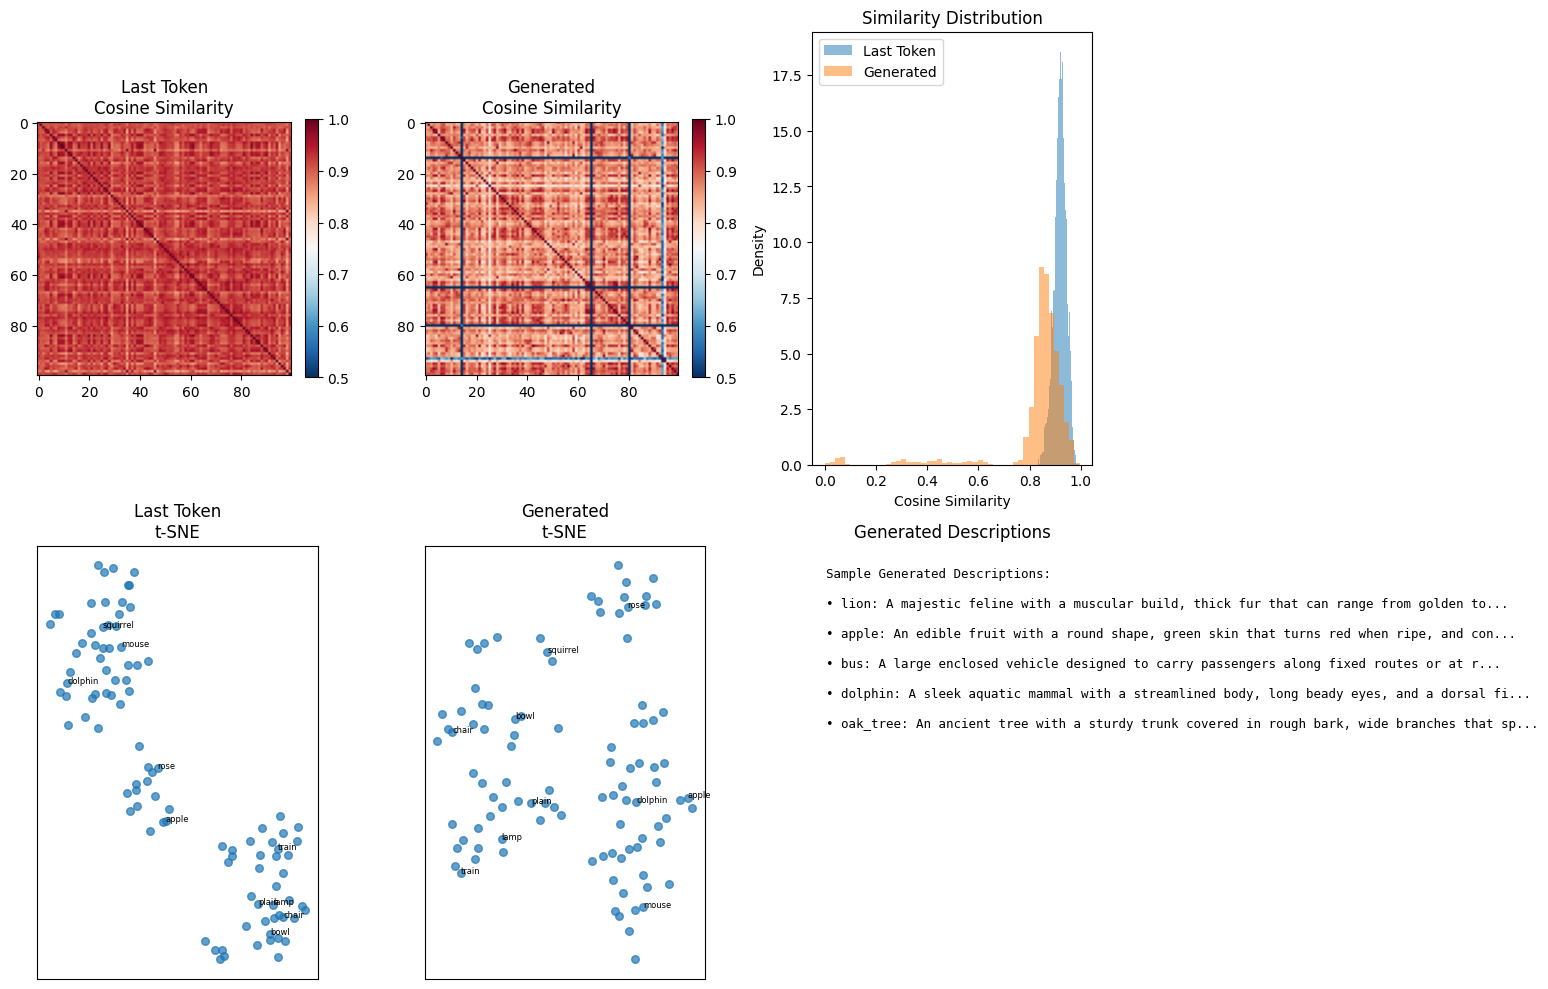


✓ Saved: qwen_twoshot_analysis.png
✓ Model unloaded


In [5]:
"""
Qwen Two-Shot Generation → Encoding
====================================
1. Generate actual description of each class
2. Encode the GENERATED text (the content, not the prompt)
3. Compare semantic structure
"""

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# =============================================================================
# LOAD MODEL
# =============================================================================

print("=" * 70)
print("Loading Qwen 2.5-1.5B-Instruct...")
print("=" * 70)

MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
DEVICE = "cuda"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map=DEVICE,
    trust_remote_code=True,
)
model.eval()

print(f"Model loaded on {DEVICE}")

# =============================================================================
# TWO-SHOT PROMPT
# =============================================================================

def build_twoshot_prompt(class_name: str) -> str:
    """
    Two-shot prompt: show examples first, then ask for target.
    Short, factual descriptions of what the thing IS.
    """
    cls_name = class_name.replace('_', ' ')

    messages = [
        {
            "role": "system",
            "content": "You describe objects in exactly one sentence. Be specific about visual features."
        },
        {
            "role": "user",
            "content": "Describe: car"
        },
        {
            "role": "assistant",
            "content": "A four-wheeled motor vehicle with windows, doors, headlights, and a metal body used for transportation on roads."
        },
        {
            "role": "user",
            "content": "Describe: sunflower"
        },
        {
            "role": "assistant",
            "content": "A tall plant with a large circular flower head containing yellow petals surrounding a brown seed-filled center."
        },
        {
            "role": "user",
            "content": f"Describe: {cls_name}"
        },
    ]

    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )


# =============================================================================
# GENERATE DESCRIPTIONS
# =============================================================================

print("\n" + "=" * 70)
print("Generating descriptions (two-shot)...")
print("=" * 70)

descriptions = {}

for cls in tqdm(CIFAR100_CLASSES, desc="Generating"):
    prompt = build_twoshot_prompt(cls)

    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=False,  # Deterministic
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode only the NEW tokens (the generation)
    generated_ids = outputs[0, inputs['input_ids'].shape[1]:]
    description = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    descriptions[cls] = description

# Show some examples
print("\nSample descriptions:")
for cls in ['apple', 'lion', 'bus', 'oak_tree', 'rocket'][:5]:
    print(f"  {cls}: {descriptions[cls][:100]}...")


# =============================================================================
# ENCODE DESCRIPTIONS
# =============================================================================

print("\n" + "=" * 70)
print("Encoding generated descriptions...")
print("=" * 70)

@torch.no_grad()
def encode_text(text: str) -> torch.Tensor:
    """Encode text using last token of hidden states."""
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs, output_hidden_states=True)
    # Last token of last layer
    return outputs.hidden_states[-1][0, -1, :].cpu().float()


embeddings_generated = []
for cls in tqdm(CIFAR100_CLASSES, desc="Encoding"):
    emb = encode_text(descriptions[cls])
    embeddings_generated.append(emb)

E_generated = torch.stack(embeddings_generated)
print(f"Embeddings shape: {E_generated.shape}")


# =============================================================================
# COMPARE: Last Token (prompt) vs Generated Description
# =============================================================================

print("\n" + "=" * 70)
print("Comparison: Last Token (prompt) vs Generated Description")
print("=" * 70)

# Load the last_token embeddings we made before
E_last_token = torch.load('encoder_cache/cifar100/qwen2.5_1.5b_instruct_last_token_class_embeddings.pt')

def analyze_embeddings(E: torch.Tensor, name: str):
    E_norm = F.normalize(E, dim=-1)
    sim = torch.mm(E_norm, E_norm.T)
    mask = ~torch.eye(100, dtype=torch.bool)
    off_diag = sim[mask]

    # Effective rank
    U, S, V = torch.svd(E)
    S_norm = S / S.sum()
    entropy = -(S_norm * torch.log(S_norm + 1e-10)).sum()
    eff_rank = torch.exp(entropy).item()

    print(f"\n{name}:")
    print(f"  Mean sim: {off_diag.mean():.4f} ± {off_diag.std():.4f}")
    print(f"  Range: [{off_diag.min():.4f}, {off_diag.max():.4f}]")
    print(f"  Effective rank: {eff_rank:.1f}")

    return sim

sim_last = analyze_embeddings(E_last_token, "Last Token (prompt position)")
sim_gen = analyze_embeddings(E_generated, "Generated Description")


# =============================================================================
# SEMANTIC SANITY CHECK
# =============================================================================

print("\n" + "=" * 70)
print("Semantic Sanity Check")
print("=" * 70)

def get_sim(sim_matrix, cls1, cls2):
    i, j = CIFAR100_CLASSES.index(cls1), CIFAR100_CLASSES.index(cls2)
    return sim_matrix[i, j].item()

pairs = [
    ('lion', 'tiger', 'should be HIGH'),
    ('lion', 'pickup_truck', 'should be LOW'),
    ('apple', 'orange', 'should be HIGH'),
    ('apple', 'rocket', 'should be LOW'),
    ('bus', 'train', 'should be HIGH'),
    ('bus', 'bee', 'should be LOW'),
    ('dolphin', 'whale', 'should be HIGH'),
    ('dolphin', 'chair', 'should be LOW'),
    ('oak_tree', 'pine_tree', 'should be HIGH'),
    ('oak_tree', 'telephone', 'should be LOW'),
]

print(f"\n{'Pair':<25} {'Last Token':>12} {'Generated':>12} {'Expected':>15}")
print("─" * 65)

for cls1, cls2, expected in pairs:
    s_last = get_sim(sim_last, cls1, cls2)
    s_gen = get_sim(sim_gen, cls1, cls2)
    delta = s_gen - s_last
    marker = "✓" if (('HIGH' in expected and delta < 0) or ('LOW' in expected and delta < 0)) else ""
    print(f"{cls1} ↔ {cls2:<12} {s_last:>12.4f} {s_gen:>12.4f} {expected:>15}")


# =============================================================================
# SEPARATION METRIC
# =============================================================================

print("\n" + "=" * 70)
print("Semantic Separation Score")
print("=" * 70)

# Calculate HIGH pairs avg vs LOW pairs avg
high_pairs = [('lion', 'tiger'), ('apple', 'orange'), ('bus', 'train'),
              ('dolphin', 'whale'), ('oak_tree', 'pine_tree')]
low_pairs = [('lion', 'pickup_truck'), ('apple', 'rocket'), ('bus', 'bee'),
             ('dolphin', 'chair'), ('oak_tree', 'telephone')]

for name, sim in [("Last Token", sim_last), ("Generated", sim_gen)]:
    high_avg = sum(get_sim(sim, a, b) for a, b in high_pairs) / len(high_pairs)
    low_avg = sum(get_sim(sim, a, b) for a, b in low_pairs) / len(low_pairs)
    separation = high_avg - low_avg
    print(f"{name}: HIGH={high_avg:.4f}, LOW={low_avg:.4f}, separation={separation:.4f}")


# =============================================================================
# VISUALIZATION
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Similarity matrices
for i, (name, sim) in enumerate([("Last Token", sim_last), ("Generated", sim_gen)]):
    ax = axes[0, i]
    im = ax.imshow(sim.numpy(), cmap='RdBu_r', vmin=0.5, vmax=1.0)
    ax.set_title(f'{name}\nCosine Similarity')
    plt.colorbar(im, ax=ax, fraction=0.046)

# Similarity distributions
ax = axes[0, 2]
mask = ~torch.eye(100, dtype=torch.bool)
ax.hist(sim_last[mask].numpy(), bins=50, alpha=0.5, label='Last Token', density=True)
ax.hist(sim_gen[mask].numpy(), bins=50, alpha=0.5, label='Generated', density=True)
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title('Similarity Distribution')
ax.legend()

# t-SNE
from sklearn.manifold import TSNE

for i, (name, E) in enumerate([("Last Token", E_last_token), ("Generated", E_generated)]):
    ax = axes[1, i]
    tsne = TSNE(n_components=2, perplexity=15, random_state=42)
    E_2d = tsne.fit_transform(E.numpy())

    ax.scatter(E_2d[:, 0], E_2d[:, 1], s=30, alpha=0.7)
    for j in range(0, 100, 10):
        ax.annotate(CIFAR100_CLASSES[j], (E_2d[j, 0], E_2d[j, 1]), fontsize=6)
    ax.set_title(f'{name}\nt-SNE')
    ax.set_xticks([])
    ax.set_yticks([])

# Sample descriptions
ax = axes[1, 2]
ax.axis('off')
sample_text = "Sample Generated Descriptions:\n\n"
for cls in ['lion', 'apple', 'bus', 'dolphin', 'oak_tree']:
    desc = descriptions[cls][:80] + "..." if len(descriptions[cls]) > 80 else descriptions[cls]
    sample_text += f"• {cls}: {desc}\n\n"
ax.text(0.05, 0.95, sample_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')
ax.set_title('Generated Descriptions')

plt.tight_layout()
plt.savefig('qwen_twoshot_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: qwen_twoshot_analysis.png")

# =============================================================================
# CLEANUP
# =============================================================================

del model
torch.cuda.empty_cache()
print("✓ Model unloaded")